In [9]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
np.random.seed(1234)

## 3D spin model

I implemented gaussian kernel-approximation using SGD to 3-spin model, introduced in the 2018 paper by Vanden Eijnden and Grant Rostkoff entitled 'Trainability and Accuracy of Neural Networks: An Interacting Particle System Approach'. Then I compared losses in both the deterministic and the stochastic cases incurred in training by different algorithms, which I plotted. 

In [10]:
def spin_func(x,a):
    """
    Calculate the spin function for a given set of vectors and coefficients.

    Parameters:
    x (np.ndarray): An array representing a set of vectors with shape (n, d).
    a (np.ndarray): An array of coefficients with shape (d, d, d).

    Returns:
    np.ndarray: An array containing the computed spin values with shape (1, n).
    """
    n = x.shape[0]
    d = x.shape[1]
    y = x[:,np.newaxis, :]* x[:,:, np.newaxis]
    y = y[:,:,:,np.newaxis]* x[:,np.newaxis, np.newaxis, :]
    z = y*a[np.newaxis,:,:,:]
    return 1/d*z.sum(axis = (1,2,3)).reshape((1,n))

def grad_spin_func(x,a):
    """
    Calculate the gradient of the spin function with respect to the input vectors.

    Parameters:
    x (np.ndarray): An array representing a set of vectors with shape (n, d).
    a (np.ndarray): An array of coefficients with shape (d, d, d).

    Returns:
    np.ndarray: An array containing the gradient of the spin function with shape (n, d).
    """

    n = x.shape[0]
    d = x.shape[1]
    df = 1/d*np.array([((a[p,:,:]+a[:,p,:]+a[:,:,p])[np.newaxis, :,:]\
                *(x[:,np.newaxis,:]*x[:,:, np.newaxis])).sum(axis = (1,2)) for p in range(d)]).reshape(n,d)
    return df

def spin_func_slice(X,Y,a,d = 5):
    """
    Calculate the spin function for a given pair of angles and coefficients.

    Parameters:
    X (float): The first angle.
    Y (float): The second angle.
    a (np.ndarray): An array of coefficients with shape (d, d, d).
    d (int): The dimensionality of the vectors (default is 5).

    Returns:
    np.ndarray: An array containing the computed spin values with shape (1, n).
    """
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X), 0]).reshape(1,d)
    return spin_func(x, a)

vspin_func_slice = np.vectorize(spin_func_slice)
vspin_func_slice.excluded.add(2)

In [11]:
#Initialise params
d = 4
a = np.random.normal(np.zeros((d,d,d)), np.ones((d,d,d)))

([], [])

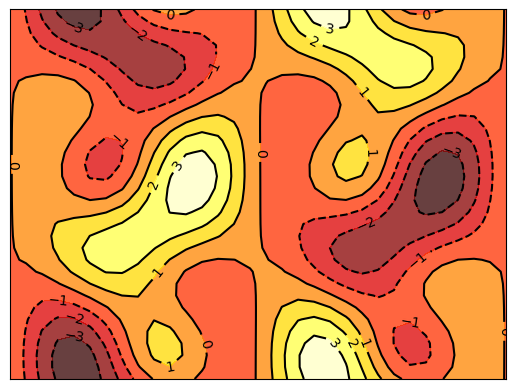

In [12]:
#contour plot of spin function
n = 32
x = np.linspace(-np.pi, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vspin_func_slice(X, Y, a, d=4), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vspin_func_slice(X,Y, a, d=4), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])

/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_93156/705296521.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(m)


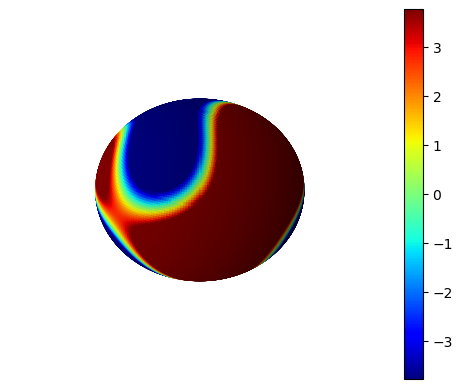

In [28]:
#Heat map (not my code-see below)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


def random_point( r=1 ):
    ct = 2*np.random.rand() - 1
    st = np.sqrt( 1 - ct**2 )
    phi = 2* np.pi *  np.random.rand()
    x = r * st * np.cos( phi)
    y = r * st * np.sin( phi)
    z = r * ct
    return np.array( [x, y, z ] )

def near( p, pntList, d0 ):
    cnt=0
    for pj in pntList:
        dist=np.linalg.norm( p - pj )
        if dist < d0:
            cnt += 1 - dist/d0
    return cnt


"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""

pointList = np.array([ random_point( 10.05 ) for i in range( 65 ) ] )

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1, projection='3d')

u = np.linspace( 0, 2 * np.pi, 240)
v = np.linspace( 0, np.pi, 120 )

# create the sphere surface
XX = np.sqrt(d) * np.outer( np.cos( u ), np.sin( v ) )
YY = np.sqrt(d) * np.outer( np.sin( u ), np.sin( v ) )
ZZ = np.sqrt(d) * np.outer( np.ones( np.size( u ) ), np.cos( v ) )

WW = XX.copy()
for i in range( len( XX ) ):
    for j in range( len( XX[0] ) ):
        x = XX[ i, j ]
        y = YY[ i, j ]
        z = ZZ[ i, j ]
        WW[ i, j ] = spin_func(np.array([x, y, z, 0]).reshape(1,4), a)
myheatmap = WW

# ~ ax.scatter( *zip( *pointList ), color='#dd00dd' )
ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(myheatmap)
plt.colorbar(m)
ax.set_axis_off()
#Show the plot.
plt.show() 



In [34]:
def neural_net_symm(x, c, z):
    """
    Compute the output of a symmetric neural network for given input and parameters.

    Parameters:
    x (np.ndarray): An input vector of shape (1, d).
    c (np.ndarray): Coefficients of the neural network with shape (1, n).
    z (np.ndarray): Weight matrix with shape (n, d).

    Returns:
    np.ndarray: The output of the symmetric neural network with shape (1, 1).
    """
    z = np.array(z)
    n = z.shape[0]
    d = z.shape[1]
    c = c.reshape(1,n)
    return 1/n*(np.exp(-x@z.T)@c.T).reshape(1,x.shape[0])

def neural_net_slice(X, Y, c, z, d = 5):
    """
    Compute the output of a symmetric neural network for given angles and parameters.

    Parameters:
    X (float): The first angle.
    Y (float): The second angle.
    c (np.ndarray): Coefficients of the neural network with shape (1, n).
    z (np.ndarray): Weight matrix with shape (n, d).
    d (int): The dimensionality of the input vectors (default is 5).

    Returns:
    np.ndarray: The output of the symmetric neural network with shape (1, 1).
    """
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X),0]).reshape(1,d)
    return neural_net_symm(x, c, z)
vneural_net_slice = np.vectorize(neural_net_slice)
vneural_net_slice.excluded.add(2)
vneural_net_slice.excluded.add(3)

In [35]:
def sample_uniform_sphere(r, d, n):
    """
    Generate random points uniformly distributed on the surface of a d-dimensional sphere with radius 'r'.

    Parameters:
    r (float): The radius of the sphere.
    d (int): The dimensionality of the sphere.
    n (int): The number of points to generate.

    Returns:
    np.ndarray: An array of shape (n, d) containing 'n' random points sampled uniformly on the sphere's surface.
    """
    s = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    norm = np.sqrt(np.diag(s@s.T)).reshape(n,1)
    result = r*s/norm
    return result

In [36]:
#Training
def train(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    L = np.zeros(n).reshape(n,1)
    P = int(1e2)
    x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere        
        #exp_x = np.exp(-x@z.T)
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        #loss1 = -1/n*c@spin_func(z, a).T+0.5*1/n**2*c@exp@c.T
        #neural_net_symm(z,c,z)
        c_next = c + (spin_func(z, a)-1/n*c@exp)*Dt 
        z_next = z + (c.T*grad+1/n*(c.T*exp)@(c.T*z))*Dt
        #c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        #z_next = z + ((c.T*exp_x.T)@(spin_func(x, a).T*x)-1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P

        #c_next = c + (spin_func(z, a)@exp-1/n*c@exp.T@exp)*Dt/n
        #z_next = z + ((c.T*exp.T)@(spin_func(z, a).T*z)+1/n*(c.T*exp.T@((exp@c.T)*z)))*Dt/n-L*z*Dt
        z_next = z_next*np.sqrt(d)/(np.linalg.norm(z_next, axis = 1).reshape(n,1)+1e-100)
        #L_next = L - (np.linalg.norm(z_next, axis = 1).reshape(n,1)-np.sqrt(d)*np.ones(n).reshape(n,1))*Dt
        z = z_next
        c = c_next
        #L = L_next
                
        losses[step] = loss
        print('loss: {}'.format(loss))
                
    return c,z, losses

In [51]:
#contour plot of neural net reconstruction
c,z,losses = train_SGD(d = 4, n = 256, Dt = 1e-5, steps = int(1*1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

loss: 31897.67466084437
loss: 637638.1917949826
loss: 1270301.0743565895
loss: 2207048.9588930826
loss: 3136441.426836337
loss: 2584382.5142440037
loss: 1990720.566283394
loss: 2795203.5550825335
loss: 1317655.958856391
loss: 3625885.9266775507
loss: 1912991.0634328136
loss: 1866250.6378640041
loss: 2494116.872327289
loss: 2876421.9747309047
loss: 3088045.125659476
loss: 2271465.024506788
loss: 2680653.3128835117
loss: 2735865.64563851
loss: 1606708.2832451046
loss: 2798688.829918898
loss: 2835048.223936537
loss: 1257724.5170996923
loss: 2606646.1053899787
loss: 3122679.024795634
loss: 2015283.334918392
loss: 1634064.7830776891
loss: 2124175.692857029
loss: 1952520.6256297654
loss: 2393772.2127307784
loss: 2083069.262110002
loss: 2558778.4183251476
loss: 2443926.342370641
loss: 2149886.2011652254
loss: 1607922.9066013824
loss: 1862518.3436861571
loss: 1788421.4884330789
loss: 2442206.881374785
loss: 2183382.9848692263
loss: 2380604.3278780803
loss: 2084841.427544351
loss: 1886233.68283

loss: 1737093.0738952386
loss: 1396612.2015752827
loss: 1674353.0270228845
loss: 1731603.2145293215
loss: 1395417.9904664434
loss: 1402643.4674313525
loss: 2347812.281884577
loss: 1050803.954899577
loss: 1510387.447691178
loss: 2000644.766705069
loss: 2459151.1819273126
loss: 1499409.0861366778
loss: 2277204.541358524
loss: 2223047.276075617
loss: 1297573.837748641
loss: 2289326.513931148
loss: 2330866.70026906
loss: 1613277.2816655291
loss: 1419957.4036945351
loss: 1324164.6481727613
loss: 1257734.7378204397
loss: 1693508.8720523133
loss: 1857919.4790322972
loss: 1986309.4966323199
loss: 1822997.94701911
loss: 1327604.9958490853
loss: 1434466.9339998728
loss: 1496689.342153616
loss: 1687047.1058918964
loss: 1481927.3351869977
loss: 1707951.3566837804
loss: 2049765.7705375284
loss: 2404146.7813200266
loss: 2018121.6070056825
loss: 1116134.596802845
loss: 2092924.65864236
loss: 1633506.1453306186
loss: 1309264.5132678177
loss: 1451574.3033594396
loss: 2193121.6306982143
loss: 1827745.58

loss: 1521644.6143738134
loss: 1966204.3867149458
loss: 1201489.8788834098
loss: 1669165.1857328657
loss: 1335579.7294739762
loss: 1402362.9461465352
loss: 698045.5891767859
loss: 1474953.75913187
loss: 1289350.4526384717
loss: 935311.0776536347
loss: 1125932.1010064161
loss: 979653.189034631
loss: 1236181.0741373687
loss: 1442151.086877805
loss: 1516073.9560085984
loss: 1626389.4971043607
loss: 1360645.9522436622
loss: 1227145.3582401287
loss: 1010810.5603620441
loss: 1650233.0564318616
loss: 1106928.2321530553
loss: 1343901.5114626174
loss: 1117678.6772310678
loss: 1304913.5583010942
loss: 1219001.5649714181
loss: 1250972.8793654898
loss: 1692345.7937139296
loss: 853164.7699399997
loss: 867634.6542497119
loss: 917407.518830387
loss: 1210870.3122817823
loss: 1074696.3539903974
loss: 1187321.28755408
loss: 1322986.9647192645
loss: 1433099.6405099346
loss: 1185787.465881058
loss: 1749285.8654522798
loss: 968019.358347207
loss: 907440.7094905605
loss: 1217475.2025172638
loss: 894009.6474

loss: 1059589.1843469457
loss: 825296.2223913993
loss: 768233.2237636643
loss: 713018.4651846233
loss: 942363.318943547
loss: 590842.7579024335
loss: 596377.0966405361
loss: 802514.6989603521
loss: 791923.5632329005
loss: 1302941.0348593558
loss: 1352347.2188332316
loss: 804146.823336941
loss: 894911.9941241549
loss: 836772.3751621774
loss: 784220.7834837612
loss: 546754.062296835
loss: 804864.2087218213
loss: 710332.6076784412
loss: 884392.7570505745
loss: 1048470.8618588817
loss: 788069.8709908143
loss: 1144652.4342555162
loss: 556562.2963220057
loss: 714500.4944519022
loss: 408287.4452393267
loss: 842384.2837704628
loss: 1290771.0889823276
loss: 825224.6565835286
loss: 1098901.9567183151
loss: 713079.1576222553
loss: 983153.7503445727
loss: 849399.706900419
loss: 817943.8492842265
loss: 670707.6445319896
loss: 1362339.21416936
loss: 1068177.1584984604
loss: 856892.2861718232
loss: 799592.0433992678
loss: 833709.5285080132
loss: 1237168.1778876295
loss: 1048033.579200067
loss: 106711

loss: 490348.92930651724
loss: 644033.7758878294
loss: 724191.5077910919
loss: 627838.6422829459
loss: 588170.3883955603
loss: 602370.6291332436
loss: 651171.3350060395
loss: 613689.043741243
loss: 1088862.9313793445
loss: 560440.8186310751
loss: 450117.5334424047
loss: 817166.9626917338
loss: 529305.910188287
loss: 837636.5765705251
loss: 670252.5923924346
loss: 798731.9268917642
loss: 682726.2506369548
loss: 693226.3813338989
loss: 667737.2748268043
loss: 619090.5511783226
loss: 967159.2553217824
loss: 597552.8360988271
loss: 924191.5851535695
loss: 871539.2428650507
loss: 842095.8293723103
loss: 818659.3662871143
loss: 600680.2733441709
loss: 601624.0449815323
loss: 662582.0223287274
loss: 975185.7942478788
loss: 583788.2868503757
loss: 689392.8840303872
loss: 625124.1189507485
loss: 561178.362606521
loss: 816206.0438645093
loss: 639273.8121564834
loss: 573951.5187496094
loss: 558225.2683310368
loss: 682104.0649947491
loss: 754530.7294581591
loss: 859978.2464926298
loss: 956039.1297

loss: 461189.5965562547
loss: 485279.8920846062
loss: 299673.73137723724
loss: 612234.097486263
loss: 508129.04097840545
loss: 469588.19131575845
loss: 678932.2992449382
loss: 651549.5520216967
loss: 551485.7999342693
loss: 579038.2524737234
loss: 444785.10867117665
loss: 723441.891031005
loss: 523887.6848355823
loss: 482318.8580970616
loss: 517415.13029409567
loss: 692592.7341352005
loss: 347732.1499486967
loss: 491902.8613085644
loss: 455807.42084867536
loss: 390906.1874118687
loss: 691716.4413564448
loss: 570667.6946100857
loss: 581387.2352550018
loss: 477022.64340087987
loss: 613259.0075697085
loss: 435775.53145682527
loss: 256781.7525754852
loss: 408495.1457545287
loss: 598716.3198851673
loss: 495602.3831836151
loss: 619390.6188911061
loss: 663528.071753486
loss: 587550.009911996
loss: 490936.8611254277
loss: 518531.539004557
loss: 515284.27613930893
loss: 503724.82288601773
loss: 530706.9931993487
loss: 518845.14371562836
loss: 681966.8744827849
loss: 712358.162687555
loss: 63252

loss: 477208.2091264096
loss: 400527.31454829476
loss: 395729.8358323129
loss: 387796.19212084287
loss: 411276.8745897854
loss: 406578.34156925103
loss: 351547.1122522306
loss: 427824.54735306074
loss: 384547.2882259921
loss: 502318.134421371
loss: 413659.2558525545
loss: 453376.5106642095
loss: 485121.69968885946
loss: 493438.4909414119
loss: 536745.1331917882
loss: 292223.04453565157
loss: 320438.6711165956
loss: 320141.5171286952
loss: 381046.02381445636
loss: 409011.6180010347
loss: 542729.1690753824
loss: 415424.8779129578
loss: 402948.4223540454
loss: 379827.5972594073
loss: 541798.1368305474
loss: 436032.97380614094
loss: 463135.04931140185
loss: 475064.61259981774
loss: 376169.1566869112
loss: 481431.1183710173
loss: 727663.5313039242
loss: 266499.139118988
loss: 654536.6279754121
loss: 444570.82204458694
loss: 421633.78672075854
loss: 499214.46998763626
loss: 659238.2526538089
loss: 615324.709786084
loss: 436703.6265547914
loss: 413544.5928402824
loss: 425679.8372726734
loss: 

loss: 263451.01760010363
loss: 242744.48782391136
loss: 184807.2705975723
loss: 354456.24449812976
loss: 303632.3571522286
loss: 404016.6224046458
loss: 404408.9140367627
loss: 299760.8006464113
loss: 384090.1302223146
loss: 259796.6336143954
loss: 366124.71916094015
loss: 366539.31304859166
loss: 336509.53022386064
loss: 358015.3236151772
loss: 342667.8341168216
loss: 250288.1433651217
loss: 384591.0586059202
loss: 314508.8906438004
loss: 366136.9436937751
loss: 408059.49204209243
loss: 298702.2152072685
loss: 415327.59745508136
loss: 367615.39074070833
loss: 452047.41648070735
loss: 336075.46717691387
loss: 310348.9228842625
loss: 332583.94392786507
loss: 341917.23857707577
loss: 294871.32860525115
loss: 365328.8839880194
loss: 330829.4449724032
loss: 256162.9842197972
loss: 411416.4439430228
loss: 362182.5594669235
loss: 365308.4081960876
loss: 259209.2059885898
loss: 308810.8419885531
loss: 227537.20784590967
loss: 359186.8641896154
loss: 338887.69550997426
loss: 231356.68746287265

loss: 230842.33494911206
loss: 356836.7463300399
loss: 254274.67404905628
loss: 282665.4296918734
loss: 278725.6858318213
loss: 224794.655913943
loss: 304240.08464800497
loss: 255776.43197266597
loss: 248065.151966588
loss: 288312.73180781223
loss: 235670.97168761076
loss: 214848.10647236314
loss: 270930.8574671552
loss: 160205.01343993266
loss: 212436.42233659225
loss: 251784.0756461707
loss: 269427.45324118854
loss: 196910.8607124379
loss: 276028.70842876454
loss: 342463.0197106918
loss: 256012.70770899914
loss: 228952.04775584105
loss: 232245.17943320426
loss: 249328.3382456257
loss: 233794.54540206987
loss: 231637.947527415
loss: 170474.5875909391
loss: 227212.00928053324
loss: 352433.70987131575
loss: 296814.3987856296
loss: 408049.3518695353
loss: 347047.74774339603
loss: 217718.1003155449
loss: 217475.27531721684
loss: 296215.1436904599
loss: 265264.1629731488
loss: 275699.98909346305
loss: 287857.2461514127
loss: 217047.6655470767
loss: 271102.3091538638
loss: 296963.400042454


loss: 175920.73772444762
loss: 198279.84424860138
loss: 185488.2140950227
loss: 210449.48116058958
loss: 309401.59101813677
loss: 277638.0156943386
loss: 265949.6267773312
loss: 243073.66292258233
loss: 204911.65137036022
loss: 202903.4433161699
loss: 327931.26012193615
loss: 189282.2890685263
loss: 193276.0046153344
loss: 230445.58785346153
loss: 134350.9627766318
loss: 158161.63353943327
loss: 179857.95470045696
loss: 164633.6313160597
loss: 155273.6522199629
loss: 152802.9354928295
loss: 214289.35366125868
loss: 131137.72137643077
loss: 231208.08664567844
loss: 224087.78957644885
loss: 189312.6986723103
loss: 237446.44053935108
loss: 131959.99729578762
loss: 236416.55037409693
loss: 185217.84173748203
loss: 228386.73004510894
loss: 129882.96289963482
loss: 184615.75198751982
loss: 261353.46898399413
loss: 192179.98618205215
loss: 240702.85497134563
loss: 289605.2278347095
loss: 185850.55382809805
loss: 169491.95623242465
loss: 247707.2031559797
loss: 268762.983827815
loss: 205524.44

loss: 172510.64233735425
loss: 206909.18722868906
loss: 159225.97031676554
loss: 224921.53650843017
loss: 204068.60219260835
loss: 180519.03758097696
loss: 119737.05773997371
loss: 166194.2129551348
loss: 189738.20152087908
loss: 192616.4526601166
loss: 106553.78448738852
loss: 227344.0787973196
loss: 162347.71540220737
loss: 188664.8759980556
loss: 141694.19725733568
loss: 157735.24118003025
loss: 183656.78764196913
loss: 173671.88379487276
loss: 178982.35659499775
loss: 183800.62483657114
loss: 119029.68437978727
loss: 130744.08595765171
loss: 152235.7760094342
loss: 161424.71652206467
loss: 186788.2233809584
loss: 183584.00445452507
loss: 146999.6490852031
loss: 178156.21163834116
loss: 219156.82395121737
loss: 127090.54782186741
loss: 156234.19433210153
loss: 140231.3205100096
loss: 176525.73748434096
loss: 133060.20172773677
loss: 133520.816444861
loss: 152108.34563761653
loss: 91493.77605887392
loss: 220436.80173737858
loss: 196110.52973612174
loss: 169295.08839317967
loss: 17227

loss: 117660.26085736055
loss: 99423.930016805
loss: 185647.40326286564
loss: 138277.4927688488
loss: 112489.34115187226
loss: 212473.42636954848
loss: 101079.68268695478
loss: 154610.4023242168
loss: 150044.3153160426
loss: 122977.22724578516
loss: 98027.94613542136
loss: 102375.2239510365
loss: 157392.30474029208
loss: 157904.27034272498
loss: 97620.78534732631
loss: 83546.8857004669
loss: 105922.91206284188
loss: 122334.00095253141
loss: 106329.97012516735
loss: 124301.91756964082
loss: 170852.66373959678
loss: 166529.32717854195
loss: 122751.58147363736
loss: 127605.56490333333
loss: 142354.01536453687
loss: 218216.30360512092
loss: 142795.15246236022
loss: 112448.21375735177
loss: 166067.5185877499
loss: 148726.50881294382
loss: 139493.22605620237
loss: 150359.55447746004
loss: 134155.93409016478
loss: 72489.89922894233
loss: 124962.26715555912
loss: 84527.76390917764
loss: 103729.44544223638
loss: 161838.29598218997
loss: 77560.10810869736
loss: 94093.20204118305
loss: 189545.844

loss: 81304.77857943531
loss: 102412.97581253262
loss: 90644.08627723069
loss: 114052.47699229122
loss: 76626.72553285262
loss: 86310.56605922153
loss: 125426.75111600423
loss: 102657.32784200694
loss: 80069.9560709107
loss: 113799.35580977483
loss: 117046.02732916082
loss: 106575.96951028594
loss: 85461.69743624482
loss: 80573.89515157774
loss: 115097.91163853335
loss: 139290.02398887736
loss: 75918.29779115504
loss: 59978.51014780226
loss: 89265.97103488445
loss: 100583.96369696713
loss: 124430.45908874049
loss: 125282.19099362302
loss: 97885.20940668049
loss: 116815.48773653657
loss: 108045.63440616317
loss: 133010.37333823438
loss: 110486.0748303936
loss: 61139.47632916055
loss: 81060.51394936028
loss: 91169.84332765141
loss: 104381.50844580257
loss: 85057.54117320944
loss: 74896.32264862325
loss: 140839.34159130006
loss: 123965.44730762058
loss: 126938.50956279496
loss: 82405.49208112762
loss: 134786.64647934656
loss: 99376.09190051026
loss: 106103.1439532458
loss: 102089.38732359

loss: 87161.71702857681
loss: 91448.65113592321
loss: 109670.32208498301
loss: 101711.66903572156
loss: 91445.43959941696
loss: 97121.4740774078
loss: 88324.36847702925
loss: 90400.00114863404
loss: 102624.61627022142
loss: 104181.90368109875
loss: 127412.77081227637
loss: 106388.77919710688
loss: 118486.53885896233
loss: 57809.99691147617
loss: 92024.19053704316
loss: 77058.8140820904
loss: 91301.85335398132
loss: 118715.12849455162
loss: 135461.58223356697
loss: 85483.9231273896
loss: 77119.19907158511
loss: 74694.2623387545
loss: 88178.49782759129
loss: 90352.75081863083
loss: 109616.76517027165
loss: 111362.55994483987
loss: 83230.88315338573
loss: 95358.57708944542
loss: 105849.47680006638
loss: 106387.6264198731
loss: 77939.42415804384
loss: 110494.8262099984
loss: 103383.78753915682
loss: 132296.41894316755
loss: 77801.20044246265
loss: 73805.00111032282
loss: 78555.7999450525
loss: 99020.51942839222
loss: 90314.46826517642
loss: 78000.23462795187
loss: 90876.54955182204
loss: 7

loss: 63397.72747248483
loss: 71711.44132992996
loss: 80140.20758671893
loss: 74736.2852353388
loss: 48649.825149485405
loss: 27306.699269613513
loss: 45635.985704512306
loss: 56539.91016985622
loss: 65672.11262580156
loss: 61066.22968280149
loss: 103065.05924729539
loss: 69599.56877705485
loss: 73209.39455358096
loss: 56718.23514648028
loss: 58829.16218318448
loss: 72524.68447177367
loss: 88114.8269232429
loss: 69200.42575052346
loss: 60255.09596191239
loss: 74708.0625599032
loss: 59328.13603237288
loss: 71630.33328772866
loss: 82295.05434816146
loss: 70186.21147929253
loss: 77744.85402531787
loss: 87694.71872458392
loss: 56337.15526280364
loss: 52888.198940770024
loss: 75744.12778804418
loss: 101845.95544436603
loss: 55386.95372009173
loss: 63552.98668799713
loss: 57487.668384362536
loss: 61702.25220065319
loss: 98525.89130547816
loss: 69741.86077067818
loss: 62344.373556231614
loss: 74059.97173117408
loss: 88955.99075994093
loss: 76685.41184527572
loss: 90700.69721510934
loss: 74982

loss: 73169.77266332945
loss: 69444.18153710794
loss: 63245.61140663083
loss: 57473.01911011741
loss: 90953.63469270382
loss: 45437.929570988745
loss: 42123.319726296075
loss: 40649.23816246503
loss: 62979.84586543416
loss: 60758.71053722748
loss: 62396.908853165936
loss: 73845.29354429652
loss: 59902.235951725925
loss: 61926.16532376147
loss: 88948.81535733838
loss: 46731.68302764647
loss: 37047.15240853221
loss: 55107.76295411593
loss: 73953.60526800547
loss: 63208.28637599239
loss: 57083.489286278396
loss: 59766.6144704223
loss: 55311.553933590374
loss: 55193.89012702288
loss: 58670.46056580324
loss: 36347.90188495191
loss: 56431.55755253236
loss: 56501.89468494328
loss: 50133.641339294016
loss: 57002.050775632226
loss: 46120.06482732205
loss: 53784.455042894
loss: 64057.37056637248
loss: 66623.11084522508
loss: 36259.02730904346
loss: 40486.3914816707
loss: 53477.824577222855
loss: 58554.21142689714
loss: 52240.90077158599
loss: 73349.29220894273
loss: 73355.19600233069
loss: 63730

loss: 43529.54824242868
loss: 46075.66266958907
loss: 43431.490491453624
loss: 37400.03828233109
loss: 35322.64501208078
loss: 33777.728813037276
loss: 36625.658141171174
loss: 26902.743857188867
loss: 34971.38845888467
loss: 39082.00475543601
loss: 27478.288513583928
loss: 39448.035266959094
loss: 45393.4314834447
loss: 38865.38341704355
loss: 42706.59599721647
loss: 39003.08603163152
loss: 61713.339331257266
loss: 35415.433655184155
loss: 49601.6089571941
loss: 42876.353191153685
loss: 46642.05976055
loss: 31032.26138220599
loss: 48438.49461274016
loss: 29650.974233251716
loss: 28434.01547837455
loss: 36950.73719324262
loss: 50254.1147231874
loss: 59142.693419444804
loss: 36586.6430499672
loss: 34959.49062731791
loss: 33140.20299337157
loss: 43671.73536910193
loss: 32649.815857313126
loss: 29564.330354512414
loss: 27471.02655840007
loss: 50502.74155767675
loss: 48969.61807313439
loss: 37460.42769120918
loss: 23607.764334161755
loss: 32985.25300985596
loss: 39007.645428875294
loss: 36

loss: 25642.366644072194
loss: 28479.459487021617
loss: 22793.63346970417
loss: 34827.718724168975
loss: 28195.761484395247
loss: 26846.5175965638
loss: 24395.088806771935
loss: 29796.078417567587
loss: 22297.447125399984
loss: 30778.993821960714
loss: 30281.74210526081
loss: 29937.550012992713
loss: 23299.3928061375
loss: 27147.790527601665
loss: 34589.34490215388
loss: 22816.118200765406
loss: 14615.79621753325
loss: 20117.83735714288
loss: 37715.593597991116
loss: 35923.29998061671
loss: 24828.78191533678
loss: 23544.748799227393
loss: 18948.24251502829
loss: 16917.84161869282
loss: 32420.37074788146
loss: 23286.358344676475
loss: 26202.690147150657
loss: 27533.393334337627
loss: 37664.57337988399
loss: 26038.946774999484
loss: 14417.983946433984
loss: 20169.643684280014
loss: 21210.67436115756
loss: 25515.332852728196
loss: 32965.901517701626
loss: 26784.268821375375
loss: 22527.507224597266
loss: 28162.49220099807
loss: 35975.01460231173
loss: 33230.02844454134
loss: 22656.2068146

loss: 15087.443897793468
loss: 19432.359616239264
loss: 15804.389719470655
loss: 21337.17720111411
loss: 18726.561477878226
loss: 19396.166956848385
loss: 18936.708215384588
loss: 18135.808744548198
loss: 14213.01486371736
loss: 8723.63380144293
loss: 6855.455681156407
loss: 2806.016684413103
loss: 1833.1299736004837
loss: 1855.9192718614352
loss: 5562.411113908653
loss: 4137.622567364567
loss: 2037.6238574213153
loss: 2379.711804561164
loss: 691.1970795446665
loss: 220.23789876829696
loss: 132.05580414590673
loss: 134.90309689895992
loss: 105.01231825679562
loss: 64.95629477385654
loss: 65.07837756445475
loss: 50.20651058576473
loss: 34.529971553562426
loss: 44.85211710540291
loss: 44.76657482756199
loss: 33.08727673580941
loss: 32.214020929974815
loss: 31.406559966030283
loss: 28.026162285451242
loss: 21.996130831671067
loss: 23.870740893118928
loss: 25.574125033904373
loss: 19.591044252583487
loss: 18.616695975329524
loss: 20.648227199645547
loss: 20.751778123442467
loss: 17.1633966

loss: 1.3272536103949428
loss: 1.609412650545961
loss: 1.8160589784653696
loss: 1.8312258737281601
loss: 2.009510054056727
loss: 1.6513201504773212
loss: 1.4522184721264717
loss: 1.9099269749073868
loss: 2.419405362325355
loss: 1.760179106504157
loss: 2.1775529150930057
loss: 1.8086149164879932
loss: 1.9190635401014393
loss: 1.6594902462340348
loss: 1.759332034857504
loss: 1.7811871493652784
loss: 1.9825967058735692
loss: 1.7639735115251214
loss: 2.230266165585544
loss: 1.9077055173106368
loss: 1.8511306384966408
loss: 1.9010329083524824
loss: 1.5291145857312904
loss: 1.7451338156013672
loss: 1.5217975604415597
loss: 1.8331971109457132
loss: 1.6664706657881516
loss: 1.6065387718545978
loss: 1.3751534655453603
loss: 1.9403431809434766
loss: 1.6562953966435419
loss: 2.4223457158572597
loss: 2.0587392298751
loss: 1.7126459859316348
loss: 1.4692422795504074
loss: 1.8379929005806253
loss: 1.5466213203369497
loss: 1.8139680011362445
loss: 2.06330321943964
loss: 1.5374017998732727
loss: 1.809

loss: 1.0425935552463819
loss: 0.9485503268017709
loss: 1.1210086863552107
loss: 1.2669952513034337
loss: 1.0767595244579786
loss: 1.1422661761144428
loss: 1.2894255773821726
loss: 0.9083493584721526
loss: 1.1806441940596288
loss: 1.3387625233578595
loss: 1.1927309964403963
loss: 0.9383889027255472
loss: 1.1214996963820523
loss: 1.227802882248161
loss: 0.9390420107446302
loss: 0.9859655085518965
loss: 1.0318879701276866
loss: 1.0793014486243389
loss: 1.0825062314345786
loss: 1.3761604591813932
loss: 1.2365249135620588
loss: 1.1122993838375173
loss: 1.0551230690742508
loss: 1.113578576744868
loss: 0.8794967939612793
loss: 1.315645093689391
loss: 0.92646168084538
loss: 1.2159215865054462
loss: 1.0580295183290067
loss: 1.1499302190471399
loss: 1.09908352760755
loss: 1.1423225536950874
loss: 0.929664035706593
loss: 0.9464383459370103
loss: 1.274637176893015
loss: 1.4008188447712377
loss: 1.384093460346934
loss: 0.9489742501335293
loss: 0.861035467175659
loss: 0.9147800881642065
loss: 0.906

loss: 0.9593193056200359
loss: 0.9874118852855684
loss: 1.059794439477784
loss: 1.004743882716478
loss: 0.8031062292321721
loss: 0.7882262860242595
loss: 0.860673008881273
loss: 0.959732158675419
loss: 0.9689773375911429
loss: 0.9031199289419004
loss: 0.80865321232857
loss: 0.816007296500752
loss: 0.8096020226917883
loss: 0.8600228640503428
loss: 0.893118893821962
loss: 1.0575815697690079
loss: 0.8615010667778131
loss: 0.7949287868416774
loss: 0.7702313404942619
loss: 0.9336256693206646
loss: 0.7770041701202267
loss: 0.7052939702514882
loss: 0.9442146086308562
loss: 0.9440055419819506
loss: 0.7339323358749064
loss: 0.8513401566390151
loss: 0.8022674445795249
loss: 0.91447167771908
loss: 0.9733960268035078
loss: 0.855273889200658
loss: 1.0641628058206427
loss: 1.0764477326833473
loss: 0.8772732323714928
loss: 0.9198384800852673
loss: 0.7769417867953368
loss: 0.8700582836600969
loss: 0.9403071899860193
loss: 0.8807817885185146
loss: 0.8485229578751998
loss: 0.8778268217459453
loss: 0.893

loss: 0.7716036346300466
loss: 0.9080716833000372
loss: 0.7216954639031019
loss: 0.7296920618976378
loss: 0.7154665967556559
loss: 0.5824767585735529
loss: 0.7805757274759805
loss: 0.5749867640404623
loss: 0.6477668085956355
loss: 0.5963704061815072
loss: 0.7248278596343657
loss: 0.6182524051612013
loss: 0.6063916014032994
loss: 0.7605077808010094
loss: 0.6428858442379792
loss: 0.6428092905557599
loss: 0.7074761368796445
loss: 0.8814476202782816
loss: 0.6722651178209748
loss: 0.515187940482194
loss: 0.649140254512885
loss: 0.6779813717414349
loss: 0.7780389324922093
loss: 0.7440107636954258
loss: 0.6500099204526865
loss: 0.7655039394942575
loss: 0.5862901235673742
loss: 0.8111454370318968
loss: 0.6591830028421406
loss: 0.6474595637279863
loss: 0.6410458653179709
loss: 0.6332293980594467
loss: 0.6659536417785735
loss: 0.6119398096982588
loss: 0.6908352225987737
loss: 0.6594338564329071
loss: 0.5505197555613677
loss: 0.6447861622239075
loss: 0.6048603775997975
loss: 0.6176515153218779
lo

loss: 0.6820640220280567
loss: 0.7073285975055531
loss: 0.5911376083244739
loss: 0.6026489237517074
loss: 0.5211813472719099
loss: 0.6336254137030606
loss: 0.652811072959675
loss: 0.43627516211992223
loss: 0.6129555489786678
loss: 0.5054101202496499
loss: 0.5369186231625314
loss: 0.5800531955549969
loss: 0.5561376903627824
loss: 0.5728283705482129
loss: 0.6382177829575112
loss: 0.6039207381279517
loss: 0.6685876302331663
loss: 0.6115749869905839
loss: 0.5771904988366735
loss: 0.5801391959021176
loss: 0.49208749042353417
loss: 0.5478913099284526
loss: 0.5378147415283068
loss: 0.5887574985540592
loss: 0.5932375807588035
loss: 0.7567939370644008
loss: 0.538581412326007
loss: 0.5255293618465393
loss: 0.7010409973979638
loss: 0.5352539061283478
loss: 0.5963681621659895
loss: 0.4441405141578489
loss: 0.5837150750519864
loss: 0.556912684925304
loss: 0.49429439856997476
loss: 0.47499945073875877
loss: 0.6397515998184722
loss: 0.5558425487922962
loss: 0.6106947380258054
loss: 0.6230858127248594

loss: 0.46802157624935475
loss: 0.41543888394218265
loss: 0.4069359264763386
loss: 0.4824045466746052
loss: 0.5142214920374081
loss: 0.5700111097964586
loss: 0.43912593810379136
loss: 0.4570539550089853
loss: 0.43043156831232954
loss: 0.3880915280802336
loss: 0.4674277758787659
loss: 0.5508883987017977
loss: 0.45461740756067975
loss: 0.48339417160533343
loss: 0.4346047825760369
loss: 0.532766946781023
loss: 0.5174095058251231
loss: 0.5103639373179185
loss: 0.4445363185408729
loss: 0.5865201426478144
loss: 0.48848661863661674
loss: 0.5294594151925704
loss: 0.4928404764569343
loss: 0.4870965354065209
loss: 0.4937057596586887
loss: 0.5220045092165426
loss: 0.44090070418306687
loss: 0.4558456941063983
loss: 0.5070152362471633
loss: 0.5025967927387296
loss: 0.45896169595858227
loss: 0.4701749241090311
loss: 0.4203880569218032
loss: 0.4701964298812677
loss: 0.5014663166501008
loss: 0.46874767274775875
loss: 0.46764729812629563
loss: 0.3754522190567687
loss: 0.4329718252741367
loss: 0.5365641

loss: 0.4337231604668944
loss: 0.37038825673963943
loss: 0.3975576560265317
loss: 0.43848585804565837
loss: 0.40553780931763383
loss: 0.3423788515203157
loss: 0.37815310591832635
loss: 0.3575659030182544
loss: 0.5055791880670961
loss: 0.4800905279846437
loss: 0.2760880434997732
loss: 0.35775185277150334
loss: 0.4330915778936022
loss: 0.440847363952284
loss: 0.38484997935333004
loss: 0.40335924520743743
loss: 0.3741217160905171
loss: 0.36340850276791015
loss: 0.3516747102456975
loss: 0.45710942467026583
loss: 0.5693786878037804
loss: 0.3989086454336425
loss: 0.48939734679664554
loss: 0.38778484579993594
loss: 0.4044965235988213
loss: 0.38670528260079445
loss: 0.40796523962016723
loss: 0.413871875263921
loss: 0.4456119189657916
loss: 0.36227751388417934
loss: 0.3908134619618265
loss: 0.4710362716006082
loss: 0.49026106397296937
loss: 0.3039709930734894
loss: 0.37804486411026855
loss: 0.4504887482810151
loss: 0.398305859581132
loss: 0.40084015869156664
loss: 0.3645328182052341
loss: 0.440

loss: 0.2894097925746156
loss: 0.30521267133170676
loss: 0.4200751178277971
loss: 0.3792923803690328
loss: 0.32362610902249805
loss: 0.25302016846253816
loss: 0.3768607755468327
loss: 0.36416537945301947
loss: 0.34531180972679737
loss: 0.3554619349960732
loss: 0.37253533930250304
loss: 0.3031916885863938
loss: 0.33244363820502165
loss: 0.30382350547673925
loss: 0.3617872318137031
loss: 0.33153708710842594
loss: 0.32211008594107426
loss: 0.46398995393423415
loss: 0.4090332971652948
loss: 0.3379620216339528
loss: 0.3270079726289671
loss: 0.32801210205959236
loss: 0.3306188180065008
loss: 0.4162861923844457
loss: 0.3951207489315903
loss: 0.3041965976462488
loss: 0.3306501753854592
loss: 0.3843722555660506
loss: 0.3426403780789275
loss: 0.2782885195974483
loss: 0.3438341728664126
loss: 0.3765358662255017
loss: 0.3651073005619663
loss: 0.3548541189651717
loss: 0.36248836148498936
loss: 0.30753864168288636
loss: 0.2864389933930394
loss: 0.33745494289621397
loss: 0.3369906117431043
loss: 0.33

loss: 0.24522666992616102
loss: 0.2875246283332047
loss: 0.33281366824310943
loss: 0.2765096223471226
loss: 0.2972786885663694
loss: 0.26891870031988274
loss: 0.26805856631129443
loss: 0.2667501318253752
loss: 0.28057399524417337
loss: 0.299916605670305
loss: 0.32397706455911396
loss: 0.2820414609160326
loss: 0.2583921066483061
loss: 0.29877557794001053
loss: 0.2704352376486481
loss: 0.29356289845904177
loss: 0.2838871555130027
loss: 0.2336905349419912
loss: 0.2718362639833074
loss: 0.2807957594271459
loss: 0.24675811746394274
loss: 0.2658102284662887
loss: 0.28909005757971135
loss: 0.3287211602235448
loss: 0.31358461813405664
loss: 0.2673775734135076
loss: 0.27062162084607305
loss: 0.25455355661438267
loss: 0.31988402742213184
loss: 0.28787906612965797
loss: 0.30240422493606806
loss: 0.27484554429868147
loss: 0.3059869880174575
loss: 0.2044191883734759
loss: 0.36673363818307464
loss: 0.27837085610294204
loss: 0.3235195263724913
loss: 0.20295552841191683
loss: 0.26035097312890654
loss:

loss: 0.2522607203524445
loss: 0.22434034512010384
loss: 0.2537138445770794
loss: 0.24017448505433087
loss: 0.20517288672360937
loss: 0.22751907677862637
loss: 0.20843730283319556
loss: 0.21234424227211257
loss: 0.25182527406305694
loss: 0.27393921247310926
loss: 0.24088144783510354
loss: 0.28648612309233007
loss: 0.24190039374042768
loss: 0.24570631532446569
loss: 0.2946295368285124
loss: 0.21738837285287704
loss: 0.21301923476794418
loss: 0.2729283682697133
loss: 0.3043910692200172
loss: 0.2534770906987207
loss: 0.2887449840982099
loss: 0.26389373024171725
loss: 0.2917844538555341
loss: 0.2687576154348638
loss: 0.1958889912215259
loss: 0.27391138980284446
loss: 0.2969484462814712
loss: 0.2999999356492752
loss: 0.25381185321821303
loss: 0.23462155549352226
loss: 0.24267800190915215
loss: 0.2504036603002984
loss: 0.3428439953226854
loss: 0.2689478299265676
loss: 0.22661425190329385
loss: 0.25983599421295706
loss: 0.31677921008144794
loss: 0.1945745281100403
loss: 0.2686258152119511
los

loss: 0.2696315343348995
loss: 0.2445455508916252
loss: 0.19409561477620246
loss: 0.21961234009657604
loss: 0.22667236869968682
loss: 0.19905927485197594
loss: 0.2749465304690789
loss: 0.22937271763605216
loss: 0.2536662708392195
loss: 0.24314799275431015
loss: 0.20274328208177333
loss: 0.23090458584424403
loss: 0.21129955310245016
loss: 0.25341830273461335
loss: 0.25039044359027607
loss: 0.2148926140584363
loss: 0.23075208947547157
loss: 0.2442899316838847
loss: 0.23593905065852602
loss: 0.21683248136577604
loss: 0.208601780319153
loss: 0.21550102938280805
loss: 0.1994301259821879
loss: 0.2170392268567796
loss: 0.19582988385667782
loss: 0.19581153976401303
loss: 0.2570412910089636
loss: 0.24008017271430593
loss: 0.21545236224890452
loss: 0.17596440900102692
loss: 0.19008736913098004
loss: 0.2289305239810553
loss: 0.2601404350120278
loss: 0.26071566451762807
loss: 0.23841225554408144
loss: 0.19854587093969006
loss: 0.18912558587743664
loss: 0.22645579618198874
loss: 0.1864139744156819


loss: 0.19987795620070817
loss: 0.2055999465199512
loss: 0.1609519319966456
loss: 0.20739036174034145
loss: 0.21538381312374233
loss: 0.21930162391421149
loss: 0.20602717946302002
loss: 0.18567694504922105
loss: 0.1965456268876411
loss: 0.13909153604636548
loss: 0.2051108843814825
loss: 0.1632192649959401
loss: 0.18316472357882246
loss: 0.19940848485180843
loss: 0.23010930409419825
loss: 0.18987509814828823
loss: 0.17945603401565333
loss: 0.18978850323591043
loss: 0.1982661907253819
loss: 0.2117201340266493
loss: 0.23759662359918976
loss: 0.21145030136743248
loss: 0.23379538607961692
loss: 0.2551519324883699
loss: 0.18519659357706442
loss: 0.18967854327419245
loss: 0.22563327158820967
loss: 0.2183772013140622
loss: 0.14883925297627512
loss: 0.16146458455200702
loss: 0.18570975336306764
loss: 0.1820330890475294
loss: 0.1702211025475164
loss: 0.15795390145491478
loss: 0.1818936786708723
loss: 0.22074872444187021
loss: 0.21381477128745177
loss: 0.195522014473661
loss: 0.1825306650110735
l

loss: 0.17015346005567122
loss: 0.18764988172855537
loss: 0.1791360762729686
loss: 0.16303743399457132
loss: 0.2265242113090277
loss: 0.1866956881758465
loss: 0.17037419374101906
loss: 0.1801718924303293
loss: 0.11785338179338897
loss: 0.1409766014329511
loss: 0.1447264376534088
loss: 0.16398839345738941
loss: 0.134991376674455
loss: 0.18617585462348318
loss: 0.21383151345040724
loss: 0.19767742414404516
loss: 0.20747261746220072
loss: 0.1879601000696455
loss: 0.13342899258829719
loss: 0.16942808345524785
loss: 0.21166770090802337
loss: 0.19269378733985237
loss: 0.12508944435904945
loss: 0.1729092902480816
loss: 0.17333638669662108
loss: 0.1866239025049881
loss: 0.18846125914256767
loss: 0.15877382434657264
loss: 0.17903970355580576
loss: 0.18814071735490687
loss: 0.15245028943427977
loss: 0.16273098353933096
loss: 0.1645567257598304
loss: 0.16209182102340897
loss: 0.15688437687411746
loss: 0.16679006077588565
loss: 0.167716306690209
loss: 0.18009580760962188
loss: 0.13558373302371257


loss: 0.17560638889840477
loss: 0.11341747138918698
loss: 0.1899168049051153
loss: 0.13322310984727653
loss: 0.1404607677693856
loss: 0.16130430450204805
loss: 0.1525837016443914
loss: 0.17459671073912703
loss: 0.14879328105866635
loss: 0.12375042528782722
loss: 0.15477787412470326
loss: 0.14663669880028884
loss: 0.13576642318564067
loss: 0.15350192758468767
loss: 0.11728719409005112
loss: 0.14334428924272533
loss: 0.12622186975708063
loss: 0.1583395269235511
loss: 0.11212100538729425
loss: 0.14777320822018203
loss: 0.1311387843692177
loss: 0.1721607977229938
loss: 0.15211384102408446
loss: 0.13485177712739474
loss: 0.1521234737273482
loss: 0.15183905348225113
loss: 0.17401329111562522
loss: 0.13948374085666024
loss: 0.1677268186175976
loss: 0.14260581338254902
loss: 0.13824345925710602
loss: 0.1327299883127076
loss: 0.15277576928943723
loss: 0.16184428173225285
loss: 0.14223911822599059
loss: 0.15414137293461444
loss: 0.16034270542513557
loss: 0.1173958373197153
loss: 0.12172065143303

loss: 0.13589292163530883
loss: 0.15617852379584612
loss: 0.12336072435930882
loss: 0.1225601237220202
loss: 0.13407228265180696
loss: 0.127231011795991
loss: 0.11927793572892632
loss: 0.13018048288607637
loss: 0.13848860010869393
loss: 0.13191117334246819
loss: 0.15420305011727248
loss: 0.12869614425072906
loss: 0.10506503262446555
loss: 0.1404183616157985
loss: 0.1265608784566449
loss: 0.12354588682923721
loss: 0.13494426140594315
loss: 0.1405245980306467
loss: 0.10882384554826256
loss: 0.11708586607140198
loss: 0.1308511985551222
loss: 0.1486537482981426
loss: 0.13026423812817997
loss: 0.12274078434767716
loss: 0.13702663530657377
loss: 0.11234996895078711
loss: 0.12137572110040928
loss: 0.12389774057635279
loss: 0.1367435354837936
loss: 0.14543073049174532
loss: 0.13949387989922882
loss: 0.1501349019291479
loss: 0.11918756337818655
loss: 0.13432481787408748
loss: 0.1308825375879612
loss: 0.11601315674187596
loss: 0.10325242996480641
loss: 0.13840974399635472
loss: 0.117791293051640

loss: 0.12168915153920519
loss: 0.1213085051657989
loss: 0.1102081136295498
loss: 0.1068613779419174
loss: 0.1264009455815199
loss: 0.09200831429538552
loss: 0.1555005971761681
loss: 0.12822577695789036
loss: 0.1274544347645182
loss: 0.12505891259609267
loss: 0.12304583089540982
loss: 0.11015997665815933
loss: 0.11766090155867724
loss: 0.09995571034749555
loss: 0.11521127088884325
loss: 0.10441640388176941
loss: 0.11153582098634368
loss: 0.128245625557133
loss: 0.13166548786082904
loss: 0.12796653580022313
loss: 0.12640920191866226
loss: 0.1217688639438561
loss: 0.11796401257981985
loss: 0.10415131627420653
loss: 0.11962593333329456
loss: 0.11021575149172394
loss: 0.08928097832702239
loss: 0.12222202538777203
loss: 0.10976999982326259
loss: 0.1101275131912472
loss: 0.1316907730624307
loss: 0.10190527999539924
loss: 0.11921004378881998
loss: 0.12980648715755533
loss: 0.10438576546893907
loss: 0.12089481720564191
loss: 0.15347413243136723
loss: 0.1071394405485982
loss: 0.0970471401265626

loss: 0.08831752947630919
loss: 0.10794676381663054
loss: 0.08147705537425903
loss: 0.10008246780428955
loss: 0.11044885737661908
loss: 0.10816751287585832
loss: 0.13917827929723306
loss: 0.085009424824378
loss: 0.08621706996480488
loss: 0.08663747658585413
loss: 0.10385196797834934
loss: 0.11393744716432837
loss: 0.12273019132850806
loss: 0.1133047571348128
loss: 0.08835751137703167
loss: 0.12117895556601292
loss: 0.10237011120763075
loss: 0.11384989383617729
loss: 0.08620988061703215
loss: 0.09819388962231315
loss: 0.11227364419411934
loss: 0.10934003324404801
loss: 0.1104521151411484
loss: 0.07514529303161831
loss: 0.10818703945793288
loss: 0.10650738695732948
loss: 0.10331809829144169
loss: 0.09624734134556263
loss: 0.10581483462584751
loss: 0.10911489002707349
loss: 0.10649828060207941
loss: 0.09578208131158682
loss: 0.09870299530784063
loss: 0.09640790280950964
loss: 0.10483697177347617
loss: 0.1251025136156633
loss: 0.0937391564364972
loss: 0.10590983859503528
loss: 0.1426741340

loss: 0.08952049305418897
loss: 0.0970911246857782
loss: 0.10059537408911484
loss: 0.0843200764175722
loss: 0.07826837892382678
loss: 0.08800921303636118
loss: 0.09237226103837552
loss: 0.096806641180904
loss: 0.0928109912143488
loss: 0.09000915556046973
loss: 0.09758127665085428
loss: 0.09753613599582041
loss: 0.07915917088280977
loss: 0.10727293933708912
loss: 0.12035724196023442
loss: 0.09221051212150914
loss: 0.09616348599424011
loss: 0.09716349737180961
loss: 0.08344381656682355
loss: 0.09800169783461272
loss: 0.08903943946025589
loss: 0.10667539006431075
loss: 0.07247456903282097
loss: 0.09863942612018071
loss: 0.09611632141134649
loss: 0.10147436884757376
loss: 0.10017325488144299
loss: 0.08676463137059366
loss: 0.09146768268154384
loss: 0.10414753025184002
loss: 0.0806507031371175
loss: 0.09012806388963872
loss: 0.0759042134716701
loss: 0.08706689498591837
loss: 0.08535126212076655
loss: 0.0853185747458232
loss: 0.10104536880904931
loss: 0.09528626392417493
loss: 0.104713606101

loss: 0.08888808855096779
loss: 0.07797995176564124
loss: 0.08652466462325795
loss: 0.0706312733515963
loss: 0.09183707135885473
loss: 0.10175089492209795
loss: 0.07655262174983926
loss: 0.1060219685334438
loss: 0.10701289938209921
loss: 0.07471235986728775
loss: 0.0695611130562555
loss: 0.09580642072614927
loss: 0.08314144174095332
loss: 0.08221556046682185
loss: 0.0875735501838024
loss: 0.09580471240136404
loss: 0.07745417756762228
loss: 0.08855744042356793
loss: 0.08661133869758604
loss: 0.08790592253933871
loss: 0.08708112503933803
loss: 0.08596617930385352
loss: 0.07805667214121288
loss: 0.0835117176566753
loss: 0.087619788393036
loss: 0.09039264631460403
loss: 0.07827185768935538
loss: 0.10020477764511564
loss: 0.09960459139875769
loss: 0.07779185115823539
loss: 0.09207291697717951
loss: 0.09621552857797853
loss: 0.08708839089078976
loss: 0.09227925971987515
loss: 0.0852346403910621
loss: 0.09920578045981449
loss: 0.09000922361909355
loss: 0.09022850454031955
loss: 0.059393498845

loss: 0.08144092975731528
loss: 0.08141702637338556
loss: 0.07614984658884176
loss: 0.07283631487538131
loss: 0.0643887825109878
loss: 0.060213957029896424
loss: 0.0686053981909497
loss: 0.1068028764848844
loss: 0.06311944467630519
loss: 0.09649199552194916
loss: 0.0868982507456538
loss: 0.06014836153005712
loss: 0.07662604222043887
loss: 0.07289023080031037
loss: 0.07387374113273358
loss: 0.07791566120362566
loss: 0.08641672039717962
loss: 0.07291812009768832
loss: 0.08378821641515771
loss: 0.08177884675697751
loss: 0.07393847914707004
loss: 0.06052266530669704
loss: 0.07707741960504062
loss: 0.0750676636586784
loss: 0.07436619898987748
loss: 0.081516459488292
loss: 0.0765903260720102
loss: 0.07534818746199048
loss: 0.07003153294502618
loss: 0.07371947514425843
loss: 0.07559742155343258
loss: 0.07884116913104737
loss: 0.07487916074053264
loss: 0.07432012405977513
loss: 0.0715975748469291
loss: 0.08137696311818653
loss: 0.06838567104800579
loss: 0.08059215203334322
loss: 0.071692685694

loss: 0.07488473369452862
loss: 0.07686092069871206
loss: 0.0757347390008453
loss: 0.08199254472401296
loss: 0.05819770458208356
loss: 0.05614023975471929
loss: 0.07472461705960566
loss: 0.06607502190573555
loss: 0.0704498813918962
loss: 0.07860241981147341
loss: 0.08957598153096473
loss: 0.08493829696278313
loss: 0.08470350445622346
loss: 0.07199076247914304
loss: 0.08699916588084029
loss: 0.06785353340321612
loss: 0.05807433502409001
loss: 0.0730420760167508
loss: 0.07797690108231921
loss: 0.07585751190935258
loss: 0.07126752967932022
loss: 0.061046978789376434
loss: 0.08790156095272181
loss: 0.08533496045039891
loss: 0.07948641718785368
loss: 0.09453805223427318
loss: 0.07448378143203593
loss: 0.06040462782639908
loss: 0.0931072452000686
loss: 0.07352077565940446
loss: 0.0836910906369252
loss: 0.0761231896625041
loss: 0.07949657188866205
loss: 0.06671133883969399
loss: 0.07599614827743503
loss: 0.060675750711421984
loss: 0.062213900079130496
loss: 0.06719379426025701
loss: 0.0640293

loss: 0.06279666811600863
loss: 0.08693273553391738
loss: 0.07288245258459186
loss: 0.055480065487832964
loss: 0.06864536593409203
loss: 0.07541666714198439
loss: 0.066562440658628
loss: 0.06865462397342283
loss: 0.09252802703788329
loss: 0.06909466705349616
loss: 0.05806594150675051
loss: 0.05285048477360186
loss: 0.06792034257890955
loss: 0.0707521704819864
loss: 0.0835273993281125
loss: 0.0642840087294755
loss: 0.06554599598708064
loss: 0.0688728312077803
loss: 0.07712181202658529
loss: 0.06265329989508753
loss: 0.07070785625883798
loss: 0.057982728164020496
loss: 0.07052448603661593
loss: 0.06457852262410763
loss: 0.058008094461028746
loss: 0.07345489690611245
loss: 0.06612006569226715
loss: 0.07147840057090718
loss: 0.07781101206165736
loss: 0.04977064467196914
loss: 0.05315776813365446
loss: 0.056790975350816335
loss: 0.05654864977146989
loss: 0.06626766799400627
loss: 0.0625012316629904
loss: 0.06608702903212058
loss: 0.07317900928348432
loss: 0.0668092093331801
loss: 0.07373943

loss: 0.05377603219736399
loss: 0.061361580541829476
loss: 0.06413433868939548
loss: 0.05094945377204882
loss: 0.056051449670709165
loss: 0.07152069221110356
loss: 0.049977819719138894
loss: 0.07736036356237984
loss: 0.060647387830524105
loss: 0.04457178146065909
loss: 0.06237841320975799
loss: 0.04854052609127269
loss: 0.06439256874520165
loss: 0.07487936737743515
loss: 0.061650115045372954
loss: 0.06262769757545991
loss: 0.05640020991400532
loss: 0.06320505524358673
loss: 0.05002497593024977
loss: 0.052797447216582645
loss: 0.051516363257549914
loss: 0.06044204105271455
loss: 0.05455173211069319
loss: 0.06291842635187457
loss: 0.06365227095319423
loss: 0.05914148291043157
loss: 0.06596810146175407
loss: 0.05349854513877899
loss: 0.06770063378766839
loss: 0.05099211014395459
loss: 0.06007785948417344
loss: 0.05036461767497034
loss: 0.07877027165154281
loss: 0.06447136846936923
loss: 0.07813504774582956
loss: 0.0629089363247748
loss: 0.07623695186383432
loss: 0.05573593791244057
loss: 

loss: 0.06055697887830484
loss: 0.05422313497110807
loss: 0.0734245320945815
loss: 0.06290195457876868
loss: 0.06573182060006265
loss: 0.05750757762583171
loss: 0.045034950423938215
loss: 0.0675581334856765
loss: 0.06374580871845324
loss: 0.06243748454802707
loss: 0.06083584317361545
loss: 0.0644274523535458
loss: 0.05797489276410785
loss: 0.06348513953460297
loss: 0.07014078812886007
loss: 0.06436060620258113
loss: 0.05868174837818329
loss: 0.06169570096825084
loss: 0.046106172862434125
loss: 0.07674734798790799
loss: 0.06737711999503153
loss: 0.059526732688414574
loss: 0.061687471248314966
loss: 0.06290437447326165
loss: 0.06313014743921475
loss: 0.045145629333388004
loss: 0.05004403984739639
loss: 0.054741648818788964
loss: 0.06056516161790098
loss: 0.049683291418438705
loss: 0.05085790599704675
loss: 0.048144511953293695
loss: 0.05346185375046793
loss: 0.049782566693648576
loss: 0.05662863570970694
loss: 0.04591465955371666
loss: 0.06096779820501212
loss: 0.07406191223819146
loss: 

loss: 0.053759929430390326
loss: 0.059089720800074685
loss: 0.05578529414607588
loss: 0.0505411382971799
loss: 0.04557941726875514
loss: 0.04718283062496016
loss: 0.05029723696956679
loss: 0.05395753500330244
loss: 0.059470064854294576
loss: 0.058425234154704776
loss: 0.06864391718559142
loss: 0.044350353954812655
loss: 0.047425826370865114
loss: 0.05308119939192246
loss: 0.0726687162020437
loss: 0.03718371688977079
loss: 0.04347233289900378
loss: 0.05198740957802236
loss: 0.058712974648667746
loss: 0.0611446384157914
loss: 0.05716622744395428
loss: 0.05286993253253779
loss: 0.05221796873269753
loss: 0.04841315297518942
loss: 0.04327618593870209
loss: 0.07261799084544031
loss: 0.058060310816484086
loss: 0.04634189884727646
loss: 0.048730463206882055
loss: 0.06734609896197734
loss: 0.06078143513917715
loss: 0.039807240210706765
loss: 0.05460669280322139
loss: 0.048990349887573205
loss: 0.04849233308787961
loss: 0.05495748357433584
loss: 0.054457725343708435
loss: 0.04159349553181972
los

loss: 0.06310345239947579
loss: 0.05460261113108923
loss: 0.05840097946921676
loss: 0.04684030459333508
loss: 0.046104339784820425
loss: 0.048075728064903525
loss: 0.05645398503327344
loss: 0.046135673655918384
loss: 0.05616305983086817
loss: 0.05161463354912704
loss: 0.04296938087958506
loss: 0.0543630557283192
loss: 0.05381651244618712
loss: 0.0477513408451177
loss: 0.04103410366655329
loss: 0.05556123419525992
loss: 0.04818350588519497
loss: 0.048519975307663346
loss: 0.048492212483134504
loss: 0.055238953593727505
loss: 0.04671854540788613
loss: 0.05659987446785588
loss: 0.03700651656712625
loss: 0.04605126311792574
loss: 0.057637813232542065
loss: 0.037157224908977854
loss: 0.05412341242585774
loss: 0.04881088680584865
loss: 0.052643603058200567
loss: 0.04893932055396259
loss: 0.04461345388193054
loss: 0.05536414819042477
loss: 0.061773847726723646
loss: 0.04127215421716178
loss: 0.05486018355870104
loss: 0.06310775686659519
loss: 0.045282583771665455
loss: 0.04848917963563416
los

loss: 0.04395946573658078
loss: 0.05660379401802602
loss: 0.05014601161025827
loss: 0.05245805691941289
loss: 0.047687474002266715
loss: 0.05383387743313001
loss: 0.04776715594399449
loss: 0.042836908829779585
loss: 0.05578072732036413
loss: 0.043349437625645484
loss: 0.05269509954290845
loss: 0.04469262147647393
loss: 0.04717289842764415
loss: 0.05085847127243902
loss: 0.045532513250303316
loss: 0.04392529244283027
loss: 0.05338600376332502
loss: 0.04325196500472288
loss: 0.04094846448995356
loss: 0.03836284686853599
loss: 0.059525777931741776
loss: 0.03861675609418571
loss: 0.042710741391889503
loss: 0.06921692598301166
loss: 0.0530326449909596
loss: 0.04972305386298452
loss: 0.03822064915437742
loss: 0.055303801319025105
loss: 0.05012515591489788
loss: 0.04663893318362629
loss: 0.046971534645711265
loss: 0.05256978619774121
loss: 0.03739734612371214
loss: 0.04816323519309263
loss: 0.040032387492041105
loss: 0.05557239273781686
loss: 0.040331353988153545
loss: 0.03676723932143593
los

loss: 0.05021216227121722
loss: 0.03906027271383277
loss: 0.05218651668823448
loss: 0.04199323817009582
loss: 0.045671555679764095
loss: 0.04247731500497231
loss: 0.03994189184767395
loss: 0.0382620087596032
loss: 0.048800143946344667
loss: 0.04584400351575515
loss: 0.046562914713105856
loss: 0.06008486995664544
loss: 0.04053893846134222
loss: 0.05285174622007961
loss: 0.033929609195426876
loss: 0.038564707816494063
loss: 0.0488996580385964
loss: 0.04622240275529389
loss: 0.04180989954871966
loss: 0.035822883237724146
loss: 0.045471375302474214
loss: 0.047376553394756354
loss: 0.04537204253840118
loss: 0.04191703151096993
loss: 0.04642913466570795
loss: 0.04906578191931408
loss: 0.037588065961442645
loss: 0.03821733332897201
loss: 0.04011281940690717
loss: 0.030785037812428598
loss: 0.04813440771579094
loss: 0.04444522519629315
loss: 0.04747233773770351
loss: 0.053048004007168845
loss: 0.05775180645629245
loss: 0.0496860472086088
loss: 0.04889827254833526
loss: 0.05122507319236722
loss

loss: 0.04051645818474797
loss: 0.045995585018643564
loss: 0.039872827805090896
loss: 0.039693784189725544
loss: 0.04217113800712401
loss: 0.04732991752156444
loss: 0.03881387991404505
loss: 0.04092535215755332
loss: 0.04377873751980387
loss: 0.03658451189903226
loss: 0.042243275523983964
loss: 0.04812700577302038
loss: 0.05172524730525713
loss: 0.03848918689513811
loss: 0.053716839653209725
loss: 0.0477815846842894
loss: 0.03768916063328508
loss: 0.04945682780433931
loss: 0.05059487632732748
loss: 0.04588258363122876
loss: 0.03048440989146826
loss: 0.046614310395484033
loss: 0.039909560766670286
loss: 0.039715847963099675
loss: 0.03697476316380679
loss: 0.035051481951040554
loss: 0.04743597649983938
loss: 0.04406294388239591
loss: 0.0366696166868524
loss: 0.030320332528990846
loss: 0.042760759320103425
loss: 0.039800996539259816
loss: 0.03488269692365024
loss: 0.046946819697437886
loss: 0.043366360719255176
loss: 0.04802330505234217
loss: 0.04644870689428255
loss: 0.04586839125706216


loss: 0.0399558430483699
loss: 0.034489349777179504
loss: 0.04298916914878216
loss: 0.035812241092333885
loss: 0.03943569479413367
loss: 0.04025251225761955
loss: 0.03404722130674696
loss: 0.040076395734915754
loss: 0.04172979921430679
loss: 0.04984778403374743
loss: 0.0426009098672204
loss: 0.044097082894590696
loss: 0.034683333678080096
loss: 0.04368139402497276
loss: 0.04230682441099492
loss: 0.035338102122396034
loss: 0.03272807440300936
loss: 0.034533418089588964
loss: 0.04483327333291843
loss: 0.03860567743384732
loss: 0.039433175620136866
loss: 0.045062289512620986
loss: 0.03441954159552164
loss: 0.03078597682890468
loss: 0.043369982657361035
loss: 0.04254706554512164
loss: 0.04590779987233639
loss: 0.04070198770479258
loss: 0.03795709653681438
loss: 0.044683211687475674
loss: 0.0412191698420302
loss: 0.044556484487495496
loss: 0.04796589427805727
loss: 0.04148445604871327
loss: 0.04912958663804881
loss: 0.03238220226017826
loss: 0.03499251934157721
loss: 0.03525381259320507
los

loss: 0.03666294137492604
loss: 0.03579526542831268
loss: 0.03767909861026862
loss: 0.04170823059281501
loss: 0.03452009683833034
loss: 0.04533643702573075
loss: 0.033122373522488716
loss: 0.03538312584954169
loss: 0.035039280698078816
loss: 0.04547336646090395
loss: 0.03346985957269836
loss: 0.04189427099102947
loss: 0.03578681768071955
loss: 0.03490296381212544
loss: 0.03652642547148435
loss: 0.03372409937950333
loss: 0.03016410056595856
loss: 0.039829720603461884
loss: 0.0385618302845438
loss: 0.04049953742040569
loss: 0.037520346160834356
loss: 0.02838644654919729
loss: 0.042541298532482806
loss: 0.03810084488047124
loss: 0.036037096040694855
loss: 0.04663419027715996
loss: 0.04084166157873033
loss: 0.037001486896411334
loss: 0.04072289811217786
loss: 0.0466070643332061
loss: 0.04015196011985157
loss: 0.04573263154707667
loss: 0.026695493671595422
loss: 0.03379875962157601
loss: 0.04480222249559815
loss: 0.03521961181903861
loss: 0.03955346315853803
loss: 0.03651191295765387
loss: 

loss: 0.028947023606114085
loss: 0.03886720668444966
loss: 0.035401557096469354
loss: 0.042485836919422454
loss: 0.04390109116369337
loss: 0.03814038563148638
loss: 0.03019827665176738
loss: 0.031414373442465095
loss: 0.03496755977090309
loss: 0.037759796869178464
loss: 0.04385457302577703
loss: 0.040855952241036046
loss: 0.031618460196052495
loss: 0.03636924049053819
loss: 0.031991399948866565
loss: 0.0434239242626027
loss: 0.04223909965878014
loss: 0.033813995296559735
loss: 0.03890055124337965
loss: 0.036099530500775315
loss: 0.038025078885807126
loss: 0.036473989230000455
loss: 0.03317175462588055
loss: 0.03716722406624935
loss: 0.04805847909232749
loss: 0.029318365192299654
loss: 0.03979309997750404
loss: 0.03599216039876099
loss: 0.03615422619175794
loss: 0.03608622610618461
loss: 0.03810042264427899
loss: 0.02856804914065358
loss: 0.04378444834199901
loss: 0.03765240171370401
loss: 0.03992958253730856
loss: 0.03768417860564313
loss: 0.036507978676522015
loss: 0.03219861197755797

loss: 0.03143689639050405
loss: 0.03863304070831282
loss: 0.032665313740775005
loss: 0.03929679708221116
loss: 0.030595560174475133
loss: 0.028867026812657227
loss: 0.03680407205238774
loss: 0.025577708840354835
loss: 0.039754662248415236
loss: 0.030844137455385327
loss: 0.03984321742696245
loss: 0.04199755609576141
loss: 0.040973496687460205
loss: 0.0467578832554555
loss: 0.04160155094208702
loss: 0.029526933063390586
loss: 0.03271899671688073
loss: 0.04106579080837979
loss: 0.03730965261336329
loss: 0.04761236098158057
loss: 0.03575500605478678
loss: 0.032699334337398904
loss: 0.03826131508801649
loss: 0.034303039085570884
loss: 0.03388600504269259
loss: 0.04061449452516211
loss: 0.03993255851899214
loss: 0.032965271637425936
loss: 0.03556953550264337
loss: 0.033159640520152786
loss: 0.028581444405886586
loss: 0.03853166241672418
loss: 0.04694259427100175
loss: 0.03489124022179407
loss: 0.03784981202318285
loss: 0.043632330638320414
loss: 0.03657943744779769
loss: 0.02910045582137712

loss: 0.03565336217079228
loss: 0.033800122946077496
loss: 0.028739582397939535
loss: 0.037555322284262734
loss: 0.04174953091313277
loss: 0.041595998139439885
loss: 0.04097391883111283
loss: 0.025152289960114937
loss: 0.03196224503094361
loss: 0.04307900811718334
loss: 0.04673156116071667
loss: 0.046212858467896106
loss: 0.03577815724141655
loss: 0.03873021405668465
loss: 0.027518974246718373
loss: 0.033667813816813746
loss: 0.034169052525885306
loss: 0.04206639165101331
loss: 0.0233011768531748
loss: 0.03250675129976158
loss: 0.038272493528298555
loss: 0.03510393594354568
loss: 0.03265145243154906
loss: 0.031330602255659354
loss: 0.039010598374299786
loss: 0.03949483351244579
loss: 0.04736959416571319
loss: 0.038711032640481646
loss: 0.028563417997333872
loss: 0.03876488992162434
loss: 0.038484391610011964
loss: 0.03490331423255971
loss: 0.04004909332883318
loss: 0.033540539673604465
loss: 0.03602216769672448
loss: 0.029243260209678597
loss: 0.0331948337263708
loss: 0.037347681003805

loss: 0.03844589109935516
loss: 0.029400602172058848
loss: 0.029757991950556485
loss: 0.032329469192998846
loss: 0.03174684525665055
loss: 0.03231993354796485
loss: 0.0369931906858461
loss: 0.03659136527816127
loss: 0.03976599463255252
loss: 0.028931274039436457
loss: 0.03565965190578161
loss: 0.03477848500465631
loss: 0.028558411104816262
loss: 0.03383132006761255
loss: 0.03405737883004599
loss: 0.03213901773132765
loss: 0.026162678463327035
loss: 0.03818941996358944
loss: 0.038713457874853134
loss: 0.02664806628539373
loss: 0.04116125181664589
loss: 0.033136239720229096
loss: 0.04141672573075082
loss: 0.03533345086760784
loss: 0.04462507832867473
loss: 0.027661569097538898
loss: 0.02877986296598576
loss: 0.03318799801308312
loss: 0.030985986398651296
loss: 0.031852710429167944
loss: 0.03543718925176367
loss: 0.03061841910775725
loss: 0.03992029016517298
loss: 0.027549332422173074
loss: 0.026539447823857004
loss: 0.040196771992439644
loss: 0.03490265890209023
loss: 0.02526645252616416

loss: 0.036263721201278104
loss: 0.025050517426978124
loss: 0.03359839829372962
loss: 0.03154398302604811
loss: 0.03849967656994498
loss: 0.028900385953100752
loss: 0.02599657421665814
loss: 0.0262396208177584
loss: 0.03041737518734072
loss: 0.03185345446769237
loss: 0.0317147016884941
loss: 0.0257582027360969
loss: 0.027528283305421775
loss: 0.03600956918844869
loss: 0.045757632862607645
loss: 0.0249993262695468
loss: 0.033465100806366214
loss: 0.030233859920953877
loss: 0.026403275043025684
loss: 0.02781619497014688
loss: 0.027686590945029104
loss: 0.034155389944743354
loss: 0.024974600991978003
loss: 0.0317088286698823
loss: 0.02848292101052583
loss: 0.03470582994866376
loss: 0.029105485218177872
loss: 0.03132849046452796
loss: 0.03342880090643238
loss: 0.03422535317169117
loss: 0.03527291862618715
loss: 0.034344188426662335
loss: 0.029566562789394672
loss: 0.03536409620130408
loss: 0.019128625053459046
loss: 0.03880055184823477
loss: 0.03455050771549927
loss: 0.03695423096032915
lo

loss: 0.02687052487734926
loss: 0.02374586601635536
loss: 0.029646755268896766
loss: 0.024833105990527106
loss: 0.030944409140041724
loss: 0.02554778731008722
loss: 0.03222096290152057
loss: 0.025663003263463362
loss: 0.03158197041732251
loss: 0.02645188034286841
loss: 0.029090660539600344
loss: 0.03561344779160782
loss: 0.021881262118241252
loss: 0.02553546665672798
loss: 0.03138582030665787
loss: 0.03756804383939683
loss: 0.03588546625385354
loss: 0.03578330722804128
loss: 0.03072406468605855
loss: 0.022983930953656882
loss: 0.03288820219494573
loss: 0.037816404022917076
loss: 0.03662703383336849
loss: 0.03004639759479005
loss: 0.028625831548699444
loss: 0.025358727919427934
loss: 0.03236109902107719
loss: 0.02936771083249859
loss: 0.027672513029184814
loss: 0.03756950748384067
loss: 0.03737120292631345
loss: 0.02746872072008523
loss: 0.029355181770403513
loss: 0.03147846573712169
loss: 0.024561111860642373
loss: 0.0293440905534359
loss: 0.025201203376080703
loss: 0.03221554003321984

loss: 0.02346524058048866
loss: 0.027221358910348433
loss: 0.03946679467656445
loss: 0.02662385535670802
loss: 0.02605559028243266
loss: 0.03381638872082512
loss: 0.04028010582338841
loss: 0.02917021328737603
loss: 0.026701367816927134
loss: 0.03413535737507555
loss: 0.031597822859369386
loss: 0.04078426851600394
loss: 0.029790251437901715
loss: 0.033130205722316224
loss: 0.033342600917517964
loss: 0.02807463747395251
loss: 0.026776464880069524
loss: 0.035573078221534014
loss: 0.03128726181533701
loss: 0.034441436053444116
loss: 0.036565684529501596
loss: 0.03713570776937637
loss: 0.024853595366663414
loss: 0.02983572737750903
loss: 0.02574706003406131
loss: 0.02632485808150523
loss: 0.03934858188446881
loss: 0.028905989961964192
loss: 0.031891258083732464
loss: 0.03515129696976897
loss: 0.02797481434609163
loss: 0.030222004631183866
loss: 0.03558595784447498
loss: 0.027642218911863612
loss: 0.026531324465880482
loss: 0.029875942022903345
loss: 0.028335806824327233
loss: 0.027577392330

loss: 0.024170573312702493
loss: 0.029063833043164667
loss: 0.029587097327297404
loss: 0.030104134784967228
loss: 0.021802035043369118
loss: 0.026556223756739047
loss: 0.03190077372350432
loss: 0.030953321881879867
loss: 0.03211278650905704
loss: 0.028529789912097828
loss: 0.028955530399336283
loss: 0.025136403212963943
loss: 0.023860614308091367
loss: 0.033554230471541
loss: 0.028501334071553298
loss: 0.02701248875803755
loss: 0.03466469144584009
loss: 0.03705057397718404
loss: 0.02749923358944176
loss: 0.03565640897233806
loss: 0.024529045976552213
loss: 0.03198649620426922
loss: 0.02939887648958685
loss: 0.02851438936326924
loss: 0.03212411338129455
loss: 0.025262778305221386
loss: 0.02069435435976209
loss: 0.025247043094690086
loss: 0.028428023519289122
loss: 0.029834401275933464
loss: 0.024242213539643242
loss: 0.030238340820763595
loss: 0.025991424184315038
loss: 0.04278334614164425
loss: 0.023403849191630327
loss: 0.028395834303797374
loss: 0.02923596394335957
loss: 0.0224076961

loss: 0.02391214299534263
loss: 0.034146524955748714
loss: 0.031170231657042084
loss: 0.024239880843890123
loss: 0.03696890206247292
loss: 0.027159816397145202
loss: 0.01996330965553859
loss: 0.030513138674861263
loss: 0.03619404212423905
loss: 0.024940685532703323
loss: 0.027999469098809446
loss: 0.026462382743609715
loss: 0.02425598162789643
loss: 0.025905141238935156
loss: 0.028048641760026017
loss: 0.019875946760911166
loss: 0.032449992993694214
loss: 0.035646578869011056
loss: 0.027229967090731423
loss: 0.025869349099341136
loss: 0.020455865281000976
loss: 0.027912674604472526
loss: 0.03175165654119474
loss: 0.0251062957454541
loss: 0.026521980379153192
loss: 0.02669237081409681
loss: 0.024334693460879783
loss: 0.027133106747563484
loss: 0.025966476857260116
loss: 0.025903916500329745
loss: 0.02502210184613947
loss: 0.025525842658037364
loss: 0.028655894310794284
loss: 0.03616640701049284
loss: 0.025751106224640496
loss: 0.029141400761174458
loss: 0.025300803581061206
loss: 0.0218

loss: 0.027793083946082205
loss: 0.029857007863038406
loss: 0.03753284740828822
loss: 0.03307834053973781
loss: 0.025779394055714024
loss: 0.025847352621478324
loss: 0.02354267049271022
loss: 0.01941902411267871
loss: 0.032114134252778766
loss: 0.03153463295720584
loss: 0.037294342777327995
loss: 0.02286636679929722
loss: 0.02277395848722141
loss: 0.030231077925675566
loss: 0.023469657258036937
loss: 0.02499447929623906
loss: 0.023288050206769592
loss: 0.024140886734896866
loss: 0.02903487998176779
loss: 0.026975021626728043
loss: 0.02427257834468337
loss: 0.0341303081014459
loss: 0.024582552350488673
loss: 0.02623273450655559
loss: 0.025686125702387028
loss: 0.02242222763170878
loss: 0.02312367676353353
loss: 0.02326528418429762
loss: 0.02704910887612035
loss: 0.03128505497832769
loss: 0.024763160146615018
loss: 0.024914754244416294
loss: 0.02556866402517111
loss: 0.023540082833505546
loss: 0.02442055259141564
loss: 0.029911520111707675
loss: 0.026599854307626722
loss: 0.0273145572833

loss: 0.018179175061581496
loss: 0.0319765221223303
loss: 0.027314329043671863
loss: 0.025035202612544327
loss: 0.03160466596527706
loss: 0.02357280422829898
loss: 0.027678956870384675
loss: 0.02304397605126339
loss: 0.025856560644868257
loss: 0.026493014871063945
loss: 0.029115480334277834
loss: 0.016512646238807157
loss: 0.029747439067419133
loss: 0.023815401826056837
loss: 0.026760994181390312
loss: 0.025567479839282082
loss: 0.021083068747327918
loss: 0.023870080920796635
loss: 0.028753183431304386
loss: 0.029366133729941218
loss: 0.023852391665127134
loss: 0.023585988889460174
loss: 0.024486392277732597
loss: 0.025192175315944264
loss: 0.022477969051794684
loss: 0.01923524935250545
loss: 0.022652459319881385
loss: 0.029934080694878903
loss: 0.022947689690543074
loss: 0.023702122729332066
loss: 0.02328198260546509
loss: 0.025249928048930878
loss: 0.024471189212131837
loss: 0.026351968230860688
loss: 0.022004806734136993
loss: 0.02598463982512134
loss: 0.023940614791360035
loss: 0.0

loss: 0.026766816552384234
loss: 0.0236541554181722
loss: 0.02635734078393338
loss: 0.030236158461838046
loss: 0.027368707739555416
loss: 0.02978601648171152
loss: 0.02468629230867481
loss: 0.02873744752713236
loss: 0.020913431698556303
loss: 0.026204973790119154
loss: 0.029371059651161914
loss: 0.029110368824019253
loss: 0.025477671780276996
loss: 0.027995659373952715
loss: 0.019573046769927757
loss: 0.02571925162386544
loss: 0.022759142628175223
loss: 0.026811754583633707
loss: 0.031403387157053236
loss: 0.019689574524546817
loss: 0.029819154855149285
loss: 0.02393936073227681
loss: 0.02790658691275894
loss: 0.023796320343856352
loss: 0.024563119995339586
loss: 0.02352695846950789
loss: 0.01975689600440582
loss: 0.026768421443797093
loss: 0.02330261647648793
loss: 0.026772060614513014
loss: 0.02748308631671919
loss: 0.02684081039108477
loss: 0.02721101338374738
loss: 0.021176016608311112
loss: 0.028570198605348124
loss: 0.02648169844811182
loss: 0.03184456416573743
loss: 0.0219383455

loss: 0.0295987647004974
loss: 0.026645455637963725
loss: 0.026317962350125988
loss: 0.03408082997506423
loss: 0.02923473074147855
loss: 0.02324513320059788
loss: 0.025364842047539395
loss: 0.02492533255940991
loss: 0.02871629920372414
loss: 0.02197509336539226
loss: 0.027513346384464038
loss: 0.03005070369824833
loss: 0.025568234220734315
loss: 0.019742063296642926
loss: 0.02475865474275052
loss: 0.029777925788648362
loss: 0.024446670628273628
loss: 0.0317532181782038
loss: 0.02457658153485016
loss: 0.02278036735147807
loss: 0.024096805171442706
loss: 0.02421370847402832
loss: 0.0262504618347869
loss: 0.02881210382374525
loss: 0.028054948250513866
loss: 0.02971449840842498
loss: 0.020048898698217105
loss: 0.01892876484356741
loss: 0.02121044818511662
loss: 0.024352367852701288
loss: 0.023459840852797304
loss: 0.025495261700993973
loss: 0.023540852058135477
loss: 0.024002054876724133
loss: 0.03531577134431686
loss: 0.020343531409964425
loss: 0.02925051642936763
loss: 0.0236545681072419

loss: 0.02858176803642808
loss: 0.02501211416128768
loss: 0.02195995953359628
loss: 0.03289796999223472
loss: 0.02266019143725404
loss: 0.02230207580653811
loss: 0.026908532803109262
loss: 0.02697774096582864
loss: 0.022966533737106002
loss: 0.02953936175641855
loss: 0.021038609913157917
loss: 0.02657606440682027
loss: 0.01773131027210806
loss: 0.02227949767112547
loss: 0.02194626978535433
loss: 0.022594079993570753
loss: 0.03313555273234089
loss: 0.025933021101983176
loss: 0.02138850696975791
loss: 0.02237221913699708
loss: 0.022089441832438488
loss: 0.02188828235011988
loss: 0.02691936149297409
loss: 0.01904253116392546
loss: 0.023795669445416324
loss: 0.020713986005509506
loss: 0.022668435941723453
loss: 0.02387096459123125
loss: 0.026172106141381313
loss: 0.02603674465013596
loss: 0.020628784676389747
loss: 0.026256015148552136
loss: 0.021851383346945905
loss: 0.023067397070229423
loss: 0.02759328405694301
loss: 0.024455345055196243
loss: 0.03189237639415017
loss: 0.026120459427637

loss: 0.02642124923210575
loss: 0.02355550165231126
loss: 0.019387305740363948
loss: 0.02517524821061448
loss: 0.02829154142867598
loss: 0.024395411338299873
loss: 0.024667059701919455
loss: 0.031470108780883944
loss: 0.028209287493095862
loss: 0.02330165409547857
loss: 0.02767043482774019
loss: 0.02716304828460496
loss: 0.024329940896550474
loss: 0.028258489310633392
loss: 0.023749343658017005
loss: 0.02188763151437672
loss: 0.02493533535722267
loss: 0.022943844671141883
loss: 0.020904144613598862
loss: 0.026554192431308445
loss: 0.02328081043298654
loss: 0.024795230894278084
loss: 0.022451761215196465
loss: 0.030477257082152476
loss: 0.023976738187200017
loss: 0.024627301339458993
loss: 0.027927832986405828
loss: 0.023601135160280267
loss: 0.025378753369284177
loss: 0.020028591723025325
loss: 0.01995584459062876
loss: 0.019339036995365478
loss: 0.024895149847398122
loss: 0.02212443356021716
loss: 0.02558557681489737
loss: 0.026217051333143032
loss: 0.02674892156796576
loss: 0.0237545

loss: 0.016041526827271703
loss: 0.02317224898774056
loss: 0.021727480143139934
loss: 0.02181014989560909
loss: 0.023717339502736273
loss: 0.02227118251401899
loss: 0.029613546596581823
loss: 0.019735431676311456
loss: 0.019153819881980238
loss: 0.021344542761266343
loss: 0.02656688768522363
loss: 0.017768897507951954
loss: 0.02091431178909125
loss: 0.021894953186071972
loss: 0.02019423815534357
loss: 0.024910607989648392
loss: 0.02492837255317472
loss: 0.02260502164939039
loss: 0.021576997286741322
loss: 0.020802459056737773
loss: 0.027671695148110166
loss: 0.025553145342297294
loss: 0.02072340136257437
loss: 0.022211271040015256
loss: 0.030042364447218143
loss: 0.021076157382114928
loss: 0.020722981412044764
loss: 0.025387588451274756
loss: 0.02385305598884105
loss: 0.024201725557975635
loss: 0.02192702355538481
loss: 0.02308033721099172
loss: 0.026159066805172774
loss: 0.026897841020731325
loss: 0.022810519714319216
loss: 0.01620314993827843
loss: 0.0265385480720489
loss: 0.02186366

loss: 0.021485322511186348
loss: 0.01980677385011568
loss: 0.01879115321919603
loss: 0.022290066228019895
loss: 0.02810845034752421
loss: 0.018661205931020955
loss: 0.023009611377863996
loss: 0.02367214438311152
loss: 0.022207908129771647
loss: 0.0245070073279037
loss: 0.02374876497996053
loss: 0.02649295427661624
loss: 0.017986565093582388
loss: 0.021643372288466266
loss: 0.024344577615448344
loss: 0.017496879254621962
loss: 0.02086857485812175
loss: 0.023511286032930404
loss: 0.017626109661617612
loss: 0.021549610099738124
loss: 0.021983252519067586
loss: 0.026694120480696283
loss: 0.021115624640318388
loss: 0.025686988382181163
loss: 0.02369633791753435
loss: 0.019534305665579788
loss: 0.019009948501450588
loss: 0.019760705332305627
loss: 0.01936179977354266
loss: 0.023723898099167265
loss: 0.020687903648351047
loss: 0.026611226337587054
loss: 0.02145527651637973
loss: 0.01891645407159859
loss: 0.01947893830529579
loss: 0.02214084988050408
loss: 0.02387006569164193
loss: 0.025623137

loss: 0.02418120134079051
loss: 0.01725958429178646
loss: 0.022867008284207582
loss: 0.02681604571095783
loss: 0.025292322301450332
loss: 0.019531604496103198
loss: 0.020079727582727656
loss: 0.01887022860611225
loss: 0.02263521545696852
loss: 0.01707730411002346
loss: 0.02383885362798256
loss: 0.023637050181198483
loss: 0.01969742494482926
loss: 0.02144349448786687
loss: 0.025812949685827466
loss: 0.024814670542340878
loss: 0.022097770475442063
loss: 0.02115607269274238
loss: 0.02158607857648601
loss: 0.023165217296031288
loss: 0.019849294922808163
loss: 0.026730736686253226
loss: 0.023714877766738248
loss: 0.019905089623093914
loss: 0.0210260071492639
loss: 0.02116351066475721
loss: 0.01673061550585799
loss: 0.020144442859307433
loss: 0.02266569981300307
loss: 0.020439934319873614
loss: 0.028257023021589806
loss: 0.023952042094716068
loss: 0.021958014989548635
loss: 0.024187200266085816
loss: 0.022802264253999387
loss: 0.020184587647901528
loss: 0.0223613031166103
loss: 0.02335898263

loss: 0.019405482590853798
loss: 0.020154272111409157
loss: 0.023448110551882624
loss: 0.019488013485212053
loss: 0.019795196176689435
loss: 0.025949842792423586
loss: 0.02376317637662852
loss: 0.021722376120052154
loss: 0.020979967794469073
loss: 0.021722308107039057
loss: 0.029299763489965262
loss: 0.02216786826358398
loss: 0.023554018335209554
loss: 0.027455833168176458
loss: 0.018737679649117392
loss: 0.023536713645733304
loss: 0.019203300128127675
loss: 0.017377933054181654
loss: 0.018686480151789316
loss: 0.021038414823254997
loss: 0.024923540969607392
loss: 0.024489912599824505
loss: 0.0248969285244695
loss: 0.02237379444622786
loss: 0.034760304758892205
loss: 0.020717469094392614
loss: 0.02439982280048396
loss: 0.017962244015265708
loss: 0.027794368077509787
loss: 0.02103818124288801
loss: 0.021190221676454804
loss: 0.021141633967647865
loss: 0.02130776586280819
loss: 0.022161762636400427
loss: 0.020259948881364145
loss: 0.021625511210039722
loss: 0.01867816480821177
loss: 0.02

loss: 0.031161730826898472
loss: 0.018272506814566936
loss: 0.02142438957559022
loss: 0.03002746819714966
loss: 0.01629558503470427
loss: 0.01930465989592951
loss: 0.021426874628741
loss: 0.029419743996673794
loss: 0.021439174614362337
loss: 0.022093608476391018
loss: 0.021477006442328736
loss: 0.023710264863796415
loss: 0.024615266707412476
loss: 0.017188195624077873
loss: 0.0258223337039825
loss: 0.02193876915371906
loss: 0.02230275799283405
loss: 0.02151845929272839
loss: 0.021897458366169666
loss: 0.01740596443213453
loss: 0.022273044828899292
loss: 0.02019888482016772
loss: 0.02258012250583243
loss: 0.022355456094767905
loss: 0.01997101258749728
loss: 0.0184376134190641
loss: 0.027575176003304787
loss: 0.025208155281264043
loss: 0.018497209113759454
loss: 0.023006616696090113
loss: 0.018324120807969486
loss: 0.021873827729683472
loss: 0.02257448807197668
loss: 0.02259610985596242
loss: 0.026047611524698807
loss: 0.022497845789546653
loss: 0.01959518854152246
loss: 0.02251621607091

loss: 0.02095033411444924
loss: 0.025576987596454184
loss: 0.018969641483032266
loss: 0.02698075186238992
loss: 0.024778379616827433
loss: 0.018885031093673323
loss: 0.022812003293936355
loss: 0.022045982055344793
loss: 0.015447966487287442
loss: 0.02681734938706131
loss: 0.020714533385814273
loss: 0.023685378367185272
loss: 0.023023462343044743
loss: 0.026176434163049975
loss: 0.0174924327455385
loss: 0.021762620853723585
loss: 0.02570634970650358
loss: 0.022205210971826622
loss: 0.022856925903556133
loss: 0.018677056532098734
loss: 0.02014561478765724
loss: 0.021596907995230348
loss: 0.01970325287789125
loss: 0.02591627765719687
loss: 0.023684464548668314
loss: 0.023688880627524823
loss: 0.021261973106957925
loss: 0.020572235179869187
loss: 0.019043556761428403
loss: 0.020210308002527495
loss: 0.02583452435789852
loss: 0.018537916615745373
loss: 0.021623237184001894
loss: 0.0209127497317657
loss: 0.023601570938059882
loss: 0.023206595210041397
loss: 0.0191068600738663
loss: 0.0193664

loss: 0.02156529993121644
loss: 0.020378385818453387
loss: 0.01973340456095186
loss: 0.01691387200457135
loss: 0.0204111984881778
loss: 0.018045998891608864
loss: 0.019395360940376197
loss: 0.025897144052520093
loss: 0.022056635431398446
loss: 0.01978099856030373
loss: 0.024361034103409326
loss: 0.019945754267928297
loss: 0.014912450718367882
loss: 0.01968061387534091
loss: 0.02223051871674341
loss: 0.015445236056007654
loss: 0.01841173129834551
loss: 0.014185456307567674
loss: 0.018457042023586875
loss: 0.021903147188644324
loss: 0.02456813420980764
loss: 0.024958025747891795
loss: 0.02670367331641302
loss: 0.01822153578779572
loss: 0.02118498332857689
loss: 0.020223002518096455
loss: 0.0237400810630927
loss: 0.015408248986944923
loss: 0.015116223317999593
loss: 0.017787518530258086
loss: 0.017799423605962268
loss: 0.01999278239930588
loss: 0.019125563556525692
loss: 0.023914038938588896
loss: 0.0191933530497837
loss: 0.02147548449792589
loss: 0.02088895586029194
loss: 0.0285019349290

loss: 0.019532601041173433
loss: 0.02305864533403232
loss: 0.02032750611872418
loss: 0.022403431122735545
loss: 0.026138602279365854
loss: 0.019722212979176465
loss: 0.024689939982087458
loss: 0.015020445496828454
loss: 0.02025117991547165
loss: 0.01800777318721732
loss: 0.02460173692620813
loss: 0.01697078628555896
loss: 0.023208590685106497
loss: 0.019515323005276544
loss: 0.026398444199125518
loss: 0.024049761113695695
loss: 0.01846895432506809
loss: 0.024446900128442972
loss: 0.02434529448559178
loss: 0.01927366218596265
loss: 0.027319156840491476
loss: 0.024519218061180025
loss: 0.017476716190229613
loss: 0.02562322856756048
loss: 0.020149292499346917
loss: 0.026790366645858033
loss: 0.021050944017870804
loss: 0.01806799401130272
loss: 0.019119207512601016
loss: 0.021949536409316656
loss: 0.02404698129654997
loss: 0.020257821521992597
loss: 0.023355808288566662
loss: 0.02041822016226616
loss: 0.017137119327747568
loss: 0.017643674088331375
loss: 0.017923253085555816
loss: 0.016883

loss: 0.019531388327498105
loss: 0.01759077803515725
loss: 0.02397079695817918
loss: 0.019937457137726707
loss: 0.020528982452485352
loss: 0.020183093319160877
loss: 0.018376319056249396
loss: 0.0232719997044639
loss: 0.01988828470770552
loss: 0.016462346582314505
loss: 0.017240931858576575
loss: 0.016139886764842615
loss: 0.020183137022552727
loss: 0.020294683524029043
loss: 0.018794454164420434
loss: 0.016968807237833627
loss: 0.01619901102172798
loss: 0.016752601353475692
loss: 0.02329384329830475
loss: 0.017767794840124092
loss: 0.016605684774573186
loss: 0.017539566790695526
loss: 0.023606784369501782
loss: 0.01698263615556269
loss: 0.02269882728822203
loss: 0.015150758536858842
loss: 0.020616165524869598
loss: 0.018647171730080618
loss: 0.019545834354950557
loss: 0.019455537708481133
loss: 0.023661714702582173
loss: 0.021893368794380565
loss: 0.02134170877510558
loss: 0.017367684201555947
loss: 0.019642776502913285
loss: 0.02087766950536392
loss: 0.01962299076838459
loss: 0.02033

loss: 0.018304323790750074
loss: 0.018936135923596352
loss: 0.014544417221497644
loss: 0.01784173547303062
loss: 0.022374071312367967
loss: 0.021012105063932515
loss: 0.02574333150698159
loss: 0.01783848870465726
loss: 0.01848349123081392
loss: 0.02383404218181013
loss: 0.021632748129185676
loss: 0.017678583539018255
loss: 0.022321080072684275
loss: 0.02056002073462315
loss: 0.022639894721235496
loss: 0.01841423904995375
loss: 0.01844935240371629
loss: 0.016778581133123707
loss: 0.0216511814254297
loss: 0.022273567945179186
loss: 0.0227733038591325
loss: 0.01990215071369961
loss: 0.016982198118116125
loss: 0.020284898496300184
loss: 0.019484485364475775
loss: 0.016844775109992254
loss: 0.01702336840667372
loss: 0.01770549855563455
loss: 0.025703486341557932
loss: 0.02306594685866993
loss: 0.01755962214411551
loss: 0.02035428308386919
loss: 0.01955563475987373
loss: 0.019482175997937237
loss: 0.0287933643189382
loss: 0.022319945622113625
loss: 0.018986258726307256
loss: 0.02249766721579

loss: 0.02135792843166744
loss: 0.014712406553400099
loss: 0.01964457295044999
loss: 0.019672965407516646
loss: 0.02029559351909409
loss: 0.01877757832708312
loss: 0.020889841410421252
loss: 0.01776265859850116
loss: 0.016656592551831176
loss: 0.019608850174691037
loss: 0.020902231272055243
loss: 0.019693343902458523
loss: 0.016171373069001165
loss: 0.018733849491026727
loss: 0.017019795435271948
loss: 0.021648785270001008
loss: 0.02095775840689761
loss: 0.02043838527216571
loss: 0.018504928056262224
loss: 0.01716187495304696
loss: 0.019127832284343914
loss: 0.021795122570508686
loss: 0.02011687280202227
loss: 0.01842821116303091
loss: 0.018382794053310662
loss: 0.020803236696912322
loss: 0.021986395064611752
loss: 0.02278252115687792
loss: 0.018861122771202877
loss: 0.02089953199851659
loss: 0.01872905331338377
loss: 0.015831703795481183
loss: 0.019071616078058587
loss: 0.015014492952768426
loss: 0.016079158110611814
loss: 0.020644609055890228
loss: 0.02039715934561355
loss: 0.0168588

loss: 0.021221075577475976
loss: 0.018184272269534202
loss: 0.022382057283334745
loss: 0.017656704599102922
loss: 0.021901250917411307
loss: 0.016735244049704875
loss: 0.01849320958449912
loss: 0.01993229552470845
loss: 0.017373313747252272
loss: 0.016824004560687337
loss: 0.015608598353859478
loss: 0.023122750319008234
loss: 0.015774129414490395
loss: 0.020399165226557908
loss: 0.016151019832740844
loss: 0.02239763620960582
loss: 0.01575423130064586
loss: 0.019729540871249614
loss: 0.018949508566324488
loss: 0.016720444099545487
loss: 0.020878929932006924
loss: 0.018029573366140292
loss: 0.017086858634202076
loss: 0.0171994686606091
loss: 0.023199099900383602
loss: 0.018988922031468142
loss: 0.01986212985683922
loss: 0.019761611613229924
loss: 0.017044480967784235
loss: 0.021551044682044246
loss: 0.01514945523110615
loss: 0.01801621650816448
loss: 0.017499409100113997
loss: 0.01858589749956075
loss: 0.022325256530459962
loss: 0.011121927612648796
loss: 0.018930155863372856
loss: 0.015

loss: 0.017572328668184395
loss: 0.01841194384535384
loss: 0.013253556478050588
loss: 0.016120125879252916
loss: 0.019978496207394766
loss: 0.022311510060374306
loss: 0.021663299253226978
loss: 0.01623906528835858
loss: 0.020073614700428188
loss: 0.019387791770051694
loss: 0.022751996927744638
loss: 0.02003011540149551
loss: 0.021791052009882357
loss: 0.017206262434134385
loss: 0.016865815679367138
loss: 0.0178804321233996
loss: 0.01744835299126751
loss: 0.01392548714154452
loss: 0.018798732296116182
loss: 0.01688482518369424
loss: 0.014934526908596833
loss: 0.018512410905408165
loss: 0.017404912494391758
loss: 0.017508233189839205
loss: 0.017755471979420553
loss: 0.020101604338131237
loss: 0.019403051474745133
loss: 0.01443462332483363
loss: 0.018150656562625912
loss: 0.014775275309916869
loss: 0.02025146440403445
loss: 0.019996932592178482
loss: 0.02060713896421339
loss: 0.015913680804056942
loss: 0.020672237541244618
loss: 0.01859301045685213
loss: 0.02359979032047853
loss: 0.016768

loss: 0.022404834817795476
loss: 0.021240156315550197
loss: 0.019322938695540984
loss: 0.01651004295747382
loss: 0.016156583426117036
loss: 0.016196506032737357
loss: 0.019535870131319296
loss: 0.014541959220415967
loss: 0.02107942931631452
loss: 0.02429470836345498
loss: 0.0171265766766247
loss: 0.01768106551063506
loss: 0.018185664230246673
loss: 0.0200201162912147
loss: 0.021584273333100278
loss: 0.0171047478781851
loss: 0.017114631667905607
loss: 0.016346817858096052
loss: 0.01479515224095648
loss: 0.020847967078720737
loss: 0.015048458067502943
loss: 0.018030588648163016
loss: 0.0183026051595784
loss: 0.019256226467161228
loss: 0.019057383625553148
loss: 0.01571850447067136
loss: 0.01633984263777134
loss: 0.01553977907979322
loss: 0.02099068262637368
loss: 0.020739865581084996
loss: 0.022077220286745244
loss: 0.017550397224314285
loss: 0.017857099884381993
loss: 0.018818241263999537
loss: 0.021928582832637704
loss: 0.022221171255728468
loss: 0.01597054072673609
loss: 0.01997460050

loss: 0.016734130900521157
loss: 0.01328865026129608
loss: 0.018293714405924765
loss: 0.014053242842599997
loss: 0.016108674972189655
loss: 0.01861474572267641
loss: 0.014849568637970108
loss: 0.015598202147656082
loss: 0.019731925731902678
loss: 0.021399100137815118
loss: 0.016736444434549348
loss: 0.016169234318166262
loss: 0.017167863574314293
loss: 0.017067767739588395
loss: 0.017587273932867145
loss: 0.017589747042504666
loss: 0.015475019959707563
loss: 0.023837292755005506
loss: 0.0161203146393367
loss: 0.017760042919801333
loss: 0.0186567803737848
loss: 0.01844055969214553
loss: 0.021125657272935975
loss: 0.014758413034682751
loss: 0.01731378491870356
loss: 0.018826497636105846
loss: 0.011894048627924016
loss: 0.020849703746823597
loss: 0.017955571710982065
loss: 0.012812936003324895
loss: 0.016574924789177558
loss: 0.01914958301901114
loss: 0.019743368993124698
loss: 0.018893145124309004
loss: 0.0157797878876387
loss: 0.01589552737895241
loss: 0.020664398498166106
loss: 0.01822

loss: 0.015056819012332546
loss: 0.020843299070977137
loss: 0.019790355073995507
loss: 0.020684899549195883
loss: 0.017379021911707874
loss: 0.019032908045612137
loss: 0.01930719291453728
loss: 0.016849333425173762
loss: 0.01894961515511508
loss: 0.015520706124183332
loss: 0.019821669258264826
loss: 0.018572465035500713
loss: 0.01994168803198631
loss: 0.01756521580697518
loss: 0.018872202480878238
loss: 0.016170443724234554
loss: 0.016243180821870328
loss: 0.01443043394959666
loss: 0.014403015790472368
loss: 0.0177533490594634
loss: 0.014609840623348113
loss: 0.016226325099477145
loss: 0.01499077000768487
loss: 0.020241368998441582
loss: 0.02461341181024146
loss: 0.019960150447483806
loss: 0.01404380898219161
loss: 0.016805737027016775
loss: 0.016118683809709364
loss: 0.017421292690671254
loss: 0.017793709548377265
loss: 0.019212797167671204
loss: 0.01283167167020516
loss: 0.016799960125546246
loss: 0.020029872475771725
loss: 0.019534812300059982
loss: 0.018825485128974497
loss: 0.0158

loss: 0.016953476931069703
loss: 0.017688876300335263
loss: 0.020225316527498028
loss: 0.019990579825050262
loss: 0.015555726388420718
loss: 0.0119848786835187
loss: 0.014881108256210562
loss: 0.01414091531861979
loss: 0.01725196833464986
loss: 0.01916581306346392
loss: 0.01618367451212942
loss: 0.01654282761257726
loss: 0.01651434158707844
loss: 0.016153782372039235
loss: 0.01980863649684035
loss: 0.013650796007318505
loss: 0.017117517190979835
loss: 0.014442168629015479
loss: 0.013173047260454634
loss: 0.015811455230801855
loss: 0.015957212910387923
loss: 0.020068966811180172
loss: 0.01654450988893681
loss: 0.020268355492322532
loss: 0.017484540118456793
loss: 0.017325417482619163
loss: 0.014400080259307722
loss: 0.013425717049604371
loss: 0.020562740407792966
loss: 0.018239464298191815
loss: 0.019822115400754937
loss: 0.01397319256189438
loss: 0.019008946380796442
loss: 0.021919631530191677
loss: 0.014966317096717124
loss: 0.016693264497154494
loss: 0.018649267300434848
loss: 0.0177

loss: 0.020182174750619137
loss: 0.017731902929147357
loss: 0.014343580351068492
loss: 0.01862284382857476
loss: 0.017113060281164823
loss: 0.016918326372243653
loss: 0.016706883411402702
loss: 0.012418770154942851
loss: 0.01871910638238872
loss: 0.017922762879951523
loss: 0.015976859092027354
loss: 0.015442748555271663
loss: 0.0206372315127904
loss: 0.015049675466050579
loss: 0.015201727401968384
loss: 0.018319903126580467
loss: 0.01960088461388667
loss: 0.016474067890113745
loss: 0.01704568338465348
loss: 0.017301630485678322
loss: 0.014758436363124213
loss: 0.016989424644721737
loss: 0.014443245876946554
loss: 0.014086492233558099
loss: 0.017404047690804756
loss: 0.021194137266277915
loss: 0.015754139714008374
loss: 0.01979058563602245
loss: 0.013612662356664114
loss: 0.01647163851426595
loss: 0.01664562992993414
loss: 0.016102784709711587
loss: 0.01659937642422232
loss: 0.018037934851397076
loss: 0.017808085810891522
loss: 0.02036762503933391
loss: 0.021420811774339268
loss: 0.0209

loss: 0.01531632660149402
loss: 0.012739251549107506
loss: 0.014036527283916127
loss: 0.013718434109140825
loss: 0.013700500938622438
loss: 0.014685377525544347
loss: 0.01667519688824774
loss: 0.022430254767369814
loss: 0.012928528479258662
loss: 0.022726617153337614
loss: 0.018197903118750528
loss: 0.019863103199055817
loss: 0.01483424662439439
loss: 0.015304516849553508
loss: 0.015710298952704496
loss: 0.018080986869870454
loss: 0.012960886197408062
loss: 0.015735399124983313
loss: 0.016117530137504346
loss: 0.017320378853150672
loss: 0.01140928986663229
loss: 0.01620864501318048
loss: 0.01270271594674939
loss: 0.01861641615175535
loss: 0.013051902972583247
loss: 0.02011995231325964
loss: 0.019729864270138935
loss: 0.019848913004031216
loss: 0.013947509689383623
loss: 0.016334489791090777
loss: 0.018749478206863214
loss: 0.015237572129647336
loss: 0.016893706689263894
loss: 0.016921610895673594
loss: 0.02302426159612405
loss: 0.015075019503265466
loss: 0.02131599716847346
loss: 0.017

loss: 0.016782442973822042
loss: 0.01570788481888645
loss: 0.012126153410448237
loss: 0.015041870032423146
loss: 0.015771995350818607
loss: 0.018187526928746044
loss: 0.020184713880223134
loss: 0.017158690140240324
loss: 0.013360414983428916
loss: 0.013844372212160273
loss: 0.01658519477763796
loss: 0.01738851966579754
loss: 0.012729240570585556
loss: 0.015386344990154135
loss: 0.01547034540481941
loss: 0.016328644994218853
loss: 0.01274231480575008
loss: 0.014002750372663726
loss: 0.01586557581516565
loss: 0.017791697011025558
loss: 0.016697827286846524
loss: 0.01656165134043784
loss: 0.015132803493947798
loss: 0.020221227892578568
loss: 0.015453462463611914
loss: 0.01207296425943037
loss: 0.014780597120836418
loss: 0.01871673048268523
loss: 0.016951388309331638
loss: 0.018095979507993683
loss: 0.01763649520820015
loss: 0.017886683597037517
loss: 0.017119491662073282
loss: 0.018798579244998247
loss: 0.015265521206984269
loss: 0.01778997606364799
loss: 0.014911170303357608
loss: 0.0180

loss: 0.017050356255862927
loss: 0.013990203654239853
loss: 0.013983075524246684
loss: 0.01603647175129166
loss: 0.015444236677134357
loss: 0.019474506796766947
loss: 0.018079401575933015
loss: 0.014995315983019609
loss: 0.016063827093803974
loss: 0.01555214581649794
loss: 0.018431463912733134
loss: 0.016966170019501306
loss: 0.015438245747413828
loss: 0.015678093159765788
loss: 0.015267218472783306
loss: 0.01876255945494597
loss: 0.018311686874878205
loss: 0.016688109520467283
loss: 0.014736330907570198
loss: 0.014564754861177514
loss: 0.01283991101947794
loss: 0.011936934832755586
loss: 0.01724769045823312
loss: 0.012932744610351776
loss: 0.01328957480146361
loss: 0.013914057421564856
loss: 0.01951563858883362
loss: 0.014436595947665871
loss: 0.014656322148509615
loss: 0.021025545597079365
loss: 0.0141466172833195
loss: 0.013452299652519253
loss: 0.014918631002971116
loss: 0.015615265627999425
loss: 0.015405933853831232
loss: 0.01468069620511237
loss: 0.014763675549685586
loss: 0.013

loss: 0.016362130946528042
loss: 0.012262728638588743
loss: 0.015925244307887568
loss: 0.01525690665215536
loss: 0.012875807334382205
loss: 0.013774780251117802
loss: 0.01705558376227857
loss: 0.018495197608923167
loss: 0.014781279108017003
loss: 0.017430412722132752
loss: 0.02414497237147501
loss: 0.016392870988248497
loss: 0.012592618634917506
loss: 0.012855877072205304
loss: 0.016302492865772268
loss: 0.01947296226032429
loss: 0.01736065698808398
loss: 0.017378498097748215
loss: 0.01387453702148539
loss: 0.016595752551951136
loss: 0.016965096827829276
loss: 0.017043551480189455
loss: 0.015039581994172628
loss: 0.02079306045649457
loss: 0.01664902454772822
loss: 0.020334817086954136
loss: 0.018191247677299252
loss: 0.01795757073391177
loss: 0.013164225181845955
loss: 0.018741958116056546
loss: 0.014762442017571107
loss: 0.020549803969756378
loss: 0.01887518204443669
loss: 0.016389445817518233
loss: 0.01573154457586661
loss: 0.01537734137918009
loss: 0.013774927621952746
loss: 0.01497

loss: 0.014407824896994818
loss: 0.014826301434285039
loss: 0.018888674782780644
loss: 0.014808161476512595
loss: 0.017153417686215873
loss: 0.015430134237848779
loss: 0.015731112386863488
loss: 0.013671437564241226
loss: 0.01944558309087889
loss: 0.017880925189094822
loss: 0.014547775403722818
loss: 0.014604301063261682
loss: 0.01603942132385682
loss: 0.015057864173730446
loss: 0.014611498254103366
loss: 0.018104161665764614
loss: 0.011468966248895427
loss: 0.012558045783834277
loss: 0.019001389050567093
loss: 0.015461096923088707
loss: 0.017030057666862698
loss: 0.012939024918588862
loss: 0.01443261279279472
loss: 0.015777482281469538
loss: 0.014771568900382882
loss: 0.014730416068172403
loss: 0.015588736025334426
loss: 0.017662389532577615
loss: 0.010521195635295197
loss: 0.013708332404251107
loss: 0.012714986089113716
loss: 0.013271641203296358
loss: 0.013505639658049599
loss: 0.011646443837192938
loss: 0.017353943755682433
loss: 0.013517807353597264
loss: 0.01567763398319903
loss:

loss: 0.012459184506319634
loss: 0.018145157478473842
loss: 0.017803228978486074
loss: 0.014902381938381747
loss: 0.020542171832574504
loss: 0.019822345234173405
loss: 0.0127494328700961
loss: 0.013443541113968923
loss: 0.012910691279836755
loss: 0.01783176210432698
loss: 0.015452845514499729
loss: 0.0147202019736564
loss: 0.0170883488359071
loss: 0.016121319775448575
loss: 0.019042934179085078
loss: 0.013400828119633215
loss: 0.013211996522632427
loss: 0.011353608284630059
loss: 0.015137235247054799
loss: 0.016319845082974876
loss: 0.016175507148556457
loss: 0.01521579617681426
loss: 0.016141350781492692
loss: 0.014645723759475824
loss: 0.016981018422733897
loss: 0.015392964921072798
loss: 0.017739087807450225
loss: 0.017595763095613094
loss: 0.014907205843223699
loss: 0.012923682227618336
loss: 0.018546135473781013
loss: 0.014429186677261807
loss: 0.014642329473410022
loss: 0.013029165740377536
loss: 0.00959988054787115
loss: 0.01580314233373865
loss: 0.01805698419090754
loss: 0.0166

loss: 0.014716314293891513
loss: 0.01327105652653745
loss: 0.012947125795219965
loss: 0.016863102706914056
loss: 0.01935740259237568
loss: 0.017933732476745207
loss: 0.013639158705204575
loss: 0.011761895293396283
loss: 0.013128354689717464
loss: 0.014251169819196578
loss: 0.016539797029883483
loss: 0.015326951829288948
loss: 0.014877569070828607
loss: 0.01284902535767419
loss: 0.01897332193880069
loss: 0.013867575898715075
loss: 0.012752123978569367
loss: 0.015054215784304605
loss: 0.014124830802479803
loss: 0.012512563051959942
loss: 0.014027700030556986
loss: 0.017803686178622286
loss: 0.01676700281078515
loss: 0.017161399145621533
loss: 0.01295572422320195
loss: 0.012885111790058537
loss: 0.013771108465773767
loss: 0.013303495495400412
loss: 0.013609172772105353
loss: 0.013993350316818129
loss: 0.01498808913811494
loss: 0.017130478466137813
loss: 0.01279279300459384
loss: 0.01857056662386311
loss: 0.016771421894668872
loss: 0.015470665714276004
loss: 0.019127814674868425
loss: 0.01

loss: 0.016243683366460707
loss: 0.012076147387143845
loss: 0.01799299135810482
loss: 0.01698159448153138
loss: 0.012039523640798269
loss: 0.01588119050105408
loss: 0.014311348036627322
loss: 0.014571210725523672
loss: 0.01714087889349306
loss: 0.010819900733966265
loss: 0.01463182247399398
loss: 0.009562997542454158
loss: 0.012047384568827323
loss: 0.013583421761441158
loss: 0.013256042065247182
loss: 0.01707842865581084
loss: 0.012131048670850639
loss: 0.017828755485757193
loss: 0.013970135339287221
loss: 0.00990826579298165
loss: 0.014782096533511304
loss: 0.01676498019654266
loss: 0.015730461355269235
loss: 0.012484474402908605
loss: 0.01708214003590887
loss: 0.014796536128214887
loss: 0.01825029295008508
loss: 0.01491501104660415
loss: 0.014963859859454212
loss: 0.015055290815008155
loss: 0.014034985876473663
loss: 0.013265490307630596
loss: 0.017356351116489505
loss: 0.014765111226095801
loss: 0.013709013737507372
loss: 0.014688405744539336
loss: 0.013598789414741274
loss: 0.0164

loss: 0.01551018571156116
loss: 0.0182629888139125
loss: 0.014966623464165729
loss: 0.014057229793867788
loss: 0.015991052902709413
loss: 0.018780461906372465
loss: 0.023279047638712295
loss: 0.013952019349705637
loss: 0.017253976711478825
loss: 0.013615499601227732
loss: 0.016554229524868232
loss: 0.01238074879317052
loss: 0.011193992922918793
loss: 0.011280785859250216
loss: 0.014870432445301215
loss: 0.01300120997048785
loss: 0.013057762823670533
loss: 0.015616749077823516
loss: 0.016237200262808
loss: 0.013318247559658034
loss: 0.012579310319142625
loss: 0.01687292091970869
loss: 0.015986827833676397
loss: 0.016368533703698705
loss: 0.010865333273150497
loss: 0.015109102049310996
loss: 0.01662190526963591
loss: 0.018565768409868566
loss: 0.01670587927386949
loss: 0.012888337976921802
loss: 0.01651309383962804
loss: 0.01268010083183542
loss: 0.01337368781077812
loss: 0.016356142191966513
loss: 0.015059189454410496
loss: 0.012736779306555798
loss: 0.012168553101458084
loss: 0.0141304

loss: 0.011020706719885214
loss: 0.013415537269594402
loss: 0.010218581292509599
loss: 0.015728664439452048
loss: 0.01242298516095363
loss: 0.01396350501552585
loss: 0.013568629533775833
loss: 0.0130131042265295
loss: 0.013336683316056535
loss: 0.01779926262062137
loss: 0.010242600129321518
loss: 0.01211591027679376
loss: 0.012686691950565493
loss: 0.01483705211010193
loss: 0.013759835959198751
loss: 0.016213534034605247
loss: 0.0131456909174923
loss: 0.016865416733930133
loss: 0.013271198851677374
loss: 0.016500170364572134
loss: 0.013654008768115537
loss: 0.012651124325286535
loss: 0.015450535224637463
loss: 0.013760523945037658
loss: 0.013428009898372504
loss: 0.016779939799443856
loss: 0.01578926090836673
loss: 0.014599667870875774
loss: 0.014351558332150556
loss: 0.017919837448567743
loss: 0.013764564749186645
loss: 0.01680206061077209
loss: 0.012608208405531271
loss: 0.013969212492568115
loss: 0.017482334816237427
loss: 0.016070111853948937
loss: 0.011123845438982935
loss: 0.0131

loss: 0.011756040012205688
loss: 0.012181273019670464
loss: 0.0160222068446484
loss: 0.016852596934414783
loss: 0.013545417050218138
loss: 0.01205503101830386
loss: 0.013801131739114984
loss: 0.008969251875969095
loss: 0.013852857974916609
loss: 0.015179106508048665
loss: 0.013362962223086233
loss: 0.018559391180967614
loss: 0.014141575139355123
loss: 0.012796485326424441
loss: 0.013944803236298809
loss: 0.016747092395322783
loss: 0.014446600476894571
loss: 0.014066040030168375
loss: 0.012614961905775181
loss: 0.014222790728989314
loss: 0.014161873613777267
loss: 0.014414326369903065
loss: 0.011120739422792104
loss: 0.016760762798670642
loss: 0.017083951680859907
loss: 0.01381608155538031
loss: 0.015597598150384856
loss: 0.012088083793799892
loss: 0.014756276428148203
loss: 0.012169662225570572
loss: 0.01485500024929916
loss: 0.015561828315060146
loss: 0.01545544907391023
loss: 0.014859222096239848
loss: 0.012284733582437514
loss: 0.016173086896945108
loss: 0.014942984773447236
loss: 0

loss: 0.01179164854225515
loss: 0.013601474806526999
loss: 0.012416457390447399
loss: 0.01270568149542824
loss: 0.014651730302826823
loss: 0.016997080103699193
loss: 0.018795166928296626
loss: 0.011610412859593697
loss: 0.01480184309982528
loss: 0.016554470861854607
loss: 0.01133662373520396
loss: 0.01357384587345305
loss: 0.014365900334702026
loss: 0.010062214065853985
loss: 0.011872714440807642
loss: 0.016308772087433348
loss: 0.012005949660843786
loss: 0.01299056300493244
loss: 0.018154590006126188
loss: 0.013011584002472078
loss: 0.010451856984302767
loss: 0.011382884790017152
loss: 0.015205333186241092
loss: 0.016459480452304564
loss: 0.015744937423397266
loss: 0.015581814830448116
loss: 0.014857682427975716
loss: 0.012698805135457134
loss: 0.01566434352676171
loss: 0.01436941386179369
loss: 0.014297878127906899
loss: 0.015978102039219403
loss: 0.012103827356033027
loss: 0.015668035608487053
loss: 0.012962730922042802
loss: 0.01341743652956497
loss: 0.012823368505255988
loss: 0.01

loss: 0.011592098434183263
loss: 0.015054217582355619
loss: 0.01512421731366305
loss: 0.018864393391956148
loss: 0.015267613658257644
loss: 0.01252922381433521
loss: 0.017111515573513047
loss: 0.013183669997520513
loss: 0.013828248990400869
loss: 0.015355298444281169
loss: 0.013458440505766953
loss: 0.012952026746054794
loss: 0.012590187507882362
loss: 0.014564282952888303
loss: 0.01384191586953066
loss: 0.01216293552344968
loss: 0.01767324314910898
loss: 0.013040247160062614
loss: 0.012655691332201742
loss: 0.011535636580929065
loss: 0.011130005587880026
loss: 0.016809073535088204
loss: 0.014791356463801909
loss: 0.017977770656369955
loss: 0.01453262662834405
loss: 0.01573987976287818
loss: 0.010576375441216312
loss: 0.014614183673698544
loss: 0.0119805293655618
loss: 0.012887212201837313
loss: 0.012305728405519372
loss: 0.012270563879566763
loss: 0.014023848324748829
loss: 0.012066037873358668
loss: 0.01312587309440421
loss: 0.015253377379558938
loss: 0.010800217071338835
loss: 0.011

loss: 0.014624262818690392
loss: 0.013623227087880486
loss: 0.014260283299564391
loss: 0.012006963732029148
loss: 0.011998922423198485
loss: 0.013080410107537242
loss: 0.012588363612529211
loss: 0.015614493228907102
loss: 0.014918128360543854
loss: 0.012901350020214643
loss: 0.01003239140864076
loss: 0.013608119877672164
loss: 0.009214952494646586
loss: 0.015288401273966383
loss: 0.012375892066343397
loss: 0.01157128308846457
loss: 0.01297268159091279
loss: 0.01584702763316835
loss: 0.012190795167403816
loss: 0.015145312447639057
loss: 0.015859371664601794
loss: 0.012568720518589743
loss: 0.013520351115187925
loss: 0.016203502234569882
loss: 0.016958069500604606
loss: 0.011104128004671098
loss: 0.012530313181197412
loss: 0.016900363700952686
loss: 0.00990348283116256
loss: 0.01125794105832786
loss: 0.012599134092797488
loss: 0.01305546664541573
loss: 0.01236470613149121
loss: 0.01423750324885324
loss: 0.012138230929396638
loss: 0.015163610054342233
loss: 0.01462665754802167
loss: 0.011

loss: 0.014768658605957146
loss: 0.017491303720440218
loss: 0.012378832640508344
loss: 0.01763889767273509
loss: 0.015525739003329809
loss: 0.0140319482539573
loss: 0.011310048894788498
loss: 0.012921491855493938
loss: 0.01435528691965851
loss: 0.013043201775633681
loss: 0.012375112389752562
loss: 0.011588164990894262
loss: 0.010132947949235778
loss: 0.010558072126944887
loss: 0.01546670165650639
loss: 0.015103106115620865
loss: 0.014790342820851678
loss: 0.013520213559203114
loss: 0.012535526889787332
loss: 0.014921986660353808
loss: 0.01405626546461589
loss: 0.011592008990632513
loss: 0.015487587916074557
loss: 0.014232336820226184
loss: 0.012594044223091962
loss: 0.012385261756018806
loss: 0.01804165349575829
loss: 0.012159698755399235
loss: 0.01140166242067473
loss: 0.013939078159565554
loss: 0.012416474940885675
loss: 0.013132996309443916
loss: 0.01425875021522852
loss: 0.016075391649737855
loss: 0.011579731572440206
loss: 0.016936274305935303
loss: 0.015434826186340584
loss: 0.01

loss: 0.012494408339399016
loss: 0.01134237659526053
loss: 0.013049952277232997
loss: 0.013415652027608593
loss: 0.011707045661260686
loss: 0.014683636374010864
loss: 0.01108687997682612
loss: 0.014838038799515365
loss: 0.01417196114193646
loss: 0.014219536012814425
loss: 0.013513049271317877
loss: 0.011284668543094461
loss: 0.017520883700858164
loss: 0.014125948248884681
loss: 0.012490202993428378
loss: 0.013005158152314171
loss: 0.01661642852560223
loss: 0.010604758719448841
loss: 0.011912065109485942
loss: 0.012532196410231067
loss: 0.011890126722045157
loss: 0.012286787556681486
loss: 0.011372635462928977
loss: 0.012302769449903052
loss: 0.013678311077363801
loss: 0.011654784461983519
loss: 0.014509715686500719
loss: 0.012025392158641918
loss: 0.011800201176519412
loss: 0.016699212211429143
loss: 0.017132305634436268
loss: 0.014101619255303925
loss: 0.012439659313308893
loss: 0.015593250954835595
loss: 0.012587480374538084
loss: 0.01894629935738523
loss: 0.016863114959543454
loss: 

loss: 0.012518841760526023
loss: 0.01201605180621435
loss: 0.015955804910305654
loss: 0.011417744678978934
loss: 0.00986672578581211
loss: 0.013263227568584222
loss: 0.01602799777161997
loss: 0.013009997216448015
loss: 0.014745196541880879
loss: 0.012453984955441566
loss: 0.013003816907263457
loss: 0.01282505266698593
loss: 0.011912397132695582
loss: 0.014249917210622378
loss: 0.01324229860785019
loss: 0.013327509943353334
loss: 0.011102768803507523
loss: 0.013712433290284834
loss: 0.00966508033911033
loss: 0.01393789412889551
loss: 0.014203926351142147
loss: 0.011923456807116524
loss: 0.013906879881945326
loss: 0.011597391074560773
loss: 0.011384963393768462
loss: 0.01266379148690211
loss: 0.01047370896940796
loss: 0.014584219803681327
loss: 0.013002556224109531
loss: 0.013875262682384353
loss: 0.012268513835980781
loss: 0.015075640435786422
loss: 0.016832077151322206
loss: 0.01382952310146105
loss: 0.012286590171485519
loss: 0.012800168537803785
loss: 0.012249453748657985
loss: 0.015

loss: 0.012089008763855526
loss: 0.013615239932879886
loss: 0.010730477553924327
loss: 0.010367561423103569
loss: 0.015511999962373704
loss: 0.012196177557887988
loss: 0.016358272733848517
loss: 0.013426261061058707
loss: 0.016792373485662954
loss: 0.010291034005621877
loss: 0.013952360283150604
loss: 0.010370444348742892
loss: 0.01362338765239204
loss: 0.015148206722732167
loss: 0.012857168408781322
loss: 0.01195768200285892
loss: 0.012717345184130471
loss: 0.013035271892568727
loss: 0.012865180667879084
loss: 0.012165091375598085
loss: 0.011988890046506275
loss: 0.015102703641705633
loss: 0.012644687002978374
loss: 0.010264118375863527
loss: 0.010757249394920376
loss: 0.015510445132988694
loss: 0.010401458427077064
loss: 0.013851962113653377
loss: 0.013752276689072574
loss: 0.014054695524738738
loss: 0.013531280884080343
loss: 0.013894264985384857
loss: 0.015653174277357428
loss: 0.015478823613956668
loss: 0.01475725183739775
loss: 0.01032634605400531
loss: 0.010576165954680522
loss:

loss: 0.014260119446754734
loss: 0.010747495571973176
loss: 0.012541638751085223
loss: 0.013698695491640054
loss: 0.01886808615419903
loss: 0.01388955655786104
loss: 0.01475860056411642
loss: 0.014513767307297134
loss: 0.012844353139926313
loss: 0.013194943274747503
loss: 0.01559485412760285
loss: 0.012126295201154848
loss: 0.012091809650977274
loss: 0.012454513386253982
loss: 0.014138673456536072
loss: 0.01510155820464383
loss: 0.01022044507063363
loss: 0.015186534568820471
loss: 0.012980711382669903
loss: 0.011810981505169595
loss: 0.016138543681541714
loss: 0.013186722777715534
loss: 0.01508624434482363
loss: 0.010862165161264354
loss: 0.012543258508754613
loss: 0.012870370531374652
loss: 0.014228777932146395
loss: 0.009502216375231942
loss: 0.012405547254402382
loss: 0.010520824711727573
loss: 0.015212459122337221
loss: 0.011930124581343697
loss: 0.010877692888922312
loss: 0.014031098507899107
loss: 0.012745407724246531
loss: 0.015865882635166285
loss: 0.010232969900357422
loss: 0.

loss: 0.012740851830012452
loss: 0.014723708005159663
loss: 0.011571690402933899
loss: 0.013942893749979597
loss: 0.010843344671277948
loss: 0.015134059580377416
loss: 0.010893943966644977
loss: 0.014658402519914555
loss: 0.012194846025023584
loss: 0.01206062113374936
loss: 0.018197359606072327
loss: 0.012560942447819114
loss: 0.01212868612058709
loss: 0.012218164906474059
loss: 0.0121731536622698
loss: 0.010505105510865026
loss: 0.009418799182276335
loss: 0.01342641478329445
loss: 0.01047652019882455
loss: 0.010751045235366151
loss: 0.011103048091756763
loss: 0.01493088751506593
loss: 0.014004060078757413
loss: 0.013408744778653801
loss: 0.016195150613874772
loss: 0.01611673405743713
loss: 0.012195216950553877
loss: 0.012267547496947934
loss: 0.013202914742208367
loss: 0.012210331704164001
loss: 0.011988789415872256
loss: 0.010986061983567205
loss: 0.012616225601694276
loss: 0.013000230485882875
loss: 0.01469838499777239
loss: 0.012456033530359704
loss: 0.013507713109514137
loss: 0.01

loss: 0.01046410507461437
loss: 0.014029346634539246
loss: 0.013887881382281713
loss: 0.011202777938154074
loss: 0.011125723873459337
loss: 0.011410722282284493
loss: 0.012786814521258344
loss: 0.012954985560993065
loss: 0.010689812310266313
loss: 0.008112132816413214
loss: 0.013084127645362034
loss: 0.014295134167364046
loss: 0.011187030273071179
loss: 0.016329587665480004
loss: 0.011879701223805281
loss: 0.010149606113712593
loss: 0.010642193639060792
loss: 0.011540438005222775
loss: 0.013053064943710163
loss: 0.016880881539314326
loss: 0.010026390949910226
loss: 0.016071285812538142
loss: 0.01233911666593617
loss: 0.010048951600577767
loss: 0.012760746970739418
loss: 0.011124538650232592
loss: 0.010773713902077002
loss: 0.013490999846035037
loss: 0.011618938220295756
loss: 0.012056179833536051
loss: 0.010916836534343145
loss: 0.011973201392227881
loss: 0.01222782997944702
loss: 0.0146022934845541
loss: 0.01763325769738346
loss: 0.015819562570020783
loss: 0.009923968957234514
loss: 0

loss: 0.009952758324191891
loss: 0.011696442152908985
loss: 0.011940147217912976
loss: 0.011577836859884595
loss: 0.011616700371793005
loss: 0.011068557982024347
loss: 0.013411998984697825
loss: 0.013191403042001133
loss: 0.01169031650793942
loss: 0.011090092920644059
loss: 0.012702231894308042
loss: 0.015579376105373062
loss: 0.011670980938333377
loss: 0.014308174248932739
loss: 0.013349188726849932
loss: 0.012229326835204375
loss: 0.012376491610958384
loss: 0.015447641241782124
loss: 0.010544583727350678
loss: 0.012980895475294131
loss: 0.012061944074978362
loss: 0.012578518805152593
loss: 0.013041655774518702
loss: 0.013148075674990245
loss: 0.009099437251963733
loss: 0.014704797085813204
loss: 0.012586954291498434
loss: 0.015134223401189771
loss: 0.01426404116259017
loss: 0.013006005363745809
loss: 0.01036351559746215
loss: 0.013985255880310112
loss: 0.011536712915728584
loss: 0.011400516961935477
loss: 0.012061093573658959
loss: 0.01033725055238757
loss: 0.014370430687010341
loss:

loss: 0.009965802268479896
loss: 0.010384938658059466
loss: 0.010436052382990288
loss: 0.01456559439231813
loss: 0.013064574844502163
loss: 0.012003059512881761
loss: 0.010236946115626684
loss: 0.0109441417425381
loss: 0.010617027271063426
loss: 0.013583332694976103
loss: 0.010527509905153758
loss: 0.011980258211327309
loss: 0.01077772317257038
loss: 0.009274931895576993
loss: 0.012612111915310278
loss: 0.014077284883738233
loss: 0.010937851625523536
loss: 0.012541334867295124
loss: 0.014568316017878469
loss: 0.015401800885922022
loss: 0.01280077379867723
loss: 0.012675958817656225
loss: 0.014824365117989083
loss: 0.015061199178441103
loss: 0.012604822224092108
loss: 0.010057281380417147
loss: 0.01269255473106456
loss: 0.010938886054417283
loss: 0.015471884806116262
loss: 0.01291176039980014
loss: 0.011842046078919725
loss: 0.012043115520929782
loss: 0.013108003306027355
loss: 0.01103051629185887
loss: 0.010632610983775383
loss: 0.013483188955711982
loss: 0.013730240939379664
loss: 0.0

loss: 0.012394028414640214
loss: 0.01211803350865575
loss: 0.012636334299152879
loss: 0.010737409988788074
loss: 0.012696062158944588
loss: 0.011323342319614056
loss: 0.012725551330307582
loss: 0.01762192822471307
loss: 0.014758106004090244
loss: 0.013581055464792859
loss: 0.009889730244954771
loss: 0.010136244558966879
loss: 0.011864899099001036
loss: 0.010617631050097963
loss: 0.013443477064604463
loss: 0.009954358135310367
loss: 0.012844307463643687
loss: 0.012244786313015607
loss: 0.011704826554393567
loss: 0.012880436303021834
loss: 0.01761050608437483
loss: 0.016574787098578243
loss: 0.011216969097938043
loss: 0.00967991991196881
loss: 0.012585798989355136
loss: 0.010517425095830195
loss: 0.013240500414638248
loss: 0.01374038204950903
loss: 0.01056576950738918
loss: 0.011969732057760639
loss: 0.012873024663485964
loss: 0.014407108181857078
loss: 0.012714114247511128
loss: 0.011177397577855368
loss: 0.008340735135257548
loss: 0.008739325788781772
loss: 0.010733911210954676
loss: 0

loss: 0.0166198469905443
loss: 0.013818950225153939
loss: 0.011867444436535113
loss: 0.011483443415105675
loss: 0.01287825138688472
loss: 0.012821339161573657
loss: 0.011100908729853937
loss: 0.01260747594406364
loss: 0.012890857334781276
loss: 0.00930369818444133
loss: 0.012116660169810336
loss: 0.012385878321896637
loss: 0.009904873415541996
loss: 0.011428440504845878
loss: 0.011380870698329241
loss: 0.012768441183406126
loss: 0.011912205443564408
loss: 0.010855288076582615
loss: 0.014074847441287595
loss: 0.010961928424414479
loss: 0.014354055122021378
loss: 0.01368367088471509
loss: 0.010789801475088616
loss: 0.011868529745650131
loss: 0.012398094123282261
loss: 0.01071685101021468
loss: 0.011471950128498888
loss: 0.011695230027171592
loss: 0.010570723311808177
loss: 0.009880418846691018
loss: 0.011197679610400442
loss: 0.01204302423660964
loss: 0.010035748592350147
loss: 0.013495171651433189
loss: 0.014010594409184934
loss: 0.012522508596938563
loss: 0.010341814734074426
loss: 0.0

loss: 0.012766221861126819
loss: 0.012485148403571587
loss: 0.010943957397048985
loss: 0.01200587054056022
loss: 0.009143116534776391
loss: 0.01422725054101455
loss: 0.015865800720078743
loss: 0.00966365703872643
loss: 0.013214065396393129
loss: 0.010384255298613925
loss: 0.013514884098754874
loss: 0.012202303061405587
loss: 0.012553431987044762
loss: 0.00830936410286608
loss: 0.010604568337131344
loss: 0.011326832125475906
loss: 0.012612069909475025
loss: 0.01006419584737584
loss: 0.011314916648286807
loss: 0.010828286334477988
loss: 0.010857661525608145
loss: 0.012789809946099469
loss: 0.014615286120139206
loss: 0.009268175102324059
loss: 0.010213998004174692
loss: 0.009739826930793432
loss: 0.011381344143299327
loss: 0.013050536363762126
loss: 0.011249088602533592
loss: 0.010959978548416984
loss: 0.013163013566631474
loss: 0.015730741262117934
loss: 0.015237830020321228
loss: 0.010356228620086078
loss: 0.012781053191538327
loss: 0.010913498259118028
loss: 0.010347668454229596
loss: 

loss: 0.011253182037833605
loss: 0.010935297645532615
loss: 0.013231995661411844
loss: 0.012476735680877028
loss: 0.009934954070860483
loss: 0.01443122213005668
loss: 0.013174368895960503
loss: 0.012104881717388721
loss: 0.010239094055082856
loss: 0.012179137799751525
loss: 0.012855045709991877
loss: 0.013792503349282045
loss: 0.012349343232813885
loss: 0.012907575924610669
loss: 0.011831344864885183
loss: 0.013647430251773687
loss: 0.009635828241019396
loss: 0.012117159628072699
loss: 0.012549799013182665
loss: 0.013320870264147905
loss: 0.011562519861245218
loss: 0.011072884244429948
loss: 0.010646333580901945
loss: 0.011355869719393438
loss: 0.011458037079170163
loss: 0.012626212234390359
loss: 0.013393656784623486
loss: 0.010893932510310414
loss: 0.011038300433207028
loss: 0.01432883782815279
loss: 0.012666815873665029
loss: 0.009474877197777965
loss: 0.011498887425021894
loss: 0.012676669906433888
loss: 0.012887040450631857
loss: 0.017510748047929535
loss: 0.010681892111636327
los

loss: 0.012815447925293235
loss: 0.010696842472497456
loss: 0.009973828759209429
loss: 0.01225853539230811
loss: 0.01057357808524526
loss: 0.01589699529169402
loss: 0.01004777042992867
loss: 0.010939953923310583
loss: 0.01023011597290267
loss: 0.01090199013866999
loss: 0.008848822342684472
loss: 0.01531691937781477
loss: 0.012899574216839066
loss: 0.009867796955525565
loss: 0.011807020994003476
loss: 0.010594766916942874
loss: 0.01034174372742906
loss: 0.01165204196447423
loss: 0.010883096756351544
loss: 0.012667775159844631
loss: 0.01354079363121105
loss: 0.011592322550776059
loss: 0.010157540501346731
loss: 0.01104639976247187
loss: 0.011872711068463654
loss: 0.009036889758907544
loss: 0.011079178514969097
loss: 0.013568078602768461
loss: 0.011912935059481843
loss: 0.009741934366867133
loss: 0.011800142336343751
loss: 0.0127363324953013
loss: 0.011041097071926282
loss: 0.0076060965227571446
loss: 0.01230346839378036
loss: 0.01299270005215241
loss: 0.012568382870546388
loss: 0.0113672

loss: 0.010312690827648298
loss: 0.011968152988067854
loss: 0.01263821016991586
loss: 0.011440296955300595
loss: 0.012203808726499142
loss: 0.013926747589504566
loss: 0.013395916553728382
loss: 0.00964805491465722
loss: 0.012090756466332217
loss: 0.009697609693391996
loss: 0.01189957260741469
loss: 0.012458780551177377
loss: 0.00970526161612371
loss: 0.011243572571717415
loss: 0.00967112635090412
loss: 0.009931872131154618
loss: 0.009921695275170572
loss: 0.011312470514513673
loss: 0.0132346919614113
loss: 0.010921443128446475
loss: 0.011235370707219798
loss: 0.009370758796060802
loss: 0.009636934902211037
loss: 0.011133611906133349
loss: 0.010484635914854561
loss: 0.009836743527935808
loss: 0.012606409438278012
loss: 0.013718393639044655
loss: 0.011611693827251841
loss: 0.015410685397359802
loss: 0.009522671251937653
loss: 0.011419071128369089
loss: 0.01251182287206568
loss: 0.012604306006975794
loss: 0.010471878144518195
loss: 0.0096167471593693
loss: 0.009560322445964746
loss: 0.008

loss: 0.012789898966437252
loss: 0.010646650848464804
loss: 0.014092706775772401
loss: 0.009767994102272306
loss: 0.012442117693826556
loss: 0.01423194899327023
loss: 0.01048040749109215
loss: 0.00911622337873292
loss: 0.010596763632320339
loss: 0.009850565753794704
loss: 0.01013494734983976
loss: 0.010271455900606352
loss: 0.009837410291201755
loss: 0.009796150720101052
loss: 0.010743862540491924
loss: 0.011674132983390172
loss: 0.015510966460851172
loss: 0.009904298568500954
loss: 0.00910478943868115
loss: 0.009435622758525263
loss: 0.008356418487165012
loss: 0.014053801205181652
loss: 0.010119047011444893
loss: 0.011201672787662417
loss: 0.01237017732475361
loss: 0.013435641770102282
loss: 0.013240095864633547
loss: 0.013472059333514164
loss: 0.009417766025079648
loss: 0.008284610180453277
loss: 0.011859406621191546
loss: 0.011028973412723441
loss: 0.009282936801901794
loss: 0.011477434649123944
loss: 0.011487010602922364
loss: 0.012404416543410257
loss: 0.012798277204554754
loss: 0

loss: 0.009209455845028861
loss: 0.01102778586519673
loss: 0.012210892012012342
loss: 0.009905509294925407
loss: 0.01151855859643005
loss: 0.009518103747469857
loss: 0.010050679330733678
loss: 0.009988176385827382
loss: 0.009067148842153686
loss: 0.010306809889885683
loss: 0.010874760119841658
loss: 0.009801228790098681
loss: 0.008047573122752272
loss: 0.011080632457585306
loss: 0.011896666985322789
loss: 0.012895610969501915
loss: 0.01188519629206718
loss: 0.00783547814410548
loss: 0.01135972344295284
loss: 0.01458406037669828
loss: 0.013659681948568361
loss: 0.010382533286994448
loss: 0.013429105692463082
loss: 0.011816614233769378
loss: 0.010091984716790545
loss: 0.010088256367957647
loss: 0.012547247075470534
loss: 0.01050781518358463
loss: 0.012655917019339291
loss: 0.01140241946329789
loss: 0.012099064731649576
loss: 0.009970091131467643
loss: 0.010953067912841872
loss: 0.008442247892314524
loss: 0.012542780572959468
loss: 0.01418055263283206
loss: 0.009845062280713184
loss: 0.01

loss: 0.010783420176448115
loss: 0.011154153157936638
loss: 0.012166884485626946
loss: 0.014701785381766702
loss: 0.011282125066062777
loss: 0.012667924503484284
loss: 0.010214817192410759
loss: 0.012205494343514516
loss: 0.008667511076933743
loss: 0.011347970307820898
loss: 0.010226533225744952
loss: 0.010039131321895062
loss: 0.01111783364810761
loss: 0.01252747636620629
loss: 0.009377000612987905
loss: 0.011710225909876481
loss: 0.01182447683012524
loss: 0.011500554103788857
loss: 0.007962502665610304
loss: 0.012359223998265244
loss: 0.01233072666430403
loss: 0.012449373180195886
loss: 0.011363280250745176
loss: 0.011127956974423935
loss: 0.009435120783205452
loss: 0.010337647412944413
loss: 0.012636275835412642
loss: 0.009173665395189585
loss: 0.010107977717003048
loss: 0.009467188309311486
loss: 0.010276241431323241
loss: 0.011505407808294246
loss: 0.012076342301210012
loss: 0.014998594545263462
loss: 0.008440818734237155
loss: 0.01004266462566021
loss: 0.00986414528119956
loss: 0

loss: 0.010781230540374276
loss: 0.010664180695391101
loss: 0.010419019568182244
loss: 0.010967158426526333
loss: 0.01072081418867799
loss: 0.01174864259044796
loss: 0.01041441034793369
loss: 0.012064108279899642
loss: 0.01176863828397162
loss: 0.010831272225070646
loss: 0.009060505626999778
loss: 0.012907687149299357
loss: 0.01347783090072244
loss: 0.012157425149831752
loss: 0.012487563896343557
loss: 0.011255704093744672
loss: 0.010901347270781852
loss: 0.010281315381563981
loss: 0.011026081731097813
loss: 0.010996156980450285
loss: 0.011658114855178162
loss: 0.008476612055821186
loss: 0.011998171690715164
loss: 0.009472626430176252
loss: 0.011619089132433034
loss: 0.00924427210805767
loss: 0.010237927161877982
loss: 0.007537912779577943
loss: 0.012190670612348417
loss: 0.00877424624030155
loss: 0.011124334520153602
loss: 0.01113350488745292
loss: 0.012480234491757112
loss: 0.012291923360071622
loss: 0.0107501040270545
loss: 0.010868672605358414
loss: 0.010329892124576457
loss: 0.010

loss: 0.009478525227411718
loss: 0.008692336478584355
loss: 0.010396133399276952
loss: 0.012846243984615025
loss: 0.012845063870463249
loss: 0.010481802888431235
loss: 0.012205635643028033
loss: 0.009138321891747358
loss: 0.008842345475890481
loss: 0.01323028038919231
loss: 0.011186540520408262
loss: 0.010190856128516222
loss: 0.009818142445641484
loss: 0.01185220049842762
loss: 0.01232595876445228
loss: 0.008713965593395559
loss: 0.013744769962766632
loss: 0.008946464424883093
loss: 0.01143489199250163
loss: 0.008499358614544431
loss: 0.009839388038218747
loss: 0.010041986658805607
loss: 0.009541895161304501
loss: 0.011486500711985719
loss: 0.009153440710561244
loss: 0.014516306909627179
loss: 0.013559736834406741
loss: 0.010791054817387583
loss: 0.010264962154912289
loss: 0.013111026733549408
loss: 0.010595765466366737
loss: 0.011492885691692096
loss: 0.009473111832444299
loss: 0.01135188898430238
loss: 0.014894310927679066
loss: 0.008819569234926853
loss: 0.011910193068899684
loss: 

loss: 0.00961106006811021
loss: 0.010732492395809912
loss: 0.012187978154610337
loss: 0.014038825366391491
loss: 0.012512450946689523
loss: 0.010021512590104009
loss: 0.010635763819901039
loss: 0.008779598471673433
loss: 0.009223165270349809
loss: 0.013155810486596727
loss: 0.008902440511503332
loss: 0.011050613550729243
loss: 0.011312137374951762
loss: 0.009035951974469386
loss: 0.00782450181898238
loss: 0.011575971203866796
loss: 0.01028569089031351
loss: 0.01029944406121541
loss: 0.011482829915277201
loss: 0.011172728341343963
loss: 0.009184251190717148
loss: 0.011706773952814508
loss: 0.013157020494301683
loss: 0.011270652972307869
loss: 0.010301471045876856
loss: 0.009308517078352231
loss: 0.01349658822271556
loss: 0.01364301270179889
loss: 0.009166172416504104
loss: 0.008825232622164114
loss: 0.008497429417099417
loss: 0.009403824269493943
loss: 0.008601575968253877
loss: 0.009787422738003983
loss: 0.010342858960238928
loss: 0.008732498528170991
loss: 0.007275738532292182
loss: 0

loss: 0.01035495623630933
loss: 0.008443153244721667
loss: 0.009874541529255512
loss: 0.011811752873154842
loss: 0.010808982200258
loss: 0.008858851933637488
loss: 0.008374162098579418
loss: 0.009728176303764203
loss: 0.009132281230658073
loss: 0.008814974475362643
loss: 0.008806602196417091
loss: 0.01386265176543771
loss: 0.011324790786272387
loss: 0.011017571938328587
loss: 0.009247997439654362
loss: 0.009698431126752666
loss: 0.010478039554715369
loss: 0.010483902856385206
loss: 0.009283471777102656
loss: 0.008633511384826197
loss: 0.011020381865438017
loss: 0.010290175500558689
loss: 0.009733450565861517
loss: 0.012468065551067537
loss: 0.009564297946732674
loss: 0.011849718126132058
loss: 0.008293666126889527
loss: 0.010446139139781414
loss: 0.009639352629711433
loss: 0.009436375817269133
loss: 0.009907173228490135
loss: 0.00878875226142685
loss: 0.013323672667366478
loss: 0.012072782224515556
loss: 0.014691382430606508
loss: 0.014696211801597879
loss: 0.010028574260434608
loss: 0

loss: 0.010663553251028617
loss: 0.007659015180809089
loss: 0.01234338231498919
loss: 0.0083570697368924
loss: 0.011315925225520513
loss: 0.008028583198424318
loss: 0.010374373937619995
loss: 0.011342772117884554
loss: 0.008641554414694351
loss: 0.011331858062089539
loss: 0.01567401757293497
loss: 0.010252190959252975
loss: 0.009561185988093307
loss: 0.010200640843407655
loss: 0.010883607977980669
loss: 0.00996300304881979
loss: 0.011868068508084357
loss: 0.011221243160313622
loss: 0.010005516142784195
loss: 0.009440466420958681
loss: 0.0126432624935419
loss: 0.01019165519404522
loss: 0.008946679029472816
loss: 0.010913985619220391
loss: 0.010720277619619432
loss: 0.011716943221207459
loss: 0.00788379700305896
loss: 0.00889665167332729
loss: 0.011680999497109183
loss: 0.010444420680471857
loss: 0.010694634232280209
loss: 0.010667713032402706
loss: 0.01276871594237622
loss: 0.01300577228062179
loss: 0.011284829358814847
loss: 0.011094072598941605
loss: 0.013830050508063834
loss: 0.01176

loss: 0.0096298671285047
loss: 0.012343988645125497
loss: 0.012472701030492367
loss: 0.012270277825775935
loss: 0.010898518124491365
loss: 0.010307312150803724
loss: 0.007072806501240888
loss: 0.010461561256237756
loss: 0.008731200304997317
loss: 0.008250807442395598
loss: 0.011520035638000515
loss: 0.010706025205465868
loss: 0.009840520045791088
loss: 0.011160217996708108
loss: 0.011660093789496591
loss: 0.011842881491862514
loss: 0.011959015988313094
loss: 0.012678160202259403
loss: 0.0116928480784583
loss: 0.011609715511869094
loss: 0.010115181135181348
loss: 0.008215119984553374
loss: 0.0068099595619237705
loss: 0.012173903084670137
loss: 0.009993366971461621
loss: 0.01030738632378161
loss: 0.006849423032499746
loss: 0.011320177550947124
loss: 0.00983081746018333
loss: 0.010840580237525184
loss: 0.009353968015708876
loss: 0.009887371786376492
loss: 0.008888112543753634
loss: 0.008339336176037911
loss: 0.009880246834917353
loss: 0.01207950825887101
loss: 0.010508626953316108
loss: 0

loss: 0.009315140959168076
loss: 0.012893628181628196
loss: 0.009085389292356692
loss: 0.011855755456201092
loss: 0.007706632679432019
loss: 0.009226971612733116
loss: 0.012087735842205833
loss: 0.009546005256409201
loss: 0.011055147980746376
loss: 0.008924000000760764
loss: 0.009217390184730197
loss: 0.013657195644785416
loss: 0.011479705455183105
loss: 0.007814855263711819
loss: 0.008939987916967047
loss: 0.011875234643425128
loss: 0.010060211083556118
loss: 0.007597488727328135
loss: 0.01223148238847515
loss: 0.01041842754264505
loss: 0.011514942475197947
loss: 0.01307246528785328
loss: 0.009554160173917269
loss: 0.011337708173064424
loss: 0.009259184742998208
loss: 0.008018994288557759
loss: 0.01160324625407686
loss: 0.008024842572057949
loss: 0.008784447313554749
loss: 0.010554053214097268
loss: 0.009295083649420817
loss: 0.011403487263547434
loss: 0.010382491224777387
loss: 0.011443726878741678
loss: 0.012438476046868867
loss: 0.011603610738681604
loss: 0.01155899455019588
loss: 

loss: 0.011404730863068525
loss: 0.011281433072939384
loss: 0.01387951074743151
loss: 0.010927891224534619
loss: 0.007915953629651314
loss: 0.00857911865934088
loss: 0.008499541641890769
loss: 0.010637161603690668
loss: 0.011475803572959308
loss: 0.01144695871748687
loss: 0.011243460757372613
loss: 0.009126697923171083
loss: 0.01022564435361415
loss: 0.010174147169589996
loss: 0.007598855610818825
loss: 0.009591431909896872
loss: 0.007356211828868232
loss: 0.011424834135311344
loss: 0.008486216218305916
loss: 0.00831910979656641
loss: 0.010002989957841643
loss: 0.008288147050968028
loss: 0.010096347093796287
loss: 0.012075085799912415
loss: 0.009295694427862457
loss: 0.008468267869034847
loss: 0.008652371784582185
loss: 0.009119053334968819
loss: 0.010358184881563813
loss: 0.011196375315688767
loss: 0.009515845700074575
loss: 0.01264253702316393
loss: 0.012015170858843485
loss: 0.01085631674571079
loss: 0.008948957832082254
loss: 0.011601311114624173
loss: 0.01062763322195367
loss: 0.0

loss: 0.010616482312355886
loss: 0.00875845690157652
loss: 0.009109902177885631
loss: 0.01033077079634816
loss: 0.009977170154468907
loss: 0.009054974072214908
loss: 0.009421643540873841
loss: 0.011385709409275706
loss: 0.008018805320660462
loss: 0.009550572558409175
loss: 0.008998868864457511
loss: 0.010651484212465208
loss: 0.009379185995862663
loss: 0.012684807758083885
loss: 0.00849781851722907
loss: 0.013765003257382424
loss: 0.009206064072018154
loss: 0.009991027879395159
loss: 0.011217225600853697
loss: 0.01080371302236871
loss: 0.00850243235880956
loss: 0.008235655092312453
loss: 0.009434507744025732
loss: 0.009606256494122596
loss: 0.009739332080420117
loss: 0.00992486203901512
loss: 0.012553702648434577
loss: 0.010720845196982085
loss: 0.014571260913379734
loss: 0.01018098931571803
loss: 0.010441726200196058
loss: 0.011253257734966226
loss: 0.008684598669934316
loss: 0.011112638817233837
loss: 0.009573797053789388
loss: 0.010833611629528762
loss: 0.011928429848993918
loss: 0.

loss: 0.00928272223580338
loss: 0.007272055530269063
loss: 0.008669630811172679
loss: 0.008027919034786751
loss: 0.0076872268983779225
loss: 0.008103613946212495
loss: 0.010170082935367395
loss: 0.008589354661531181
loss: 0.009651711829801748
loss: 0.008602133994457532
loss: 0.00881066273753718
loss: 0.00830207910379214
loss: 0.009185347331165073
loss: 0.009284997877565551
loss: 0.009610671047487534
loss: 0.00960738770473906
loss: 0.012466228740972227
loss: 0.009214265462724861
loss: 0.011049241209097305
loss: 0.008698117423769788
loss: 0.008406929066089102
loss: 0.008998580969341535
loss: 0.010165001406188314
loss: 0.008925161499673118
loss: 0.008761194878332995
loss: 0.008075553912355935
loss: 0.009308650277050497
loss: 0.013914303288752185
loss: 0.01076144610788487
loss: 0.01041329478627963
loss: 0.011473820798134754
loss: 0.01009046215740833
loss: 0.010325675307213044
loss: 0.012076369600295638
loss: 0.010408347330685774
loss: 0.01228749428972278
loss: 0.01012815848563881
loss: 0.0

loss: 0.00998070322966157
loss: 0.010356289974757672
loss: 0.010543587087915942
loss: 0.007769527912805253
loss: 0.006113776900054455
loss: 0.009545104862433242
loss: 0.00995682285153901
loss: 0.007921651758999263
loss: 0.011131130659042317
loss: 0.007957504108638684
loss: 0.010479061601618074
loss: 0.011927980077011022
loss: 0.010359773799345873
loss: 0.010365491333416245
loss: 0.011087025227496564
loss: 0.010244222533962693
loss: 0.008750015526382276
loss: 0.010720212123633499
loss: 0.010012995941670185
loss: 0.010294572315677571
loss: 0.009651540317151088
loss: 0.01020404755005632
loss: 0.008557081912685175
loss: 0.00943841973497882
loss: 0.008700468773783417
loss: 0.009579692642872856
loss: 0.009377170255288593
loss: 0.009494067002133741
loss: 0.012076527814109094
loss: 0.010417763583552795
loss: 0.0084433660334017
loss: 0.008516621260186933
loss: 0.010551053631728575
loss: 0.00859942139154498
loss: 0.011094383182411363
loss: 0.009875407176926334
loss: 0.013159791945435673
loss: 0.

loss: 0.008612947582158147
loss: 0.00837070514342614
loss: 0.010534969139456896
loss: 0.009065829746481895
loss: 0.01063486469274634
loss: 0.009130812056743114
loss: 0.00947680019843159
loss: 0.009597162052727147
loss: 0.008531703734925247
loss: 0.009595999715995871
loss: 0.007878382197867451
loss: 0.008980686820827012
loss: 0.009243182556392275
loss: 0.007952277442440214
loss: 0.007619801262401355
loss: 0.010002099680975474
loss: 0.011087617867811352
loss: 0.007812532012037035
loss: 0.006331362488543775
loss: 0.010571282858118656
loss: 0.012876216792577827
loss: 0.00984529494889778
loss: 0.010740604449012198
loss: 0.008163547599476273
loss: 0.008118830685808232
loss: 0.008464515351651597
loss: 0.009055882898501871
loss: 0.010961200433258787
loss: 0.008307924564644279
loss: 0.01149410145201745
loss: 0.010717182417884242
loss: 0.008912121458908732
loss: 0.0070874509330975995
loss: 0.00930468325457715
loss: 0.00794689406149961
loss: 0.01124309398878176
loss: 0.009222797977854094
loss: 0.

loss: 0.009676317682982409
loss: 0.010782139719422707
loss: 0.010350174295541286
loss: 0.0125909948638742
loss: 0.011508447096277727
loss: 0.014218750215691127
loss: 0.012115852621930141
loss: 0.01134486659067528
loss: 0.008172751024589803
loss: 0.00715432316323677
loss: 0.011637787821473027
loss: 0.010805017761703718
loss: 0.00824521151199963
loss: 0.010530661233958037
loss: 0.008451345015355488
loss: 0.009790527677438916
loss: 0.009764612057549494
loss: 0.008763939413118435
loss: 0.009633272738853626
loss: 0.012462929072999071
loss: 0.010008193476565636
loss: 0.0110046684784031
loss: 0.011768536792929083
loss: 0.006894571916069285
loss: 0.007701911528137656
loss: 0.010571971797507913
loss: 0.009161544638316537
loss: 0.010185942820829937
loss: 0.011791396907442459
loss: 0.009706792367834133
loss: 0.009691459816502747
loss: 0.010752776722227596
loss: 0.00977649093831006
loss: 0.009728549145600125
loss: 0.010674648832888288
loss: 0.011126078126516743
loss: 0.011441191276214265
loss: 0.0

loss: 0.0077931417337603415
loss: 0.008230569234573581
loss: 0.009304583439911944
loss: 0.010580542327795331
loss: 0.00788498738543718
loss: 0.009317423020880398
loss: 0.008415985388309127
loss: 0.009649585317505838
loss: 0.013193061718793921
loss: 0.009388345732198364
loss: 0.008476413164579305
loss: 0.008919964739002119
loss: 0.008660099129033814
loss: 0.00856683109139434
loss: 0.007918785692357625
loss: 0.010027700298905238
loss: 0.010823652723497841
loss: 0.01080279465041194
loss: 0.00878998918991307
loss: 0.010900735762706568
loss: 0.008783532952289926
loss: 0.008152009455933822
loss: 0.0071313194344562415
loss: 0.010882158435700794
loss: 0.007843200925742566
loss: 0.009387504954966885
loss: 0.008408283217469122
loss: 0.010797225954832467
loss: 0.01055202241239536
loss: 0.009949356564862608
loss: 0.008561041676758627
loss: 0.008241894193990202
loss: 0.008842309508540772
loss: 0.01075323123371334
loss: 0.009052464171448149
loss: 0.009052237595563813
loss: 0.010028269015775955
loss:

loss: 0.00886088599979924
loss: 0.008898041581365252
loss: 0.008256706925779766
loss: 0.011773897773422243
loss: 0.008148164559235947
loss: 0.008195664422945685
loss: 0.006460435545920674
loss: 0.008560757211113233
loss: 0.010286306758767953
loss: 0.009396783500326912
loss: 0.007832029066512137
loss: 0.01116151658164829
loss: 0.013067555835282544
loss: 0.009686565451916256
loss: 0.00963959731188212
loss: 0.00951224387489189
loss: 0.0066444268482000945
loss: 0.008835662543760048
loss: 0.009493277065089767
loss: 0.00792666175234469
loss: 0.007120876381065483
loss: 0.008751814838805407
loss: 0.013053161125749333
loss: 0.009633159009893026
loss: 0.008948202811835167
loss: 0.007059474718406178
loss: 0.0077858658125266565
loss: 0.006873431033348282
loss: 0.008545596875578855
loss: 0.008639081192464981
loss: 0.009330859482035858
loss: 0.009284821528898316
loss: 0.010490885960709217
loss: 0.010266661775075972
loss: 0.008604945310543219
loss: 0.008549643595608867
loss: 0.006803583752205082
loss

loss: 0.008151910768877103
loss: 0.007514522056804768
loss: 0.010458148548802518
loss: 0.008165557315403318
loss: 0.00951739463066298
loss: 0.00994277532131162
loss: 0.008938591917615608
loss: 0.007323982413115093
loss: 0.007335265034913099
loss: 0.007821696016393466
loss: 0.00720674638904765
loss: 0.008376310308913126
loss: 0.012066069552976191
loss: 0.007746405894510853
loss: 0.00955849146701085
loss: 0.008052091832458603
loss: 0.009672521233292531
loss: 0.01092104070649967
loss: 0.009073697196644682
loss: 0.012486947380029076
loss: 0.008300262409365421
loss: 0.008809819453367874
loss: 0.008423247837159066
loss: 0.007957096377336688
loss: 0.010040816906361192
loss: 0.009207512740009834
loss: 0.008182886629166141
loss: 0.00879980135780808
loss: 0.00794659605122534
loss: 0.008267358107620594
loss: 0.011322238732701455
loss: 0.007808260711018059
loss: 0.011288005581531823
loss: 0.009498683088914701
loss: 0.00966897115865392
loss: 0.007552364862569186
loss: 0.009163203069020336
loss: 0.0

loss: 0.011182726558703924
loss: 0.009951845766435862
loss: 0.009106194788704973
loss: 0.011395477511364226
loss: 0.009426989546440974
loss: 0.009947271106719249
loss: 0.007732551406388055
loss: 0.009433036935369194
loss: 0.010020040689155994
loss: 0.009022617160383635
loss: 0.006843586366233403
loss: 0.0113256798680403
loss: 0.006461433744395487
loss: 0.008612279082944511
loss: 0.008923682989911278
loss: 0.010482589763571548
loss: 0.007900084356236054
loss: 0.00944758089105282
loss: 0.009900834215988426
loss: 0.0076208923353702825
loss: 0.006805471652644276
loss: 0.012653520914970583
loss: 0.009443743130609727
loss: 0.007142829502997484
loss: 0.008340320531782389
loss: 0.01088036190102691
loss: 0.008029056889749798
loss: 0.011808089722573483
loss: 0.009362049226689078
loss: 0.008757324778837738
loss: 0.00816831473537032
loss: 0.009966126574886405
loss: 0.006679249769656361
loss: 0.009553855695562554
loss: 0.00944633300197925
loss: 0.008384279225066007
loss: 0.008298357386934912
loss: 

loss: 0.006959778086432528
loss: 0.008387913219674182
loss: 0.00797589674764926
loss: 0.010911892812932622
loss: 0.010137951470077965
loss: 0.011629214081068553
loss: 0.007216441081574689
loss: 0.012510929839037763
loss: 0.008106600290334293
loss: 0.008413122336006395
loss: 0.007552241424593106
loss: 0.011767037669452727
loss: 0.007545842077316674
loss: 0.00789111506000844
loss: 0.006706704956240721
loss: 0.007633764553964644
loss: 0.008935634367359675
loss: 0.007700162449297796
loss: 0.008539574963639308
loss: 0.009724654889112148
loss: 0.006999937969407521
loss: 0.008323157978416327
loss: 0.006577343806284021
loss: 0.008203801265134316
loss: 0.007317131147270035
loss: 0.009061589071045003
loss: 0.009227315202449442
loss: 0.00939708702448565
loss: 0.0072869724115506105
loss: 0.00746573449746
loss: 0.010180817166209387
loss: 0.009245142236893617
loss: 0.010384608556546118
loss: 0.008016835761237594
loss: 0.00919193969137283
loss: 0.008850881039886736
loss: 0.008734766409007246
loss: 0.

loss: 0.009359735520104332
loss: 0.007889516724524625
loss: 0.009028388129732591
loss: 0.010828316593167324
loss: 0.008399153273081762
loss: 0.007732568633885924
loss: 0.00836789486520525
loss: 0.008862744798373363
loss: 0.010390629166386531
loss: 0.0083302862588728
loss: 0.010988947194882352
loss: 0.011016533834210154
loss: 0.01129392707421582
loss: 0.009495377835902768
loss: 0.009586052075818157
loss: 0.009015395339382537
loss: 0.010717588378169352
loss: 0.00957178430966665
loss: 0.0102877343360913
loss: 0.009288136741499609
loss: 0.009534267164581004
loss: 0.009337905365258027
loss: 0.008484960882307374
loss: 0.007738563688939809
loss: 0.00461434186758952
loss: 0.008188116417146027
loss: 0.008489678360139754
loss: 0.007956943059090206
loss: 0.0073426963613134255
loss: 0.008653481555268468
loss: 0.009971992508133055
loss: 0.007734317238182385
loss: 0.008111267875724186
loss: 0.010277177045475601
loss: 0.010343314133301251
loss: 0.009360508069261522
loss: 0.009345346076599115
loss: 0.

loss: 0.011970073671188583
loss: 0.007873647143102678
loss: 0.008865230676163578
loss: 0.010033332176869136
loss: 0.010196026584564678
loss: 0.009089931533666466
loss: 0.006222984464781569
loss: 0.010705379321357865
loss: 0.01089513281746624
loss: 0.011019460373452184
loss: 0.009668212294255215
loss: 0.010034592643987518
loss: 0.008946045981356397
loss: 0.00831676249788469
loss: 0.009130902360769307
loss: 0.008915420722185815
loss: 0.011240323887735769
loss: 0.012258809766704779
loss: 0.010852369490075208
loss: 0.00850518969497868
loss: 0.009095994366463031
loss: 0.010098177092470913
loss: 0.00890345865073396
loss: 0.01245253286049949
loss: 0.006140322347107786
loss: 0.010421745514753977
loss: 0.011473076220811056
loss: 0.00799917058799275
loss: 0.008200696674503594
loss: 0.007140668722037842
loss: 0.008287333607928977
loss: 0.010300205884577278
loss: 0.008395883026628132
loss: 0.008265581366483792
loss: 0.010379900973789637
loss: 0.008637095292848222
loss: 0.008148185410819339
loss: 0

loss: 0.007088423356116618
loss: 0.007986630949517381
loss: 0.005931057037974772
loss: 0.008120566313758692
loss: 0.009104131328836404
loss: 0.008926217292291934
loss: 0.007523242521390053
loss: 0.0071679721709850186
loss: 0.010310627222838598
loss: 0.008362853355528742
loss: 0.007606389094998011
loss: 0.009210238042852177
loss: 0.007455613290884496
loss: 0.008293673768803843
loss: 0.008126235288273354
loss: 0.0089069951450565
loss: 0.009278246359708125
loss: 0.008472651962757132
loss: 0.008288724409432398
loss: 0.009265149938355198
loss: 0.008145508071546096
loss: 0.014349972522064415
loss: 0.008673409188313143
loss: 0.009727939095723672
loss: 0.00916600731936917
loss: 0.01257777570449102
loss: 0.010802866828763328
loss: 0.009874589408776979
loss: 0.008732432744913242
loss: 0.00968793839017878
loss: 0.00880926303050469
loss: 0.008912977477277699
loss: 0.011350416508365126
loss: 0.007782770408471082
loss: 0.008479078724268216
loss: 0.008568284481671413
loss: 0.00911138695118128
loss: 0

loss: 0.009311939102504179
loss: 0.009057820670672729
loss: 0.008023819619711766
loss: 0.0070321966216487
loss: 0.007517853583067071
loss: 0.009252965696376524
loss: 0.0087083009463968
loss: 0.008220537452174484
loss: 0.007496426222339282
loss: 0.008740678899469384
loss: 0.00864825940219259
loss: 0.007709061242638003
loss: 0.007914956178889695
loss: 0.006847112231248691
loss: 0.008328906954331729
loss: 0.009242277267126212
loss: 0.009987125347101078
loss: 0.008895420092969343
loss: 0.011081853006761566
loss: 0.008166824313347348
loss: 0.0075369827157624894
loss: 0.008280642523063307
loss: 0.007912562223944144
loss: 0.00987917066373101
loss: 0.008861909270139086
loss: 0.008131816698317853
loss: 0.007386848990750101
loss: 0.010075704736537955
loss: 0.008387565268847682
loss: 0.009929374598159995
loss: 0.008628580073911882
loss: 0.008076265666015176
loss: 0.007209651079402925
loss: 0.007926925502754855
loss: 0.009869536580360291
loss: 0.007866568709485664
loss: 0.008690259629270768
loss: 

loss: 0.009088978725345115
loss: 0.008831826883809521
loss: 0.009103729889458848
loss: 0.009159765825273855
loss: 0.00924362316685392
loss: 0.01005900111511336
loss: 0.008392461736338896
loss: 0.008649577106474118
loss: 0.008990813598563376
loss: 0.010087489866881445
loss: 0.00886731781127853
loss: 0.009652860265004913
loss: 0.009967295869840435
loss: 0.006834447374789819
loss: 0.00891482308641687
loss: 0.009699858280320021
loss: 0.009095677023135101
loss: 0.009962721635669795
loss: 0.009662585373371956
loss: 0.009737930153500007
loss: 0.0072663198856985686
loss: 0.00823801671572162
loss: 0.009429615044898153
loss: 0.008093755778570686
loss: 0.008021296630593781
loss: 0.0071932977655361045
loss: 0.006543309576002867
loss: 0.009406703659381422
loss: 0.007802000788527754
loss: 0.009285522200071141
loss: 0.008808464673919799
loss: 0.011093654215208042
loss: 0.00924949304653666
loss: 0.009359232568829567
loss: 0.007389199694373513
loss: 0.009740192481187326
loss: 0.008922276626768769
loss:

loss: 0.00840114621287077
loss: 0.008492465045143284
loss: 0.008366113996757477
loss: 0.008136398951112827
loss: 0.007799749280264565
loss: 0.008551541055290537
loss: 0.005805658732294826
loss: 0.007380562541555487
loss: 0.008243828688587152
loss: 0.007011189462786192
loss: 0.008042133994000175
loss: 0.00875060719740129
loss: 0.009669840725726268
loss: 0.009211721099633296
loss: 0.008650582298413789
loss: 0.0068422851777676895
loss: 0.007240040094642726
loss: 0.007094642008613147
loss: 0.010371025792682382
loss: 0.0067778787031958975
loss: 0.009573931375248129
loss: 0.010805536931341645
loss: 0.007826469918094043
loss: 0.009863405566117723
loss: 0.006701278443303666
loss: 0.008625440809979125
loss: 0.008352010160346734
loss: 0.008775276017474666
loss: 0.005624309638779328
loss: 0.006826861315722041
loss: 0.009111436734661874
loss: 0.01082500397708537
loss: 0.006704485407724129
loss: 0.011363052273587535
loss: 0.007371700040258473
loss: 0.00876648309804882
loss: 0.00705950192362843
loss

loss: 0.007402205874895757
loss: 0.010624066292460209
loss: 0.008901250670689797
loss: 0.007850277973055474
loss: 0.007083469849721058
loss: 0.00767765639482361
loss: 0.009435306772230511
loss: 0.00562415338223338
loss: 0.008679844397846663
loss: 0.007682593133497097
loss: 0.010054933830444823
loss: 0.009805864982876122
loss: 0.008153036584909507
loss: 0.0104619530724433
loss: 0.009684747039235593
loss: 0.01076751551077742
loss: 0.00918559727384169
loss: 0.007846283246254703
loss: 0.007964846670100383
loss: 0.0075832010103593
loss: 0.008694038502094643
loss: 0.008944843037385339
loss: 0.0074359475595597345
loss: 0.00838058233041017
loss: 0.01042506497572873
loss: 0.008992664966477127
loss: 0.011016836564094423
loss: 0.007481064600651432
loss: 0.008741782852741346
loss: 0.006481702903243786
loss: 0.008583202154995707
loss: 0.00782838886956011
loss: 0.009934965098683265
loss: 0.00867939454402916
loss: 0.008250085924620603
loss: 0.006985487259697233
loss: 0.008036191124565571
loss: 0.0095

loss: 0.0071714076108062505
loss: 0.009704416891489417
loss: 0.009520330706517161
loss: 0.0066914623265367425
loss: 0.00757003088006031
loss: 0.006867244251106099
loss: 0.008347468681694788
loss: 0.0073030890846153985
loss: 0.007866683685210643
loss: 0.007560040811501373
loss: 0.007980189943795958
loss: 0.007953325042601425
loss: 0.009865774976617685
loss: 0.008041584178208848
loss: 0.008725856174406074
loss: 0.012818369192187696
loss: 0.009317694995387411
loss: 0.00776008494711255
loss: 0.008188701864437908
loss: 0.009459832366171534
loss: 0.009814738125844219
loss: 0.008324410166139551
loss: 0.01006514575839134
loss: 0.007921611127757418
loss: 0.008991423453457208
loss: 0.010065851046633538
loss: 0.010290612541132258
loss: 0.009498936481787259
loss: 0.008635109789504424
loss: 0.007576159609445516
loss: 0.010594408290899438
loss: 0.008271256026730978
loss: 0.007140541571856025
loss: 0.008108846381590026
loss: 0.006767911894317448
loss: 0.009353081402124234
loss: 0.006819593857200621
l

loss: 0.010223175982952875
loss: 0.007979667107219882
loss: 0.008603607038917825
loss: 0.007157125366327763
loss: 0.010427701542754776
loss: 0.007302423191779369
loss: 0.007798009121832405
loss: 0.009794946280515993
loss: 0.009001694682331389
loss: 0.008324623522647701
loss: 0.006054083928253076
loss: 0.008415567587522935
loss: 0.0071872678942902805
loss: 0.008069075164107082
loss: 0.007998214273308317
loss: 0.0080652659486202
loss: 0.00875357206191866
loss: 0.007149448776222018
loss: 0.009427622910505855
loss: 0.006457362609281364
loss: 0.008403373167294503
loss: 0.006515525881428156
loss: 0.009809577373561749
loss: 0.00834395544433329
loss: 0.009076306204154377
loss: 0.007250888902136437
loss: 0.0061968129042023245
loss: 0.008643155035932201
loss: 0.009772998674727236
loss: 0.00998706717658894
loss: 0.009909824564309541
loss: 0.008581694930884586
loss: 0.008034090793755867
loss: 0.008188870167124686
loss: 0.005288120072569199
loss: 0.009429162452702181
loss: 0.007284325970633396
loss

loss: 0.009139113796969968
loss: 0.00746241857790736
loss: 0.007620954953593039
loss: 0.007755884334511081
loss: 0.010353170987574083
loss: 0.007714913595720514
loss: 0.008231135128584127
loss: 0.009446222395764784
loss: 0.009008739779177256
loss: 0.008278564727345523
loss: 0.00811939531644023
loss: 0.007742189919590394
loss: 0.006880127416100226
loss: 0.007514071561596535
loss: 0.007867863884584832
loss: 0.007033019856848268
loss: 0.006598825223562529
loss: 0.008166586304803283
loss: 0.008505057791404353
loss: 0.006753563883231959
loss: 0.006811937456222023
loss: 0.008430770423962968
loss: 0.007728125248554692
loss: 0.009228147519436536
loss: 0.008496519611924437
loss: 0.00928725340592338
loss: 0.0071481012041967554
loss: 0.006919904726129713
loss: 0.006196553619205743
loss: 0.00791904228797689
loss: 0.011163302558375087
loss: 0.007718368743867131
loss: 0.007613425652086232
loss: 0.010877479823276694
loss: 0.007855643208496452
loss: 0.008644750396483053
loss: 0.008578241384914193
loss

loss: 0.007616806375368248
loss: 0.006377227567084251
loss: 0.008879549915752582
loss: 0.00951097184123453
loss: 0.007439309044104916
loss: 0.007906332438054617
loss: 0.009134070997441124
loss: 0.009201575323095169
loss: 0.007925539936182238
loss: 0.010978453721723179
loss: 0.007053476537104183
loss: 0.007962172036263183
loss: 0.009126999399667877
loss: 0.00625853029431801
loss: 0.006011616510841839
loss: 0.008163176424014002
loss: 0.007630037959615809
loss: 0.007233960894423161
loss: 0.0076062495339129675
loss: 0.0062935462793078266
loss: 0.008387682118639713
loss: 0.006330066705293062
loss: 0.008504945812605086
loss: 0.010710873326872141
loss: 0.00944213554901939
loss: 0.00996697928392435
loss: 0.008394505043166293
loss: 0.008083372807100222
loss: 0.007819590361496858
loss: 0.007960183438953192
loss: 0.008730342833408978
loss: 0.00839488653541634
loss: 0.008576731236468162
loss: 0.0076106095242921504
loss: 0.009020644310175786
loss: 0.006877309347646355
loss: 0.008709852240869282
los

loss: 0.007078058201867372
loss: 0.007947103486666303
loss: 0.007668142169830693
loss: 0.007554884105811452
loss: 0.006551834134281171
loss: 0.007054843729074105
loss: 0.007700514176495507
loss: 0.008691886417432772
loss: 0.007453866426591527
loss: 0.008091926569076207
loss: 0.0073358867915953785
loss: 0.008551879052890449
loss: 0.010959721150995003
loss: 0.007008992166714977
loss: 0.008105549530309944
loss: 0.00892416198958134
loss: 0.008482331450131464
loss: 0.007156074014974506
loss: 0.010390610321332094
loss: 0.006327336545168606
loss: 0.007214160088144769
loss: 0.007799483114971678
loss: 0.007299692260183404
loss: 0.007270564518075142
loss: 0.008959658846797867
loss: 0.010447163442436729
loss: 0.006701027985215932
loss: 0.008722125204124985
loss: 0.007114556194253282
loss: 0.009215168436858618
loss: 0.011588875166391028
loss: 0.006315048274497832
loss: 0.008402967423599202
loss: 0.008977553626728864
loss: 0.008986947093051784
loss: 0.008245021059086312
loss: 0.008859165941247785
l

loss: 0.007543134468821171
loss: 0.0105391625552541
loss: 0.007129671134560374
loss: 0.008277650846138698
loss: 0.008226364601430641
loss: 0.009070418296981317
loss: 0.007931664244327622
loss: 0.009979988923107301
loss: 0.009465541647836863
loss: 0.007917699596263043
loss: 0.00853583389190208
loss: 0.008507816799535835
loss: 0.007773569683111201
loss: 0.008127411168769316
loss: 0.008158146188893118
loss: 0.007256912246491868
loss: 0.009746285270930029
loss: 0.007808945270780521
loss: 0.006283681342226345
loss: 0.008631410028787014
loss: 0.007583533423657277
loss: 0.011075920061478286
loss: 0.008532773731913364
loss: 0.006705981132653196
loss: 0.009876162736812437
loss: 0.007563383919644918
loss: 0.010789559746805268
loss: 0.010896630425703779
loss: 0.008177389747044182
loss: 0.007905070760388315
loss: 0.007973101223516472
loss: 0.008881848649412464
loss: 0.008337925543608411
loss: 0.0067632054760159085
loss: 0.00982543474575374
loss: 0.008420853515814244
loss: 0.008410323220978639
loss

loss: 0.009018963660728187
loss: 0.008251757941054176
loss: 0.006778648180459669
loss: 0.009169082594235546
loss: 0.009439235588134877
loss: 0.007176227895401884
loss: 0.007785454667953543
loss: 0.007781818641220673
loss: 0.008981908514740518
loss: 0.005961471596382922
loss: 0.00858845184284411
loss: 0.011902177786666359
loss: 0.007584896360612693
loss: 0.008423063991780444
loss: 0.007682890366206654
loss: 0.008781275099771703
loss: 0.00629931891532037
loss: 0.007960711061442865
loss: 0.011931671555901436
loss: 0.005848962918073772
loss: 0.009242924173073852
loss: 0.009050583343064631
loss: 0.007073658142459107
loss: 0.009813067245894858
loss: 0.007460043162199959
loss: 0.008379793836026798
loss: 0.009056646685090309
loss: 0.008782560369062534
loss: 0.00970133000920336
loss: 0.007290504968552437
loss: 0.008127250594327813
loss: 0.010338822463242336
loss: 0.009281554853161763
loss: 0.007811786425024813
loss: 0.009954240445515385
loss: 0.006761078060713609
loss: 0.008222229075738344
loss

loss: 0.008841714552114249
loss: 0.006385748280635905
loss: 0.008505385391142461
loss: 0.007048138735920045
loss: 0.008780901952373542
loss: 0.007878412371097302
loss: 0.008844270526218861
loss: 0.007172014809202707
loss: 0.009685141306401704
loss: 0.00945852320629659
loss: 0.007922487840741293
loss: 0.008412480668187401
loss: 0.010015194103255007
loss: 0.008300451111679468
loss: 0.008882779436488108
loss: 0.008716870269671112
loss: 0.009372595920048198
loss: 0.008375942511569052
loss: 0.009678536736602709
loss: 0.009905988678990191
loss: 0.008908366755656571
loss: 0.008394487583677076
loss: 0.008111601700696566
loss: 0.008771865467068839
loss: 0.008804487581486352
loss: 0.008135372595193195
loss: 0.009681636927575513
loss: 0.007410398623981134
loss: 0.008482846557769201
loss: 0.008229041980326712
loss: 0.009396601095611398
loss: 0.0075022439254980745
loss: 0.008833891679617515
loss: 0.008885174770600766
loss: 0.01120071494011648
loss: 0.009183461261918357
loss: 0.008324834131220149
lo

loss: 0.007570692555025099
loss: 0.009164788185422667
loss: 0.00661236830103712
loss: 0.008861663019993271
loss: 0.008316001197850234
loss: 0.007522452052239265
loss: 0.006880583181171002
loss: 0.006715248720451834
loss: 0.008679740242417716
loss: 0.00803476852690005
loss: 0.007877510699138071
loss: 0.007005409107519201
loss: 0.007889318653862623
loss: 0.006591896203451856
loss: 0.00652380291405351
loss: 0.007940776639762618
loss: 0.009559163698598435
loss: 0.007898449020229821
loss: 0.008839869432318815
loss: 0.007819610894356586
loss: 0.0056671666735440464
loss: 0.007254195977710562
loss: 0.00782165742195568
loss: 0.009996037016246939
loss: 0.007834425911291182
loss: 0.007357620905863176
loss: 0.006859861390983945
loss: 0.011197519008693669
loss: 0.009154198132190032
loss: 0.005806403587050637
loss: 0.009351203288291183
loss: 0.010012237916653193
loss: 0.00821358452644619
loss: 0.00735187746680434
loss: 0.008274356139956264
loss: 0.008852706396501627
loss: 0.007012361458698201
loss: 

loss: 0.010316411108661801
loss: 0.008254150179920414
loss: 0.007563151545243948
loss: 0.00669322695526484
loss: 0.006646026521917258
loss: 0.00671943277022672
loss: 0.008147534500120186
loss: 0.009110489714135445
loss: 0.005545916534839584
loss: 0.007039578481863739
loss: 0.00932007171044077
loss: 0.006870517520623545
loss: 0.006418369240215772
loss: 0.007063109898484884
loss: 0.007547708191205629
loss: 0.007751369041619248
loss: 0.007233296565383574
loss: 0.008860050917320264
loss: 0.008024218307748486
loss: 0.006899922820290413
loss: 0.006654232830980577
loss: 0.008282835484451129
loss: 0.008019848277071799
loss: 0.0072692612530705315
loss: 0.009444441185069983
loss: 0.007105864055668286
loss: 0.007024507387349777
loss: 0.007282061089862251
loss: 0.00852722198331064
loss: 0.008338382161807137
loss: 0.008103037786047691
loss: 0.008115193181749107
loss: 0.008931151342813849
loss: 0.008330844023632015
loss: 0.006407270810228714
loss: 0.008784374813873326
loss: 0.007195458572599011
loss

loss: 0.007831697165764562
loss: 0.00830636533025275
loss: 0.008353504382466294
loss: 0.007642114676265929
loss: 0.00785845789578502
loss: 0.007098849827686532
loss: 0.0076072365417796505
loss: 0.005824977164135273
loss: 0.0061785194385859995
loss: 0.00878894628871122
loss: 0.008394442482421603
loss: 0.007512661627485479
loss: 0.008956783318785334
loss: 0.007950316172602206
loss: 0.006092654268632365
loss: 0.006897106492270463
loss: 0.006758109878513414
loss: 0.006862344851188125
loss: 0.006746222380983302
loss: 0.008172299675387065
loss: 0.008287096710219101
loss: 0.0063220193728874404
loss: 0.00841872512632994
loss: 0.007336540159573031
loss: 0.008500003770668849
loss: 0.007906361269548927
loss: 0.0060867485388845675
loss: 0.008149192250918926
loss: 0.006927346923292011
loss: 0.007902898010853138
loss: 0.009607886806655218
loss: 0.006297216648795039
loss: 0.0074400725705599715
loss: 0.006867165000316867
loss: 0.00992053468725048
loss: 0.011254743541976127
loss: 0.009489998218443646
l

loss: 0.005711197495738127
loss: 0.006847264341234822
loss: 0.00714858776320588
loss: 0.0054241657203333874
loss: 0.005075278365460848
loss: 0.00777379972730184
loss: 0.00905644468050302
loss: 0.008081509387334688
loss: 0.008912477445981908
loss: 0.005832662380639151
loss: 0.007162992291207382
loss: 0.006382390940563325
loss: 0.008054925062838158
loss: 0.007315976800540595
loss: 0.0061008206951894735
loss: 0.005317778746888154
loss: 0.007363224830055622
loss: 0.008702347671826462
loss: 0.007288105102201398
loss: 0.007132109301229713
loss: 0.010178631414604601
loss: 0.007957685014587296
loss: 0.008997882830424438
loss: 0.008806828080729034
loss: 0.007878906952524356
loss: 0.007542464838958831
loss: 0.006034936157097499
loss: 0.006250610827456308
loss: 0.008751349176666486
loss: 0.009665737607057287
loss: 0.006972787091229019
loss: 0.009163109654854172
loss: 0.008793203512152768
loss: 0.008188000865496932
loss: 0.006670116539645268
loss: 0.008373057548237653
loss: 0.006958857341814777
lo

loss: 0.007847820175649578
loss: 0.007903872024159384
loss: 0.0066356469138356055
loss: 0.006254731382181061
loss: 0.006978845629654595
loss: 0.005909116013633453
loss: 0.007439862576308917
loss: 0.007582172910162273
loss: 0.006939606840680929
loss: 0.00826237065568513
loss: 0.010238048227535228
loss: 0.010286242957757935
loss: 0.008419348663808076
loss: 0.007951039280311885
loss: 0.0069314826543513544
loss: 0.006923894825517128
loss: 0.007317970822181097
loss: 0.0070075358915414
loss: 0.007621176533000473
loss: 0.007420214945354998
loss: 0.007069722399818765
loss: 0.006895900400743713
loss: 0.007229847874176143
loss: 0.008418543323923347
loss: 0.007812370429844165
loss: 0.008416352704750368
loss: 0.008850140289911679
loss: 0.007595120283338784
loss: 0.009494316159427554
loss: 0.007852383514358156
loss: 0.008169957510365526
loss: 0.007268187954292304
loss: 0.008488619962553103
loss: 0.009928058546984104
loss: 0.006385745101706732
loss: 0.006274522941350339
loss: 0.007130029246280489
lo

loss: 0.00905819712969833
loss: 0.008846938567586914
loss: 0.007178078301487787
loss: 0.008842114947749091
loss: 0.0077129176115331355
loss: 0.0073078554808782906
loss: 0.007866916327909888
loss: 0.007374406228500564
loss: 0.0077903921882931885
loss: 0.008403945530013175
loss: 0.00792767451711817
loss: 0.008887485012208743
loss: 0.005923567388985723
loss: 0.007518625440792813
loss: 0.006473929497315035
loss: 0.007541702538131207
loss: 0.007692152624080647
loss: 0.008210012944880715
loss: 0.008544893348479377
loss: 0.008729344080046194
loss: 0.006335202551948716
loss: 0.008065155992917556
loss: 0.007924704366664245
loss: 0.0060172176585684585
loss: 0.007899124582892958
loss: 0.008246531988853974
loss: 0.005029862016537661
loss: 0.008081166564835438
loss: 0.0073773223949824395
loss: 0.006774446681000816
loss: 0.007979320653842263
loss: 0.006692763073774262
loss: 0.0059567035928637345
loss: 0.006831475863993946
loss: 0.006669086426560753
loss: 0.009619461923519692
loss: 0.0065147930538421

loss: 0.00821679244527001
loss: 0.006714915495631923
loss: 0.008138097284902395
loss: 0.006855122697439251
loss: 0.006326719554891895
loss: 0.0057291075737775045
loss: 0.007170312704844256
loss: 0.008444466776014035
loss: 0.00708707574675462
loss: 0.006889112673945072
loss: 0.008050048699975368
loss: 0.0077284710560057935
loss: 0.007428868852670801
loss: 0.009376991735606228
loss: 0.005129124226420914
loss: 0.007531414465147876
loss: 0.006430690115721493
loss: 0.007174541412816161
loss: 0.006689471721995125
loss: 0.0072529658760611725
loss: 0.0069050726271246655
loss: 0.0082806909451648
loss: 0.009611592522322417
loss: 0.0071105403022161395
loss: 0.007003087557246442
loss: 0.008472247984709308
loss: 0.006061956647325541
loss: 0.006705687655019578
loss: 0.007033541973100001
loss: 0.008511808385329974
loss: 0.009297009389112145
loss: 0.009399924531791089
loss: 0.008468930343648335
loss: 0.00845934447935669
loss: 0.007808338485203628
loss: 0.009810747471539852
loss: 0.010069329764324534
l

loss: 0.0074880743797975415
loss: 0.008589680349439808
loss: 0.00867090729465938
loss: 0.0077299626135372435
loss: 0.009228944494064818
loss: 0.0068859327442779
loss: 0.006902279708932524
loss: 0.010040496891083425
loss: 0.009550575421251926
loss: 0.008717551173968456
loss: 0.007733590341115371
loss: 0.006141567149323793
loss: 0.008095586052512264
loss: 0.007453201518592505
loss: 0.006899104111150858
loss: 0.007104438354562176
loss: 0.00779829781181628
loss: 0.008249496236948983
loss: 0.0083867141621605
loss: 0.007862484287565584
loss: 0.009172124380476685
loss: 0.007677953475226709
loss: 0.009700524881869
loss: 0.008112792077500416
loss: 0.00675355788052328
loss: 0.006757645917628392
loss: 0.008355622413291033
loss: 0.006983372509817914
loss: 0.006670678875173388
loss: 0.006674764179791812
loss: 0.006184405949924587
loss: 0.007499697608199458
loss: 0.008155567502833394
loss: 0.006859395544439943
loss: 0.0075805248119187214
loss: 0.007835078469535257
loss: 0.007940749663852201
loss: 0.

loss: 0.008208254749250658
loss: 0.007131766768815383
loss: 0.007432210914456691
loss: 0.00789828928588542
loss: 0.008199790125151334
loss: 0.008000352358603425
loss: 0.008162825978138876
loss: 0.006122786114261904
loss: 0.008117428746085262
loss: 0.00793292387331896
loss: 0.007241450387943029
loss: 0.007423571196609872
loss: 0.008638379664013757
loss: 0.00637157565624063
loss: 0.007838992076622376
loss: 0.006433269584694874
loss: 0.007241147679213028
loss: 0.00720105841427336
loss: 0.007387321698921355
loss: 0.004893767812412106
loss: 0.005161750546430513
loss: 0.007188942952077397
loss: 0.005593096439385634
loss: 0.008389716642528373
loss: 0.007892129054272537
loss: 0.008797989257877396
loss: 0.008751781160149671
loss: 0.0062302198040388515
loss: 0.007656748007193621
loss: 0.01081672335834665
loss: 0.007846453362702179
loss: 0.007706009891048032
loss: 0.006030703118839916
loss: 0.008252790871356927
loss: 0.007683617495795657
loss: 0.00726823059539487
loss: 0.007976814699916257
loss: 

loss: 0.00960050960230621
loss: 0.006820048408778705
loss: 0.00796882132924553
loss: 0.008408282091190687
loss: 0.0070120372813661045
loss: 0.00956810823314143
loss: 0.006199983913243536
loss: 0.005830413082750804
loss: 0.007252733356855968
loss: 0.007778807089378597
loss: 0.008533378423030143
loss: 0.008301513577439362
loss: 0.009398522300373725
loss: 0.010461859703546026
loss: 0.007000289274717631
loss: 0.007305807287234497
loss: 0.008314162726165135
loss: 0.007384077997195351
loss: 0.007464367076351643
loss: 0.005637801660291918
loss: 0.008476477803371376
loss: 0.006928485724717016
loss: 0.007494699373046758
loss: 0.00919779261616408
loss: 0.0074169287221188575
loss: 0.005933370496208462
loss: 0.0068440914569822655
loss: 0.008161237791459693
loss: 0.006823853477896944
loss: 0.00954288916344344
loss: 0.0067431260687348706
loss: 0.00912573383948319
loss: 0.008099474753941656
loss: 0.007562379551690287
loss: 0.006968850674322957
loss: 0.0072406460098066935
loss: 0.009365357048930432
lo

loss: 0.006170798224701445
loss: 0.006032914057760159
loss: 0.008919157171008489
loss: 0.0072003529607338555
loss: 0.007527646491881748
loss: 0.008334293559653516
loss: 0.008288225617371548
loss: 0.006436332169648436
loss: 0.006784142910531158
loss: 0.007338205695503357
loss: 0.007729754714081937
loss: 0.007082800796076095
loss: 0.008434490941114566
loss: 0.0070588275290267765
loss: 0.006082364088299824
loss: 0.006431575552330216
loss: 0.007342890435939878
loss: 0.00654390584121507
loss: 0.008071497965718367
loss: 0.0074355510781249886
loss: 0.007801966207136788
loss: 0.006248079763779351
loss: 0.007914674487049767
loss: 0.007626751973369396
loss: 0.005578426662789352
loss: 0.006595482968124153
loss: 0.006763709258395555
loss: 0.00806497527066427
loss: 0.007873030554322463
loss: 0.008049282900181219
loss: 0.008081709663375741
loss: 0.007634609608972422
loss: 0.008390152910082436
loss: 0.009456188206451064
loss: 0.007006445405900119
loss: 0.00783551396273659
loss: 0.006984571999441121
l

loss: 0.007951698047339738
loss: 0.005765029067174145
loss: 0.006566884677353519
loss: 0.007909586674323486
loss: 0.0074981477196547405
loss: 0.005715633342037324
loss: 0.006721314521221079
loss: 0.007254370447031606
loss: 0.007081297752983352
loss: 0.006007986669967174
loss: 0.008611500407065488
loss: 0.008466392940327751
loss: 0.006958467949563998
loss: 0.006137787429842083
loss: 0.008429552519447405
loss: 0.005951212215900305
loss: 0.0072279617077327185
loss: 0.006102372346131336
loss: 0.006756997177670163
loss: 0.0070692358305954805
loss: 0.005605318491672906
loss: 0.006393354359088392
loss: 0.008732885756593147
loss: 0.007943985344483423
loss: 0.006231615301243363
loss: 0.006024451990605984
loss: 0.007261743973698469
loss: 0.007488716752063217
loss: 0.007514936559186023
loss: 0.008286534860205587
loss: 0.008022049486554312
loss: 0.006032882081758898
loss: 0.007851698983617721
loss: 0.008235816106269483
loss: 0.006943812951600603
loss: 0.010715576958611743
loss: 0.00706432702315101

loss: 0.007822328816657
loss: 0.006517242397505626
loss: 0.005856327554438334
loss: 0.0073091124697489095
loss: 0.0071016092712276315
loss: 0.007374650056524931
loss: 0.006664659992419902
loss: 0.00755845391953596
loss: 0.006676109944612649
loss: 0.006626922579448786
loss: 0.00774380918466992
loss: 0.006542307817389935
loss: 0.007033667882616958
loss: 0.00696921882303358
loss: 0.006685834958160242
loss: 0.0070215814654382746
loss: 0.006267654489608112
loss: 0.00632140290879596
loss: 0.007219318914413073
loss: 0.008510840278688892
loss: 0.007206252171998598
loss: 0.00674602319013436
loss: 0.007257536146685887
loss: 0.007691101859899942
loss: 0.009152976547452965
loss: 0.007285344715135921
loss: 0.007511624309499119
loss: 0.007495745723638496
loss: 0.006561640263617507
loss: 0.00697170419355569
loss: 0.007181009227920877
loss: 0.0072359373420888004
loss: 0.005981015547613993
loss: 0.009728972746011009
loss: 0.007435728582960851
loss: 0.00844252318849466
loss: 0.007919659391421679
loss: 0

loss: 0.008274063898425117
loss: 0.006788985819422297
loss: 0.0060528147913259415
loss: 0.00602572296380972
loss: 0.007118623195591311
loss: 0.005350625616697242
loss: 0.00872866011912613
loss: 0.006481953083160458
loss: 0.007210695525716606
loss: 0.006496569565145414
loss: 0.007400596352204649
loss: 0.007147345988531684
loss: 0.007505266450052062
loss: 0.006078084515430431
loss: 0.007158070670976497
loss: 0.008505897230973314
loss: 0.006058299577390586
loss: 0.006910587612231425
loss: 0.0078025960121942675
loss: 0.005906391547193896
loss: 0.007583220277814242
loss: 0.005907542655669709
loss: 0.007259348611672151
loss: 0.007062311405365656
loss: 0.007428869231032055
loss: 0.006162330716430911
loss: 0.008109936288605641
loss: 0.007694536935436861
loss: 0.00604428075302741
loss: 0.007120143151052848
loss: 0.007676481840628382
loss: 0.00687303051798183
loss: 0.00695835117146281
loss: 0.007811203286001755
loss: 0.006848258101941825
loss: 0.006396801659857105
loss: 0.006567771216363903
loss

loss: 0.006891026864543335
loss: 0.0059699377226077825
loss: 0.007873930159377042
loss: 0.007623223644269675
loss: 0.009810759627393332
loss: 0.005581021959682532
loss: 0.005905705684378196
loss: 0.006237744436939665
loss: 0.006977554306536907
loss: 0.007591253110683614
loss: 0.0073997833134586575
loss: 0.0077030891411353445
loss: 0.008330329385317742
loss: 0.006902278807441832
loss: 0.006456981693518843
loss: 0.0072524991847544825
loss: 0.005994362041332987
loss: 0.0073067100338796735
loss: 0.008646501662545058
loss: 0.00739741101783917
loss: 0.005997658165134083
loss: 0.006372337104503308
loss: 0.007148713460091861
loss: 0.00830216661527915
loss: 0.007281426767577814
loss: 0.008571871117861672
loss: 0.006949660805953134
loss: 0.006782160284394914
loss: 0.008671356102320638
loss: 0.007107864820519267
loss: 0.006870964864081952
loss: 0.006367674999372154
loss: 0.005146362853762309
loss: 0.00798121800315043
loss: 0.007182483418970906
loss: 0.008725899900846087
loss: 0.00749716443175125


loss: 0.008653281126892617
loss: 0.0055603001801919115
loss: 0.006969346492091541
loss: 0.00944130652679191
loss: 0.00850780125234001
loss: 0.00830449189191664
loss: 0.00608050251893216
loss: 0.007571589240263858
loss: 0.004857379678303123
loss: 0.007884772098943728
loss: 0.006962096372508589
loss: 0.006094292541278261
loss: 0.006741589157895267
loss: 0.007459084073646755
loss: 0.005370124234632238
loss: 0.007540880902026575
loss: 0.005815400916666048
loss: 0.009679324174531123
loss: 0.009279842249735359
loss: 0.006050302000859126
loss: 0.007265257185289584
loss: 0.006051106901738654
loss: 0.006655796038123037
loss: 0.008531632221565966
loss: 0.006861116997048635
loss: 0.008232706032511741
loss: 0.006796821397381224
loss: 0.00664267883012951
loss: 0.00839905344522166
loss: 0.0061817669219727985
loss: 0.006847421794459753
loss: 0.005886636832459343
loss: 0.00844465997291551
loss: 0.00642743126687553
loss: 0.005779974252342328
loss: 0.00875617850310607
loss: 0.006697718364582304
loss: 0.

loss: 0.005489179051278576
loss: 0.007044880612234314
loss: 0.010227206201387635
loss: 0.009044675353389877
loss: 0.0064937527859690765
loss: 0.0059970594050622215
loss: 0.005728591093355346
loss: 0.008431261461189726
loss: 0.006221499805839997
loss: 0.008070187471762295
loss: 0.008188824624793648
loss: 0.00791410391682607
loss: 0.006958715966191697
loss: 0.007084687252651666
loss: 0.0056996927145637165
loss: 0.0072388066540874174
loss: 0.008106700945394596
loss: 0.007576780234054914
loss: 0.0073070881947356866
loss: 0.0058775756040832785
loss: 0.007838650136755004
loss: 0.00577378332752509
loss: 0.008118372279262223
loss: 0.0077783709503132905
loss: 0.005816557454747199
loss: 0.006408026102122158
loss: 0.0067211011693588795
loss: 0.005486105736223767
loss: 0.006296670583462527
loss: 0.0070152576967371484
loss: 0.005787489990645489
loss: 0.00640151421766374
loss: 0.006473345871775727
loss: 0.007508569447396998
loss: 0.006731580087082633
loss: 0.007697253080683735
loss: 0.00846833033501

loss: 0.00892070603433859
loss: 0.007364216566644358
loss: 0.008370300420190354
loss: 0.005733509781925765
loss: 0.008050617273078108
loss: 0.006092249168806689
loss: 0.006354442877018747
loss: 0.008274983124877552
loss: 0.006856220332676712
loss: 0.0065129265426222705
loss: 0.005677432731314123
loss: 0.007377077712777625
loss: 0.00618347763939409
loss: 0.007193461421886105
loss: 0.005660295508010698
loss: 0.007508669402801461
loss: 0.008666166203718228
loss: 0.006789070497460378
loss: 0.0053441695885818085
loss: 0.007168911322541368
loss: 0.006465878014355358
loss: 0.009138041558384822
loss: 0.00827156074071104
loss: 0.007636927212574898
loss: 0.006696291594615795
loss: 0.008513911435850716
loss: 0.0072483999366285325
loss: 0.007614727305742763
loss: 0.00779371100978879
loss: 0.008969717343167144
loss: 0.005512690565895436
loss: 0.0067566807956209556
loss: 0.007592173453101155
loss: 0.006523733849929579
loss: 0.0057467690078270095
loss: 0.007300631380019652
loss: 0.0067316298424529375

loss: 0.00732881793856794
loss: 0.005094994376847085
loss: 0.0077219247054105145
loss: 0.007535459122018445
loss: 0.006545999508041357
loss: 0.005596125627364988
loss: 0.007447798234445981
loss: 0.0059138520484568555
loss: 0.006348761496601858
loss: 0.006163976873034909
loss: 0.006787519964683376
loss: 0.007643112363172639
loss: 0.005303086577949098
loss: 0.005901997022242851
loss: 0.0059949703678420984
loss: 0.006540837981236622
loss: 0.005769787163877699
loss: 0.006406696423727845
loss: 0.008094480749241576
loss: 0.008897250335804286
loss: 0.008701848319369342
loss: 0.005501145811874795
loss: 0.006280066915235019
loss: 0.005575278575479883
loss: 0.006195209685910923
loss: 0.005907896928723585
loss: 0.008158019364389596
loss: 0.00693010123464462
loss: 0.005774794725564899
loss: 0.004409939607862864
loss: 0.005139420808345154
loss: 0.008338820535796453
loss: 0.00751749527748514
loss: 0.005057858514193759
loss: 0.007035029622705608
loss: 0.006121721073290549
loss: 0.0074988559251027665


loss: 0.006462753276250248
loss: 0.00742363500813634
loss: 0.008020127847728131
loss: 0.007462593229631793
loss: 0.007902029394087495
loss: 0.006538916678154503
loss: 0.00591780819596879
loss: 0.004675935600739622
loss: 0.0072930522634471594
loss: 0.005830683555332488
loss: 0.006542782105144204
loss: 0.005909853761405689
loss: 0.007001940601290558
loss: 0.0065507617872447065
loss: 0.006350535013947377
loss: 0.0072859003279651564
loss: 0.007922422407614397
loss: 0.007115449064693992
loss: 0.007865457773711816
loss: 0.005834929345333856
loss: 0.006210034510562119
loss: 0.008839687535443565
loss: 0.0071872445639299945
loss: 0.007090733038201397
loss: 0.007209455159005976
loss: 0.005859824924371902
loss: 0.007064431364593
loss: 0.005568726137085192
loss: 0.008194310252848475
loss: 0.0054318693228098645
loss: 0.00586649253543715
loss: 0.007967900137483183
loss: 0.007119104205318008
loss: 0.0068402582625378796
loss: 0.0070308558257346065
loss: 0.006664646891901098
loss: 0.006233418716269689


loss: 0.005902864722670595
loss: 0.006030591338251864
loss: 0.008262614941834768
loss: 0.008217654786895569
loss: 0.007809401674560202
loss: 0.006542831694504589
loss: 0.006365533975418257
loss: 0.005080628729101453
loss: 0.004711667342269228
loss: 0.006375518202012785
loss: 0.007539394764165927
loss: 0.00785384251394625
loss: 0.006448641084602702
loss: 0.006594720386901272
loss: 0.005745164052871291
loss: 0.005706348474678863
loss: 0.006622413820334539
loss: 0.0069545913782329
loss: 0.005829358285652002
loss: 0.0076142952912609425
loss: 0.010923370023529864
loss: 0.005942589293589567
loss: 0.010571657869006277
loss: 0.008321065415633246
loss: 0.007671981812112119
loss: 0.006066126558764754
loss: 0.005719340534441072
loss: 0.007028136212367381
loss: 0.006683591529008864
loss: 0.00695487718776217
loss: 0.00830999185071062
loss: 0.0065956123696464105
loss: 0.007604339789915257
loss: 0.007741813796667715
loss: 0.006441415477846221
loss: 0.0069957983866230046
loss: 0.007219852139451298
los

loss: 0.006452882151715719
loss: 0.0064727382994817974
loss: 0.006161119136373926
loss: 0.005417834866970688
loss: 0.0061132755027069685
loss: 0.008531886359189517
loss: 0.00794800837437722
loss: 0.006665778148293487
loss: 0.0075277389137437065
loss: 0.007692466954208494
loss: 0.006805719317869354
loss: 0.006046410711429398
loss: 0.0052288369316561886
loss: 0.006548825203132091
loss: 0.005295533338256651
loss: 0.004883936554404288
loss: 0.0047623732576109745
loss: 0.005219260176977981
loss: 0.006957119194542143
loss: 0.007446392364401759
loss: 0.00604119983010982
loss: 0.007453734257620311
loss: 0.0066494200368229775
loss: 0.006011398168229852
loss: 0.006299358326415613
loss: 0.006327485553464255
loss: 0.006239942208921926
loss: 0.006333159157253573
loss: 0.006180769504764185
loss: 0.0063717557315020445
loss: 0.007557968710217416
loss: 0.008270387981427263
loss: 0.00725377880950473
loss: 0.006689126976832145
loss: 0.0067369724852018005
loss: 0.006882626311960594
loss: 0.005274000013757

loss: 0.007410001641985442
loss: 0.007664683952501886
loss: 0.006121946521741619
loss: 0.006486938716729705
loss: 0.007734262667957868
loss: 0.006191388564033004
loss: 0.006064335791689617
loss: 0.006843491491752671
loss: 0.006935176881095792
loss: 0.006358051082871942
loss: 0.005282589941155443
loss: 0.00538794709898436
loss: 0.006286852106700891
loss: 0.006367540993566576
loss: 0.00686329221233131
loss: 0.005455151161093511
loss: 0.006195098179765063
loss: 0.008527466428495034
loss: 0.00798955241847045
loss: 0.008494235099663081
loss: 0.0063892913318947695
loss: 0.006249631786377057
loss: 0.005417682799250313
loss: 0.00541640722275004
loss: 0.007413176221773022
loss: 0.006773838006300204
loss: 0.005450830143928904
loss: 0.005453720382196775
loss: 0.006250248162355915
loss: 0.005612517160631403
loss: 0.006208687137414852
loss: 0.00685511343875351
loss: 0.008183087742232418
loss: 0.005722042346190753
loss: 0.006930203297179135
loss: 0.007576435681011145
loss: 0.006878253299427769
loss:

loss: 0.00634135222584347
loss: 0.005429984661763471
loss: 0.006285245570820112
loss: 0.007417572362407015
loss: 0.00609997851459053
loss: 0.006891435606806635
loss: 0.008082191646823172
loss: 0.007055029944999917
loss: 0.005550364407646184
loss: 0.005897166493117287
loss: 0.006717356512980948
loss: 0.006765801183078945
loss: 0.006422879029199593
loss: 0.007088242863671239
loss: 0.005782173565817044
loss: 0.005705332602527158
loss: 0.006337698274170206
loss: 0.006003397967857126
loss: 0.006659399085223887
loss: 0.0059025571151353476
loss: 0.007058883953909555
loss: 0.007171528612967774
loss: 0.00540619877417527
loss: 0.007983166440648894
loss: 0.005250293141933989
loss: 0.005604631727716355
loss: 0.0070963785983021764
loss: 0.006985708205752988
loss: 0.005706354093382244
loss: 0.0059954578813216815
loss: 0.008105764533995268
loss: 0.006939658420365786
loss: 0.008805575374157923
loss: 0.006937878398135056
loss: 0.00644508505124102
loss: 0.008003250776354463
loss: 0.006935321815304896
lo

loss: 0.0057457730136467825
loss: 0.006736963560276432
loss: 0.007788095916299166
loss: 0.006643558367981353
loss: 0.0052508464343828855
loss: 0.008514990931062904
loss: 0.00798538646573906
loss: 0.007849388959515098
loss: 0.007158005971695145
loss: 0.007392258824021537
loss: 0.0082193870082137
loss: 0.0061911637497429175
loss: 0.006634686951910662
loss: 0.007943404802516209
loss: 0.007863189112526129
loss: 0.006579926670389366
loss: 0.006854057951443238
loss: 0.007514492095579753
loss: 0.005847914185975636
loss: 0.0056634460962976954
loss: 0.005736951256320269
loss: 0.006837808714921021
loss: 0.005672939897125493
loss: 0.006375210861689164
loss: 0.007401924475319965
loss: 0.006974378891215372
loss: 0.007412275882277913
loss: 0.008712281364681412
loss: 0.006344944141337403
loss: 0.005620861209870196
loss: 0.005601737812646665
loss: 0.005790412786467381
loss: 0.004874602925601155
loss: 0.00856578026009123
loss: 0.005645351749233759
loss: 0.007290224348140501
loss: 0.006046784359280403
l

loss: 0.006080305478978607
loss: 0.006478828279317256
loss: 0.007424993591266841
loss: 0.007494278710748198
loss: 0.0072576557602605125
loss: 0.006898615386378285
loss: 0.006851636507835264
loss: 0.007524967667212255
loss: 0.006389601086798218
loss: 0.005744011621953327
loss: 0.00631248310067192
loss: 0.006405083780142497
loss: 0.00750758445420773
loss: 0.0052662174741012
loss: 0.007422691390229153
loss: 0.004922636206555062
loss: 0.007466498755825704
loss: 0.0076044552304676384
loss: 0.008411549683607305
loss: 0.007313211084711489
loss: 0.006280801417830762
loss: 0.0056128251197616885
loss: 0.006265108849898951
loss: 0.009837525972174856
loss: 0.0068189551937383975
loss: 0.007454799806161915
loss: 0.006762545604832403
loss: 0.00721892198860027
loss: 0.005043345760020798
loss: 0.006046772119092983
loss: 0.005701103004239772
loss: 0.006646750381046857
loss: 0.005714135704072604
loss: 0.007736127883026016
loss: 0.004958792763924966
loss: 0.007104171333095677
loss: 0.007048158242267212
lo

loss: 0.006868412977814277
loss: 0.0063606680557578175
loss: 0.007805020482955183
loss: 0.006200453406701997
loss: 0.005516947233668106
loss: 0.00595733698798452
loss: 0.006786155097335414
loss: 0.005499952927266091
loss: 0.009013890369901021
loss: 0.005951770062140141
loss: 0.005162999419326591
loss: 0.006481290170379683
loss: 0.0051675540787432285
loss: 0.008445198637540357
loss: 0.007907042079510398
loss: 0.006588855648081324
loss: 0.005873759778144526
loss: 0.005954547555835417
loss: 0.004616972018583373
loss: 0.006267553733304757
loss: 0.005344869740463828
loss: 0.005414282520991099
loss: 0.0046563923765604275
loss: 0.007106490912305096
loss: 0.00744182696709228
loss: 0.005344445082580513
loss: 0.005548039680720838
loss: 0.006356077882236951
loss: 0.006226969278533329
loss: 0.00604957509515348
loss: 0.0069003334861148305
loss: 0.005625569334863321
loss: 0.007374188363926247
loss: 0.007587458417783161
loss: 0.006848342866786632
loss: 0.004446999036790297
loss: 0.005903158720269045


loss: 0.00507869995690659
loss: 0.005245223737744813
loss: 0.005745775837539868
loss: 0.006088147496969081
loss: 0.005408761492625186
loss: 0.006254580800232728
loss: 0.006789951349140546
loss: 0.005121283955760761
loss: 0.00591021303355347
loss: 0.007894911580385773
loss: 0.007956092414844561
loss: 0.007959588685527997
loss: 0.005902692052872559
loss: 0.006297920293280465
loss: 0.005881931810106645
loss: 0.007385059823303184
loss: 0.007525589863219177
loss: 0.005982178788086247
loss: 0.006641326227542551
loss: 0.00654193830006847
loss: 0.005774681643332057
loss: 0.00792021959744989
loss: 0.006414289819310891
loss: 0.006009965336051731
loss: 0.005794455485573214
loss: 0.007278250981857596
loss: 0.004914667982431517
loss: 0.006813621298013611
loss: 0.005720575260655889
loss: 0.006808881092426263
loss: 0.004657955349302018
loss: 0.005488215976719608
loss: 0.007523524771336557
loss: 0.006065080342379879
loss: 0.0059459395033818205
loss: 0.005285702178230986
loss: 0.007827338435103866
loss

loss: 0.005539363150212425
loss: 0.005120076569790966
loss: 0.006078865856584832
loss: 0.005161991644791311
loss: 0.006718822134580183
loss: 0.006254857489879612
loss: 0.005912473506377671
loss: 0.007266564669704554
loss: 0.005735268533573238
loss: 0.006149077919530629
loss: 0.006170994227477802
loss: 0.005852708928522517
loss: 0.007044769390728491
loss: 0.007254840666219762
loss: 0.006214146160119407
loss: 0.006815819395229223
loss: 0.007479076371676048
loss: 0.007535909612260177
loss: 0.006821959625120214
loss: 0.006181950968010612
loss: 0.006381925658663609
loss: 0.005764985352659878
loss: 0.005871978410188172
loss: 0.005519635913802984
loss: 0.008217467195741473
loss: 0.005881586807602427
loss: 0.005789852578719371
loss: 0.004988661006104107
loss: 0.0056413501197463255
loss: 0.006649870937231185
loss: 0.006063405527132709
loss: 0.0051425876261778835
loss: 0.005709498361027097
loss: 0.006414359832357192
loss: 0.006762620597664605
loss: 0.0048444972295657975
loss: 0.00558918225620668

loss: 0.004944959424870725
loss: 0.008337507484851413
loss: 0.006661830518849735
loss: 0.0056375269424832255
loss: 0.005405180631148136
loss: 0.005530938299254587
loss: 0.006196868104004308
loss: 0.006705414162409145
loss: 0.006092759221422028
loss: 0.004952113480056781
loss: 0.006940463920796165
loss: 0.006320779246351024
loss: 0.006055985143477267
loss: 0.006077747249454845
loss: 0.005605039365194576
loss: 0.005540692332480613
loss: 0.00686127632226826
loss: 0.007677613264564002
loss: 0.005922345125449221
loss: 0.006161568984394464
loss: 0.00466209117411929
loss: 0.007316370199593576
loss: 0.007518876443007205
loss: 0.007429859412742181
loss: 0.004907298263648972
loss: 0.006289423466400995
loss: 0.0060597420792650545
loss: 0.009109397413965015
loss: 0.00706519668407863
loss: 0.0061010728274471845
loss: 0.004793453592689881
loss: 0.00847251224967559
loss: 0.006055432312135568
loss: 0.006517026405951035
loss: 0.007055976575607776
loss: 0.005653058019757396
loss: 0.007257869287366735
lo

loss: 0.005618393958382792
loss: 0.006527301437484589
loss: 0.005276942597870307
loss: 0.00781674041077365
loss: 0.007723491595015657
loss: 0.006336436291204397
loss: 0.006165596928769177
loss: 0.005858963736151065
loss: 0.004542047770735047
loss: 0.007969099294417588
loss: 0.00689617559335912
loss: 0.005629320471185874
loss: 0.006313264440659216
loss: 0.006765821881547626
loss: 0.006274527064320894
loss: 0.007472344069241034
loss: 0.00887580272022951
loss: 0.008762284425792128
loss: 0.006012198954577052
loss: 0.00692845875981552
loss: 0.006357205005255853
loss: 0.005903255785827098
loss: 0.007436958614865579
loss: 0.008261491787660584
loss: 0.007114309942692026
loss: 0.004973818404110732
loss: 0.006809167463685786
loss: 0.006068389668707774
loss: 0.00624210850030103
loss: 0.005337693042813678
loss: 0.006238230444563153
loss: 0.00608066346651729
loss: 0.005424172446054264
loss: 0.0051732717756217
loss: 0.006062111183988283
loss: 0.004918381597844863
loss: 0.005832420087477522
loss: 0.0

loss: 0.0067006716240774625
loss: 0.006694724089537156
loss: 0.0069236837410758985
loss: 0.00781582084022366
loss: 0.005425251745067447
loss: 0.006594727919973206
loss: 0.006924662410766087
loss: 0.005187591437837445
loss: 0.005098780271395448
loss: 0.005461261795963849
loss: 0.0053997679741468185
loss: 0.006926486888182023
loss: 0.006719420133130327
loss: 0.0056193033612321145
loss: 0.007861996197793195
loss: 0.006101361157509904
loss: 0.006054804846320549
loss: 0.005412431046838302
loss: 0.005070060771898629
loss: 0.004468225154729369
loss: 0.005436577754372038
loss: 0.006818230930277832
loss: 0.01095227342142072
loss: 0.008446102483263407
loss: 0.007690364602268118
loss: 0.00663281423503731
loss: 0.00787806459923827
loss: 0.006646994349591037
loss: 0.006844537304442405
loss: 0.007054138324340522
loss: 0.0054900380107104
loss: 0.005502298871130264
loss: 0.00627700547782199
loss: 0.007512179736611331
loss: 0.006829892003166075
loss: 0.0033633341285146225
loss: 0.005734411257630863
los

loss: 0.0056002206623830654
loss: 0.0071960505693529665
loss: 0.0062188150012197066
loss: 0.005991712539720888
loss: 0.007952343251940063
loss: 0.008809670886300091
loss: 0.007712393697877792
loss: 0.007604519899009272
loss: 0.0065291920421162745
loss: 0.005238749074533273
loss: 0.00671511673086334
loss: 0.007645299226534524
loss: 0.00468052672240008
loss: 0.0062104158206396885
loss: 0.005578585926777597
loss: 0.006412578629678795
loss: 0.00539483509188129
loss: 0.0068458659246077806
loss: 0.006447209965977701
loss: 0.0055388311296405805
loss: 0.0047427800213542225
loss: 0.006214003488299894
loss: 0.009183587358052202
loss: 0.006502631932419883
loss: 0.005620334308095354
loss: 0.006283642765023016
loss: 0.006161033196463571
loss: 0.007201177436078905
loss: 0.00602539218867264
loss: 0.0076473081221223906
loss: 0.006522529431579096
loss: 0.0066743798027186696
loss: 0.00547539359786848
loss: 0.0052627585214734705
loss: 0.005626996830885546
loss: 0.005514095497106385
loss: 0.00527594415502

loss: 0.009323903425010143
loss: 0.005849815250938529
loss: 0.005356361230325913
loss: 0.005593813726484403
loss: 0.0062054089007178405
loss: 0.004584343188220658
loss: 0.005928020815775312
loss: 0.005944529168631629
loss: 0.006560487452476299
loss: 0.007054646554072429
loss: 0.00413510433837738
loss: 0.005930501178148018
loss: 0.00794539628899227
loss: 0.006872005792426278
loss: 0.007561194524210096
loss: 0.00557202616247554
loss: 0.006964243936574861
loss: 0.006167118058369769
loss: 0.007000431799148018
loss: 0.006011075342105572
loss: 0.005225464797853392
loss: 0.00695141712182644
loss: 0.004110706004114531
loss: 0.006228879505184801
loss: 0.006704609165814456
loss: 0.006432455849930636
loss: 0.004589607147399786
loss: 0.006538927247578157
loss: 0.006274511398309508
loss: 0.005029977268801049
loss: 0.00508765002990602
loss: 0.006645418425227837
loss: 0.006373380008752308
loss: 0.005839229330410851
loss: 0.005752337199232488
loss: 0.007503149719157806
loss: 0.0064538369190929225
loss

loss: 0.006294531646559757
loss: 0.008714454600980744
loss: 0.006407448537489821
loss: 0.005378431317702499
loss: 0.007292777494554014
loss: 0.0054161254882810535
loss: 0.004883929595010965
loss: 0.006345880045469272
loss: 0.007037018698364248
loss: 0.00583531394501762
loss: 0.006202956776343147
loss: 0.006323502746039521
loss: 0.005464478661643766
loss: 0.0050816206294113445
loss: 0.0053096702571928675
loss: 0.005876236310107713
loss: 0.005282991176284394
loss: 0.005614739369608034
loss: 0.006070468518483375
loss: 0.00691854470933706
loss: 0.006875952348201074
loss: 0.007006718426577927
loss: 0.006021842939795126
loss: 0.00697633066736994
loss: 0.007628874483768109
loss: 0.007090439257915911
loss: 0.00639028655813543
loss: 0.007418304814350062
loss: 0.006910305250389563
loss: 0.007134901551827781
loss: 0.005936722893119862
loss: 0.006337312343654209
loss: 0.004683582394751764
loss: 0.007325765562021961
loss: 0.005878494780314849
loss: 0.005442056625678307
loss: 0.006594298436599656
lo

loss: 0.005781304745470828
loss: 0.006857489303920745
loss: 0.005953522010372686
loss: 0.006522228696381468
loss: 0.0064714541219696095
loss: 0.006355907834854014
loss: 0.0064622987595746376
loss: 0.004832368960641057
loss: 0.0064429122149177506
loss: 0.006916252792289922
loss: 0.006654165975091364
loss: 0.00651505514292901
loss: 0.006560591117243101
loss: 0.005057019696543377
loss: 0.006222630278729644
loss: 0.005149388548778431
loss: 0.006104660673079728
loss: 0.005091858528532774
loss: 0.00605595170969932
loss: 0.005604955101679639
loss: 0.00446112380724972
loss: 0.006655964037208461
loss: 0.0071603976746632755
loss: 0.0065704676546773
loss: 0.007451227344141057
loss: 0.0060170242731378675
loss: 0.005312284288224773
loss: 0.004553836642485179
loss: 0.0074601443566468875
loss: 0.005778109397561329
loss: 0.00668411660173736
loss: 0.007899269919067298
loss: 0.0057490213476376695
loss: 0.005805585154063422
loss: 0.00932323198833236
loss: 0.0063714271515592545
loss: 0.0047466240988249695

loss: 0.004867639774044884
loss: 0.005937971344282212
loss: 0.007662993729305062
loss: 0.004661236489460144
loss: 0.00792340925722586
loss: 0.005463621241381833
loss: 0.005085538303417899
loss: 0.006015423450055914
loss: 0.006698425218744525
loss: 0.00445702734610072
loss: 0.003693068759335779
loss: 0.007448230073119299
loss: 0.007335831180028062
loss: 0.006029899732196732
loss: 0.004897928919547356
loss: 0.0053507823815711385
loss: 0.007089506395542183
loss: 0.006168479899984893
loss: 0.00665154132056827
loss: 0.004778254227141797
loss: 0.007026252574293047
loss: 0.006555639936999492
loss: 0.004831340748510161
loss: 0.004169158471196265
loss: 0.006061018237608836
loss: 0.006376108252038442
loss: 0.005982522471951774
loss: 0.006770997509847308
loss: 0.007370190488120546
loss: 0.00629507653537949
loss: 0.006727323668489435
loss: 0.007055042903369336
loss: 0.0035890080799565465
loss: 0.006102581213953288
loss: 0.005699450108543086
loss: 0.00672616858004137
loss: 0.008200173021573338
loss

loss: 0.006438545926608784
loss: 0.008487209912631194
loss: 0.006640535786094577
loss: 0.006603171782323368
loss: 0.006371159112236685
loss: 0.0049426467319229565
loss: 0.007129771248306177
loss: 0.004571104491684138
loss: 0.007468399416971055
loss: 0.005887153928876527
loss: 0.0048255241979838345
loss: 0.005491494575078769
loss: 0.0053158595014026625
loss: 0.005608720793559215
loss: 0.005537245794086417
loss: 0.006519191584890891
loss: 0.006720662843566768
loss: 0.005974608765431561
loss: 0.00526236116404116
loss: 0.0055356496977201144
loss: 0.007426569603139045
loss: 0.006265921645051319
loss: 0.006541009515544957
loss: 0.005891691875982243
loss: 0.006072940248239022
loss: 0.005543154559865283
loss: 0.0055032435351237315
loss: 0.006053055481593076
loss: 0.005530132313819399
loss: 0.007366294372294198
loss: 0.0056701474456216806
loss: 0.004302140232626756
loss: 0.006209574045282445
loss: 0.0055456972482365256
loss: 0.004814395658184723
loss: 0.005042474629995544
loss: 0.00581727620328

loss: 0.005779632422326709
loss: 0.006037423439352933
loss: 0.0048102630981008265
loss: 0.006413014512983221
loss: 0.004723600345885858
loss: 0.0055854593805197495
loss: 0.00515850972981368
loss: 0.005683423758684316
loss: 0.005777085202843031
loss: 0.007654838058598354
loss: 0.005005640688914454
loss: 0.005307804259097937
loss: 0.0063911138139024935
loss: 0.007621808974992268
loss: 0.006479594784546766
loss: 0.006356258748653515
loss: 0.006496272825833378
loss: 0.006333626464448683
loss: 0.005411762479799358
loss: 0.00732761654168945
loss: 0.006819281886022812
loss: 0.005113061098819784
loss: 0.00550499437256676
loss: 0.0067370084176416765
loss: 0.006652707647451595
loss: 0.0065731185535249925
loss: 0.005176563697394832
loss: 0.006552903103786165
loss: 0.007251771145543215
loss: 0.005660057910342093
loss: 0.006392922202419191
loss: 0.00639466957825947
loss: 0.007094681390249927
loss: 0.006070153440289078
loss: 0.005059070331958068
loss: 0.00484178717242432
loss: 0.007230803661432028
l

loss: 0.00500209073284419
loss: 0.004993796549445453
loss: 0.007417854532926465
loss: 0.0065495438831729876
loss: 0.0051566862744103084
loss: 0.005492047351192183
loss: 0.0063384390344281205
loss: 0.005770578136229296
loss: 0.005275648041730424
loss: 0.0067140905261107355
loss: 0.005820615534495775
loss: 0.006348351505999054
loss: 0.0052864229303551625
loss: 0.007125289393580491
loss: 0.005089359307457599
loss: 0.0059167364618589405
loss: 0.0059551105098506465
loss: 0.00691842966733129
loss: 0.0066953952397014495
loss: 0.005627450709080831
loss: 0.0038057414177760348
loss: 0.006611544503524991
loss: 0.005945624357787385
loss: 0.0057123570165556956
loss: 0.006796647290313528
loss: 0.006796088201500079
loss: 0.005972449344844
loss: 0.0072394852082189485
loss: 0.006028856549423277
loss: 0.007293497542206932
loss: 0.0062647347959677935
loss: 0.003925717499424288
loss: 0.005246215476340509
loss: 0.0055558202857762615
loss: 0.0054578634663282445
loss: 0.005199293335567269
loss: 0.00640979127

loss: 0.0061131530717906625
loss: 0.005662502593502237
loss: 0.0062342174334722
loss: 0.003918369536572857
loss: 0.007278001730503041
loss: 0.0061989443522365165
loss: 0.004026277553478815
loss: 0.00571293724777207
loss: 0.006950310444331757
loss: 0.006356277196560738
loss: 0.005310142545161589
loss: 0.005567884074608387
loss: 0.006906914255952666
loss: 0.00536322335759018
loss: 0.005978332983761616
loss: 0.0064916650095938845
loss: 0.006190846983102801
loss: 0.006597092589928338
loss: 0.005742785129070943
loss: 0.006781172725362118
loss: 0.006180609232908874
loss: 0.006015612449990846
loss: 0.0052175585576284735
loss: 0.004460436805844411
loss: 0.007959802691845317
loss: 0.0065290563182891816
loss: 0.005189054274217794
loss: 0.006199641685542041
loss: 0.005610395566232674
loss: 0.005414535376192449
loss: 0.005608586568217096
loss: 0.005198950128057653
loss: 0.00513836274378022
loss: 0.005959564242151747
loss: 0.006013117491761082
loss: 0.007112716289533864
loss: 0.006197346659154817
l

loss: 0.005184694467708204
loss: 0.0060206284076827635
loss: 0.005653392987113097
loss: 0.005164645720131485
loss: 0.004322416174098187
loss: 0.0062251761473445235
loss: 0.004054799177718124
loss: 0.004747486967101405
loss: 0.005135170234824763
loss: 0.007472843729420326
loss: 0.006227979280053536
loss: 0.006845681920050464
loss: 0.005738859374915028
loss: 0.006239241435625822
loss: 0.006277409093551736
loss: 0.006830270236181927
loss: 0.0065380623773775536
loss: 0.007145344128284906
loss: 0.006556248711873845
loss: 0.006962749310349427
loss: 0.006244118205014634
loss: 0.005255396934013227
loss: 0.004839228710015043
loss: 0.005377217715509587
loss: 0.0061941597771554766
loss: 0.006625053484524222
loss: 0.0057105241470306765
loss: 0.005609810840833771
loss: 0.00588201347960194
loss: 0.007190860564237988
loss: 0.005681196339058294
loss: 0.007596438144317887
loss: 0.00744077393244891
loss: 0.005215899110162983
loss: 0.006694904532951882
loss: 0.0047800370519055155
loss: 0.0051392623071609

loss: 0.0067667563274892775
loss: 0.0076491591359693365
loss: 0.006007398473690714
loss: 0.007488535857871443
loss: 0.005782979527928351
loss: 0.006175388985392879
loss: 0.004963261551057926
loss: 0.005736366287600853
loss: 0.006608878442801428
loss: 0.005595542003452549
loss: 0.0067635585696360955
loss: 0.0058810598768316204
loss: 0.007009562280443109
loss: 0.006870882821038515
loss: 0.005943354096039423
loss: 0.005599234056895325
loss: 0.005497685955932543
loss: 0.00581104762519997
loss: 0.0059002925776280605
loss: 0.008310260788534998
loss: 0.005166377765205399
loss: 0.005396366258155134
loss: 0.005198623383386141
loss: 0.006070648849105401
loss: 0.006238503829651318
loss: 0.005880734408147407
loss: 0.004935140336095096
loss: 0.005202126398590171
loss: 0.005561511524526908
loss: 0.004679442476552445
loss: 0.00549107250653344
loss: 0.005308641234533535
loss: 0.0065548066714362875
loss: 0.005419859835108249
loss: 0.006412245273929498
loss: 0.005022371216616499
loss: 0.0061649316443823

loss: 0.005345050334766871
loss: 0.006324163244166237
loss: 0.00514373402670362
loss: 0.006579463382179571
loss: 0.005518330157729487
loss: 0.005070493190555591
loss: 0.004659116486040449
loss: 0.006377171732350707
loss: 0.005548907992823105
loss: 0.006013284687392694
loss: 0.005254454972264709
loss: 0.0047027197955913265
loss: 0.0053681705102484045
loss: 0.006664504477028123
loss: 0.005975014572111291
loss: 0.00604493575619887
loss: 0.0054002864400756025
loss: 0.007304324706347553
loss: 0.0073820837954292114
loss: 0.006372809743464017
loss: 0.006833599292738519
loss: 0.006447115743366369
loss: 0.005966354882533959
loss: 0.005433027893718106
loss: 0.0049432675956023455
loss: 0.004364391865160876
loss: 0.0047059892137822305
loss: 0.005273734135796667
loss: 0.005469897334228269
loss: 0.0052680310071783224
loss: 0.007872022784824403
loss: 0.005587725916697634
loss: 0.007997208735606097
loss: 0.007933468642737924
loss: 0.00603617172788917
loss: 0.004725929942583066
loss: 0.0044570216011961

loss: 0.00686882728538115
loss: 0.006139722493216348
loss: 0.006124043925975865
loss: 0.004744819112122069
loss: 0.00593239791526837
loss: 0.006298081726089029
loss: 0.00817865666427761
loss: 0.005360871004774268
loss: 0.005231584674717271
loss: 0.004767253869508856
loss: 0.0059078367010806385
loss: 0.00453946474699336
loss: 0.004563997091500028
loss: 0.006334311533027148
loss: 0.005674034312186993
loss: 0.0056920332934163155
loss: 0.00534239091793215
loss: 0.006125122034583405
loss: 0.006091465428828757
loss: 0.006331563852667191
loss: 0.005787757328496996
loss: 0.007188852022078709
loss: 0.004907480669175125
loss: 0.006119775776551667
loss: 0.005445010457208411
loss: 0.005004813525201831
loss: 0.004813550435912065
loss: 0.005930766274135453
loss: 0.0055731939921696075
loss: 0.006434760838606919
loss: 0.006914435202136789
loss: 0.007243700357057845
loss: 0.007418281529387481
loss: 0.006684224578529516
loss: 0.006564156463011046
loss: 0.00606122352242138
loss: 0.005908349017559617
loss

loss: 0.0056503778938863745
loss: 0.006128471406203567
loss: 0.006370060256977592
loss: 0.006190628833964623
loss: 0.00744283403776298
loss: 0.005319667289399197
loss: 0.005461707477288431
loss: 0.006139421211473154
loss: 0.00515140698385069
loss: 0.004730926850714942
loss: 0.0050197242176087875
loss: 0.006305791104304086
loss: 0.006484491807486639
loss: 0.006593124612946886
loss: 0.005224688036304104
loss: 0.005402275219897921
loss: 0.006243576972989705
loss: 0.006604449217673821
loss: 0.00607579127524436
loss: 0.00536802711437541
loss: 0.0052468287636019085
loss: 0.006534883081228449
loss: 0.005656156810454136
loss: 0.006537199948616151
loss: 0.004792148865953853
loss: 0.004822121927363346
loss: 0.0061934394736173235
loss: 0.004846536335867778
loss: 0.005382088558407014
loss: 0.005490123701556188
loss: 0.005878608474953337
loss: 0.006601519144768801
loss: 0.005026058207518929
loss: 0.005721745909074117
loss: 0.005431992314359296
loss: 0.00620694053308018
loss: 0.005645470330772343
lo

loss: 0.004793439290924078
loss: 0.0056727938442065785
loss: 0.006491078459423819
loss: 0.0066052108420878415
loss: 0.006581261633146023
loss: 0.006522412474645073
loss: 0.006636105646032109
loss: 0.007712529988756802
loss: 0.005196025848486981
loss: 0.00589602846187349
loss: 0.006522587176914955
loss: 0.006518057187577519
loss: 0.006587240156130283
loss: 0.006203756836677351
loss: 0.005890153887243303
loss: 0.006038320168297552
loss: 0.0058701216712525065
loss: 0.005946679473577992
loss: 0.0057936200199212836
loss: 0.0058825182810013955
loss: 0.00596632848450379
loss: 0.006241908811806065
loss: 0.005769542312968675
loss: 0.006967903445137126
loss: 0.005117820855703362
loss: 0.005663039747623628
loss: 0.006812194802625443
loss: 0.005309678554830802
loss: 0.005351437841729431
loss: 0.006321696624873545
loss: 0.004540535439578803
loss: 0.0064047772666703424
loss: 0.004423229711353686
loss: 0.006236997253628629
loss: 0.0052321328471141215
loss: 0.006080052367483604
loss: 0.004986360353089

loss: 0.007408915229364683
loss: 0.004934418177149098
loss: 0.003636884020704938
loss: 0.005066987777904396
loss: 0.00456933947373521
loss: 0.005213306856172361
loss: 0.005973964371556747
loss: 0.0073950294066257695
loss: 0.005812936275423219
loss: 0.006115530820316058
loss: 0.004366609984556275
loss: 0.005881465188755425
loss: 0.0059227011108701835
loss: 0.005066457623979491
loss: 0.004699893057499303
loss: 0.007099562771662122
loss: 0.006756383145457151
loss: 0.005243995734266903
loss: 0.005338237863286076
loss: 0.005542901548728213
loss: 0.0061181686490444165
loss: 0.004324002727702442
loss: 0.006952872760987799
loss: 0.005145749878653485
loss: 0.005070145255453885
loss: 0.006595654119017522
loss: 0.0053820961037589
loss: 0.006934447663911818
loss: 0.00602176239317054
loss: 0.006272056480922239
loss: 0.005587765857913675
loss: 0.005082837903353499
loss: 0.0052208311960785705
loss: 0.004467404823356688
loss: 0.005214482292443086
loss: 0.007879815704832647
loss: 0.0045286555398227684


loss: 0.006963500302479376
loss: 0.006309974316601077
loss: 0.0067874070981213345
loss: 0.005072741932421065
loss: 0.005251435022512954
loss: 0.006340141903265834
loss: 0.005650750088177653
loss: 0.0064813953614835315
loss: 0.006167119739481503
loss: 0.005820325642998118
loss: 0.00813876041277687
loss: 0.007613014193200495
loss: 0.005036880606789796
loss: 0.0038771219029052934
loss: 0.006694058308112339
loss: 0.004948041232202639
loss: 0.007325015692294997
loss: 0.006039475063626474
loss: 0.005141325643858853
loss: 0.00517249111399341
loss: 0.0049958200588673006
loss: 0.005727018891560559
loss: 0.005962441577198293
loss: 0.00518357305672735
loss: 0.005852597424681274
loss: 0.005319978970110335
loss: 0.005110155250095777
loss: 0.004983099157738462
loss: 0.00554512696315513
loss: 0.010511440494635644
loss: 0.007521230305489956
loss: 0.004654306763980734
loss: 0.006358801492987219
loss: 0.004995420667508078
loss: 0.005740580470764638
loss: 0.007816674903250623
loss: 0.005058326055491641
l

loss: 0.004812093680595088
loss: 0.005497416685955082
loss: 0.0071796319324953055
loss: 0.006286037270288612
loss: 0.006225924449675719
loss: 0.005925574961759381
loss: 0.004611377788805614
loss: 0.006344687368330794
loss: 0.004406128376566538
loss: 0.005888881490692005
loss: 0.006543359093991598
loss: 0.0051347054236286485
loss: 0.004559502270088136
loss: 0.005936636470119542
loss: 0.004970991776559373
loss: 0.00511067871155052
loss: 0.006750308091611953
loss: 0.0062370221020794795
loss: 0.006831123532690869
loss: 0.005169561208333959
loss: 0.0059762048694275895
loss: 0.005983131050451824
loss: 0.006279544243718583
loss: 0.005589752448330051
loss: 0.0053145095481748885
loss: 0.007467730747697679
loss: 0.004826389515001771
loss: 0.005276722242971372
loss: 0.005233524615255443
loss: 0.0040803708973506355
loss: 0.006276368091893065
loss: 0.0058207235136573
loss: 0.006759854141911552
loss: 0.005235283642286732
loss: 0.005955278477654195
loss: 0.005833296534197599
loss: 0.00565928885778524

loss: 0.005786030547476031
loss: 0.0052189708470759735
loss: 0.00693133857825658
loss: 0.0055656908404744096
loss: 0.0044465099480384
loss: 0.006381240821414305
loss: 0.005192503903355731
loss: 0.004328411532224543
loss: 0.005089503197714558
loss: 0.0069583336682334474
loss: 0.006082480812857771
loss: 0.00641177595621213
loss: 0.0048776074434797685
loss: 0.005369238322800125
loss: 0.004616973812335159
loss: 0.008280239668813652
loss: 0.006941340908133975
loss: 0.005729956883420658
loss: 0.005871804299530943
loss: 0.007203868157918256
loss: 0.005671389202601386
loss: 0.005701405517286635
loss: 0.004644888308440195
loss: 0.006330675545323922
loss: 0.00451443004889005
loss: 0.005639155612431691
loss: 0.005116883951664731
loss: 0.004964045813272218
loss: 0.004391182844039889
loss: 0.005456019589141745
loss: 0.005897697206916821
loss: 0.00540067669457512
loss: 0.00645131061472069
loss: 0.006008233920524181
loss: 0.00843633332735395
loss: 0.005425031529205665
loss: 0.005840813788911134
loss:

loss: 0.006583613600640677
loss: 0.006684853918449824
loss: 0.0050478121083477375
loss: 0.004720221509550247
loss: 0.005041505125747403
loss: 0.004204165013606996
loss: 0.0059100483301556175
loss: 0.005133262225428294
loss: 0.00684941062754006
loss: 0.006051130052702169
loss: 0.005677111288089057
loss: 0.006120553814276492
loss: 0.004669146197348963
loss: 0.0057768927648216666
loss: 0.007026398439909391
loss: 0.004341037676865941
loss: 0.00594939029935539
loss: 0.00588960633137915
loss: 0.007129016014326573
loss: 0.004985264084035039
loss: 0.004134595687249077
loss: 0.005780961449207023
loss: 0.005980562871372092
loss: 0.004632048905989521
loss: 0.006429160953822031
loss: 0.006140913519495066
loss: 0.005160007139465755
loss: 0.006411899420462066
loss: 0.005143246472874312
loss: 0.004532919642331093
loss: 0.008077289071859178
loss: 0.007784326528839239
loss: 0.004368231205923286
loss: 0.00597810864254574
loss: 0.0060368783611609335
loss: 0.0049881608688205825
loss: 0.00563255455489038
l

loss: 0.0053708824745612
loss: 0.00561542570103121
loss: 0.005848174579391026
loss: 0.004619460880726178
loss: 0.006064012333153478
loss: 0.004605961755307796
loss: 0.005594722905591296
loss: 0.005690686133296429
loss: 0.00529308529481325
loss: 0.006094420289434437
loss: 0.005446089799143906
loss: 0.004841563604315027
loss: 0.004377442060690492
loss: 0.005983507927722859
loss: 0.005326322606748992
loss: 0.005745510716582481
loss: 0.006062039897164147
loss: 0.005677223185598826
loss: 0.005733785277887121
loss: 0.005063411564996454
loss: 0.007488094211752028
loss: 0.007332559829647297
loss: 0.006016038794170227
loss: 0.005215505554487999
loss: 0.00514901613468234
loss: 0.004860219893024734
loss: 0.0063989632336017175
loss: 0.004861005525362417
loss: 0.005590419122371155
loss: 0.0065090513660292825
loss: 0.006869999733473003
loss: 0.004494145859030131
loss: 0.005170986902363315
loss: 0.005057160164658173
loss: 0.0055706486029414555
loss: 0.005180309543136181
loss: 0.004956859089934526
los

loss: 0.005136244889476712
loss: 0.005967265536281704
loss: 0.0057335433670494184
loss: 0.005311902382802682
loss: 0.004100777032671312
loss: 0.005324131645249016
loss: 0.005314845192524096
loss: 0.004726868186653911
loss: 0.005299051669765925
loss: 0.0049033121257131855
loss: 0.006111174326940465
loss: 0.005383893066526897
loss: 0.005404442884909769
loss: 0.005881417599781744
loss: 0.0062433911660892405
loss: 0.005807488866002649
loss: 0.005163003018675637
loss: 0.0050853508439853
loss: 0.006053694123131169
loss: 0.005562909470449766
loss: 0.005648827013240369
loss: 0.00535546243218275
loss: 0.00539464009998526
loss: 0.003910304720225939
loss: 0.005742308634206501
loss: 0.006394886608169986
loss: 0.005633336406159287
loss: 0.004920059566833888
loss: 0.006947472736163847
loss: 0.006256745343670069
loss: 0.006283084127665431
loss: 0.005512774717606959
loss: 0.0038723061275722725
loss: 0.006029173751845664
loss: 0.007775875369543
loss: 0.007287811801553219
loss: 0.0061512766572552014
los

loss: 0.004969215631685458
loss: 0.004346006441367927
loss: 0.004430264058733397
loss: 0.0063143246297105
loss: 0.0064180392477962075
loss: 0.005914260440704907
loss: 0.005455829348542162
loss: 0.004918449819170773
loss: 0.0060247325232665695
loss: 0.006757327630461447
loss: 0.005164820889868037
loss: 0.005500782953258013
loss: 0.004999861498312015
loss: 0.0058557007805397875
loss: 0.004152856465606477
loss: 0.0038744858352993327
loss: 0.006088047288453853
loss: 0.005784134508679133
loss: 0.006973660024220385
loss: 0.005035117908668837
loss: 0.007634147134506936
loss: 0.004735354263586169
loss: 0.0056493841563551505
loss: 0.00570988788869187
loss: 0.003879431219583562
loss: 0.006224369393782062
loss: 0.006368652284756281
loss: 0.0054241462403226935
loss: 0.005253994753903412
loss: 0.0051776808109315784
loss: 0.00691752125775141
loss: 0.006867925994710312
loss: 0.006078962670861313
loss: 0.005357559692757589
loss: 0.005194304742963709
loss: 0.005718325151500058
loss: 0.00539924813562190

loss: 0.0046804324404706036
loss: 0.005246423023284235
loss: 0.00650592930905412
loss: 0.004848870960887489
loss: 0.0051758801710719985
loss: 0.004587168346686149
loss: 0.005338272873944574
loss: 0.005496154847045643
loss: 0.005024163468989582
loss: 0.005151732311552483
loss: 0.005761591058008702
loss: 0.004335342288032814
loss: 0.005520209761850962
loss: 0.006748898539521735
loss: 0.005898079444106537
loss: 0.005243471718919324
loss: 0.005382609678365526
loss: 0.00732095282129703
loss: 0.004446322872078179
loss: 0.005183309439484072
loss: 0.005701865985884497
loss: 0.005898167904612993
loss: 0.00487857288816554
loss: 0.005099123427084701
loss: 0.005338992014796693
loss: 0.006235163902816311
loss: 0.005465480416672609
loss: 0.006676927425594309
loss: 0.006459271564463018
loss: 0.004685447836268424
loss: 0.004980939496958781
loss: 0.004136664567885659
loss: 0.005867267703336514
loss: 0.005504167974201396
loss: 0.00501498546076068
loss: 0.004832085647585093
loss: 0.005839881492200316
los

loss: 0.006262455815051817
loss: 0.0049705186322491915
loss: 0.006979979281845838
loss: 0.005392621205729888
loss: 0.00570929066052911
loss: 0.0037941468884416557
loss: 0.004365824500966125
loss: 0.005233165016695768
loss: 0.003732916647204886
loss: 0.004566927130550441
loss: 0.004672172166398178
loss: 0.00731284594403522
loss: 0.004607558265397975
loss: 0.004418573472921869
loss: 0.005582188671884623
loss: 0.004561886778215942
loss: 0.006916150045210844
loss: 0.004788064714288858
loss: 0.007506996291743604
loss: 0.005782057854419491
loss: 0.005163422261274735
loss: 0.004651103269999993
loss: 0.004623796262748016
loss: 0.004755311913031372
loss: 0.005321869629544783
loss: 0.006160989549052448
loss: 0.006046192575173499
loss: 0.005482180043914399
loss: 0.006032888989857947
loss: 0.005063237307188955
loss: 0.006268954087584017
loss: 0.007682018125412848
loss: 0.005455859868422325
loss: 0.004983956653232919
loss: 0.0048197110269536944
loss: 0.005090978750667077
loss: 0.0036986816623491704

loss: 0.004486056936260851
loss: 0.004979615016341538
loss: 0.004225697827114079
loss: 0.00600527520793808
loss: 0.004890826960368108
loss: 0.004870826559484873
loss: 0.005261365019557826
loss: 0.00678424221900025
loss: 0.006040901695266132
loss: 0.006582053199677056
loss: 0.00480863928663564
loss: 0.005325022299536138
loss: 0.004299320225875907
loss: 0.00531449358147954
loss: 0.005263564765487051
loss: 0.004911670670409784
loss: 0.0045806765899261345
loss: 0.006001175006912547
loss: 0.005399982735656641
loss: 0.0041483608037807705
loss: 0.003915513116760403
loss: 0.0049762508259971385
loss: 0.006477468083583611
loss: 0.007121699749219867
loss: 0.0058261926347826865
loss: 0.006359723844997434
loss: 0.005950833973123673
loss: 0.00725640655085859
loss: 0.005362665148156687
loss: 0.005776153099569415
loss: 0.004859244662779924
loss: 0.004828795642279014
loss: 0.007082322420253534
loss: 0.004708935717635798
loss: 0.005824567321917571
loss: 0.006066826544578115
loss: 0.004923235001817849
lo

loss: 0.004966385582002402
loss: 0.004966770510241103
loss: 0.005404103344542429
loss: 0.004090148741235389
loss: 0.0037529540872966814
loss: 0.005157446576042465
loss: 0.006408806826202593
loss: 0.005509846793118247
loss: 0.004653966968160015
loss: 0.0060904394779721085
loss: 0.006011630477916824
loss: 0.006142980752726638
loss: 0.005453092682425657
loss: 0.004960592393968266
loss: 0.00572597664487699
loss: 0.005206933077742071
loss: 0.006577015287793089
loss: 0.00615042021538524
loss: 0.004387762934235841
loss: 0.00720817296486833
loss: 0.004885758678658426
loss: 0.005242770628495158
loss: 0.006955128662877874
loss: 0.004670549214986293
loss: 0.004999694558663694
loss: 0.004960630689364538
loss: 0.005664108922868485
loss: 0.004411732642181392
loss: 0.00541281621279695
loss: 0.0048689603105316484
loss: 0.006099145814498156
loss: 0.006551408681272519
loss: 0.005565169364973818
loss: 0.005606825025081589
loss: 0.005732831999878927
loss: 0.005659964108178532
loss: 0.006024929833424688
lo

loss: 0.005134004647205115
loss: 0.005803987248350953
loss: 0.005232777048158674
loss: 0.004905558454359739
loss: 0.003926018265854333
loss: 0.006022988573557304
loss: 0.005253266821479418
loss: 0.005610113010213639
loss: 0.0058380025159743745
loss: 0.005285226952769074
loss: 0.005765155066212227
loss: 0.004667278781143805
loss: 0.005540315634141835
loss: 0.005168168872647507
loss: 0.004838613185106772
loss: 0.006276676891074346
loss: 0.005554537688716126
loss: 0.005788389328210637
loss: 0.006364996785525174
loss: 0.0049085685326988905
loss: 0.004604534847896455
loss: 0.004360080495715404
loss: 0.005916756034727029
loss: 0.004397089947674865
loss: 0.0038595616646676127
loss: 0.005349135082621053
loss: 0.005697454642058933
loss: 0.005692262989163202
loss: 0.0058502827012927895
loss: 0.0054136058652835975
loss: 0.005486049081373979
loss: 0.006327332065649438
loss: 0.005541435734012829
loss: 0.006847159104103419
loss: 0.00549894078892985
loss: 0.005799820750465171
loss: 0.0055638013910381

loss: 0.006037330571948319
loss: 0.005509868399814739
loss: 0.006226239413821896
loss: 0.005184060742427044
loss: 0.004695156368004638
loss: 0.005546504302905428
loss: 0.006156445471035448
loss: 0.004317936335367267
loss: 0.005587467564611675
loss: 0.0053262562931648
loss: 0.0056167034140627336
loss: 0.005076211916518476
loss: 0.004875423866051154
loss: 0.0041340299929401745
loss: 0.005245428383995981
loss: 0.005807538507947397
loss: 0.0060585349202859195
loss: 0.0065627615782039616
loss: 0.004242450047602469
loss: 0.005218418595987824
loss: 0.005783723802946998
loss: 0.004989817234382399
loss: 0.006467516652161459
loss: 0.004960516738491617
loss: 0.0061227260070501385
loss: 0.005307450168824129
loss: 0.005858830199432558
loss: 0.004518181570332549
loss: 0.004867151342102074
loss: 0.005983691745222679
loss: 0.005560962707875334
loss: 0.004814782563214535
loss: 0.003974325334738448
loss: 0.005585875781621834
loss: 0.005536141907933632
loss: 0.008349499201981324
loss: 0.00649317264876178

loss: 0.0062886258061305425
loss: 0.006347982005313454
loss: 0.005784512901659085
loss: 0.006555746374709357
loss: 0.004974346920469706
loss: 0.005831344645802927
loss: 0.0036629844216028696
loss: 0.0043481801491628575
loss: 0.004459794973481042
loss: 0.005899921446167906
loss: 0.005562509447036491
loss: 0.004624164267480737
loss: 0.006270427748837115
loss: 0.004943861454501597
loss: 0.005157993608363564
loss: 0.006194660400757379
loss: 0.005200100840200516
loss: 0.006592266716528109
loss: 0.005441008249164897
loss: 0.007177873850860208
loss: 0.0058215915411371656
loss: 0.005417380373369914
loss: 0.005142049449891347
loss: 0.005151907641036885
loss: 0.004808894736620201
loss: 0.0061657646604122785
loss: 0.005724795939451707
loss: 0.0063801714992274905
loss: 0.008811172718454701
loss: 0.0054980627892409735
loss: 0.005356751176703616
loss: 0.00447083745414244
loss: 0.004799089258868539
loss: 0.00462001846014737
loss: 0.005998237929787179
loss: 0.004671600586460431
loss: 0.006413428350762

loss: 0.006004098690730224
loss: 0.006239102280364164
loss: 0.004895408726871359
loss: 0.00625396561777765
loss: 0.005049539185745023
loss: 0.004916447704389579
loss: 0.004823077308446106
loss: 0.005495738144336991
loss: 0.0043116102525277275
loss: 0.0051053281540564535
loss: 0.0039039128419392864
loss: 0.005777311060992247
loss: 0.005947100388009987
loss: 0.004574892997306268
loss: 0.005227073669691998
loss: 0.004800103145467966
loss: 0.00312849262604809
loss: 0.003955390487282638
loss: 0.005829852646442725
loss: 0.005418814636987794
loss: 0.006362722844209865
loss: 0.006308239154292378
loss: 0.005153957343710688
loss: 0.006337363429103511
loss: 0.004402720615417734
loss: 0.005589243847462472
loss: 0.005092528523377386
loss: 0.005055066524575801
loss: 0.004957251803972113
loss: 0.0049057811350463635
loss: 0.00686257089397064
loss: 0.005187082081224784
loss: 0.005117725575247514
loss: 0.0053290139403464306
loss: 0.004538056509146817
loss: 0.006149683083868462
loss: 0.005579278421308171

loss: 0.005228491334998725
loss: 0.004574185040959316
loss: 0.004666198982426708
loss: 0.005845502094965023
loss: 0.005889222433373501
loss: 0.004488581709491235
loss: 0.004548559427017722
loss: 0.0057163479986891055
loss: 0.005264052412722458
loss: 0.006153573506041779
loss: 0.00565544084443273
loss: 0.0048354281978612215
loss: 0.007524539371926441
loss: 0.0067749140604169
loss: 0.006005926091304441
loss: 0.0052117229165206825
loss: 0.0049994108035022276
loss: 0.0040795252783257215
loss: 0.0056545619228127965
loss: 0.005562802136176684
loss: 0.005772499177615608
loss: 0.0059634414845374205
loss: 0.0057827885775847
loss: 0.007665842075425611
loss: 0.005659739846581557
loss: 0.00616820590725184
loss: 0.004882953221145248
loss: 0.006172233814171651
loss: 0.00489200314729214
loss: 0.004276656466401472
loss: 0.005267241974321839
loss: 0.0037860288972956847
loss: 0.004914666662641208
loss: 0.00430070391795557
loss: 0.005170575409354411
loss: 0.004229803043469677
loss: 0.0036134389147680886


loss: 0.004737433538054353
loss: 0.0038888345622776588
loss: 0.006247029525528561
loss: 0.004517712510130941
loss: 0.005973845805318736
loss: 0.004746069943208143
loss: 0.004951000065766644
loss: 0.005964418273372256
loss: 0.005968562461296861
loss: 0.005651991266669235
loss: 0.004309727613792115
loss: 0.0053273562691920195
loss: 0.004472336804618747
loss: 0.005446286257183769
loss: 0.005168489750071019
loss: 0.005345760963506576
loss: 0.003827905055489278
loss: 0.0054405518114090945
loss: 0.004259216930641457
loss: 0.005955705961822699
loss: 0.006068153084864504
loss: 0.0047460940215977914
loss: 0.0047891522271412525
loss: 0.004583981962498547
loss: 0.004931993321068719
loss: 0.0059276431597847555
loss: 0.00509254609261716
loss: 0.006332431281799373
loss: 0.0053293231010248365
loss: 0.004023447689883292
loss: 0.005044872681097552
loss: 0.006384085228122013
loss: 0.005847611887088615
loss: 0.004469887203003224
loss: 0.004706284649498341
loss: 0.0050792238247243555
loss: 0.0046236710784

loss: 0.005284585891953202
loss: 0.00474039144586277
loss: 0.005793488650400512
loss: 0.004875380967122731
loss: 0.005093521993663289
loss: 0.0055426490794830505
loss: 0.005601181235311783
loss: 0.00488489729838986
loss: 0.005879777841163023
loss: 0.004598740716546705
loss: 0.005419467450035936
loss: 0.0055913241626910646
loss: 0.006115121590755673
loss: 0.005393315974230517
loss: 0.004036780550272208
loss: 0.006980463530907017
loss: 0.006477991725106717
loss: 0.00683894004949122
loss: 0.005104669732510434
loss: 0.006458654177677682
loss: 0.005536247448428232
loss: 0.005877288607566692
loss: 0.004767800643347665
loss: 0.006355430497797288
loss: 0.005082661857260983
loss: 0.005377683082645682
loss: 0.0037558285226835884
loss: 0.005633623409600862
loss: 0.004568416011221601
loss: 0.004819093138069199
loss: 0.0052190443733450146
loss: 0.004377210546555348
loss: 0.005483670218993427
loss: 0.005374365784448621
loss: 0.003896191680364213
loss: 0.005199402963103089
loss: 0.005663827503231526


loss: 0.005204412884114527
loss: 0.0041210679813295705
loss: 0.003616606939393326
loss: 0.005850149891269648
loss: 0.005487101244917653
loss: 0.005815221477179293
loss: 0.0047744814335325785
loss: 0.006322286617154132
loss: 0.007215682910413379
loss: 0.005472269798468424
loss: 0.006345659450540434
loss: 0.005515083349147073
loss: 0.004479375640559402
loss: 0.005968009694102364
loss: 0.004151976215687407
loss: 0.005768233411132736
loss: 0.004632566064010643
loss: 0.004455899332504829
loss: 0.007349462421808576
loss: 0.004872607767120678
loss: 0.005235723651153787
loss: 0.005584483693592079
loss: 0.004456511285900585
loss: 0.0058757618972370695
loss: 0.0057383279036591316
loss: 0.00499695586651646
loss: 0.006491318450232396
loss: 0.005729707401144653
loss: 0.0052804241209502435
loss: 0.005743819179668466
loss: 0.00479237489113964
loss: 0.004783955656700739
loss: 0.0051692112715754765
loss: 0.005929951028144947
loss: 0.006136211235235198
loss: 0.006259610437852226
loss: 0.0054393363677072

loss: 0.005797807972353987
loss: 0.005221788302457263
loss: 0.006203215011782057
loss: 0.004327442549772808
loss: 0.005424039135131301
loss: 0.004349865029637556
loss: 0.006122009234655659
loss: 0.006770863902917867
loss: 0.00475637684866212
loss: 0.006189741789098639
loss: 0.007458343845206054
loss: 0.004640858266471615
loss: 0.004452545777507087
loss: 0.004882567056122316
loss: 0.004478974854544072
loss: 0.00587122560015707
loss: 0.007049416444403068
loss: 0.00458531773007603
loss: 0.007585087162560008
loss: 0.006231920868152705
loss: 0.0045199780827873785
loss: 0.004740171915591979
loss: 0.004497472900047047
loss: 0.005553668943022453
loss: 0.006745568951690189
loss: 0.004453583852320652
loss: 0.005308796045416748
loss: 0.005774147645004042
loss: 0.0043092190173325004
loss: 0.004501627748611125
loss: 0.0064465112702457306
loss: 0.005638055858192898
loss: 0.005895248620515281
loss: 0.00417831362698968
loss: 0.004684948092223808
loss: 0.005604164996973587
loss: 0.006252316177192566
lo

loss: 0.004521682379894841
loss: 0.005999784248209251
loss: 0.0047701029614961804
loss: 0.004287726268376286
loss: 0.005802147739655466
loss: 0.005035341940011939
loss: 0.004002724878216672
loss: 0.00454367149363028
loss: 0.005644670400164625
loss: 0.0042413322268884555
loss: 0.004923436865826165
loss: 0.005876732549041997
loss: 0.004566419399931319
loss: 0.004871022138583056
loss: 0.0046290657775543455
loss: 0.004526794004832217
loss: 0.0038706072723095793
loss: 0.005125234873419796
loss: 0.005639188543315534
loss: 0.005662996811299854
loss: 0.004239195852718741
loss: 0.004087198554633284
loss: 0.004032515827028976
loss: 0.004798743459039875
loss: 0.006106546864608276
loss: 0.004031207594223965
loss: 0.005469637050049081
loss: 0.005670342411521575
loss: 0.005066009628500322
loss: 0.005940206815871183
loss: 0.004814493014138412
loss: 0.005212269286422039
loss: 0.00410482656413256
loss: 0.005846104219169347
loss: 0.00498209678554157
loss: 0.005585797248815364
loss: 0.006034916753712982


loss: 0.004660981373209217
loss: 0.005348061521576261
loss: 0.004643628871517118
loss: 0.004682691100898599
loss: 0.0061166570460324775
loss: 0.00594914861833012
loss: 0.004728030302721301
loss: 0.007059616621611332
loss: 0.005388995512595156
loss: 0.004303752779209763
loss: 0.004420813963234073
loss: 0.0059207451927177765
loss: 0.00517040790517589
loss: 0.005510985425275663
loss: 0.0043946557688469634
loss: 0.004858943509491238
loss: 0.004948639369653466
loss: 0.005896153293291013
loss: 0.0035079918351080546
loss: 0.006423840702713172
loss: 0.004897834800901403
loss: 0.004297794821110038
loss: 0.004527956105407214
loss: 0.004508193340557917
loss: 0.0055141183163110894
loss: 0.00570633619173199
loss: 0.005360734958011308
loss: 0.006502371308194872
loss: 0.008087925144407435
loss: 0.006740512858696823
loss: 0.006020510225266631
loss: 0.004934019377094801
loss: 0.006124432330949819
loss: 0.004330594383853067
loss: 0.004613967357467015
loss: 0.005642023445194036
loss: 0.005704631368199981

loss: 0.0038396054316936264
loss: 0.006050835523701995
loss: 0.004971609989907142
loss: 0.0052581005033040355
loss: 0.005831050828908568
loss: 0.004133616278049825
loss: 0.0047699419952787776
loss: 0.00472158611065252
loss: 0.004685598528403373
loss: 0.006288075511379824
loss: 0.005231263989378747
loss: 0.006050585731804909
loss: 0.005762284217382221
loss: 0.005751160884375311
loss: 0.0041168572257599435
loss: 0.004879974799458894
loss: 0.004602564171079241
loss: 0.00601835417859071
loss: 0.00398359593567816
loss: 0.005446169108366421
loss: 0.005348174707966008
loss: 0.004599093903844924
loss: 0.00387797909187607
loss: 0.004368610933017264
loss: 0.005583972904995837
loss: 0.004849980176214716
loss: 0.004272443122675336
loss: 0.004190710236666925
loss: 0.00477718589074679
loss: 0.004277087239603467
loss: 0.005068494700991549
loss: 0.006004270520854878
loss: 0.005248954068302217
loss: 0.005584086105792489
loss: 0.005091821705207275
loss: 0.004330154275374503
loss: 0.004485610338546629
lo

loss: 0.004880265966174138
loss: 0.005136573208598626
loss: 0.005769958299949148
loss: 0.0067083223482697065
loss: 0.005640642178202014
loss: 0.00444764013052272
loss: 0.0040353564218811875
loss: 0.004166953063852113
loss: 0.0044884967698504245
loss: 0.004497041291410569
loss: 0.004999740782061088
loss: 0.005308849718806166
loss: 0.003613471066732046
loss: 0.004901585440381756
loss: 0.005634637008802696
loss: 0.005375824739374852
loss: 0.00667644720686584
loss: 0.005155563006722419
loss: 0.0049406998622740375
loss: 0.005265264265759011
loss: 0.004114724172037594
loss: 0.005523942711999833
loss: 0.005226802181811028
loss: 0.004537894998754409
loss: 0.004973359029461085
loss: 0.005173135091239933
loss: 0.004685024177553092
loss: 0.0068268720047808705
loss: 0.005362071380715708
loss: 0.005709386749985628
loss: 0.00587663699131542
loss: 0.003456984803034298
loss: 0.004748821629837257
loss: 0.005139541831123008
loss: 0.005182051643818764
loss: 0.005109805198755924
loss: 0.00492007725857027


loss: 0.004802311887434831
loss: 0.006930892258876941
loss: 0.006106797024888982
loss: 0.003883026269017348
loss: 0.005050706197680503
loss: 0.004443553886484115
loss: 0.004389374486556845
loss: 0.004936017287016386
loss: 0.004428863587434198
loss: 0.005343786460930211
loss: 0.006075071643739862
loss: 0.005730078501572102
loss: 0.003382008165045384
loss: 0.005374313782860147
loss: 0.003988181387206474
loss: 0.005212717361896591
loss: 0.004496467164636087
loss: 0.005116006655252247
loss: 0.00426535296912775
loss: 0.003922146590595638
loss: 0.005372907924437531
loss: 0.004176639227721204
loss: 0.004411730078070121
loss: 0.005215744702790761
loss: 0.00476076136157248
loss: 0.004469412540318018
loss: 0.005376219975846013
loss: 0.0041906777812149715
loss: 0.005246419771931605
loss: 0.005065940009461747
loss: 0.00427905852722981
loss: 0.004898842237873426
loss: 0.0049807093316725885
loss: 0.006067447758590035
loss: 0.004991879740745853
loss: 0.005939768817471673
loss: 0.005348047368887265
lo

loss: 0.005775900646582196
loss: 0.0062835375681370344
loss: 0.004648626898487501
loss: 0.006058432549439643
loss: 0.004093741283504124
loss: 0.005007341471654502
loss: 0.0049083646190942925
loss: 0.0047984009067179615
loss: 0.006025233129843782
loss: 0.00576720690318626
loss: 0.005228029263454328
loss: 0.0050861453650912795
loss: 0.005132789303737917
loss: 0.004801540714049002
loss: 0.006054824440349133
loss: 0.005498037716987216
loss: 0.004434992071821281
loss: 0.004047135263686892
loss: 0.00516667863484904
loss: 0.004202370279871202
loss: 0.005354927521019275
loss: 0.006146702166535705
loss: 0.006248012227788257
loss: 0.005740072481408276
loss: 0.0044079221811781045
loss: 0.005210676957874653
loss: 0.004829406745404742
loss: 0.0047054786917349965
loss: 0.004910448110567606
loss: 0.006429505748305186
loss: 0.005419565401042334
loss: 0.00634306673553672
loss: 0.004769845041933705
loss: 0.004844235162937677
loss: 0.0054391106722697855
loss: 0.005663552128383864
loss: 0.0047181045403021

loss: 0.005796439751820426
loss: 0.004371188358603645
loss: 0.004456072681235946
loss: 0.004962898922734004
loss: 0.004713061749326498
loss: 0.005005322579221372
loss: 0.005653301680254272
loss: 0.004815995095069874
loss: 0.006130337594488926
loss: 0.006726062899194567
loss: 0.0064522184781578215
loss: 0.005419994665722563
loss: 0.004197105297073551
loss: 0.004892408903922653
loss: 0.004753393799140391
loss: 0.005805169332943389
loss: 0.004114773475057103
loss: 0.004584899771212857
loss: 0.006094908259457329
loss: 0.005026754595211676
loss: 0.005599121841275539
loss: 0.005825942227052834
loss: 0.00459660104390954
loss: 0.00452334974303439
loss: 0.004223360443025827
loss: 0.005069255989291759
loss: 0.004814244153589369
loss: 0.0049972854340864705
loss: 0.004350607078542639
loss: 0.00437468498461689
loss: 0.004375459152536899
loss: 0.006183299637361155
loss: 0.004908703453720152
loss: 0.004520620561750124
loss: 0.004978031510741471
loss: 0.004366422077350265
loss: 0.006229445087194475
lo

loss: 0.004802341108251658
loss: 0.004904616102834415
loss: 0.005830774270255026
loss: 0.004935572357509131
loss: 0.0034941663656120185
loss: 0.004892503820593207
loss: 0.0054459496363686265
loss: 0.006261685931382457
loss: 0.0040382978686049715
loss: 0.005467502089095423
loss: 0.004633167969105852
loss: 0.00520049695732922
loss: 0.005457102520733056
loss: 0.005829239945846067
loss: 0.004904231591295063
loss: 0.0054388410761090225
loss: 0.004153196320156139
loss: 0.00519768883771928
loss: 0.003821454933649283
loss: 0.00634550523959171
loss: 0.004324467728134139
loss: 0.005256017786792435
loss: 0.004608036761834011
loss: 0.005517047953356305
loss: 0.004372009382269547
loss: 0.004203156245898213
loss: 0.004895788726541738
loss: 0.0057791312459641335
loss: 0.004923815564837666
loss: 0.005221496383366465
loss: 0.004523497380683829
loss: 0.006446793261636738
loss: 0.004720548293901883
loss: 0.004564665842286287
loss: 0.006070998700892515
loss: 0.005495824418728478
loss: 0.004320601969232472

loss: 0.004571339752972349
loss: 0.005197809713484642
loss: 0.004762948918947232
loss: 0.0045917375765174425
loss: 0.005392642241827602
loss: 0.003824706422923779
loss: 0.005384931342038737
loss: 0.005107717746734856
loss: 0.0036690535324106527
loss: 0.00540393661141671
loss: 0.005631725337310988
loss: 0.0050801133291604236
loss: 0.004316538502792786
loss: 0.004156787668807489
loss: 0.0054327626019717475
loss: 0.005135587615712292
loss: 0.004958177786249561
loss: 0.0049841277408955754
loss: 0.004445215344040987
loss: 0.004964155551375995
loss: 0.005023329335814869
loss: 0.005482787251735109
loss: 0.006875530310116259
loss: 0.004456789463282128
loss: 0.00423758835664467
loss: 0.004057105871192723
loss: 0.0048478614209212885
loss: 0.0039297342622688115
loss: 0.005160548337930269
loss: 0.005384870943281225
loss: 0.004486642538727397
loss: 0.004798113487026815
loss: 0.0043746536790821135
loss: 0.005289703073127781
loss: 0.0037605271008906726
loss: 0.004733753415733809
loss: 0.0042756642573

loss: 0.005143987934545649
loss: 0.00511969016570658
loss: 0.004476895957074193
loss: 0.0046942141907561
loss: 0.004669193658399809
loss: 0.006216496758722762
loss: 0.004566245594712468
loss: 0.004985836242613589
loss: 0.006516056234719293
loss: 0.005170729048033475
loss: 0.00501574413274625
loss: 0.004140834068350802
loss: 0.004991909137401529
loss: 0.005847526664228348
loss: 0.00415230113195917
loss: 0.005256996468123308
loss: 0.005618658970846081
loss: 0.0055259663464684175
loss: 0.004748048907650588
loss: 0.003988037941509225
loss: 0.004320594705064743
loss: 0.005532589969966335
loss: 0.005204422771836235
loss: 0.004489110824831506
loss: 0.0046782412862042145
loss: 0.004851631591119292
loss: 0.005504941598776169
loss: 0.003711660445990459
loss: 0.004755865482385183
loss: 0.004039868846595866
loss: 0.00437148465698908
loss: 0.005687336626336264
loss: 0.005660681368412689
loss: 0.005032874721255616
loss: 0.004124221553795181
loss: 0.005063426401443244
loss: 0.005309554649820716
loss:

loss: 0.005390842207762604
loss: 0.004814543882250095
loss: 0.003122047236935841
loss: 0.005321601662698985
loss: 0.005615003113702022
loss: 0.0031655883789031185
loss: 0.006131209694095624
loss: 0.005103609508269665
loss: 0.0060831055371394745
loss: 0.0031319463872276614
loss: 0.0038486580556385992
loss: 0.004835366346985449
loss: 0.0060187076652199025
loss: 0.005180182166310538
loss: 0.0036855006271746733
loss: 0.004799733664035463
loss: 0.004169789310329086
loss: 0.005137084821534241
loss: 0.006072867982396911
loss: 0.006450940476554785
loss: 0.005477168734409731
loss: 0.0052344525686447005
loss: 0.0055834827193637126
loss: 0.004699864111852766
loss: 0.005108693649366245
loss: 0.0046810601320166996
loss: 0.0037685466437071876
loss: 0.004393060986907684
loss: 0.0054697516021094406
loss: 0.0043877723011238575
loss: 0.004222873102846487
loss: 0.00508899665936371
loss: 0.005638228026471471
loss: 0.006869978837302082
loss: 0.006197433941683564
loss: 0.004238790449518055
loss: 0.004160911

loss: 0.005337666991889684
loss: 0.004689214577022676
loss: 0.003996628539317424
loss: 0.005222382409165716
loss: 0.004163445609411301
loss: 0.004214518674433044
loss: 0.004614545807079473
loss: 0.0044954142317521545
loss: 0.005431050833351863
loss: 0.00486017187595046
loss: 0.004045930838272177
loss: 0.005429626960891645
loss: 0.004299940093114807
loss: 0.00470467281932189
loss: 0.004894401803719848
loss: 0.0037248700007210854
loss: 0.004564096815137904
loss: 0.0038190183283130317
loss: 0.0046145881775866825
loss: 0.006057229770040398
loss: 0.0035595336655157113
loss: 0.005354582717749814
loss: 0.0042841697851373865
loss: 0.004431968763101255
loss: 0.0043254902158511585
loss: 0.004742741963155099
loss: 0.004661273107291145
loss: 0.004177352309923535
loss: 0.005497844991188981
loss: 0.005471642461971778
loss: 0.005164394141339172
loss: 0.0037128234632552424
loss: 0.005089478399008439
loss: 0.004950460731211208
loss: 0.004636675419620212
loss: 0.0036519266556896816
loss: 0.0046306801081

loss: 0.004177963917868082
loss: 0.004313556412056543
loss: 0.004909743965940342
loss: 0.004498675120672726
loss: 0.0052712887154785825
loss: 0.004733513746492016
loss: 0.005772973397451261
loss: 0.004687407553495865
loss: 0.004874889592878657
loss: 0.004294408162234827
loss: 0.004519250774977297
loss: 0.005249907288957257
loss: 0.004665525524463777
loss: 0.005120258358916958
loss: 0.0043217997763469115
loss: 0.007141301737335903
loss: 0.006163131910181181
loss: 0.004537132669632269
loss: 0.0049120216285068454
loss: 0.005704680853652687
loss: 0.004294953002025457
loss: 0.004602778254356166
loss: 0.00610177925493731
loss: 0.004962311030605881
loss: 0.004810181052043996
loss: 0.004554070260721912
loss: 0.005411730509038677
loss: 0.005732960725521645
loss: 0.005016450604616859
loss: 0.005455209482139552
loss: 0.004371395981968167
loss: 0.004804868511864609
loss: 0.003972661105733239
loss: 0.005068299580216936
loss: 0.0053237633145386
loss: 0.003979574369647319
loss: 0.004522211909715814
l

loss: 0.004562059937745158
loss: 0.005192976549851671
loss: 0.004145149196975023
loss: 0.005039661383174219
loss: 0.004886678679811201
loss: 0.005846734664788856
loss: 0.0035093888254024174
loss: 0.004531932813204408
loss: 0.004132281820063305
loss: 0.003983044217934266
loss: 0.005454332405843528
loss: 0.0037229222248400177
loss: 0.003598899649777135
loss: 0.004700111330122527
loss: 0.005141637932798857
loss: 0.005535599590560071
loss: 0.004778329247694035
loss: 0.005567063978910531
loss: 0.00488333386437492
loss: 0.0039015069959608116
loss: 0.005156851979873118
loss: 0.0050546654863667774
loss: 0.004376414259802723
loss: 0.004314848234005842
loss: 0.004644687625132078
loss: 0.004753892084462075
loss: 0.0034773937303962856
loss: 0.005457508062139865
loss: 0.004089161087742898
loss: 0.0046252089648764734
loss: 0.003769501211422549
loss: 0.004193775293212356
loss: 0.0058761716451864
loss: 0.006002088661986189
loss: 0.00446293321252626
loss: 0.004956937194951571
loss: 0.004054968686421785

loss: 0.004989743058153796
loss: 0.004236050154650279
loss: 0.004216989631249274
loss: 0.004270718386720571
loss: 0.005181074758445904
loss: 0.005467624796437691
loss: 0.0058959852369705875
loss: 0.004056054721462089
loss: 0.004592752253147165
loss: 0.0038499033106676756
loss: 0.004710194436849056
loss: 0.004377755780242671
loss: 0.0057058432921197975
loss: 0.004266559026172227
loss: 0.004146838578144912
loss: 0.004827481679128599
loss: 0.004911035843419363
loss: 0.0036602923876744957
loss: 0.004248661277794141
loss: 0.003719238791348113
loss: 0.005000681384881024
loss: 0.004786827917416544
loss: 0.00422673980122247
loss: 0.004093225273368392
loss: 0.005224612167769213
loss: 0.0036808884640863325
loss: 0.004051109771514209
loss: 0.0038425344519856758
loss: 0.004291465491371636
loss: 0.004711052455419542
loss: 0.00426493902347869
loss: 0.004033243028528661
loss: 0.004476290912234497
loss: 0.005994061500329912
loss: 0.00480864401181053
loss: 0.005901818733909382
loss: 0.00560658860535565

loss: 0.004607912640056338
loss: 0.004180361481191015
loss: 0.005442078492303781
loss: 0.004544714322274135
loss: 0.005311085717107853
loss: 0.00440826532746235
loss: 0.005048586702676542
loss: 0.0039949639791122425
loss: 0.003659782650310933
loss: 0.005683420833670406
loss: 0.005000197674464559
loss: 0.0058674660799331035
loss: 0.0038494349521240225
loss: 0.0063366283890374415
loss: 0.005267398676272819
loss: 0.006111857355369486
loss: 0.004233318204645798
loss: 0.004858562727092971
loss: 0.0039022327544972223
loss: 0.003505651641328814
loss: 0.0055155483804306795
loss: 0.004499057015954748
loss: 0.004531237162291571
loss: 0.00411086172492676
loss: 0.004394807435754313
loss: 0.004942705959966227
loss: 0.0043375456602757975
loss: 0.005123235673785726
loss: 0.004948735546656641
loss: 0.004015233430009094
loss: 0.0045899144377062025
loss: 0.004610890975878736
loss: 0.004676695319661157
loss: 0.0056747908145604545
loss: 0.004534540304269829
loss: 0.004205736069989117
loss: 0.0039691638129

loss: 0.005749999110537605
loss: 0.004707666090585044
loss: 0.004084881676554039
loss: 0.004991447136823346
loss: 0.0038560001002862186
loss: 0.004762780209471327
loss: 0.004130373896217413
loss: 0.0049050661479763565
loss: 0.006376212203052633
loss: 0.004679220992734634
loss: 0.005752102686569638
loss: 0.0043558338570140335
loss: 0.005169108134551803
loss: 0.004001154388530783
loss: 0.004354415275200598
loss: 0.004938194331362402
loss: 0.004648264505571545
loss: 0.0058202748196011
loss: 0.004265450160423349
loss: 0.006910207253863342
loss: 0.006738759011557588
loss: 0.004434026192731008
loss: 0.005541719050195121
loss: 0.003941657503997531
loss: 0.003996608230587004
loss: 0.0062084636860013235
loss: 0.0035158096029571395
loss: 0.005903299071371417
loss: 0.004759410599120548
loss: 0.00534857692919743
loss: 0.007197003066735842
loss: 0.004570886945880189
loss: 0.006129092152530879
loss: 0.0034169923898851075
loss: 0.006800718722332954
loss: 0.003338520950970955
loss: 0.00434322568752916

loss: 0.004418934131514943
loss: 0.005460496522281707
loss: 0.005413687092707872
loss: 0.00445642433835559
loss: 0.00515889825625495
loss: 0.004826081873692265
loss: 0.004751330925111326
loss: 0.00573009189682712
loss: 0.004496624032208095
loss: 0.004974713358670286
loss: 0.004596014675631158
loss: 0.004132130234252332
loss: 0.004193865269678644
loss: 0.005037853842287738
loss: 0.00540690266228328
loss: 0.005889635936854266
loss: 0.00470995738983301
loss: 0.003608710260354347
loss: 0.004608207840331861
loss: 0.004545183608229385
loss: 0.004762211193648347
loss: 0.004420300478530902
loss: 0.004871058892435961
loss: 0.0035811249909515185
loss: 0.0036817582089007524
loss: 0.004125774521109501
loss: 0.004616038445043798
loss: 0.0051527727570792395
loss: 0.005525620541985591
loss: 0.0049961233342734656
loss: 0.0035675746122783604
loss: 0.004228996514960626
loss: 0.004869921876220676
loss: 0.006168191838202163
loss: 0.0051030249083744905
loss: 0.0043649006697624336
loss: 0.003645190425244764

loss: 0.004591972213340265
loss: 0.004877962853934971
loss: 0.0038979125396449584
loss: 0.004435052104624985
loss: 0.0038642430675163847
loss: 0.003801175067486141
loss: 0.0049826162325962466
loss: 0.003702004678996479
loss: 0.0038050734580393885
loss: 0.004677174190307226
loss: 0.004091414062909624
loss: 0.004912354609654378
loss: 0.003723440325400066
loss: 0.003639648483856839
loss: 0.004561353139666246
loss: 0.00433059361925921
loss: 0.004371805849559819
loss: 0.005366213667472046
loss: 0.003951767657666905
loss: 0.004487057059417846
loss: 0.004292241382655389
loss: 0.003986143054996871
loss: 0.005263985354236288
loss: 0.004755795766846516
loss: 0.00502822622330217
loss: 0.004118000257878181
loss: 0.006623593261581874
loss: 0.005018627256880811
loss: 0.0036810962219796413
loss: 0.004388112431794593
loss: 0.005837397711815241
loss: 0.005233934969059566
loss: 0.0040264015158616604
loss: 0.004616677398243935
loss: 0.004792607769903576
loss: 0.005885036501213136
loss: 0.0044060365441245

loss: 0.003933178233581649
loss: 0.005304316853552962
loss: 0.0049132135196125635
loss: 0.004815592006019454
loss: 0.006381511423871641
loss: 0.00446546778857745
loss: 0.003800295857742246
loss: 0.005349621393127863
loss: 0.004492480591793043
loss: 0.0041960707429967
loss: 0.003839042555275551
loss: 0.004641034398586517
loss: 0.0047988190977869835
loss: 0.004073173175549873
loss: 0.005599096428407596
loss: 0.004932183774132569
loss: 0.0038468285962652343
loss: 0.005855963005230114
loss: 0.006143689267417211
loss: 0.004212851019648793
loss: 0.0034719163324015197
loss: 0.004662616030113895
loss: 0.004888021599877613
loss: 0.004833693721352511
loss: 0.005434870725940073
loss: 0.00532522516900071
loss: 0.003651930190231764
loss: 0.005579341741596787
loss: 0.004004976186408656
loss: 0.005011471197208972
loss: 0.0050224223179251605
loss: 0.004876851609841306
loss: 0.005774436942116752
loss: 0.005936931416250833
loss: 0.0038265222388827913
loss: 0.0038870958011371338
loss: 0.00309786400323177

loss: 0.004964308498349456
loss: 0.004453525230475466
loss: 0.005065958413954248
loss: 0.004291135260955327
loss: 0.0039530648880267
loss: 0.005320944457492186
loss: 0.0043414729978719134
loss: 0.004214634141708225
loss: 0.005071836741358027
loss: 0.003913986347257456
loss: 0.004347764263931997
loss: 0.0050865890817704765
loss: 0.0047217072635532395
loss: 0.005365378956088233
loss: 0.004967333277083186
loss: 0.0043387939107557075
loss: 0.005459320217676847
loss: 0.006023080693715516
loss: 0.005631875498170291
loss: 0.0037342416257894577
loss: 0.0037931556524632313
loss: 0.004766663353998904
loss: 0.004702526039542515
loss: 0.005250842773442748
loss: 0.004469944562269408
loss: 0.004087452014026009
loss: 0.004857702809838087
loss: 0.0036779819473401554
loss: 0.00378883740554368
loss: 0.004862365512236838
loss: 0.004198855226367376
loss: 0.004488488007447604
loss: 0.003940965690989732
loss: 0.0037818349146256057
loss: 0.004500958186826293
loss: 0.0058851088648419515
loss: 0.00559230030744

loss: 0.00314962319522968
loss: 0.0033013863899666305
loss: 0.004865050331560674
loss: 0.004786470252937714
loss: 0.004729448674583957
loss: 0.004821197472546723
loss: 0.004298871018416264
loss: 0.0040986674090404025
loss: 0.004087946982711087
loss: 0.004264551361364811
loss: 0.0038196715431361074
loss: 0.004039740910564627
loss: 0.0053248912181467125
loss: 0.004544088815684664
loss: 0.00572823643709583
loss: 0.005078275437813431
loss: 0.005286532911295045
loss: 0.004721728833969146
loss: 0.005149539884892822
loss: 0.0030321020669642463
loss: 0.004503840317279354
loss: 0.00323787196409548
loss: 0.0032904480181927013
loss: 0.0042700554386690195
loss: 0.0042966711962836145
loss: 0.004297064706864066
loss: 0.00585792966615013
loss: 0.004587535787079563
loss: 0.0031911635061100973
loss: 0.004455858208642019
loss: 0.005103440892788246
loss: 0.006226719824541297
loss: 0.006429512234434569
loss: 0.004855639040155163
loss: 0.004643551822181829
loss: 0.0038266861852338453
loss: 0.00502574665634

loss: 0.005594804712403164
loss: 0.004649345903670532
loss: 0.003993348627853773
loss: 0.004349153429183297
loss: 0.0036608396031422873
loss: 0.004279268854030932
loss: 0.005617466534376411
loss: 0.0053156953475833255
loss: 0.0037652929985819315
loss: 0.004068784327108603
loss: 0.004803704941401599
loss: 0.004136043321932065
loss: 0.00502218518370148
loss: 0.004193046553265133
loss: 0.003797067477184003
loss: 0.004838205239245954
loss: 0.00455184179576159
loss: 0.0033179104670588914
loss: 0.003322913802572765
loss: 0.004084202635996123
loss: 0.004330293893418439
loss: 0.0050858740172753415
loss: 0.004267017286358628
loss: 0.005113377647846435
loss: 0.004726849221417539
loss: 0.004391821506468122
loss: 0.005629362127399888
loss: 0.004999688915454006
loss: 0.005334609652355116
loss: 0.004295716474180156
loss: 0.005483612276126846
loss: 0.005983942037363474
loss: 0.0050874755611149906
loss: 0.004255158173225154
loss: 0.003939012314847099
loss: 0.004363696774970394
loss: 0.0053086465801414

loss: 0.003126058228716615
loss: 0.0044958211488188874
loss: 0.004722806545461268
loss: 0.004626643655956563
loss: 0.004027911678536921
loss: 0.004816153736187681
loss: 0.0048001388690470746
loss: 0.004607020224010263
loss: 0.0034947892790787778
loss: 0.003867173840953541
loss: 0.0036858796146408534
loss: 0.0038710467560266627
loss: 0.00433445479955202
loss: 0.004911824188625053
loss: 0.003035821597222836
loss: 0.0046961154065846625
loss: 0.004775473055198507
loss: 0.005601275966620011
loss: 0.004267680603503469
loss: 0.0036849782967970095
loss: 0.00472821829621981
loss: 0.005730567055501293
loss: 0.004008384713516943
loss: 0.004587842986416874
loss: 0.004497555120068469
loss: 0.003710540553666394
loss: 0.003714575846110031
loss: 0.004878472307596076
loss: 0.004434820646543851
loss: 0.003757205120742092
loss: 0.004413168307664672
loss: 0.004814469830884871
loss: 0.0053873722181688125
loss: 0.0053317601266406325
loss: 0.0038450432038846976
loss: 0.004906171967816529
loss: 0.004182618462

loss: 0.0039768630810571946
loss: 0.00449436721439225
loss: 0.005047934534736425
loss: 0.003783224360829497
loss: 0.004328303570633559
loss: 0.00522213876029366
loss: 0.004716837574042102
loss: 0.004673378914170493
loss: 0.0036036225537021942
loss: 0.004846469715813175
loss: 0.005248463106470907
loss: 0.004375289268208717
loss: 0.00434523322785379
loss: 0.004775842939143693
loss: 0.004513163160313238
loss: 0.005674804350108304
loss: 0.003295928610658176
loss: 0.0041100769657319925
loss: 0.004671293067062166
loss: 0.003692654005226311
loss: 0.005260289938836838
loss: 0.003934552182813962
loss: 0.004872854793245158
loss: 0.004602523476089686
loss: 0.005673136874018605
loss: 0.004849707124033766
loss: 0.005578153478902675
loss: 0.0043450437414358015
loss: 0.00397659690261028
loss: 0.00403208447433748
loss: 0.004724526400194804
loss: 0.004887144300394064
loss: 0.003832910560266059
loss: 0.004813207835185927
loss: 0.0059312935338776285
loss: 0.0043028271757807055
loss: 0.004573343757919661


loss: 0.003516207610642015
loss: 0.005319526637235716
loss: 0.005297509810640425
loss: 0.004943569785561719
loss: 0.005386134082849341
loss: 0.0035756565539061067
loss: 0.005429090687609004
loss: 0.0043980480235354565
loss: 0.004473132401299436
loss: 0.003869108462369077
loss: 0.0055093338064809315
loss: 0.00445119712190574
loss: 0.003661203575456591
loss: 0.0043595797954453066
loss: 0.004455648836929422
loss: 0.005491369511768366
loss: 0.004359006204428419
loss: 0.004038501448475825
loss: 0.0050478884121382675
loss: 0.004840467971633098
loss: 0.004967341617533343
loss: 0.004685690907435856
loss: 0.004773267469856278
loss: 0.005083620539433908
loss: 0.003981242728204342
loss: 0.00460822873280487
loss: 0.004101996157373168
loss: 0.005157467565795496
loss: 0.0032296135917310614
loss: 0.004303324215657018
loss: 0.004329089097101035
loss: 0.00487040888283016
loss: 0.006915861273256368
loss: 0.006160143103824491
loss: 0.0036476571202927405
loss: 0.004985194227381916
loss: 0.0043068924039191

loss: 0.004093794243581475
loss: 0.004392225279869049
loss: 0.007331314922525049
loss: 0.00513317168911093
loss: 0.005257846912258883
loss: 0.004077254720703773
loss: 0.0052101566766750785
loss: 0.00330397487797967
loss: 0.005664300005949713
loss: 0.005229920832121038
loss: 0.004690465768333085
loss: 0.004455249427893913
loss: 0.0036290055464236583
loss: 0.004210654954317855
loss: 0.003918228398106589
loss: 0.0040533792933934555
loss: 0.004376531155947791
loss: 0.003671841557707392
loss: 0.004951949513958984
loss: 0.004224793585998511
loss: 0.004788077047722337
loss: 0.00480201356182
loss: 0.003902637615391601
loss: 0.00455548812425085
loss: 0.0031300102347222645
loss: 0.004922295349472172
loss: 0.003987148644305824
loss: 0.005545025785112829
loss: 0.005617760826414326
loss: 0.0041176544379276205
loss: 0.00449592964004327
loss: 0.005003447550047479
loss: 0.00433788405595681
loss: 0.004188635575084903
loss: 0.005283223259503901
loss: 0.004004686131452377
loss: 0.005168612420245938
loss:

loss: 0.004782957829698517
loss: 0.003555388412974147
loss: 0.0034206733400239542
loss: 0.004604222333504256
loss: 0.0034859339007231294
loss: 0.003857036777388444
loss: 0.004335126315622519
loss: 0.004378386275695611
loss: 0.0042536451971724575
loss: 0.004742622678924199
loss: 0.005728029622903043
loss: 0.0057220037762768065
loss: 0.004102394084280752
loss: 0.0052455313693814355
loss: 0.005036788452284777
loss: 0.004630074574282767
loss: 0.004863000715704814
loss: 0.004128500349130082
loss: 0.00538719936996146
loss: 0.004287108556542743
loss: 0.005318033354843413
loss: 0.005586058442765463
loss: 0.0050895251346347314
loss: 0.003607541537856116
loss: 0.004004476656533197
loss: 0.004627932162512426
loss: 0.00530633237310054
loss: 0.0042600836953504305
loss: 0.005478050219099597
loss: 0.0050173942860673535
loss: 0.0057380801465070665
loss: 0.004094261080160489
loss: 0.005250147228604488
loss: 0.004793997583259744
loss: 0.004227351674707286
loss: 0.0050196446103647615
loss: 0.004281013230

loss: 0.00395225561740114
loss: 0.0038806346542194525
loss: 0.005251956083875816
loss: 0.004791665817418008
loss: 0.004728388640323456
loss: 0.005056931352353918
loss: 0.0054048734916323825
loss: 0.006184633118004053
loss: 0.004805777213006803
loss: 0.004885749491443719
loss: 0.005308301392220795
loss: 0.004279909700867355
loss: 0.004765891645322809
loss: 0.003961198448693055
loss: 0.004824924167803116
loss: 0.005308244686493089
loss: 0.0039368851697546515
loss: 0.005275654800638553
loss: 0.003859591942865825
loss: 0.003895683975285727
loss: 0.003873623187586303
loss: 0.005000807050018542
loss: 0.004339906125952069
loss: 0.0037738621436793924
loss: 0.0046498210944268085
loss: 0.00401941598109511
loss: 0.004310463962967449
loss: 0.00362436389267103
loss: 0.0048392688513720465
loss: 0.004147118084267444
loss: 0.0038837188568091895
loss: 0.004558415447772694
loss: 0.0036894804927323065
loss: 0.004511721128756479
loss: 0.004856694270033945
loss: 0.0032629592031011164
loss: 0.00424175536580

loss: 0.0049646901309890155
loss: 0.0056629947234400615
loss: 0.004898279923081091
loss: 0.0032256620729309276
loss: 0.005125043104320505
loss: 0.00602502828373079
loss: 0.0035395111628771935
loss: 0.0036601594143447365
loss: 0.003865482293174669
loss: 0.0034034923611094125
loss: 0.0034286214879429783
loss: 0.003347087778475093
loss: 0.005042941494607544
loss: 0.004127459430212681
loss: 0.0041584873585834604
loss: 0.004656973997779111
loss: 0.005419095069188234
loss: 0.005511492856360284
loss: 0.005863242964136879
loss: 0.004414758597994626
loss: 0.004535122836754277
loss: 0.0051960652536417636
loss: 0.0034837093713116075
loss: 0.004860646268606969
loss: 0.005174515018098007
loss: 0.00422274849422328
loss: 0.005412408513491492
loss: 0.004045108880084325
loss: 0.003860048075881145
loss: 0.003639850994061342
loss: 0.0056616697210163
loss: 0.0038009338950601877
loss: 0.003893535672448122
loss: 0.004972312058226679
loss: 0.0047341385805817985
loss: 0.005718234655573859
loss: 0.004866730139

loss: 0.005226757713601958
loss: 0.004729634393694124
loss: 0.004658481952088276
loss: 0.004166218512478126
loss: 0.00471740192564321
loss: 0.0038558609507740953
loss: 0.003999463975227834
loss: 0.0035058379852677506
loss: 0.004840350506841563
loss: 0.003990513706052227
loss: 0.00484584701128932
loss: 0.005580400818788076
loss: 0.004246849258211935
loss: 0.004664564425325413
loss: 0.0042644030840525956
loss: 0.005387567325847362
loss: 0.004217993980298608
loss: 0.0036817975733522664
loss: 0.003966717951606767
loss: 0.004687908679121551
loss: 0.004348228348221224
loss: 0.0047601248172098425
loss: 0.003442216286395643
loss: 0.004605329913586885
loss: 0.004848722126441951
loss: 0.0038796631214906875
loss: 0.004171857088446394
loss: 0.004594449605029942
loss: 0.003396562762201029
loss: 0.004641642357311283
loss: 0.004548241362850019
loss: 0.003934648046978296
loss: 0.004908521658160686
loss: 0.004323794092217526
loss: 0.004466844571069091
loss: 0.0053000413862793
loss: 0.004396916858184799

loss: 0.0037636160031014306
loss: 0.004068666055912619
loss: 0.004451112044683881
loss: 0.003967897447973667
loss: 0.005550047180230364
loss: 0.005059303859570557
loss: 0.00381109635693418
loss: 0.005808903486632675
loss: 0.0038097927701338124
loss: 0.0041539987604826524
loss: 0.003068095103323091
loss: 0.003137295638733402
loss: 0.004703534874256003
loss: 0.004576257510245855
loss: 0.004292806117736728
loss: 0.005078772006647517
loss: 0.00425704590311816
loss: 0.006463122967597848
loss: 0.00574173403320566
loss: 0.004426213923402095
loss: 0.0037343153107677564
loss: 0.0036952134181575946
loss: 0.00496122160488797
loss: 0.004284183346812537
loss: 0.004781773770455558
loss: 0.004740747134021973
loss: 0.005270706417045395
loss: 0.004367176935717711
loss: 0.006372610544369495
loss: 0.004613531689876056
loss: 0.00448449782007196
loss: 0.004524122196577126
loss: 0.0040544877492272955
loss: 0.0037054626789698925
loss: 0.003026898322530267
loss: 0.00400289234898363
loss: 0.0053386609329367125

loss: 0.004564909863172416
loss: 0.004636680046715588
loss: 0.003841665627480331
loss: 0.00420879924094841
loss: 0.004692335698795045
loss: 0.004972651212035881
loss: 0.003745286911667401
loss: 0.004283955574400506
loss: 0.00456915300698878
loss: 0.003781619773212684
loss: 0.0050403544750469605
loss: 0.0029852323292521416
loss: 0.004900033897296605
loss: 0.004447244405823585
loss: 0.0040245030848831435
loss: 0.006173914154343266
loss: 0.003714029924069495
loss: 0.004582159387852254
loss: 0.004970436037625269
loss: 0.004262154415951553
loss: 0.004929901590755622
loss: 0.00362097425788109
loss: 0.00537615804365117
loss: 0.005570477668432305
loss: 0.004566752896693576
loss: 0.004124854314329239
loss: 0.0044843364340684325
loss: 0.004472543505457189
loss: 0.004263155430938893
loss: 0.00361284899560656
loss: 0.004687954885444113
loss: 0.0035340773146283234
loss: 0.005015146418030045
loss: 0.0035583781609097066
loss: 0.004408301001670454
loss: 0.004014912121500064
loss: 0.005552602117215515


loss: 0.004917911952261036
loss: 0.004342693182892021
loss: 0.004259686849203611
loss: 0.00554168053861954
loss: 0.005352774157477781
loss: 0.004582973992933954
loss: 0.004077393542503865
loss: 0.005129456413925197
loss: 0.0046799082664700405
loss: 0.004936726377767876
loss: 0.0043982815138710815
loss: 0.004252794690637624
loss: 0.00497994929400273
loss: 0.003341004404066108
loss: 0.005899085835649326
loss: 0.004025314784897264
loss: 0.005466711957803144
loss: 0.004180906496525349
loss: 0.004397098110759096
loss: 0.0043191626524951374
loss: 0.004594780838047226
loss: 0.004031007233598815
loss: 0.004263948542792824
loss: 0.0036107468003714082
loss: 0.00372308670298858
loss: 0.00381619628141096
loss: 0.005064813251710242
loss: 0.0036334093304776142
loss: 0.004849913824698861
loss: 0.005587378926828358
loss: 0.003277954964802174
loss: 0.0040952214417665925
loss: 0.004985267194481274
loss: 0.003336840757749601
loss: 0.003953962506086649
loss: 0.005185263575957554
loss: 0.005646850699927481

loss: 0.004631862832490575
loss: 0.004778548725986819
loss: 0.005375912368258429
loss: 0.004221861074172615
loss: 0.005540457214987885
loss: 0.004673049678912178
loss: 0.004102046247127047
loss: 0.004167489273454041
loss: 0.003277954235296575
loss: 0.0045568347623740485
loss: 0.003977517376204561
loss: 0.004981620599349295
loss: 0.004573543957927967
loss: 0.005154404393252613
loss: 0.004785938813748843
loss: 0.004803012479827276
loss: 0.004607234003124268
loss: 0.003834686161484724
loss: 0.0035219178972108124
loss: 0.005119274909091915
loss: 0.003487039608617261
loss: 0.00451959353997626
loss: 0.004837158978140758
loss: 0.004110019604782274
loss: 0.0054635275832338745
loss: 0.003874322969078396
loss: 0.0047400998981514675
loss: 0.005292539819775975
loss: 0.005271330508096339
loss: 0.004103770047921309
loss: 0.004709323907276813
loss: 0.004305404535968895
loss: 0.0038121912079804293
loss: 0.0038087358200892527
loss: 0.006107339226329092
loss: 0.004599114284209177
loss: 0.004320872885957

loss: 0.004160946048615556
loss: 0.0037141040220380955
loss: 0.00371230638957029
loss: 0.0034118532061474124
loss: 0.004108243229818237
loss: 0.004594901562877076
loss: 0.0035624983460938627
loss: 0.004585648808361028
loss: 0.0035917200183301044
loss: 0.003648988117586735
loss: 0.0032581127738184694
loss: 0.00400226248042863
loss: 0.00416124064353146
loss: 0.0038239803930336484
loss: 0.0036768407937675185
loss: 0.003969275857459549
loss: 0.004869454953581075
loss: 0.00413661569339422
loss: 0.004439528069517842
loss: 0.004043374577640813
loss: 0.005435044885169073
loss: 0.0045279886491696895
loss: 0.0050570557395779635
loss: 0.005085269853640665
loss: 0.003395847063835415
loss: 0.005109754444950464
loss: 0.004327879126319786
loss: 0.005461931826847918
loss: 0.004695375828778781
loss: 0.00418949677329898
loss: 0.004768878807988425
loss: 0.003979494228431637
loss: 0.005036696117562454
loss: 0.004600296488642652
loss: 0.004002653696471402
loss: 0.004332707159259034
loss: 0.0044308759122079

loss: 0.00448460240183124
loss: 0.005809928797794555
loss: 0.004540508479432564
loss: 0.004609760743302665
loss: 0.004705729766085404
loss: 0.004457203714253138
loss: 0.004246153125718419
loss: 0.00460382187592448
loss: 0.003935162679308158
loss: 0.005902574772637611
loss: 0.003763866397922632
loss: 0.00549489189103694
loss: 0.004328706972548025
loss: 0.004177651362270128
loss: 0.0038189216060177983
loss: 0.003825995244250506
loss: 0.004075486470108479
loss: 0.004642977105126486
loss: 0.004692606617345691
loss: 0.003961611754463013
loss: 0.004551133102496374
loss: 0.004385872939453225
loss: 0.004552563147934552
loss: 0.004904707735203156
loss: 0.003775318466999692
loss: 0.004283310460051631
loss: 0.004900417748158869
loss: 0.004364224961680576
loss: 0.004514535375461948
loss: 0.0043696805436188495
loss: 0.005122004717479768
loss: 0.0053916787032171265
loss: 0.003753244606618489
loss: 0.004104023662603841
loss: 0.004501199527888063
loss: 0.004396441492376963
loss: 0.003810819131288735
l

loss: 0.004997862330623341
loss: 0.003978526604565978
loss: 0.004186249034665413
loss: 0.004397622885250743
loss: 0.0062044561962114044
loss: 0.004441316266951312
loss: 0.004379847113981067
loss: 0.004175188842854097
loss: 0.004606345151387454
loss: 0.005341988368742184
loss: 0.004728366070740728
loss: 0.0037785944523977505
loss: 0.00418516150197232
loss: 0.005275929755374473
loss: 0.00511697865801373
loss: 0.004062497900407786
loss: 0.0041286962241766
loss: 0.0040619203827883775
loss: 0.004305685967609267
loss: 0.004885077127255252
loss: 0.004586290777651028
loss: 0.002686702852560234
loss: 0.004022248051124807
loss: 0.005252829803126331
loss: 0.005120141335039085
loss: 0.00504542229524479
loss: 0.005137422496674835
loss: 0.00404522028026893
loss: 0.004029380073059969
loss: 0.0039178053186099335
loss: 0.0040728787395575535
loss: 0.005331115988439969
loss: 0.004800635807646857
loss: 0.005086126210248088
loss: 0.0038952543783747464
loss: 0.004799461910928445
loss: 0.004564835557648358
l

loss: 0.004370297840181792
loss: 0.005562513979486199
loss: 0.005269081654662772
loss: 0.00460697175091348
loss: 0.003999687144174896
loss: 0.003329038266409492
loss: 0.004485234216642615
loss: 0.0037726725523212264
loss: 0.0035661895836885983
loss: 0.004476228101719918
loss: 0.004805375926136181
loss: 0.004330171369131154
loss: 0.003735766978906017
loss: 0.005564139686991988
loss: 0.00373831423605216
loss: 0.003908474833787736
loss: 0.004723528420075749
loss: 0.0034579877194527153
loss: 0.004289223315647431
loss: 0.003995316601289885
loss: 0.00427615592013279
loss: 0.0039943889148633446
loss: 0.005694557699950257
loss: 0.004816084944695289
loss: 0.004256001695093612
loss: 0.004640301328571734
loss: 0.0035887408771425357
loss: 0.004334332721387826
loss: 0.003946603064570392
loss: 0.0034185874844874452
loss: 0.004020261491132725
loss: 0.0037731535681734146
loss: 0.004573238139935633
loss: 0.004181347749452738
loss: 0.004880881337504577
loss: 0.004510517379965576
loss: 0.0042641079488499

loss: 0.004182160376782575
loss: 0.004167898980806087
loss: 0.004785358100396337
loss: 0.004084939931473324
loss: 0.00489369564090595
loss: 0.0044750755512074645
loss: 0.0035987440134939465
loss: 0.00421485207317563
loss: 0.00406862472294786
loss: 0.003504489338965137
loss: 0.0039062172145149297
loss: 0.0034409950345950357
loss: 0.00496538396094441
loss: 0.003930000730715682
loss: 0.003264262201354371
loss: 0.003435109143562535
loss: 0.005345712275753279
loss: 0.005170861703038599
loss: 0.003553186592838255
loss: 0.004135746333657081
loss: 0.004872314815382102
loss: 0.003402285236874899
loss: 0.004869026070455421
loss: 0.0048669148483959515
loss: 0.004811910743728997
loss: 0.003997537757614715
loss: 0.004152135379890615
loss: 0.0047191186235519
loss: 0.005153366193206441
loss: 0.005254837997498663
loss: 0.003205611188678405
loss: 0.004599504993821817
loss: 0.0043058419612110625
loss: 0.004225684587887127
loss: 0.0040999782544108325
loss: 0.004230959577761537
loss: 0.0028583440309304
lo

loss: 0.004279675909077855
loss: 0.004168606603210309
loss: 0.0034893346830092557
loss: 0.005730381964806915
loss: 0.003672430631154532
loss: 0.004508009406141589
loss: 0.00442005840895618
loss: 0.004448829858152102
loss: 0.00375613114571075
loss: 0.0036127238818125795
loss: 0.00540153727470447
loss: 0.0040968738713588705
loss: 0.003938228689463628
loss: 0.003623868000189236
loss: 0.004680465527690494
loss: 0.003899975119401477
loss: 0.004146304782749832
loss: 0.004416055914795915
loss: 0.003797033535262938
loss: 0.0049014569654348816
loss: 0.004790245908430868
loss: 0.003781209571891736
loss: 0.005217822224102882
loss: 0.0038789688762196476
loss: 0.0049517971252153745
loss: 0.0033193701571664997
loss: 0.004024892145793235
loss: 0.003926208108711675
loss: 0.004291158103987085
loss: 0.004277500394743281
loss: 0.0035559750633854473
loss: 0.004349877069020059
loss: 0.003811235456834156
loss: 0.004212932679347591
loss: 0.003626161331401202
loss: 0.003831792195853936
loss: 0.004441119242369

loss: 0.00378504114698934
loss: 0.0044836254255335665
loss: 0.0031300241491695824
loss: 0.00502484914531487
loss: 0.0038362419304186417
loss: 0.004450191425086314
loss: 0.003975531692241434
loss: 0.00338624734538701
loss: 0.0036763825262341393
loss: 0.0036326968778904282
loss: 0.004173303794236391
loss: 0.0033400943673805635
loss: 0.0037489792627278013
loss: 0.005910082872900344
loss: 0.005292098009157066
loss: 0.0034947372969045243
loss: 0.004343114924768164
loss: 0.0035913955128722775
loss: 0.004520084299241023
loss: 0.0042311762998413875
loss: 0.0036968294395532475
loss: 0.004079853730756662
loss: 0.0048482161300025285
loss: 0.00432955594388402
loss: 0.004674198784501987
loss: 0.004253859889416344
loss: 0.00526064000152694
loss: 0.004955415448990216
loss: 0.0036891091417088832
loss: 0.0037603446951965476
loss: 0.002773844815905877
loss: 0.004064068899442792
loss: 0.005892371936586271
loss: 0.004466576625278647
loss: 0.004354792957430686
loss: 0.00405655174722924
loss: 0.004504576166

loss: 0.00481674004984045
loss: 0.004870351953503777
loss: 0.004896377650905752
loss: 0.004198433968854304
loss: 0.004504512634646933
loss: 0.00400466920956907
loss: 0.0049119623726161235
loss: 0.005151009881047202
loss: 0.0045642548931174535
loss: 0.004674373167233857
loss: 0.003386675387027324
loss: 0.005149500907428155
loss: 0.004022999007052062
loss: 0.00412954277652252
loss: 0.004133657049855469
loss: 0.00447671803680804
loss: 0.0050598462295105475
loss: 0.0033344087676075804
loss: 0.0043709187011034085
loss: 0.004867544413645509
loss: 0.0050997754626336865
loss: 0.004144345566368703
loss: 0.003996847746860386
loss: 0.004255581410312843
loss: 0.004375442295041137
loss: 0.004618002053161452
loss: 0.004403049795723397
loss: 0.004169780134721021
loss: 0.004332377584141984
loss: 0.005039253749462701
loss: 0.00518559210266563
loss: 0.005312230204870833
loss: 0.005119096886003699
loss: 0.004397004383206728
loss: 0.004075233824338233
loss: 0.004552602988500068
loss: 0.003664983799498643


([], [])

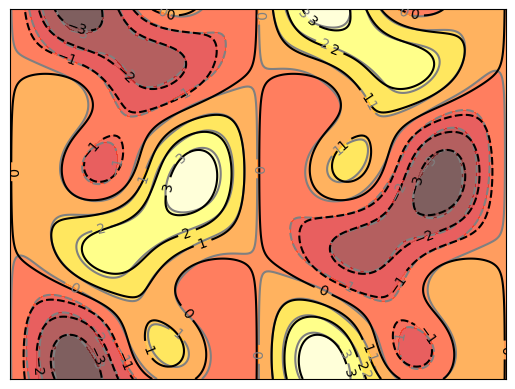

In [85]:
n=256
x = np.linspace(-np.pi, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, vneural_net_slice(X, Y, c,z, d=4), 8, alpha=.5, cmap=plt.cm.hot)
C = plt.contour(X, Y, vneural_net_slice(X,Y, c,z, d=4), 8, colors='grey')
plt.clabel(C, inline=1, fontsize=10)

plt.contourf(X, Y, vspin_func_slice(X, Y, a, d=4), 8, alpha=.25, cmap=plt.cm.hot)
C2 = plt.contour(X, Y, vspin_func_slice(X,Y, a, d=4), 8, colors='black')
plt.clabel(C2, inline=1, fontsize=10)

plt.xticks([])
plt.yticks([])

In [21]:
#Training
def train_SGD(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Stochastic Gradient Descent (SGD).

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    
    
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e2)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z.T)

        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        #c_next = c + neural_net_symm(z,(-spin_func(x, a)+neural_net_symm(x,c,z))/P, x).reshape(1,n)*Dt/n
        #z_next = z + ((neural_net_symm(x,c,z)-spin_func(x,a))*(exp_x*c).T)@x*Dt/n*P
        
        
        c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        z_next = z + (-(c.T*exp_x.T)@(spin_func(x, a).T*x)+1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)
        z = z_next
        c = c_next
        
        losses[step] = loss
        print('loss: {}'.format(loss))
                
    return c,z, losses

In [86]:
#Training with Nesterov accelerated gd
def nesterov_train_stochastic(d = 5, n = 16, Dt = 1e3, r = 3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Nesterov's accelerated gradient descent.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    c_change = c
    z_change = z
    
    
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z_change,a)
        exp = np.exp(-z_change@z_change.T)
        #sample points on sphere
        P = int(1e2)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z_change.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)    
        
        c1 = c
        z1 = z
        
        c_next = c_change + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        z_next = z + (-(c.T*exp_x.T)@(spin_func(x, a).T*x)+1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P
        #z_next = z_change + ((c_change.T*exp_x.T)@(spin_func(x, a).T*x)\
        #                     -1/n*(c_change.T*exp_x.T@((exp_x@c_change.T)*x)))*Dt/P
        z_next = z_next*np.sqrt(d)/(np.linalg.norm(z_next, axis = 1).reshape(n,1)+1e-100)
                
        
        c_change = c_next + 0.4*(c_next-c1)
        z_change = z_next + 0.4*(z_next-z1)
        z = z_next
        c = c_next
        
        
        losses[step] = loss
        print('loss: {}'.format(loss))
        z = z_next
        c = c_next
        
        
    return c,z, losses

In [64]:
#Training with Nesterov accelerated gd
def nesterov_train_deterministic(d = 5, n = 16, Dt = 1e3, r = 3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Nesterov's accelerated gradient descent.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    c_change = c
    z_change = z

    losses = np.zeros(steps)
    #update step
    for step in trange(1,steps+1):
        grad = grad_spin_func(z_change,a)
        exp = np.exp(-z_change@z_change.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)

        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)

        c1 = c
        z1 = z
        
        c_next = c_change + (spin_func(z_change, a)@exp-1/n*c@exp.T@exp)*Dt/P
        z_next = z_change + ((c_change.T*exp.T)@(spin_func(z_change, a).T*z_change)\
                      -1/n*(c_change.T*exp.T@((exp@c_change.T)*z_change)))*Dt/P
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)

        c_change = c_next + 0.1*(c_next-c1)
        z_change = z_next + 0.1*(z_next-z1)
        z = z_next
        c = c_next

        losses[step-1] = loss
        print('loss: {}'.format(loss))
            
    return c,z, losses

In [87]:
c,z, Nesterov_losses = nesterov_train_stochastic(d=4, n = 256, steps = int(1*1e5), Dt = 1e-5)

  0%|          | 0/100000 [00:00<?, ?it/s]

loss: 33179.34936546041
loss: 1228088.7182535978
loss: 2223983.0566129973
loss: 1958271.81707701
loss: 1349993.8351751098
loss: 1770329.0481330997
loss: 1361640.5429686205
loss: 567356.9380246948
loss: 521312.3939501053
loss: 468665.38488539495
loss: 384943.71822052007
loss: 240565.17595642098
loss: 130430.8189827606
loss: 126014.33816916311
loss: 102487.19100477046
loss: 79818.13345549245
loss: 62053.34839747438
loss: 36765.92701180317
loss: 35744.63805187624
loss: 36651.44997851009
loss: 26482.026346259037
loss: 11690.259578022673
loss: 17504.16105601063
loss: 15831.966146735458
loss: 7464.409373486232
loss: 6676.444489611129
loss: 11188.398147604643
loss: 4612.523537281701
loss: 4649.409387458462
loss: 6489.184271438343
loss: 7785.158757477534
loss: 7591.645282037717
loss: 7276.260734640109
loss: 3699.805279630891
loss: 3815.3149066703195
loss: 2601.1548818230217
loss: 3946.8350774576625
loss: 1369.3787365913167
loss: 3195.670960337283
loss: 1519.5755680700593
loss: 3220.16720734396

loss: 48.591557423576376
loss: 22.318542652364176
loss: 32.43845561386391
loss: 22.830854647685616
loss: 36.60181194898544
loss: 26.43927369188857
loss: 44.33046015955038
loss: 25.14217731957038
loss: 39.12546932540406
loss: 22.815393665783294
loss: 23.89896320915089
loss: 29.88738325497006
loss: 24.489315299006986
loss: 24.255859115676493
loss: 24.83133244304282
loss: 38.571930233069295
loss: 49.85685034951134
loss: 32.70010755341924
loss: 24.66867161285925
loss: 32.14400988586899
loss: 35.094870701924705
loss: 29.862927005797413
loss: 25.529369944885
loss: 36.35768511621921
loss: 35.1878489895714
loss: 32.62212315407068
loss: 26.955064165198927
loss: 32.294951165158594
loss: 30.87066772521373
loss: 32.87735162373697
loss: 22.507786112354832
loss: 29.429058203093117
loss: 31.475360426281245
loss: 27.789424808719232
loss: 30.434382775255607
loss: 42.42435979964892
loss: 31.309853801825376
loss: 32.81738926826604
loss: 26.15216828384314
loss: 24.593998160934053
loss: 35.18582423812888
l

loss: 14.900390252828952
loss: 20.41657449692551
loss: 16.046507958396134
loss: 21.630104362869734
loss: 15.35932668506716
loss: 15.224339002591643
loss: 13.851218136005114
loss: 21.46524946258013
loss: 16.59705363267377
loss: 23.79384545053962
loss: 14.017864451580277
loss: 17.460237245686994
loss: 15.414329075075564
loss: 15.20913861820653
loss: 18.224925392884284
loss: 13.499639924882972
loss: 20.058948715947572
loss: 15.19824822936797
loss: 23.235813403964777
loss: 17.972230662411178
loss: 17.854271741317294
loss: 17.830001995236653
loss: 20.46309223545937
loss: 16.007404883748833
loss: 17.515822662519525
loss: 15.453366045462005
loss: 16.189045335963453
loss: 18.98597874674191
loss: 21.327492434477612
loss: 21.847534962310213
loss: 17.838538130488455
loss: 19.862301692134384
loss: 17.74197862544709
loss: 14.4880026506616
loss: 14.910729324591532
loss: 16.438747190753155
loss: 16.69347285474794
loss: 22.37680059463263
loss: 16.8070991499628
loss: 15.881659492667097
loss: 15.3706837

loss: 11.113476267892981
loss: 10.5710145072536
loss: 10.40806100887051
loss: 10.123464515498375
loss: 11.526354809040553
loss: 10.994479054446822
loss: 9.94855854963932
loss: 10.697512985294379
loss: 9.796808680628978
loss: 10.728852746387634
loss: 11.555345944373848
loss: 10.940852645065833
loss: 10.531014132223603
loss: 9.741086114073447
loss: 9.817435749790166
loss: 10.594599705087107
loss: 9.309743903552476
loss: 7.768753742703703
loss: 10.769682844404942
loss: 10.050505834429494
loss: 8.433623572273182
loss: 10.583433995360167
loss: 10.605922532783518
loss: 11.776865213503893
loss: 10.444694874215166
loss: 10.030521346515462
loss: 9.835278003989696
loss: 11.154585727710682
loss: 11.869038861024073
loss: 10.110710226061464
loss: 9.797213869043215
loss: 10.270188755010665
loss: 10.494127477255958
loss: 10.028245546180848
loss: 9.988322981430288
loss: 11.348554039645576
loss: 11.360745682502866
loss: 10.96086664544467
loss: 8.922731913219932
loss: 11.346828484178786
loss: 8.74960504

loss: 8.100829534463752
loss: 7.543100874287758
loss: 7.373605967318041
loss: 7.544725253529675
loss: 8.032441735170263
loss: 7.925706723185479
loss: 7.079810039587955
loss: 7.886268941457998
loss: 7.164847196826007
loss: 8.138044722517535
loss: 7.632216404997959
loss: 6.62218654122602
loss: 7.699139169764394
loss: 7.395879711711589
loss: 8.161045205443346
loss: 7.648270977799362
loss: 7.058224455370945
loss: 8.257917139751807
loss: 7.13545165743328
loss: 7.564093546077322
loss: 6.824768263731456
loss: 7.696866148525357
loss: 7.228581318158946
loss: 7.949266084516097
loss: 6.471197790943088
loss: 7.688635469998296
loss: 6.766089499604418
loss: 6.8561261444419666
loss: 7.82154456053474
loss: 8.066859624490391
loss: 6.241326985233847
loss: 8.12040646534473
loss: 6.98651322064829
loss: 6.8268162487644135
loss: 6.885471476558863
loss: 6.993951207861596
loss: 6.575764611911311
loss: 6.886821891896656
loss: 6.399875052180845
loss: 6.821986845255342
loss: 6.608006887709618
loss: 7.85258869757

loss: 6.0277170684682755
loss: 6.173437716468177
loss: 5.4295965606687
loss: 5.519396624328703
loss: 5.535303869685477
loss: 6.138270201877125
loss: 6.4055791847680394
loss: 5.493809112665396
loss: 5.188439555963762
loss: 5.819675808515537
loss: 4.8902981560722445
loss: 5.850609870958765
loss: 4.669365004643757
loss: 6.9916704708096145
loss: 5.4652701414040905
loss: 4.849892303497194
loss: 6.0771032296903185
loss: 5.284916726621638
loss: 5.039153905495323
loss: 5.168854350754014
loss: 5.551914398328594
loss: 5.627559793557571
loss: 6.129500623313109
loss: 5.775739837405432
loss: 5.1032871893980705
loss: 5.344221890145754
loss: 5.273760605345306
loss: 5.554482474704157
loss: 5.55741030009587
loss: 4.903073060494893
loss: 5.472233653856616
loss: 6.04637467595552
loss: 5.807337795075827
loss: 5.373631484314878
loss: 5.50385133794831
loss: 5.444445001590185
loss: 5.412582587780314
loss: 5.582283437145184
loss: 5.710032376176823
loss: 4.883663230512727
loss: 6.266884866137757
loss: 5.818660

loss: 4.644395069414283
loss: 4.3521560401985555
loss: 4.235590189154338
loss: 4.314906796309069
loss: 4.349645798135826
loss: 4.486828847905792
loss: 4.762515685109588
loss: 3.9569617005805076
loss: 4.729238651065372
loss: 4.219033718995857
loss: 4.351494516756063
loss: 4.6910114861751895
loss: 4.381990207778111
loss: 4.002587451022722
loss: 4.811570612604241
loss: 4.668341815547461
loss: 4.539294068614824
loss: 4.0480618345721275
loss: 4.368286470053047
loss: 4.425985961058731
loss: 4.521686397563358
loss: 4.217288794637638
loss: 4.33612200973524
loss: 3.941164276840074
loss: 4.134530222664593
loss: 4.267447957745991
loss: 4.569834292443883
loss: 4.553729004645648
loss: 4.340270581121207
loss: 4.003013785993933
loss: 3.9239937093488675
loss: 4.556005985934869
loss: 4.50704589590494
loss: 4.071081071132138
loss: 3.8206530540926993
loss: 4.698499703226932
loss: 3.915441187403914
loss: 4.312143340330875
loss: 4.423054844448023
loss: 3.9393945813502973
loss: 4.924220016022563
loss: 3.761

loss: 3.2491925500222774
loss: 3.7473846961334583
loss: 3.4509377547588334
loss: 3.4739139507994383
loss: 3.171460590646445
loss: 3.3401874387383517
loss: 3.3338505779064813
loss: 3.2850186206994403
loss: 3.142842412986219
loss: 2.816587775571167
loss: 3.580346472531492
loss: 3.8861252339665593
loss: 3.335128489747546
loss: 3.212316453980837
loss: 3.2096724013706974
loss: 2.7731239582286413
loss: 3.3489834160804186
loss: 3.326490312933655
loss: 3.5744830160954235
loss: 3.440599336753207
loss: 3.550465119171459
loss: 3.28882697447125
loss: 2.899629333139476
loss: 3.211919964996882
loss: 2.7730582012148717
loss: 3.3829753364062807
loss: 3.465859638265627
loss: 3.0072726706377715
loss: 3.058451150312544
loss: 3.4963139186083447
loss: 3.340428119500437
loss: 3.2152649833054356
loss: 3.2516905232017503
loss: 3.399257568840154
loss: 3.306966579356382
loss: 3.506191599203456
loss: 2.7659110031143173
loss: 3.134684425956266
loss: 3.354329603474277
loss: 3.49886590386544
loss: 3.484427059889718

loss: 2.610757890452604
loss: 3.0162532956205585
loss: 2.5871643889923672
loss: 2.717275277560556
loss: 2.9373710367914527
loss: 2.6958867030388234
loss: 2.6649700096669977
loss: 2.507260669174634
loss: 2.8644579497826648
loss: 2.785524466480062
loss: 2.902233760273781
loss: 2.5471739687751143
loss: 2.826113953764213
loss: 2.6158903059085286
loss: 2.5088474999351327
loss: 2.757894637288831
loss: 2.1083040231082255
loss: 2.93392423736276
loss: 2.959711268331311
loss: 2.5223913459741896
loss: 2.6873106815468053
loss: 2.7918932939465453
loss: 2.2974485052840277
loss: 2.4918320695446683
loss: 2.640991340060537
loss: 2.4732011561498224
loss: 2.506799941083794
loss: 2.423461317424
loss: 2.7578160034655923
loss: 2.5976668237923666
loss: 2.38213954352002
loss: 2.3117417749808187
loss: 2.8946466398505435
loss: 2.4585223301758456
loss: 2.3913638447509182
loss: 2.810061348707013
loss: 2.7967268673974086
loss: 2.542677530592091
loss: 2.357490622222031
loss: 2.8268723357163505
loss: 2.4773757512600

loss: 1.7945282985943518
loss: 2.165003136320582
loss: 1.9476298132410181
loss: 2.1611946693891646
loss: 1.9759542270946238
loss: 2.083667666343163
loss: 2.3488504606066387
loss: 1.9631983487668832
loss: 1.9814467350087068
loss: 2.0249345046309712
loss: 1.9690405043867887
loss: 1.8116767320025593
loss: 1.859675615015321
loss: 1.9070780525997038
loss: 2.0997937639185587
loss: 1.9855660196037759
loss: 1.9305782443543074
loss: 2.0209451483148313
loss: 2.098929890804612
loss: 1.882843795034255
loss: 2.0874132896134254
loss: 2.171055781440539
loss: 1.9586820461893664
loss: 2.200176644798057
loss: 1.7751500327979994
loss: 2.015772013217141
loss: 1.8250048220784114
loss: 2.03295675269632
loss: 2.0955104852465545
loss: 2.03396843981673
loss: 2.0460039814228854
loss: 2.0229239555401244
loss: 2.057016635804644
loss: 1.7919456107105167
loss: 1.9264110011283448
loss: 2.0386719426537607
loss: 2.0013952401556185
loss: 1.9412522327137745
loss: 2.2125328731588594
loss: 1.735500281654752
loss: 1.585831

loss: 1.4831259697741905
loss: 1.5379982495607798
loss: 1.5155899587928163
loss: 1.595611138113759
loss: 1.7090094937471716
loss: 1.456487659775886
loss: 1.60308856513019
loss: 1.657647888690006
loss: 1.6577472129639557
loss: 1.5285842290432388
loss: 1.441746894065719
loss: 1.5735453156204866
loss: 1.8244326909838717
loss: 1.342703458832436
loss: 1.6449744997645488
loss: 1.5892384633298802
loss: 1.4329335320163525
loss: 1.7255052616509097
loss: 1.6469740870430607
loss: 1.5364519338661247
loss: 1.7152803651106845
loss: 1.5027858144805202
loss: 1.5995645882285912
loss: 1.49998901183497
loss: 1.5527428227413709
loss: 1.449949363092429
loss: 1.5356951631451847
loss: 1.3549357260855677
loss: 1.5656204618399772
loss: 1.6479114759929105
loss: 1.4524181750742984
loss: 1.5885813383435474
loss: 1.5936824997192296
loss: 1.521156247464028
loss: 1.6723587301619984
loss: 1.5323150315461107
loss: 1.6283065846857796
loss: 1.6555850499262252
loss: 1.7509794774982914
loss: 1.4907703289245657
loss: 1.236

loss: 1.2296282167773445
loss: 1.0477172000307777
loss: 1.1452580249750248
loss: 1.2820197742303412
loss: 1.2316987984605072
loss: 1.3673489931807723
loss: 1.1345498644095513
loss: 1.262655284957521
loss: 1.043605726868156
loss: 1.0978191878191985
loss: 1.2735099985350802
loss: 1.1872880831607036
loss: 1.1961883009066592
loss: 1.3383961871531307
loss: 1.3543210215486858
loss: 1.3717613149250667
loss: 1.0902986435422592
loss: 1.255418530164404
loss: 1.1968562591729166
loss: 1.2959006049014843
loss: 1.1773172780957457
loss: 1.3227984158171338
loss: 1.1497557882019296
loss: 1.302756101200861
loss: 1.266729236973265
loss: 1.3516065144303129
loss: 1.3074012265734332
loss: 1.1506965895869876
loss: 1.317829879506412
loss: 1.2756059167992684
loss: 1.1479213580083134
loss: 1.0471584037127994
loss: 1.5245809815396822
loss: 1.1707423187108439
loss: 1.1435115474950361
loss: 0.974555254907796
loss: 1.2110002904337818
loss: 1.4619317754056007
loss: 1.238924556534411
loss: 1.2710063464190848
loss: 1.

loss: 1.0672143402631875
loss: 0.9805986786671025
loss: 1.1404673722712233
loss: 1.0334705680961924
loss: 1.1183561973720677
loss: 0.9134143632154265
loss: 1.0783532151105442
loss: 0.9647936792135168
loss: 0.90563644070686
loss: 0.9140462722525569
loss: 1.0443701304659367
loss: 1.2125198810088125
loss: 1.0112056484181342
loss: 1.0568863138888431
loss: 0.8023380050481788
loss: 0.9080309756259214
loss: 1.1860525719846493
loss: 0.9259661926291316
loss: 1.0034638459631064
loss: 1.216319360624975
loss: 1.0985869015074108
loss: 0.9537247759041988
loss: 1.0105445821446728
loss: 0.947454065566347
loss: 0.8234071968772483
loss: 1.0582965809714961
loss: 1.0968008638907427
loss: 0.9497083682855876
loss: 0.8973043559264323
loss: 0.8849779757737629
loss: 1.0585181772540389
loss: 1.0524521259485202
loss: 0.8642250458598555
loss: 0.9584315860498309
loss: 0.9371625457392767
loss: 1.0594909714006244
loss: 1.078906194365198
loss: 0.9954730064453614
loss: 1.0121403323502678
loss: 0.9710288108418069
loss:

loss: 0.7188436259352554
loss: 0.8430664170349683
loss: 0.8582771671693014
loss: 0.8502670974470388
loss: 0.5648802276121685
loss: 0.921782907204793
loss: 0.9745222493331259
loss: 0.9352829542681208
loss: 0.8560159689790439
loss: 0.8081776558066006
loss: 0.6999551515765894
loss: 0.6801788161289278
loss: 0.702491701967467
loss: 0.7734640143872906
loss: 0.8053027761102746
loss: 0.8737789225554939
loss: 0.9324902331170908
loss: 0.945486172846734
loss: 0.8370894314364777
loss: 1.007227458704228
loss: 0.9160451845138539
loss: 0.7442633264164303
loss: 0.912076699523785
loss: 0.8258504668600025
loss: 0.7927288985838373
loss: 0.7950840212296807
loss: 0.8519732205786588
loss: 0.8493899292512778
loss: 0.722131280877631
loss: 0.9084664388549623
loss: 0.7461566246981955
loss: 0.688864160097472
loss: 0.9296792313680874
loss: 0.6993671941475254
loss: 0.9219320775269817
loss: 0.8680429529829082
loss: 0.7349514794113087
loss: 0.8908435890440181
loss: 0.8664414318798416
loss: 0.8541711751893593
loss: 0

loss: 0.7425018514875817
loss: 0.625442059170525
loss: 0.6867816982875884
loss: 0.539609925561847
loss: 0.554222901426951
loss: 0.6488456682528776
loss: 0.6711383403718032
loss: 0.6728040540806898
loss: 0.7157911114518307
loss: 0.7580249775656229
loss: 0.6442517574655616
loss: 0.7880603450527021
loss: 0.6926896137174358
loss: 0.6314874593010567
loss: 0.5255822067893665
loss: 0.6881751519500904
loss: 0.6193060572018652
loss: 0.6187311739634759
loss: 0.7733334975268885
loss: 0.6720882280198873
loss: 0.7034692494790087
loss: 0.5711998250563486
loss: 0.5921520404224102
loss: 0.6510182022811167
loss: 0.7541767448899838
loss: 0.6876029459866136
loss: 0.6621736288541424
loss: 0.6355522276504029
loss: 0.5855534239234305
loss: 0.6298003613311012
loss: 0.6159676511015567
loss: 0.6123547369307701
loss: 0.7768594192901037
loss: 0.716129254994301
loss: 0.7619478548361616
loss: 0.5547224283046472
loss: 0.6417014932918502
loss: 0.5908952801471908
loss: 0.7248120199175162
loss: 0.6905587196861351
loss

loss: 0.6553728937507405
loss: 0.5500918667544983
loss: 0.47619941825782236
loss: 0.471957908375947
loss: 0.5770784818611233
loss: 0.5437847645736765
loss: 0.550072240036726
loss: 0.5259161821288073
loss: 0.46729443211938415
loss: 0.6957782821252798
loss: 0.5122444499659466
loss: 0.5374704984266735
loss: 0.36911843794820265
loss: 0.6025956216197246
loss: 0.4557493913920675
loss: 0.7285057759980846
loss: 0.5606862542928592
loss: 0.4938018563593785
loss: 0.4405216655564357
loss: 0.5837154705844747
loss: 0.5458530873262037
loss: 0.49416786928527934
loss: 0.4541492605866804
loss: 0.6449947780677722
loss: 0.4286153707711264
loss: 0.6200998854091702
loss: 0.4989624048778745
loss: 0.5557978724781463
loss: 0.6479872653890935
loss: 0.602755903276497
loss: 0.4709423749188991
loss: 0.5485706478672179
loss: 0.49368585255040914
loss: 0.6681180534820409
loss: 0.5897511624027265
loss: 0.4980574473974134
loss: 0.483837986063607
loss: 0.5684584400287802
loss: 0.45718669137195017
loss: 0.403742240074850

loss: 0.37115287635743227
loss: 0.435649367957183
loss: 0.43659081708006764
loss: 0.5053051460199302
loss: 0.39521379830566816
loss: 0.4913047087275098
loss: 0.5307959762295312
loss: 0.5076736992868376
loss: 0.4282126577072256
loss: 0.44985525878207544
loss: 0.3879560276544239
loss: 0.4493132259339611
loss: 0.400952374335376
loss: 0.39588701488155664
loss: 0.3959174226291025
loss: 0.36459212692584814
loss: 0.4016226941201795
loss: 0.5073873171265121
loss: 0.4883399791640724
loss: 0.5249984484377175
loss: 0.5303439300462535
loss: 0.4406598571821373
loss: 0.4621074548052141
loss: 0.4497739598275312
loss: 0.4656691869150358
loss: 0.4659111821903674
loss: 0.4729756592223424
loss: 0.4597041870336319
loss: 0.4505076924147462
loss: 0.42822075086119826
loss: 0.3826962792003328
loss: 0.37905683551429825
loss: 0.38951782195711165
loss: 0.4144424259921202
loss: 0.47632269639615576
loss: 0.4349505984286934
loss: 0.44199133407547136
loss: 0.5320886694026222
loss: 0.4398772223923782
loss: 0.40721010

loss: 0.5071669468880153
loss: 0.41809424879965584
loss: 0.39213038384072335
loss: 0.4410622366638311
loss: 0.3430148492604019
loss: 0.4908699756991139
loss: 0.36835811038486804
loss: 0.4086665469689668
loss: 0.40556366090811297
loss: 0.3757660974717843
loss: 0.33780506256814574
loss: 0.3887541563309974
loss: 0.3579550055408627
loss: 0.3044695630611256
loss: 0.3251381820681264
loss: 0.40554546508140144
loss: 0.38911355824819005
loss: 0.4580698067051103
loss: 0.325932265251122
loss: 0.40883680585336174
loss: 0.42698775274006434
loss: 0.3806226664561833
loss: 0.36988878133609754
loss: 0.2973358281154622
loss: 0.3713113109583175
loss: 0.3941867523074904
loss: 0.4508847887220783
loss: 0.38762257431380504
loss: 0.31677940822845424
loss: 0.4393234683360494
loss: 0.3828204890753082
loss: 0.3806745721604574
loss: 0.3928100352876027
loss: 0.3129015899114942
loss: 0.3982670533875092
loss: 0.3554971055066297
loss: 0.41903481274179627
loss: 0.3711530795157008
loss: 0.3378032051170728
loss: 0.33551

loss: 0.3547957602617946
loss: 0.30775001238688116
loss: 0.3458042895482961
loss: 0.3806386991954899
loss: 0.33989245036041593
loss: 0.30318177680902414
loss: 0.365171251852475
loss: 0.38786688214124565
loss: 0.30771052498852375
loss: 0.3773440279493452
loss: 0.3532626910366999
loss: 0.327813847319932
loss: 0.4084373133519459
loss: 0.40786483404278173
loss: 0.31960536625822433
loss: 0.35529687760687145
loss: 0.3605908983254128
loss: 0.38136841648495456
loss: 0.4211404724563251
loss: 0.33557888348491505
loss: 0.36412918450910103
loss: 0.2806664371173014
loss: 0.3060894839484555
loss: 0.27188556324757845
loss: 0.37992157605301946
loss: 0.3375369945384943
loss: 0.35375788411490755
loss: 0.36796371993116006
loss: 0.28628501565114417
loss: 0.3605670072680515
loss: 0.3586318336387547
loss: 0.46803773731381254
loss: 0.36614560558660003
loss: 0.362881039160859
loss: 0.3374691233265406
loss: 0.32691404835635446
loss: 0.37600982539493866
loss: 0.364358663487642
loss: 0.32536997012100594
loss: 0.

loss: 0.30429345968877386
loss: 0.3976530246228018
loss: 0.30220347221219496
loss: 0.3284533553138068
loss: 0.3208922504442056
loss: 0.27122902329790927
loss: 0.3304651980825428
loss: 0.3320894632476998
loss: 0.3829052462464768
loss: 0.3316749234199506
loss: 0.2879395758313648
loss: 0.37133120280620896
loss: 0.3210635369418325
loss: 0.33160985274141963
loss: 0.30487268198249207
loss: 0.2749345579280563
loss: 0.30293742218697167
loss: 0.32823212575445093
loss: 0.31153727685023586
loss: 0.35383584319616723
loss: 0.33581314092957476
loss: 0.35014366320349877
loss: 0.3371390548689876
loss: 0.280017141745985
loss: 0.3595849164624154
loss: 0.3118703376053114
loss: 0.3234616561399971
loss: 0.2651134327646586
loss: 0.3000812884384554
loss: 0.32605412895711183
loss: 0.2923194912989415
loss: 0.3303770204561208
loss: 0.3007043200370298
loss: 0.3174723100641636
loss: 0.310064608871295
loss: 0.3239076454576738
loss: 0.24064059046070166
loss: 0.3067520542694416
loss: 0.3133998340453084
loss: 0.23296

loss: 0.27303965389501866
loss: 0.27997020822218194
loss: 0.2512300754365254
loss: 0.2942239428212485
loss: 0.2945985963995338
loss: 0.284424882196655
loss: 0.261843082437747
loss: 0.24170950528570306
loss: 0.34952019919186567
loss: 0.2656245449728618
loss: 0.281231736902245
loss: 0.31955410993620154
loss: 0.2724269203831979
loss: 0.2837471859399297
loss: 0.35727030842460694
loss: 0.30065929617856196
loss: 0.26270346579625126
loss: 0.2703287304825382
loss: 0.21807467541281333
loss: 0.2574731760650158
loss: 0.29854166498658996
loss: 0.2480418123247789
loss: 0.275662081674432
loss: 0.3943964587890785
loss: 0.30373545845914346
loss: 0.33378457011179
loss: 0.3257590660950011
loss: 0.24835239291070746
loss: 0.3361080119713368
loss: 0.2894751867166569
loss: 0.24408461078747895
loss: 0.29337899821730345
loss: 0.24672847178202445
loss: 0.3498862499151882
loss: 0.2563628411748229
loss: 0.22175563153330216
loss: 0.24192399325311123
loss: 0.33668878473292757
loss: 0.3406561289207948
loss: 0.25797

loss: 0.27594546635776707
loss: 0.21699029384717883
loss: 0.27058543071946045
loss: 0.23207528879533743
loss: 0.3219634498053525
loss: 0.2892864847538823
loss: 0.2869178970071327
loss: 0.2542646110187038
loss: 0.23943991694005626
loss: 0.20445237091909432
loss: 0.2720681577582924
loss: 0.2596663481267302
loss: 0.1927830914786995
loss: 0.20929324793047813
loss: 0.2721144850273118
loss: 0.25190241056229185
loss: 0.23565439993293244
loss: 0.28407153767139715
loss: 0.24709919109621611
loss: 0.2442438143604475
loss: 0.3136632550302217
loss: 0.2889488161963527
loss: 0.22043486228530743
loss: 0.298828656650982
loss: 0.2584058701967417
loss: 0.20299065678902042
loss: 0.22176972746438436
loss: 0.3071885130193146
loss: 0.24934797583634316
loss: 0.2308318494401946
loss: 0.2948444937559179
loss: 0.24920892764413888
loss: 0.255213384734994
loss: 0.28647610575140847
loss: 0.26933883121338537
loss: 0.2303092969677258
loss: 0.29113860706889155
loss: 0.24243570197474523
loss: 0.2735383577661248
loss: 0

loss: 0.2525133414279584
loss: 0.2612599530160067
loss: 0.2494442482300754
loss: 0.1823680412934858
loss: 0.1953733537339585
loss: 0.2675727240072768
loss: 0.23171629213455774
loss: 0.23190201775788488
loss: 0.3389680385676252
loss: 0.24752218309296137
loss: 0.27324143790450106
loss: 0.22307342734050906
loss: 0.24147525753189478
loss: 0.23923301465209101
loss: 0.2257194678527977
loss: 0.24213704047733262
loss: 0.2796187648276989
loss: 0.16929951595633297
loss: 0.16912722917246634
loss: 0.28279717332408133
loss: 0.22783664114413946
loss: 0.21063758440283548
loss: 0.2771098441850197
loss: 0.22675102702798647
loss: 0.2257356341406674
loss: 0.22499998854902775
loss: 0.20490506668086703
loss: 0.2129636386572902
loss: 0.19655331425516348
loss: 0.25467634042096615
loss: 0.1841201542887684
loss: 0.33527366187948
loss: 0.2620864483679329
loss: 0.25055831607601353
loss: 0.21513560862526027
loss: 0.2330572383109347
loss: 0.255270387045349
loss: 0.28422448775097275
loss: 0.22362936070831974
loss: 

loss: 0.1326652528385306
loss: 0.24642838555001853
loss: 0.25802406669466094
loss: 0.27941646723115204
loss: 0.13889340094073507
loss: 0.19819666337989328
loss: 0.16511813205746426
loss: 0.16398877852907698
loss: 0.26198292746699986
loss: 0.20999845206778522
loss: 0.16937876884356956
loss: 0.18730324378498078
loss: 0.1713619951241593
loss: 0.20028336778655592
loss: 0.2784351933936721
loss: 0.19879668875327008
loss: 0.2551699662800751
loss: 0.18089860768411423
loss: 0.2490120418028651
loss: 0.21958763556757555
loss: 0.1729399318726075
loss: 0.21103095654855278
loss: 0.2313119983665637
loss: 0.19730792493895652
loss: 0.21781667133228919
loss: 0.25498385091170495
loss: 0.19586899954896642
loss: 0.16819767355067178
loss: 0.25895360232542475
loss: 0.23143218942634067
loss: 0.26375171545436976
loss: 0.26009907682975164
loss: 0.21473642300998086
loss: 0.2580558211618384
loss: 0.25047789375490925
loss: 0.1739090991547882
loss: 0.21826479479969385
loss: 0.2115935876174462
loss: 0.20572623522094

loss: 0.19869412103312672
loss: 0.21661432143201456
loss: 0.23957422775657458
loss: 0.17931920709982016
loss: 0.18225272331796966
loss: 0.20017981363811146
loss: 0.24485632743769567
loss: 0.15751689975762562
loss: 0.17804122345932807
loss: 0.2490381784330704
loss: 0.22339241981768002
loss: 0.19402420450791008
loss: 0.22214194730447112
loss: 0.19017599208424446
loss: 0.2044663003472946
loss: 0.136547054504088
loss: 0.2318900919140338
loss: 0.23050966434668083
loss: 0.18690815030618635
loss: 0.1972771176178059
loss: 0.17324599564377674
loss: 0.20845516447985793
loss: 0.175323644282104
loss: 0.19993466322064002
loss: 0.22085425716524887
loss: 0.22565625953939208
loss: 0.23565544271511457
loss: 0.18876228128011077
loss: 0.188623980313204
loss: 0.1607750007433631
loss: 0.19457934439922175
loss: 0.2054312520774994
loss: 0.21072741821183258
loss: 0.2268033478097775
loss: 0.2410069776048841
loss: 0.21110249633112446
loss: 0.16418593609331972
loss: 0.22937895954247975
loss: 0.21048430052027797


loss: 0.21553728927612867
loss: 0.17703968885998542
loss: 0.2138071928548183
loss: 0.19082899559429298
loss: 0.17390681665597923
loss: 0.17095711265829963
loss: 0.21906907187531238
loss: 0.16857099464355227
loss: 0.19849149904977736
loss: 0.18859973073276592
loss: 0.1710717766539591
loss: 0.20487864348221074
loss: 0.21184654805292208
loss: 0.1714643167082645
loss: 0.18718913117413755
loss: 0.17946953006725558
loss: 0.1373207904035335
loss: 0.10754998743441663
loss: 0.2540163869897691
loss: 0.1765054727301466
loss: 0.20081492451305863
loss: 0.17897435759089755
loss: 0.1625856370661763
loss: 0.2129651945307018
loss: 0.18479474441000263
loss: 0.15794696985027698
loss: 0.14528630031185696
loss: 0.1532995034496891
loss: 0.22259293426046145
loss: 0.23602062698439544
loss: 0.20545254500881083
loss: 0.2040884493854433
loss: 0.1928131114603727
loss: 0.1653330346008249
loss: 0.19173251849923417
loss: 0.20463122267824801
loss: 0.18881247134594684
loss: 0.24274392159904395
loss: 0.1364192559079972

loss: 0.1410386378231104
loss: 0.23971913722583818
loss: 0.2096133592033499
loss: 0.17882132199800505
loss: 0.1936212693212163
loss: 0.14472849001630578
loss: 0.1915057405011558
loss: 0.22505598832556636
loss: 0.20129485294720645
loss: 0.1748588356954232
loss: 0.20396887204367833
loss: 0.12254040878122305
loss: 0.15989498814933412
loss: 0.18538346189864416
loss: 0.17725316545193992
loss: 0.14647700203228056
loss: 0.215687942800475
loss: 0.17847710258528504
loss: 0.14511409832297117
loss: 0.1807251365966851
loss: 0.17006279777490388
loss: 0.1460257939711601
loss: 0.20009977112761757
loss: 0.16655322681210977
loss: 0.19651011558837672
loss: 0.202698492936222
loss: 0.18294398104615342
loss: 0.15181795527256656
loss: 0.21801820965671254
loss: 0.14518815759130604
loss: 0.20952041373614352
loss: 0.17809802969912691
loss: 0.19117061039892294
loss: 0.2351398163658215
loss: 0.20257051241261514
loss: 0.15715789701063762
loss: 0.17122391264166212
loss: 0.18466010754661416
loss: 0.1528292679079163

loss: 0.17050773448176648
loss: 0.16312535111061696
loss: 0.16786543754528782
loss: 0.16275496964638106
loss: 0.15745044333347705
loss: 0.1216192514292766
loss: 0.1916450737429492
loss: 0.17399924808052888
loss: 0.15507405377521588
loss: 0.2095932991576953
loss: 0.18381208965353465
loss: 0.11869630056858509
loss: 0.11498141439068459
loss: 0.16946865808947634
loss: 0.14195085794299428
loss: 0.1597648695807246
loss: 0.1498605956309646
loss: 0.11850269024038519
loss: 0.1805358797771567
loss: 0.15700386646075337
loss: 0.1316941185990261
loss: 0.14332680613334184
loss: 0.13106827179155686
loss: 0.1426430358317532
loss: 0.1827133359074332
loss: 0.17155016259690062
loss: 0.12016274171221325
loss: 0.1543888052794632
loss: 0.1869458670811019
loss: 0.17823454325884203
loss: 0.15093037531473236
loss: 0.17732340550806
loss: 0.1815749007167233
loss: 0.18068723619870358
loss: 0.16942012241873156
loss: 0.1675464535569915
loss: 0.19460703570908952
loss: 0.1946934640378327
loss: 0.16156325137238306
los

loss: 0.1278101884073535
loss: 0.16382785686680645
loss: 0.14349181978844505
loss: 0.22405758100566797
loss: 0.13974190659617533
loss: 0.16851331170730063
loss: 0.16264681168099543
loss: 0.18231640531783758
loss: 0.14036943434012325
loss: 0.16522679889537414
loss: 0.15340221504014523
loss: 0.21577617427107235
loss: 0.12417034586567942
loss: 0.15705777558105663
loss: 0.16286395512365776
loss: 0.17110433581973844
loss: 0.13277472524083178
loss: 0.1808344405770807
loss: 0.17435160048585316
loss: 0.1794317315426911
loss: 0.14452084334718396
loss: 0.15094370695188594
loss: 0.16333969878091636
loss: 0.1657899931394893
loss: 0.1425649100709217
loss: 0.12001199904747065
loss: 0.1493717417915513
loss: 0.13313675969374894
loss: 0.16503290779601543
loss: 0.1552572067006437
loss: 0.15397365451928907
loss: 0.15532543085556622
loss: 0.13561910760448487
loss: 0.12884251569668284
loss: 0.18097349230108065
loss: 0.1598600424437755
loss: 0.16456202320760316
loss: 0.16549077412058266
loss: 0.137309661350

loss: 0.15807853872423697
loss: 0.17581458635831357
loss: 0.14678095301103217
loss: 0.15868846049262147
loss: 0.18807510253499657
loss: 0.15122124709337773
loss: 0.16362046001909838
loss: 0.16388483337371362
loss: 0.22294806880972223
loss: 0.2133923681532164
loss: 0.12392364342907378
loss: 0.1360958000273461
loss: 0.1530804663683046
loss: 0.17866736920693785
loss: 0.10415419194411
loss: 0.1255775366367141
loss: 0.15030804966790018
loss: 0.14532630357997167
loss: 0.18180432157157927
loss: 0.13318614945391316
loss: 0.2040142290510958
loss: 0.14132399657648395
loss: 0.2051057020547136
loss: 0.16446584921579277
loss: 0.21173390526051708
loss: 0.12989180244472132
loss: 0.1775901258548788
loss: 0.16724931522951134
loss: 0.13280575532373898
loss: 0.16633771528601918
loss: 0.1405736191394512
loss: 0.15287143970758388
loss: 0.15728672671097693
loss: 0.15075927289699564
loss: 0.19280533615208778
loss: 0.13314422302420012
loss: 0.13219515370267898
loss: 0.13360128948370306
loss: 0.173535363529152

loss: 0.13904335233565476
loss: 0.17968853499618853
loss: 0.15728154349709145
loss: 0.20028351785341275
loss: 0.1084874159138553
loss: 0.21567757741952234
loss: 0.13872430256600293
loss: 0.14856937934440417
loss: 0.16201313086775204
loss: 0.13642198020015248
loss: 0.1694744085040301
loss: 0.12798118136290118
loss: 0.11946778234514685
loss: 0.13433466662025575
loss: 0.13676876438823884
loss: 0.13548905208825165
loss: 0.15607803476034127
loss: 0.16865120812276374
loss: 0.15514306164449063
loss: 0.14406087499915243
loss: 0.14972927262793118
loss: 0.1236837870291425
loss: 0.134410737790662
loss: 0.13939652622106002
loss: 0.1251479353440662
loss: 0.16559892297644693
loss: 0.16938189530251485
loss: 0.20038468240424487
loss: 0.1843295961375496
loss: 0.12876228480822832
loss: 0.13701324815068142
loss: 0.12079903257160927
loss: 0.14515609766359533
loss: 0.13536625681187803
loss: 0.14884920653324518
loss: 0.10846734780820556
loss: 0.15311569556339946
loss: 0.17107027525126728
loss: 0.16326216159

loss: 0.15502924570287133
loss: 0.10207110760263309
loss: 0.11485323005206176
loss: 0.11958589458225641
loss: 0.1662120187567896
loss: 0.1835669192476302
loss: 0.1407089245633145
loss: 0.15987340566524758
loss: 0.115997822019123
loss: 0.13666883320070064
loss: 0.152684537375273
loss: 0.15679491845609334
loss: 0.12977675111286818
loss: 0.1341285084197596
loss: 0.12985956157130865
loss: 0.11471384814968792
loss: 0.14997723130167454
loss: 0.13334052434754387
loss: 0.1655541936480796
loss: 0.15002547014863307
loss: 0.10879793999356786
loss: 0.1171648111300043
loss: 0.13082306345475994
loss: 0.13710705694507339
loss: 0.16273903072424567
loss: 0.13779009445162138
loss: 0.13571622442926756
loss: 0.12296822406987971
loss: 0.14230643297848827
loss: 0.12872581871079236
loss: 0.15018837444610061
loss: 0.18032611413826022
loss: 0.16305376106604502
loss: 0.1390290537890624
loss: 0.15476454995619388
loss: 0.1371631586227919
loss: 0.14182647003268176
loss: 0.14395436251794397
loss: 0.1660847031735838

loss: 0.184460940402008
loss: 0.16469740664893756
loss: 0.11020919823017644
loss: 0.1313326085943617
loss: 0.12101808229082983
loss: 0.1463236604194345
loss: 0.11763022446464025
loss: 0.12842023065367833
loss: 0.13679932036493678
loss: 0.13261927647857713
loss: 0.1263212987027868
loss: 0.14229494419018876
loss: 0.14270579267425176
loss: 0.13711012562507865
loss: 0.12596151642853004
loss: 0.06728412478663802
loss: 0.10249073532755736
loss: 0.12798474783466948
loss: 0.11387703916264952
loss: 0.12292032676859936
loss: 0.13335630419802325
loss: 0.1217633807428637
loss: 0.1522404409835919
loss: 0.1692592206439919
loss: 0.10762555465686922
loss: 0.11853135510597086
loss: 0.16640756835458193
loss: 0.13559748475226338
loss: 0.15635846836603445
loss: 0.1239178391095199
loss: 0.16887028444619706
loss: 0.13044274339607942
loss: 0.13362197698373712
loss: 0.12498711727613135
loss: 0.14020530432588782
loss: 0.09240897120901578
loss: 0.17852675385336642
loss: 0.12471296395685058
loss: 0.1676203126228

loss: 0.18062978591174947
loss: 0.1359113548267479
loss: 0.15059002379873962
loss: 0.13746801043515913
loss: 0.1007587432338934
loss: 0.14254451896486806
loss: 0.12137436614161251
loss: 0.12172365616564068
loss: 0.16879665819859946
loss: 0.13895497458491957
loss: 0.1158527342339089
loss: 0.13622193137156394
loss: 0.12706209603937882
loss: 0.10197859529327179
loss: 0.10880732975175389
loss: 0.12780876348829473
loss: 0.14938175556203148
loss: 0.13455315627284153
loss: 0.156127382317217
loss: 0.14504629858646367
loss: 0.1347217189657146
loss: 0.09074041072534893
loss: 0.13855207114281912
loss: 0.12261725032829876
loss: 0.1617682185563324
loss: 0.10276185940697222
loss: 0.13450844024802683
loss: 0.14676561843072292
loss: 0.16491532338763168
loss: 0.16396043892131287
loss: 0.09117202963280352
loss: 0.09988260425022709
loss: 0.15553325743054472
loss: 0.14259670739355318
loss: 0.1672219823802437
loss: 0.11933615005781258
loss: 0.1664437194869829
loss: 0.12080064749309852
loss: 0.1305067784006

loss: 0.10848077309729953
loss: 0.09547622995932141
loss: 0.12586650802662672
loss: 0.13902001151292176
loss: 0.107241653899396
loss: 0.15607620171179207
loss: 0.14349378286276732
loss: 0.11802852348320178
loss: 0.12214294669764496
loss: 0.1421255160661815
loss: 0.10967621367924783
loss: 0.16728200940774854
loss: 0.12725720193003778
loss: 0.13276104926508744
loss: 0.08985302131765137
loss: 0.11052398065597915
loss: 0.1282407057501745
loss: 0.14696720960184914
loss: 0.1405360560430925
loss: 0.15798264872155263
loss: 0.11095568781523593
loss: 0.09529176984141302
loss: 0.1454445243157992
loss: 0.12184858017559787
loss: 0.10036520949001447
loss: 0.11616738862646715
loss: 0.1412432757903075
loss: 0.13795910105548545
loss: 0.15522015952407453
loss: 0.10542299999780255
loss: 0.12528070259934387
loss: 0.11660017220839325
loss: 0.11670420002065883
loss: 0.16489135924565257
loss: 0.10464475679659961
loss: 0.1284854481597987
loss: 0.1229616141964357
loss: 0.11681887664848388
loss: 0.1267721281966

loss: 0.0979408741785977
loss: 0.11925788853475121
loss: 0.09341896416201284
loss: 0.10375860974588053
loss: 0.11331316774427896
loss: 0.11077516027870474
loss: 0.1346491691176629
loss: 0.11681172228092875
loss: 0.12613963324193786
loss: 0.11011106454237962
loss: 0.09229767747066168
loss: 0.10451473538598564
loss: 0.1392188797866312
loss: 0.09643160354434535
loss: 0.10213698342092069
loss: 0.12120620892966989
loss: 0.1642127011681639
loss: 0.14227791808120446
loss: 0.13734817767425997
loss: 0.1351929271248417
loss: 0.14940626165978102
loss: 0.0974636388909145
loss: 0.11266014784290192
loss: 0.12017216942563445
loss: 0.12770471961848084
loss: 0.13925758741742253
loss: 0.12471710443564285
loss: 0.12699097441216586
loss: 0.156497166207682
loss: 0.15241115098482488
loss: 0.11409743917438112
loss: 0.07214721384656643
loss: 0.12213173814602643
loss: 0.11929880053080039
loss: 0.12970342782427083
loss: 0.08809842018801586
loss: 0.1122900424081954
loss: 0.12861750790046558
loss: 0.1414646908976

loss: 0.09935068309375474
loss: 0.12986456576450203
loss: 0.15506389005625976
loss: 0.0899257826086086
loss: 0.12805594336212406
loss: 0.10790440101722032
loss: 0.10034284390831219
loss: 0.11152898027425598
loss: 0.1194802050727955
loss: 0.10543846156189417
loss: 0.13681827364261082
loss: 0.14270002862878928
loss: 0.11757729117822587
loss: 0.10270676623344516
loss: 0.1497204763684452
loss: 0.1396782654059135
loss: 0.09282982105622657
loss: 0.09492133792064149
loss: 0.1089073265309888
loss: 0.1462431199645535
loss: 0.1205975438819174
loss: 0.10957095322694005
loss: 0.12440807721674345
loss: 0.12422455696907585
loss: 0.12010154474357275
loss: 0.13707947897286377
loss: 0.10879971668603346
loss: 0.12525398107484068
loss: 0.1181791247827811
loss: 0.11372136097076163
loss: 0.10202886665898961
loss: 0.1332363747701726
loss: 0.09939431924220585
loss: 0.11029623085163792
loss: 0.09757896375860696
loss: 0.127624963491462
loss: 0.12984229387965784
loss: 0.12201610442547235
loss: 0.091975182263669

loss: 0.12039164155587195
loss: 0.09597345831956329
loss: 0.11673618410393144
loss: 0.10979355135073066
loss: 0.1019666643539188
loss: 0.1002255161091261
loss: 0.1323105992881434
loss: 0.13458002686579104
loss: 0.1138459355153697
loss: 0.1269288780431139
loss: 0.12608361280353525
loss: 0.1167288916927381
loss: 0.12214520401687173
loss: 0.12695508487302576
loss: 0.12809060301293368
loss: 0.12075076709939253
loss: 0.11779647275928105
loss: 0.11605996414353602
loss: 0.09205772630841358
loss: 0.1354134984746448
loss: 0.11632841103625385
loss: 0.12221890009093922
loss: 0.13772923349526545
loss: 0.09172886728917659
loss: 0.11397307798836794
loss: 0.08989979121754801
loss: 0.12696574939971028
loss: 0.12120676943581107
loss: 0.12742816470548424
loss: 0.12009951266473465
loss: 0.11970486524937084
loss: 0.09937115818424315
loss: 0.12972406382763382
loss: 0.09155307073430619
loss: 0.10125828904260281
loss: 0.11174219340522808
loss: 0.1298709590599139
loss: 0.10181705574551131
loss: 0.117176021496

loss: 0.11079251028653182
loss: 0.10668923997017982
loss: 0.1197299993434787
loss: 0.10544859852481606
loss: 0.11060247487638042
loss: 0.11277014365040766
loss: 0.11660575179580497
loss: 0.1216842625309819
loss: 0.11276832890796641
loss: 0.11941641910138005
loss: 0.14369744274418803
loss: 0.13099414236335583
loss: 0.11160819083408785
loss: 0.12201351240091324
loss: 0.13981614260756467
loss: 0.08237166104057266
loss: 0.11678020603294956
loss: 0.13023456044021772
loss: 0.1393178759899551
loss: 0.1129559507980703
loss: 0.07595049363383613
loss: 0.09213350541304541
loss: 0.16297915412447753
loss: 0.11650811155436593
loss: 0.1065011776602764
loss: 0.11634164704799739
loss: 0.10379909091154481
loss: 0.08359124306143308
loss: 0.09140544788016915
loss: 0.10593176961304876
loss: 0.12305723220140945
loss: 0.07980424459225822
loss: 0.0779230260165674
loss: 0.10316839182000388
loss: 0.09881729270511669
loss: 0.10500990698781171
loss: 0.1252530578590354
loss: 0.06767066163672794
loss: 0.10186554714

loss: 0.12069126034456225
loss: 0.1091710174039556
loss: 0.13244500410492854
loss: 0.09604497056892694
loss: 0.11190838749218726
loss: 0.06960828013770802
loss: 0.12624976865664952
loss: 0.13164797367190206
loss: 0.10568309484417476
loss: 0.10213622273379977
loss: 0.12301646254711411
loss: 0.11957716042547271
loss: 0.10524044985316028
loss: 0.1053998139865836
loss: 0.09836096070777461
loss: 0.12356893292501608
loss: 0.11137298762566132
loss: 0.09269562355523603
loss: 0.12040285967160337
loss: 0.10142870563126487
loss: 0.09702836486294383
loss: 0.08922845676426418
loss: 0.09840583774075666
loss: 0.12328578305910932
loss: 0.09572061612983628
loss: 0.10515654314295783
loss: 0.12339043663750933
loss: 0.11340999108231148
loss: 0.10544023287170236
loss: 0.1230711640953366
loss: 0.09900469893953621
loss: 0.14144234851799065
loss: 0.10815501915128792
loss: 0.09287452841643132
loss: 0.10410864278929498
loss: 0.10426756664948775
loss: 0.10950294822470287
loss: 0.129870209934505
loss: 0.096838777

loss: 0.11326194169197577
loss: 0.14501305175383883
loss: 0.10634349856710192
loss: 0.10043926674562727
loss: 0.07257137190864489
loss: 0.10772384907891555
loss: 0.09082207774033366
loss: 0.088689301277359
loss: 0.10528957198468118
loss: 0.1002118715606456
loss: 0.10890362778463315
loss: 0.11550291305433141
loss: 0.12180778012938281
loss: 0.09892676347268502
loss: 0.08983455832994702
loss: 0.06816768946192957
loss: 0.12305260959995691
loss: 0.11761166185070614
loss: 0.11360709933676015
loss: 0.10681222081958232
loss: 0.10892502803163223
loss: 0.08878828268778408
loss: 0.10455728065914659
loss: 0.09815679059203734
loss: 0.09638404507580414
loss: 0.10382454232344707
loss: 0.08952683679900346
loss: 0.107940863050514
loss: 0.1227408058295177
loss: 0.11857664723369624
loss: 0.0864315452986892
loss: 0.12284794745088429
loss: 0.08945010180959416
loss: 0.14548391099431116
loss: 0.0895277980503914
loss: 0.08451446889573257
loss: 0.1039861170225711
loss: 0.10510912520014137
loss: 0.1329578895752

loss: 0.09984702759122249
loss: 0.12267726132713302
loss: 0.10494627684196255
loss: 0.09543901467030924
loss: 0.10268693480829733
loss: 0.1512244153619985
loss: 0.11867903103348285
loss: 0.10475259727729788
loss: 0.1148753197516492
loss: 0.12606320722651337
loss: 0.10512648906447268
loss: 0.10027518906983804
loss: 0.08441379237274992
loss: 0.10179628405922717
loss: 0.1182976851928873
loss: 0.08048552462142994
loss: 0.07336275311124274
loss: 0.11367709722073477
loss: 0.11910187184133139
loss: 0.11147712781667896
loss: 0.08626560868179464
loss: 0.07960875843443506
loss: 0.09462263595827178
loss: 0.09206690943084352
loss: 0.13450425555083234
loss: 0.11654157505520925
loss: 0.10060336712701734
loss: 0.10707559994983402
loss: 0.08505370002393338
loss: 0.10163287006417779
loss: 0.10072918940061372
loss: 0.0890387112691002
loss: 0.12339845050635294
loss: 0.07926014878224938
loss: 0.0809214912093404
loss: 0.08081022902403846
loss: 0.10053350094255142
loss: 0.11446614130650723
loss: 0.123887995

loss: 0.0982965854906385
loss: 0.11690288944135219
loss: 0.13119137217597066
loss: 0.0872126038416311
loss: 0.15866133389261988
loss: 0.08267071236438936
loss: 0.11821107199125139
loss: 0.10664028934089456
loss: 0.09832301129671737
loss: 0.09317687589928324
loss: 0.08075596285363545
loss: 0.09422738222395159
loss: 0.08264285059063298
loss: 0.09738107019992626
loss: 0.09418555205934441
loss: 0.13076250645478457
loss: 0.08167554304511594
loss: 0.07531711680535726
loss: 0.08307267255309055
loss: 0.07679510398715889
loss: 0.11564920938735913
loss: 0.1292955402026931
loss: 0.09279569455247111
loss: 0.11816936624565631
loss: 0.10630131701390874
loss: 0.11840493599755562
loss: 0.09159494775833942
loss: 0.10958704952286924
loss: 0.10164861964325594
loss: 0.11983043712061271
loss: 0.08530846723886988
loss: 0.07833988712481783
loss: 0.06085940626942127
loss: 0.08518286910106763
loss: 0.115108171728422
loss: 0.09829139304232738
loss: 0.10863727959528237
loss: 0.0745885105044288
loss: 0.1005865384

loss: 0.11921411170124499
loss: 0.10469420741021612
loss: 0.10159276542513396
loss: 0.07539451496206426
loss: 0.08462827253075249
loss: 0.09485706162209134
loss: 0.0953179550461797
loss: 0.11798114901279186
loss: 0.09156944598358448
loss: 0.07443525313715614
loss: 0.07220590254827983
loss: 0.08763721842327732
loss: 0.10242211808335623
loss: 0.11070089459107516
loss: 0.12200810130004953
loss: 0.07931779890901235
loss: 0.10124403786781011
loss: 0.10331578382210718
loss: 0.08606605752413138
loss: 0.09334245875605741
loss: 0.08491543685791372
loss: 0.0878361494606565
loss: 0.09523542602622688
loss: 0.08886120616853116
loss: 0.09487193784017973
loss: 0.10406145480705535
loss: 0.12113561026684465
loss: 0.11696847463373382
loss: 0.09933308904666246
loss: 0.08789772478475905
loss: 0.10646384417724977
loss: 0.09904492077792798
loss: 0.09420247660874694
loss: 0.09948676118897597
loss: 0.0787694156353076
loss: 0.0628923348258926
loss: 0.0847826530023216
loss: 0.10899224568772292
loss: 0.099586704

loss: 0.09346143569635179
loss: 0.09619035385261206
loss: 0.07853445620411202
loss: 0.0907797475652783
loss: 0.1078460893204896
loss: 0.10859232348671531
loss: 0.07994485478044598
loss: 0.094322285179342
loss: 0.10075059172764032
loss: 0.1126006518060089
loss: 0.09914165366705811
loss: 0.11391796466499418
loss: 0.07817037460958816
loss: 0.08052092953532851
loss: 0.0911357395851223
loss: 0.09192319238736613
loss: 0.09785862275017677
loss: 0.11012305996868511
loss: 0.07427979955449998
loss: 0.11710764297753652
loss: 0.06684025724424272
loss: 0.09728203862335272
loss: 0.1019915969967005
loss: 0.07989153589541514
loss: 0.07444456272948086
loss: 0.11551906599063805
loss: 0.11865048602541428
loss: 0.09197301086343042
loss: 0.09536332854583707
loss: 0.09805857752807907
loss: 0.09112788131503052
loss: 0.08543107887650009
loss: 0.09290698032803782
loss: 0.13040135272288927
loss: 0.10106117839733844
loss: 0.08113791066065844
loss: 0.10597777134394315
loss: 0.08784565977898351
loss: 0.09799394084

loss: 0.08203561662795533
loss: 0.10465069936343935
loss: 0.10390714873026889
loss: 0.10301127217226087
loss: 0.1080879889752999
loss: 0.09564172902099947
loss: 0.10786633607626955
loss: 0.11115751814496935
loss: 0.07665319527651322
loss: 0.0956236230054897
loss: 0.08865416316500889
loss: 0.09693189511474123
loss: 0.08758873310779566
loss: 0.09465265253427979
loss: 0.09108273893204831
loss: 0.10845417494017175
loss: 0.09061680898357494
loss: 0.10492596567520918
loss: 0.09029484256172625
loss: 0.08420498152065804
loss: 0.07287076713102394
loss: 0.092492643035604
loss: 0.09630106084524598
loss: 0.0940847153754859
loss: 0.09250901598637716
loss: 0.09230927405827556
loss: 0.0981838900287717
loss: 0.08189618484462594
loss: 0.10277834926985667
loss: 0.07106046283966755
loss: 0.11352558620062973
loss: 0.08807270170463485
loss: 0.1080875816783864
loss: 0.10203182602585556
loss: 0.08635324710871542
loss: 0.08893437524667748
loss: 0.08273011990646577
loss: 0.14004011807661074
loss: 0.07417641060

loss: 0.08361686762438465
loss: 0.09950462801358954
loss: 0.07948608104853039
loss: 0.09749971181625426
loss: 0.08561738129877847
loss: 0.09268119983356574
loss: 0.08394092721385153
loss: 0.09255872721777104
loss: 0.08257815890349898
loss: 0.05848577300651235
loss: 0.07638681292986617
loss: 0.11408199841663424
loss: 0.09286522470009899
loss: 0.07941294404603243
loss: 0.09305624673366221
loss: 0.0875496423621675
loss: 0.07922136465676013
loss: 0.07774275927764102
loss: 0.09102065567459292
loss: 0.08324904749667812
loss: 0.0804864079471658
loss: 0.09235347024299934
loss: 0.08912761153927441
loss: 0.07717095783859505
loss: 0.07916133632922391
loss: 0.08954666928282393
loss: 0.11605422296852781
loss: 0.0775139488291109
loss: 0.0832053613582579
loss: 0.10629512708091526
loss: 0.08602888217555908
loss: 0.0817336306569905
loss: 0.09571098333238715
loss: 0.0902182078463539
loss: 0.07544521394340811
loss: 0.08410880446393429
loss: 0.07332071497517072
loss: 0.08457976857417787
loss: 0.0693242513

loss: 0.08913861157677942
loss: 0.08662725431978881
loss: 0.09565195940607901
loss: 0.09141343697121324
loss: 0.07563254883895089
loss: 0.08214745411504978
loss: 0.07008681442312721
loss: 0.09514466914367604
loss: 0.07445208699291388
loss: 0.11152759396731408
loss: 0.06922113253371764
loss: 0.06673581434343831
loss: 0.09476220685417022
loss: 0.0759647265970085
loss: 0.08241147622291214
loss: 0.08473395097720685
loss: 0.11193835154051493
loss: 0.08502588280846375
loss: 0.08304237233828321
loss: 0.0862328621758542
loss: 0.11409488943613119
loss: 0.09401182929150476
loss: 0.07815167541986325
loss: 0.0832595507115158
loss: 0.05925262161880286
loss: 0.10656563321719771
loss: 0.09220647068576147
loss: 0.0692850859833048
loss: 0.09379875962304152
loss: 0.08490572865822406
loss: 0.09102980376764196
loss: 0.08577455527685211
loss: 0.094316392696794
loss: 0.06518266715824081
loss: 0.07450824315153091
loss: 0.08524765487158803
loss: 0.0779786741897668
loss: 0.09807378503027914
loss: 0.07057784868

loss: 0.09450080636435336
loss: 0.07906099230848165
loss: 0.09934963802382221
loss: 0.07603056132673155
loss: 0.07950078837658431
loss: 0.0854714529804201
loss: 0.07707143290426538
loss: 0.07990888756127333
loss: 0.08595428961296045
loss: 0.07905269005051829
loss: 0.09019224129766565
loss: 0.07310488684372259
loss: 0.07703156577533289
loss: 0.07557994890108245
loss: 0.08793810017022509
loss: 0.07896928913548708
loss: 0.07172987827365807
loss: 0.09083194826220892
loss: 0.06809520786659838
loss: 0.0636601415778616
loss: 0.08957879730938371
loss: 0.06338914629084336
loss: 0.08210464195685337
loss: 0.10148297669571
loss: 0.06445029759544195
loss: 0.08471324514187945
loss: 0.09562469597565959
loss: 0.06882310810922164
loss: 0.09539351424431476
loss: 0.07741998915210148
loss: 0.08922318541776617
loss: 0.0974558412628651
loss: 0.09148421752400729
loss: 0.07084817039930946
loss: 0.09833978575036145
loss: 0.07825325164441396
loss: 0.06193088570245777
loss: 0.08402615709705495
loss: 0.0865562073

loss: 0.07361753654780964
loss: 0.09340724585459872
loss: 0.07616457070580065
loss: 0.09690203320573351
loss: 0.08437996109289765
loss: 0.08709454786908022
loss: 0.07814484230664502
loss: 0.08443595869286533
loss: 0.08229438366529904
loss: 0.08799018190811837
loss: 0.07767638181855145
loss: 0.06565864572805195
loss: 0.08098866752322693
loss: 0.09939781977996828
loss: 0.08673485507105169
loss: 0.09052563595867527
loss: 0.07509914127788342
loss: 0.0924185151888455
loss: 0.08727456734599193
loss: 0.08036325722283408
loss: 0.09030775460193029
loss: 0.08322773387322746
loss: 0.08654560969428454
loss: 0.08650209139748705
loss: 0.08890912320805759
loss: 0.10390804025300804
loss: 0.06234278375345603
loss: 0.07109174068884443
loss: 0.0655825845783906
loss: 0.09618837679126564
loss: 0.07984050889589786
loss: 0.08406659630429685
loss: 0.08262054818211796
loss: 0.07828102739422116
loss: 0.07179395512906875
loss: 0.08567507518275815
loss: 0.08879259138053937
loss: 0.08688688921204588
loss: 0.080956

loss: 0.07310644387784211
loss: 0.06307136154481899
loss: 0.08578837025579324
loss: 0.0887897623000577
loss: 0.09021839797359131
loss: 0.0703174624656278
loss: 0.07192396473275614
loss: 0.06173657841405086
loss: 0.06015494129104471
loss: 0.08160266511357676
loss: 0.06871104493521768
loss: 0.0909594987811929
loss: 0.07490357255254275
loss: 0.09452962036056563
loss: 0.0903126699092092
loss: 0.10392998496045243
loss: 0.07419449995584855
loss: 0.06903713515238373
loss: 0.08864938678013616
loss: 0.08854850637444735
loss: 0.0820574101951089
loss: 0.0781743916519338
loss: 0.08374266322800425
loss: 0.07884757469994158
loss: 0.10470401426134308
loss: 0.09010863496350138
loss: 0.09072534128213867
loss: 0.06606861867073853
loss: 0.08556895822454631
loss: 0.06082345722217721
loss: 0.08833271927957098
loss: 0.086412635959727
loss: 0.07032600214002475
loss: 0.07735001476700738
loss: 0.06958811405315321
loss: 0.0981334608818655
loss: 0.09337319379506884
loss: 0.0837858879902031
loss: 0.08744718641918

loss: 0.05793868366774296
loss: 0.08502605034792884
loss: 0.06498335066102717
loss: 0.07666818870348552
loss: 0.07488569373499214
loss: 0.08560969695523543
loss: 0.08554949930310186
loss: 0.07529809964275981
loss: 0.09228083294210489
loss: 0.08104266224390083
loss: 0.07260012303514525
loss: 0.08073950012338454
loss: 0.09943850136419244
loss: 0.08883870667781166
loss: 0.0703740825049925
loss: 0.07064507981706164
loss: 0.08086017216318057
loss: 0.07827709272866691
loss: 0.07526828443518843
loss: 0.0980963975862
loss: 0.08077477135386095
loss: 0.05126671207878373
loss: 0.06875921329055144
loss: 0.07877413368510978
loss: 0.07702999373471878
loss: 0.08328604128877348
loss: 0.06185976655729282
loss: 0.06967255027630861
loss: 0.08056749895273192
loss: 0.07624750824765202
loss: 0.08635781813558159
loss: 0.07437311399341535
loss: 0.08263193294063008
loss: 0.0805325390348613
loss: 0.07127058244416737
loss: 0.07162175925355484
loss: 0.08615455202911475
loss: 0.07633457175849301
loss: 0.0701063624

loss: 0.07198144290602383
loss: 0.0695005945072698
loss: 0.06873317943153251
loss: 0.07189315813776512
loss: 0.08013705421470987
loss: 0.062403849451345896
loss: 0.08513229919407131
loss: 0.08361508500927378
loss: 0.062463349596645686
loss: 0.08214951962463228
loss: 0.08209688197726153
loss: 0.07485026772144748
loss: 0.06951332223157239
loss: 0.08197271715720068
loss: 0.0864572858524627
loss: 0.08363861177160983
loss: 0.06679750200681561
loss: 0.07394486257758527
loss: 0.05653656093071036
loss: 0.05483300061375474
loss: 0.06859495908676756
loss: 0.06879300476110647
loss: 0.06732695733126558
loss: 0.08671076702756744
loss: 0.07682486902668934
loss: 0.06315767585026319
loss: 0.05804028987726171
loss: 0.07244598056887272
loss: 0.07330989242261142
loss: 0.07887824882898929
loss: 0.08523051303084776
loss: 0.06944865152261767
loss: 0.08979956698072199
loss: 0.08905712175755444
loss: 0.08195875924469925
loss: 0.0789339281496336
loss: 0.0715160223532924
loss: 0.10237729651365297
loss: 0.068090

loss: 0.07415734783078531
loss: 0.06409473278243623
loss: 0.0722597505149836
loss: 0.07559724983037719
loss: 0.08098715035242719
loss: 0.08396936960954346
loss: 0.08391765724858026
loss: 0.06790133907703852
loss: 0.07559141858073781
loss: 0.06926855536905265
loss: 0.05476426193040076
loss: 0.07120295654168221
loss: 0.06923997657038536
loss: 0.06615866275049775
loss: 0.07401414170833107
loss: 0.08554836217615627
loss: 0.0658905837469638
loss: 0.06474658177475896
loss: 0.07832156775347197
loss: 0.07073833123687175
loss: 0.0647888431686102
loss: 0.06070519735388899
loss: 0.08194902194667178
loss: 0.0716537803981315
loss: 0.05633055448028915
loss: 0.08423629603237243
loss: 0.06550937333775218
loss: 0.06951676425819797
loss: 0.07098230321230678
loss: 0.0712261568274902
loss: 0.0653081598944523
loss: 0.05511867147020272
loss: 0.052172034504037866
loss: 0.0598463084151714
loss: 0.07127315863647167
loss: 0.0661439983325226
loss: 0.07964047436605715
loss: 0.06546961338044426
loss: 0.07289795035

loss: 0.06215560010637745
loss: 0.06741137742407086
loss: 0.07298758921105115
loss: 0.08055113098285142
loss: 0.08581901927042658
loss: 0.08530957111755715
loss: 0.06865276838232534
loss: 0.05665568632219781
loss: 0.059689065849534845
loss: 0.06483689107947238
loss: 0.1058730734837939
loss: 0.07485348761743517
loss: 0.06793653354489161
loss: 0.07376026949075115
loss: 0.06216317771803699
loss: 0.0690656066321264
loss: 0.09211683680904098
loss: 0.09473040896522684
loss: 0.07893601277217221
loss: 0.0786245672804613
loss: 0.0671375748846688
loss: 0.06068824119377746
loss: 0.07647940698547193
loss: 0.07126944504415958
loss: 0.0684084400812157
loss: 0.06373823111190513
loss: 0.05924430824909153
loss: 0.08377836643220177
loss: 0.059058635750097996
loss: 0.07865730966360865
loss: 0.06835887870815631
loss: 0.07889363045885252
loss: 0.07569044775705472
loss: 0.06029671911329586
loss: 0.0818822114222645
loss: 0.07698659542870714
loss: 0.06415885098320727
loss: 0.05264647807819931
loss: 0.08013450

loss: 0.05207119294862825
loss: 0.057749239579580246
loss: 0.069371955809504
loss: 0.07654836790872027
loss: 0.0552421014063053
loss: 0.07517967811946835
loss: 0.06896842315059698
loss: 0.08530717356389288
loss: 0.0916992354187836
loss: 0.04556519616891539
loss: 0.064763650521044
loss: 0.06686203885423712
loss: 0.05643691754058948
loss: 0.07938371722646873
loss: 0.07048195963346728
loss: 0.06980289057300766
loss: 0.06032107050000274
loss: 0.06419763238609132
loss: 0.0900983695887891
loss: 0.08902427863329279
loss: 0.07116923331526542
loss: 0.06383258864272456
loss: 0.07262256789944042
loss: 0.06179628745901024
loss: 0.05991363981777154
loss: 0.06106244629077714
loss: 0.047505580990189894
loss: 0.059271045796216774
loss: 0.08152705933983805
loss: 0.07173345579541317
loss: 0.05320821644900861
loss: 0.05611659968691767
loss: 0.07583944872504263
loss: 0.06777890793623974
loss: 0.0703536682255385
loss: 0.058058151735654734
loss: 0.06465965602778297
loss: 0.07925235275197011
loss: 0.08971434

loss: 0.04901755003396884
loss: 0.08809695775129872
loss: 0.06736036780340422
loss: 0.06538032202550795
loss: 0.07056075861254202
loss: 0.06849633532406715
loss: 0.07387088868439104
loss: 0.07686200880442975
loss: 0.06219876112463609
loss: 0.06523302357155154
loss: 0.06369323812630684
loss: 0.06952449693232687
loss: 0.08628201060335744
loss: 0.06366489435307275
loss: 0.06781738729484127
loss: 0.05995260281870796
loss: 0.07184872243651826
loss: 0.06594920439399239
loss: 0.08031015028610602
loss: 0.05361800167102987
loss: 0.07569209144567686
loss: 0.05514207414651964
loss: 0.06763208579836187
loss: 0.07033448803267267
loss: 0.07960328134713025
loss: 0.06771437916341626
loss: 0.06934657709977739
loss: 0.05715037914317491
loss: 0.05743927041020863
loss: 0.06310301125111123
loss: 0.08108712994463532
loss: 0.06005126042877309
loss: 0.07603616166737727
loss: 0.06130341282917328
loss: 0.0702301352743147
loss: 0.06510160043151209
loss: 0.09391295841125696
loss: 0.07179628694263912
loss: 0.05827

loss: 0.07260655938875979
loss: 0.06190297385476755
loss: 0.05985923638318154
loss: 0.06525699387591685
loss: 0.0544818374462891
loss: 0.05915990397582983
loss: 0.06105771313745886
loss: 0.063477941793723
loss: 0.044984540209229165
loss: 0.07078323913169411
loss: 0.06198021482213176
loss: 0.07536456742205208
loss: 0.06788308514254403
loss: 0.061884517698509126
loss: 0.08176503863622392
loss: 0.0666166690661021
loss: 0.06943876783144125
loss: 0.0760123135200087
loss: 0.0757475295706969
loss: 0.06076380396243576
loss: 0.06519953683682005
loss: 0.06829157133712253
loss: 0.055074108588138125
loss: 0.06115283412863996
loss: 0.05438344083135434
loss: 0.08785698401353668
loss: 0.05657089877739343
loss: 0.05019393123026184
loss: 0.07679077067789822
loss: 0.08249184064775676
loss: 0.06416403319374486
loss: 0.051846328232078714
loss: 0.0686125143952965
loss: 0.05730919185240592
loss: 0.08113610794097398
loss: 0.07500592012052038
loss: 0.07152288028504146
loss: 0.045432022456846986
loss: 0.057585

loss: 0.06373435410412429
loss: 0.07224753945667056
loss: 0.06588002728628134
loss: 0.06401969067121836
loss: 0.0805458903688197
loss: 0.058891282541346915
loss: 0.09530445087273112
loss: 0.08880651572862507
loss: 0.06090875981364954
loss: 0.06860796604813538
loss: 0.06881438434712252
loss: 0.03695117730128256
loss: 0.07073821843177086
loss: 0.07661074640767693
loss: 0.05779613847036599
loss: 0.06446400099901216
loss: 0.0731033739963744
loss: 0.06508209241053613
loss: 0.058711867042766555
loss: 0.055022530831478136
loss: 0.06984600139113797
loss: 0.07140191348124175
loss: 0.07027418798136716
loss: 0.06902775190827688
loss: 0.05558042247238621
loss: 0.05523083344881301
loss: 0.07406734304347605
loss: 0.06368881114583305
loss: 0.06136829689869049
loss: 0.04424025294053413
loss: 0.06611126855201695
loss: 0.052611126070818734
loss: 0.06593632800119914
loss: 0.05155677673144712
loss: 0.06677630091580786
loss: 0.06682268357352755
loss: 0.09025365938251781
loss: 0.06070976186023316
loss: 0.04

loss: 0.07200730546205876
loss: 0.047569945245885335
loss: 0.049110407972054994
loss: 0.04440268929058212
loss: 0.06414859346547591
loss: 0.06889945288336126
loss: 0.04541396369685322
loss: 0.0707118290656468
loss: 0.04760669924920108
loss: 0.07789602835275822
loss: 0.07872038297011671
loss: 0.061165842160781365
loss: 0.06994980197789015
loss: 0.07387293736769186
loss: 0.059845657693033134
loss: 0.06048679283325819
loss: 0.06679911786811105
loss: 0.08693949833494026
loss: 0.05760578271108848
loss: 0.07191464912981767
loss: 0.06867733813627867
loss: 0.05526505555157702
loss: 0.06877323598638715
loss: 0.07251827699449749
loss: 0.04972823450005321
loss: 0.07748068430898958
loss: 0.06599515023287306
loss: 0.06574843813837167
loss: 0.06251543133561158
loss: 0.07052974502758326
loss: 0.06698499935096942
loss: 0.052857375605593344
loss: 0.0582157918555016
loss: 0.06759646407970962
loss: 0.06735277157756571
loss: 0.051978573817066324
loss: 0.06791113891228213
loss: 0.05848018772937292
loss: 0.

loss: 0.05621371508964816
loss: 0.04995184501240332
loss: 0.05680617973072919
loss: 0.042853608435263535
loss: 0.06251818426748561
loss: 0.06287623152985095
loss: 0.05806671603680784
loss: 0.0598374728505825
loss: 0.0565302736776389
loss: 0.06952565157970207
loss: 0.06720476531222774
loss: 0.06600119636967614
loss: 0.05352599328749453
loss: 0.05900642176630219
loss: 0.07120072179554765
loss: 0.06087506838387335
loss: 0.041137255087855144
loss: 0.05233004371725669
loss: 0.0668045307134678
loss: 0.05009733473346224
loss: 0.058792639682714976
loss: 0.05728753037575018
loss: 0.05571355465893582
loss: 0.06660709969735401
loss: 0.06605225301411799
loss: 0.07728764303484895
loss: 0.06105765239624976
loss: 0.055517958836873084
loss: 0.04158607448934952
loss: 0.08353117381451083
loss: 0.06155217246015398
loss: 0.06278803821236431
loss: 0.05951307331430234
loss: 0.05662886215849654
loss: 0.06290804780700594
loss: 0.0644981868935064
loss: 0.06673466757031533
loss: 0.06062350388953409
loss: 0.0757

loss: 0.06335515723890253
loss: 0.05832735239361798
loss: 0.06359477257458415
loss: 0.04868191086969867
loss: 0.051940117699135195
loss: 0.06266620348291647
loss: 0.06953615614750346
loss: 0.04823602603421114
loss: 0.06061535540333647
loss: 0.06930374628413373
loss: 0.07781858080626311
loss: 0.05605141976659553
loss: 0.07039545624096925
loss: 0.06751135231675037
loss: 0.06332888543395895
loss: 0.07119888213915028
loss: 0.06420942989916278
loss: 0.057676730452011805
loss: 0.055012494890143315
loss: 0.06048085482948448
loss: 0.06041407562461008
loss: 0.059490304493769255
loss: 0.056478622745178786
loss: 0.05365771948541766
loss: 0.05420395854187064
loss: 0.06476143305793725
loss: 0.05886455165428008
loss: 0.06024141608445996
loss: 0.044697035867838915
loss: 0.05480742733633265
loss: 0.05445989550582271
loss: 0.07152475359507984
loss: 0.06305293657742306
loss: 0.06000141563130588
loss: 0.057355118255934076
loss: 0.05198194949779231
loss: 0.051039662984799505
loss: 0.06038925871066659
loss

loss: 0.05013623923779299
loss: 0.058527343011797815
loss: 0.05296002466327573
loss: 0.05667915477355081
loss: 0.054697400843265825
loss: 0.055690017695013874
loss: 0.06138563687760483
loss: 0.0721929165248773
loss: 0.0724751801672697
loss: 0.0627742816365776
loss: 0.06427278348558522
loss: 0.06852925738277815
loss: 0.044525134563151
loss: 0.05413297349205881
loss: 0.05725421652618927
loss: 0.057080109057348914
loss: 0.05330851457267721
loss: 0.0542663008627108
loss: 0.06520544991234037
loss: 0.05188879562153499
loss: 0.06317825056349961
loss: 0.04998029468006265
loss: 0.06129267617824161
loss: 0.052317668320254924
loss: 0.07228829828031025
loss: 0.05446134279687291
loss: 0.06847096006242905
loss: 0.05783335098681106
loss: 0.050573115864297094
loss: 0.05480316669084535
loss: 0.06354142917979975
loss: 0.0548366960511858
loss: 0.047387606795141146
loss: 0.04720607250556811
loss: 0.06479828369041654
loss: 0.05943068427631263
loss: 0.06128483924035226
loss: 0.056096150970167964
loss: 0.072

loss: 0.055017269727958826
loss: 0.05154041087826176
loss: 0.051223660406575486
loss: 0.05860315061267329
loss: 0.06774319142469419
loss: 0.06173619462566935
loss: 0.0507495585702394
loss: 0.05955207418340861
loss: 0.045763365546829526
loss: 0.07712568655521414
loss: 0.06725264109596729
loss: 0.04875978377952134
loss: 0.05073003887077597
loss: 0.061118975922582065
loss: 0.05041029955757479
loss: 0.059866760107976875
loss: 0.05077072827250483
loss: 0.08317127982312289
loss: 0.05833085677860917
loss: 0.05322599428717708
loss: 0.05248562415044578
loss: 0.07521601315909186
loss: 0.06555015346352082
loss: 0.056475274979688725
loss: 0.05621101021086483
loss: 0.0663959219988113
loss: 0.05212230596516282
loss: 0.0641513863899466
loss: 0.06243839150560743
loss: 0.06543491355944762
loss: 0.056356042522672754
loss: 0.06417717375042507
loss: 0.045700515339013544
loss: 0.04435119132970421
loss: 0.04080470037249226
loss: 0.055496564956673905
loss: 0.03623380929749638
loss: 0.07619993919755932
loss: 

loss: 0.06635578123516178
loss: 0.056827760248669736
loss: 0.04808426393635554
loss: 0.06685825623591274
loss: 0.05236383743749167
loss: 0.06589333929441973
loss: 0.05400057290474643
loss: 0.053252657535978465
loss: 0.0624945153275869
loss: 0.048617340579313516
loss: 0.05685764057616817
loss: 0.06792599282938114
loss: 0.05743642019680725
loss: 0.0570307485170398
loss: 0.05314768077503815
loss: 0.048628178713139694
loss: 0.046108851289828036
loss: 0.06086772502801979
loss: 0.05644448904215966
loss: 0.045293908593863105
loss: 0.07534829454140919
loss: 0.05593467406161997
loss: 0.052534101787153495
loss: 0.04933768916099968
loss: 0.05377040199432411
loss: 0.060231761010148294
loss: 0.04908525541969494
loss: 0.045631260669817715
loss: 0.0629710261124976
loss: 0.06046429961753412
loss: 0.0410724640978167
loss: 0.07125508577651601
loss: 0.06567706784120855
loss: 0.042189426459553
loss: 0.06109341043568137
loss: 0.06084647009539473
loss: 0.048558345549537967
loss: 0.059556286912054085
loss: 0

loss: 0.055261547542407884
loss: 0.05568474407437387
loss: 0.0449691851185523
loss: 0.05632332010572556
loss: 0.05598152325248866
loss: 0.05245819646950644
loss: 0.052987347690014855
loss: 0.04575195917385104
loss: 0.058834489138674735
loss: 0.05451458692234483
loss: 0.042043386374955166
loss: 0.04640205135973158
loss: 0.05565217242742412
loss: 0.04679190352090857
loss: 0.06112033947567972
loss: 0.05271238928003973
loss: 0.056269841840782826
loss: 0.05283463310565134
loss: 0.051456857907841866
loss: 0.04313254875454817
loss: 0.04632905049350472
loss: 0.059836105598437585
loss: 0.057271569409284205
loss: 0.06806992946299958
loss: 0.06648424865374125
loss: 0.06444319483102695
loss: 0.05003008719634674
loss: 0.057683392168099805
loss: 0.05468911285460694
loss: 0.04993799006889902
loss: 0.06226366211946905
loss: 0.05715857631458853
loss: 0.05830580907210888
loss: 0.044819426757236644
loss: 0.06846095360440942
loss: 0.05432001831650173
loss: 0.04824086477671671
loss: 0.054974328502048045
lo

loss: 0.04881879129222904
loss: 0.047965102930923306
loss: 0.0560744146627243
loss: 0.06803616893414483
loss: 0.043617739762113264
loss: 0.046332498815370195
loss: 0.06335662938488562
loss: 0.049731971960188755
loss: 0.059108621177444955
loss: 0.05242405291818433
loss: 0.051840571397114406
loss: 0.04371416881522292
loss: 0.061006864968454914
loss: 0.05584184009066582
loss: 0.05408145271744984
loss: 0.05427406444294777
loss: 0.061128234287426385
loss: 0.0597561577775636
loss: 0.04820992866467408
loss: 0.045220153145110374
loss: 0.05243798930851213
loss: 0.05299875069161271
loss: 0.049300420780312076
loss: 0.04295868971004081
loss: 0.05138633093071457
loss: 0.04854054739395257
loss: 0.05733171934096457
loss: 0.050988412869910384
loss: 0.05884885615507884
loss: 0.06695579912464805
loss: 0.04355433764483329
loss: 0.05002596664393563
loss: 0.058020032655746574
loss: 0.05158760222416583
loss: 0.06192456697302811
loss: 0.051921386449695815
loss: 0.03976538503539918
loss: 0.04720957339395558
l

loss: 0.06426860350412684
loss: 0.05833545437937558
loss: 0.05643950124546868
loss: 0.0471613689222734
loss: 0.06553184378136127
loss: 0.05175107279103667
loss: 0.05593781014877707
loss: 0.06341140240785761
loss: 0.0481879380536797
loss: 0.0630924389673074
loss: 0.04885890112771841
loss: 0.04393465980083083
loss: 0.05904713623529363
loss: 0.05295560744610065
loss: 0.06644919850834215
loss: 0.05242135020047712
loss: 0.057501917294091855
loss: 0.05285553902005124
loss: 0.06239797478899912
loss: 0.05003703549326938
loss: 0.05421436025607879
loss: 0.04456034128076409
loss: 0.058434376723578686
loss: 0.0708634813092735
loss: 0.053901440270050845
loss: 0.047938018695267565
loss: 0.05741696237149841
loss: 0.061486087006942025
loss: 0.05443138161796278
loss: 0.055976775590269486
loss: 0.06260795771129156
loss: 0.055812032249863155
loss: 0.04209206818422191
loss: 0.06608147255146667
loss: 0.06954076355953691
loss: 0.06496053293753222
loss: 0.05583709765833388
loss: 0.05193913817466684
loss: 0.0

loss: 0.05075965144844856
loss: 0.06312000665605633
loss: 0.053791126567297384
loss: 0.030485177195463474
loss: 0.05196504209753179
loss: 0.04811111494659918
loss: 0.05955590957503351
loss: 0.05013448227855501
loss: 0.060630221212331664
loss: 0.04820512729200176
loss: 0.04380297133075563
loss: 0.049359874321024046
loss: 0.050183380471194895
loss: 0.04974047467916099
loss: 0.03687083929899507
loss: 0.045132770341658725
loss: 0.04986031860001217
loss: 0.05519349750782975
loss: 0.05354222927913888
loss: 0.039690441376826174
loss: 0.047702772243148395
loss: 0.04384368536232325
loss: 0.052258655890494825
loss: 0.04393511039965669
loss: 0.04192997482433718
loss: 0.05061713518727839
loss: 0.06235838772848225
loss: 0.056389794802412095
loss: 0.05292504895787539
loss: 0.0750030672025693
loss: 0.03870147044972333
loss: 0.04223159448820548
loss: 0.03942576665574899
loss: 0.05712519609839699
loss: 0.05288233510276243
loss: 0.045691218061049844
loss: 0.04831397646310189
loss: 0.051120690206178356
l

loss: 0.04419622124965054
loss: 0.04768264238695135
loss: 0.05640638609539761
loss: 0.05373957416633393
loss: 0.051260532483960536
loss: 0.048713560686285524
loss: 0.03600678925667675
loss: 0.048632077920321974
loss: 0.06137829294144141
loss: 0.03963506708310313
loss: 0.04238012641229005
loss: 0.04605530146325795
loss: 0.04873602786643255
loss: 0.04299716051190334
loss: 0.040930179592201264
loss: 0.04787487408007019
loss: 0.052857810585249514
loss: 0.04443339266698082
loss: 0.05839171787401859
loss: 0.051730275994413794
loss: 0.041915623279052926
loss: 0.05848742751581585
loss: 0.04863123672369165
loss: 0.051526829832916204
loss: 0.04581999243815996
loss: 0.06056442724788033
loss: 0.05479105814317527
loss: 0.05072347219514611
loss: 0.050006717213128785
loss: 0.06241696426139175
loss: 0.04286299280039283
loss: 0.043988114978894106
loss: 0.05545877629380242
loss: 0.04930745569446105
loss: 0.054049665965029636
loss: 0.06741397245257988
loss: 0.04590468693925522
loss: 0.06171314480951702
l

loss: 0.05592271303148163
loss: 0.05768947495192095
loss: 0.041883199698562426
loss: 0.05126297597791602
loss: 0.04408413989958542
loss: 0.04395788986118601
loss: 0.0476767122306242
loss: 0.05500859815722615
loss: 0.04302354515190514
loss: 0.04520949330394273
loss: 0.04737275827556811
loss: 0.04836306537608647
loss: 0.04977895542389111
loss: 0.05432462077408037
loss: 0.05030165362914226
loss: 0.04826687523242704
loss: 0.05750624530946283
loss: 0.0534363587265409
loss: 0.04609498000910493
loss: 0.06096609647018217
loss: 0.03528960344663762
loss: 0.0499793102516471
loss: 0.06251616494942257
loss: 0.04746553862099386
loss: 0.04985086998682656
loss: 0.05254373693283314
loss: 0.05302043118960861
loss: 0.059671888917546295
loss: 0.054079989743124515
loss: 0.06196970388000291
loss: 0.0447009432922734
loss: 0.045162538799540144
loss: 0.041028731259449475
loss: 0.040164716522986206
loss: 0.05208535205675162
loss: 0.04247565793105494
loss: 0.04888099000510744
loss: 0.06480068870938782
loss: 0.04

loss: 0.06078364518450293
loss: 0.038981214364603486
loss: 0.04066521021869168
loss: 0.04799435147230935
loss: 0.04077136139960666
loss: 0.05139552200644142
loss: 0.059628256203761734
loss: 0.0461413675143398
loss: 0.0534989175482815
loss: 0.04917005052554111
loss: 0.0418875186330286
loss: 0.03916823974028434
loss: 0.03945225116727022
loss: 0.0357476321977053
loss: 0.049128716084930295
loss: 0.05182498121662927
loss: 0.04515759360951497
loss: 0.047427121095560604
loss: 0.04788762490547729
loss: 0.04784439215630819
loss: 0.05043917554354085
loss: 0.05354070573177363
loss: 0.05304288471349876
loss: 0.046667811059322266
loss: 0.04039339517721893
loss: 0.04594324095179061
loss: 0.05096090176086301
loss: 0.04066476582575307
loss: 0.04158110935258737
loss: 0.05056744530593678
loss: 0.041397834324186956
loss: 0.04485248797016499
loss: 0.04752871627170386
loss: 0.03793988879777052
loss: 0.06199745917825927
loss: 0.0474090634653263
loss: 0.04924455856745163
loss: 0.04756988365469278
loss: 0.058

loss: 0.047474112260390756
loss: 0.053057578969403656
loss: 0.04721552304078618
loss: 0.04737344073680919
loss: 0.04670614281672004
loss: 0.04393434644594245
loss: 0.047479550138085164
loss: 0.057263829376561326
loss: 0.04463732168154027
loss: 0.050819274045187504
loss: 0.053431559099068916
loss: 0.04742638904861986
loss: 0.03352164216969598
loss: 0.05648814876905908
loss: 0.04289014501481291
loss: 0.05793164443174738
loss: 0.05351450793276433
loss: 0.06219326678720918
loss: 0.05549650394647555
loss: 0.04178854829959633
loss: 0.03978044551739381
loss: 0.04286357038001116
loss: 0.05840615723132867
loss: 0.04153361142053422
loss: 0.03790623861165352
loss: 0.045663242555702206
loss: 0.045161031310341146
loss: 0.041300517383334574
loss: 0.04683384143862125
loss: 0.04048944729234795
loss: 0.05611619251020833
loss: 0.04671725917451025
loss: 0.04765200006520827
loss: 0.04327703830130176
loss: 0.04369734690431484
loss: 0.05014212154766415
loss: 0.06361382760044401
loss: 0.040220434802553606
lo

loss: 0.05045719495758928
loss: 0.04259641659415702
loss: 0.0472878136821323
loss: 0.03892723754208236
loss: 0.039404971393451976
loss: 0.04711685968428339
loss: 0.05153244184622337
loss: 0.04341773597485849
loss: 0.051633591078184715
loss: 0.04467167566106859
loss: 0.04340153388832897
loss: 0.04994176166417261
loss: 0.053382083219060024
loss: 0.046745266679219834
loss: 0.03578279979271076
loss: 0.04249942688672298
loss: 0.06003806941340061
loss: 0.05120679670176362
loss: 0.04452693299964101
loss: 0.03858931958108818
loss: 0.04146380200822366
loss: 0.05231864542030646
loss: 0.05564348939056484
loss: 0.05207121925184849
loss: 0.05536376826898664
loss: 0.03888781391766049
loss: 0.050017019344309493
loss: 0.05936884733350884
loss: 0.05683096527720168
loss: 0.03717478999766871
loss: 0.05084560115555096
loss: 0.06161734067327499
loss: 0.05349500365015647
loss: 0.04362977794331184
loss: 0.048654290376170015
loss: 0.04855064782104619
loss: 0.046175947779394495
loss: 0.03714906605665138
loss: 

loss: 0.03966122896608202
loss: 0.04162259651262992
loss: 0.04292245732296056
loss: 0.044831308504832156
loss: 0.04875319096686957
loss: 0.03986871557488927
loss: 0.03781743493742055
loss: 0.05009814003461305
loss: 0.04225116779244648
loss: 0.03911176583367418
loss: 0.04642114502647018
loss: 0.0399905124351218
loss: 0.039057496910856956
loss: 0.05286621990936241
loss: 0.04115919783052102
loss: 0.04829549743115208
loss: 0.04386390819177999
loss: 0.053463479370980414
loss: 0.04135585160848274
loss: 0.04187754839755712
loss: 0.03783722038201122
loss: 0.056432636888813385
loss: 0.047861439832999696
loss: 0.045866729797472416
loss: 0.050247571866523524
loss: 0.039007139617067164
loss: 0.04465380146912894
loss: 0.0510031169554318
loss: 0.03383652907012983
loss: 0.0507301486252665
loss: 0.04904383831306783
loss: 0.051917627614976224
loss: 0.04443185407848742
loss: 0.0544428359683132
loss: 0.04036584827842533
loss: 0.042113430882230976
loss: 0.03622522711490702
loss: 0.046575004422147626
loss:

loss: 0.05191088379464782
loss: 0.03988649359141029
loss: 0.049798658799102544
loss: 0.03633167112670656
loss: 0.05646194927005062
loss: 0.04364967493597488
loss: 0.03635809433831464
loss: 0.05120049994614449
loss: 0.04146150139646724
loss: 0.046794221578052075
loss: 0.04345506282378016
loss: 0.051306971317466823
loss: 0.04916479711867525
loss: 0.035704186662099416
loss: 0.05020839177794811
loss: 0.053938826723115584
loss: 0.04477402106799116
loss: 0.052138518952449024
loss: 0.046034034058820374
loss: 0.040802876409121905
loss: 0.04390844478773343
loss: 0.036666500668229934
loss: 0.046805706160333686
loss: 0.05020320208463733
loss: 0.03942577293744233
loss: 0.043729186451392996
loss: 0.04734962551370656
loss: 0.046487272015141336
loss: 0.04259295407235733
loss: 0.03485687079703856
loss: 0.04743315559537295
loss: 0.04891404380301775
loss: 0.05613643167743715
loss: 0.034847388273537463
loss: 0.052330952346420344
loss: 0.04825075716633005
loss: 0.04175314388746533
loss: 0.0506616314654099

loss: 0.03691275579114046
loss: 0.04522182226832519
loss: 0.05825286813693418
loss: 0.04406765031660794
loss: 0.0336477656562157
loss: 0.03978296518716258
loss: 0.04268241541438821
loss: 0.04437083494396731
loss: 0.043648202453252356
loss: 0.04353891388846348
loss: 0.04739588756545579
loss: 0.04604804014651432
loss: 0.042734792541961435
loss: 0.03661282839647069
loss: 0.04065884671736827
loss: 0.04327651825635901
loss: 0.03710953180811693
loss: 0.044658037049927435
loss: 0.056536678428600176
loss: 0.04212772250981561
loss: 0.05213399564497292
loss: 0.040876991335413254
loss: 0.0455795431283628
loss: 0.04258502440330711
loss: 0.05409577746585925
loss: 0.0473133689783333
loss: 0.04187409692238752
loss: 0.040887864993455036
loss: 0.04026440844932996
loss: 0.049439504167815417
loss: 0.03802994624999634
loss: 0.031699933408199106
loss: 0.04725898289136344
loss: 0.030310300822833848
loss: 0.03688890366697503
loss: 0.04192806634530048
loss: 0.04303733030650325
loss: 0.03759923996529965
loss: 

loss: 0.048111942467078075
loss: 0.052057986351331964
loss: 0.03990321115178085
loss: 0.033056075042232916
loss: 0.04595200806577446
loss: 0.043569656859735566
loss: 0.04384905632194987
loss: 0.04736985920416913
loss: 0.04713116455476521
loss: 0.04310823313319209
loss: 0.03704703901349303
loss: 0.04234252888281378
loss: 0.03792058948488163
loss: 0.03975466112270009
loss: 0.03691113676225935
loss: 0.04116153634933126
loss: 0.03732719682769436
loss: 0.05453741687432756
loss: 0.04438064125992594
loss: 0.0452409732698145
loss: 0.04801092273812779
loss: 0.03806320981457088
loss: 0.04262433137432429
loss: 0.038214238152156986
loss: 0.055454498941557163
loss: 0.04595900218900001
loss: 0.0462932558565689
loss: 0.03737479411022866
loss: 0.03453253322122314
loss: 0.04351635182540199
loss: 0.050156007543989106
loss: 0.048603539884850416
loss: 0.042834652376441164
loss: 0.05033503762157473
loss: 0.03119235276456068
loss: 0.04482679032302848
loss: 0.04973353335274757
loss: 0.04584825763614398
loss:

loss: 0.04248110090679289
loss: 0.03757310679736152
loss: 0.042910658210226514
loss: 0.03586025773325028
loss: 0.031916842222926345
loss: 0.04113060476403642
loss: 0.0455452557318236
loss: 0.049736521132979813
loss: 0.05573765301113678
loss: 0.03986119113882035
loss: 0.035228454574286125
loss: 0.04682368025229726
loss: 0.039388381924468516
loss: 0.03989047675786476
loss: 0.03956923769167542
loss: 0.04318153348973373
loss: 0.04661515931326319
loss: 0.052896372923305644
loss: 0.03537306506660387
loss: 0.03796856183782939
loss: 0.03574345425238785
loss: 0.044783936304148605
loss: 0.05048272878816866
loss: 0.037802152696723434
loss: 0.03657418556749895
loss: 0.04038935137210839
loss: 0.042806200243268755
loss: 0.04230602247331327
loss: 0.03468508945608925
loss: 0.048277614125402345
loss: 0.04799077684048817
loss: 0.038067238510739614
loss: 0.04470290440207052
loss: 0.04053633811323463
loss: 0.04592202965713757
loss: 0.03350157963422832
loss: 0.037643564231309164
loss: 0.03911752768480467
l

loss: 0.03319570802895208
loss: 0.04132492038129266
loss: 0.039485841251517065
loss: 0.034817158041760665
loss: 0.03932218414236676
loss: 0.05182039279646955
loss: 0.03685742039164133
loss: 0.04743627227035446
loss: 0.04009070941289854
loss: 0.04298246868861912
loss: 0.03671126666219981
loss: 0.04633700775355358
loss: 0.03043637063367929
loss: 0.04172282038199823
loss: 0.042633838315404925
loss: 0.043812151277183846
loss: 0.03448719364195289
loss: 0.037182713340734086
loss: 0.03820382547268357
loss: 0.03809779247898287
loss: 0.038373704018542114
loss: 0.04451494856808974
loss: 0.05082040379207508
loss: 0.038279985645735946
loss: 0.03811575523303848
loss: 0.04648772100492424
loss: 0.040255524658432795
loss: 0.03980217547756289
loss: 0.03985305890853598
loss: 0.039176734928461555
loss: 0.043905499716772454
loss: 0.04236008793925916
loss: 0.0410274682096149
loss: 0.04919784231007084
loss: 0.040611593834420166
loss: 0.04694690757400506
loss: 0.03133800407437816
loss: 0.0429639797648361
los

loss: 0.04958525396889982
loss: 0.049452576129056104
loss: 0.031011025180733197
loss: 0.046357953997652766
loss: 0.0417423973379933
loss: 0.03351200180636867
loss: 0.04527604800682492
loss: 0.034816891715135315
loss: 0.03622438629047986
loss: 0.040599275124184576
loss: 0.02964851737180341
loss: 0.0402390887863065
loss: 0.03638307221470098
loss: 0.045500282171978226
loss: 0.046847410949620055
loss: 0.04187183076020209
loss: 0.03302104870812481
loss: 0.034864841717857635
loss: 0.03352105750501117
loss: 0.0359293089058212
loss: 0.033941162401483434
loss: 0.04489740846720815
loss: 0.03807089022821534
loss: 0.04437153628634658
loss: 0.04029100396734842
loss: 0.03267343727633052
loss: 0.03542573552486476
loss: 0.04049803605129442
loss: 0.03814386094219415
loss: 0.037668738701663165
loss: 0.04614927611539915
loss: 0.031033853457790993
loss: 0.032941044357688194
loss: 0.04345513607594187
loss: 0.04170225621620461
loss: 0.04028282309688106
loss: 0.04184036728209359
loss: 0.038265889631296957
lo

loss: 0.033156406993357875
loss: 0.042887767284856146
loss: 0.04205014506387473
loss: 0.034761921660884404
loss: 0.033925544761157535
loss: 0.047139239946111154
loss: 0.04458171605003902
loss: 0.04079857478410848
loss: 0.03426358625275945
loss: 0.04366843518574522
loss: 0.03431737658369967
loss: 0.03980628429277166
loss: 0.039273760485398046
loss: 0.03293738826289047
loss: 0.04597636197996453
loss: 0.045744198555912365
loss: 0.02919429363479496
loss: 0.044800105416080586
loss: 0.03566338527733159
loss: 0.03567549091359187
loss: 0.033670726658225264
loss: 0.04200887173066484
loss: 0.03507367250013473
loss: 0.033046905123059515
loss: 0.03989683548357772
loss: 0.03473065431462831
loss: 0.0305629482911441
loss: 0.04431946438095556
loss: 0.05021528435575698
loss: 0.04372248108422522
loss: 0.0322629108543592
loss: 0.03234663596700826
loss: 0.036458071672473176
loss: 0.039131904250026606
loss: 0.03907436046496146
loss: 0.0358455431372358
loss: 0.04295768178231649
loss: 0.037063392901298384
lo

loss: 0.030455438864739604
loss: 0.03912756901646577
loss: 0.03860391090035354
loss: 0.034602852309831234
loss: 0.043987856442503415
loss: 0.03858597846874776
loss: 0.03186720055769497
loss: 0.04764610868532682
loss: 0.034770343138456374
loss: 0.03231178368602881
loss: 0.035893312162840696
loss: 0.03785284119736981
loss: 0.03522552406928479
loss: 0.04366802773613127
loss: 0.03090220275977732
loss: 0.04459212421902747
loss: 0.03884138748464535
loss: 0.036816648337179333
loss: 0.04063477451864046
loss: 0.03572669674115889
loss: 0.04477944326527278
loss: 0.036571103385880266
loss: 0.04509823487585295
loss: 0.04030823358551979
loss: 0.03214762536566754
loss: 0.0417829924977653
loss: 0.037919736356682235
loss: 0.04410374730559348
loss: 0.042535557290606894
loss: 0.03474472642415387
loss: 0.044147731182814495
loss: 0.0410638387277322
loss: 0.03933732575506447
loss: 0.0394452078114861
loss: 0.04603327611865971
loss: 0.028999542565742744
loss: 0.03616909707464282
loss: 0.04144791695103464
loss

loss: 0.03598555715493573
loss: 0.051807449495847015
loss: 0.04358761079365849
loss: 0.04374110155689573
loss: 0.03398248213880602
loss: 0.044031829876268934
loss: 0.03374001327815735
loss: 0.034219501034176356
loss: 0.032740184315501956
loss: 0.0416382117753788
loss: 0.036733962445145825
loss: 0.037063519773717
loss: 0.033642826429103864
loss: 0.04555662903938152
loss: 0.04405783262132935
loss: 0.03545985056271185
loss: 0.0478667352424251
loss: 0.046404406272651834
loss: 0.03190604155051358
loss: 0.030839862872316975
loss: 0.04001379440753381
loss: 0.03906500547082601
loss: 0.03347603340233863
loss: 0.03356286712651759
loss: 0.0399877600096679
loss: 0.041321779190122185
loss: 0.03357159150630824
loss: 0.03402141646948727
loss: 0.03782286771886565
loss: 0.049661956222316075
loss: 0.042862910598568546
loss: 0.03709825205266625
loss: 0.028144145489187776
loss: 0.03161292407134053
loss: 0.036294838213984514
loss: 0.03917321383715134
loss: 0.031801982677772164
loss: 0.04538930936819995
los

loss: 0.03979491479873125
loss: 0.03203612628232162
loss: 0.055726267946377944
loss: 0.03516420168496272
loss: 0.041401777576129645
loss: 0.040668921316552045
loss: 0.04021793374876467
loss: 0.03965264624504796
loss: 0.037146575272778086
loss: 0.027703203302648426
loss: 0.029568653350393034
loss: 0.03666585887575139
loss: 0.04508692278379617
loss: 0.03297952093326786
loss: 0.04320583298498662
loss: 0.03524513398733876
loss: 0.04183329355574443
loss: 0.04568439855049428
loss: 0.03890967457396855
loss: 0.036954171513110284
loss: 0.04120980111021492
loss: 0.04009819593362728
loss: 0.03427034719923815
loss: 0.03569129493239747
loss: 0.036713389673130294
loss: 0.03683034523242499
loss: 0.03687680726926249
loss: 0.037665162482976515
loss: 0.040949447402769124
loss: 0.031035967294039287
loss: 0.031200933555456722
loss: 0.03900029122197332
loss: 0.03763561486022775
loss: 0.03949573387377207
loss: 0.04386689005835943
loss: 0.04120703171540591
loss: 0.029289138500459028
loss: 0.03222748372015354

loss: 0.0396137268119865
loss: 0.03626281453352929
loss: 0.04488905423366694
loss: 0.029701776238645845
loss: 0.03645262412683459
loss: 0.03807936459753827
loss: 0.043496107373495525
loss: 0.039284738049150454
loss: 0.03272938390937971
loss: 0.03664525252327655
loss: 0.042211562278850756
loss: 0.035003585484859906
loss: 0.0380110495170093
loss: 0.040397602576604914
loss: 0.042796868017699906
loss: 0.03915516147324672
loss: 0.04001173204736394
loss: 0.03132478232276989
loss: 0.036255444219619994
loss: 0.044078322389499054
loss: 0.03385340362128119
loss: 0.0375640483036598
loss: 0.03569109601359544
loss: 0.0357870659410347
loss: 0.033880964101581694
loss: 0.04770739707539349
loss: 0.03583417618924839
loss: 0.0441567892269516
loss: 0.034044625334410814
loss: 0.03940020713658255
loss: 0.034596457276523246
loss: 0.040447959415747324
loss: 0.031403285911631
loss: 0.03555439684996254
loss: 0.038684760128471815
loss: 0.039532099294698614
loss: 0.03535688715587213
loss: 0.03236884521320519
loss

loss: 0.036018491070156776
loss: 0.03572494739763357
loss: 0.04115121930260703
loss: 0.03212235183356026
loss: 0.0360217487545996
loss: 0.0465872953316195
loss: 0.03955469775490123
loss: 0.047930304040178354
loss: 0.04607222859026642
loss: 0.03545472751347903
loss: 0.04543129148757962
loss: 0.030165747407892282
loss: 0.038953296415125196
loss: 0.040546905945717714
loss: 0.02886813363894443
loss: 0.04147380124891633
loss: 0.03718266848748994
loss: 0.03381342871093055
loss: 0.032153556132955716
loss: 0.039009666736206844
loss: 0.03437079948929777
loss: 0.03127841743621522
loss: 0.044546830050218825
loss: 0.050016521718296784
loss: 0.032263402751984985
loss: 0.04500779833197365
loss: 0.025484951625404068
loss: 0.03411518046004863
loss: 0.03306511289624918
loss: 0.027288595022690244
loss: 0.03325844360067974
loss: 0.03782208182059855
loss: 0.03585110935737376
loss: 0.03579569006592153
loss: 0.039069829674219896
loss: 0.033570541312278525
loss: 0.033724375273675
loss: 0.031463993851167264
l

loss: 0.03518175922900057
loss: 0.037397536237456196
loss: 0.03367151607516092
loss: 0.024500709782728093
loss: 0.031552514015358725
loss: 0.03069111373840276
loss: 0.040600423984451996
loss: 0.03784350205052105
loss: 0.03466388764188066
loss: 0.03691801584387375
loss: 0.029575454187525104
loss: 0.029051710268255773
loss: 0.03190399453557799
loss: 0.03865671008716813
loss: 0.038494408763240145
loss: 0.036996045013339966
loss: 0.041979840999513185
loss: 0.027413053532491002
loss: 0.04209710271531742
loss: 0.038468337414758344
loss: 0.0323701643055612
loss: 0.025754145046354416
loss: 0.046095572508124016
loss: 0.030287087643092993
loss: 0.029716645818076842
loss: 0.03377513630959159
loss: 0.034270184134195615
loss: 0.03516704862046319
loss: 0.04389764951107601
loss: 0.03199954421079656
loss: 0.040053705634955125
loss: 0.04475465393730713
loss: 0.04576046783727387
loss: 0.037121204242192556
loss: 0.04158002889482188
loss: 0.021443858703174654
loss: 0.03991303200640429
loss: 0.035441793436

loss: 0.03637634017331836
loss: 0.03519341783641687
loss: 0.04151091290753094
loss: 0.04163189018594791
loss: 0.031622108294667446
loss: 0.04247693201818901
loss: 0.033854436081968926
loss: 0.0330265620902448
loss: 0.032961862559751615
loss: 0.028311616608764405
loss: 0.029438864061026124
loss: 0.037464958322154886
loss: 0.04317057758346234
loss: 0.03474660315122186
loss: 0.03260439189016545
loss: 0.03581161142666639
loss: 0.04072884660302416
loss: 0.03515138084212327
loss: 0.03219390874371874
loss: 0.0376985706450749
loss: 0.03817895673519067
loss: 0.03878696334692052
loss: 0.04699664900368326
loss: 0.038149884950742924
loss: 0.04201707881313509
loss: 0.032808813519910225
loss: 0.03297656998802649
loss: 0.03494481416382815
loss: 0.03760244755282668
loss: 0.036609101826009814
loss: 0.026586200106932432
loss: 0.032518073084570824
loss: 0.023100985935916384
loss: 0.03675729306639555
loss: 0.03469224081887743
loss: 0.02329258414566617
loss: 0.03648028324916301
loss: 0.02904221311092417
lo

loss: 0.05005551152167423
loss: 0.028934772512143322
loss: 0.029088358702839354
loss: 0.032564043929226315
loss: 0.040051002363325434
loss: 0.028257240093999735
loss: 0.03477522883573676
loss: 0.03538572606321553
loss: 0.034051607279668626
loss: 0.0298018562762926
loss: 0.034252804743367636
loss: 0.03583052479414094
loss: 0.03678466158895281
loss: 0.03544303807094821
loss: 0.02612138315826655
loss: 0.03505256153522441
loss: 0.027529643879595746
loss: 0.0381517794329229
loss: 0.030237600992387082
loss: 0.03364329491170797
loss: 0.039036190079363965
loss: 0.032671324051360244
loss: 0.03524495177362878
loss: 0.037043130853177
loss: 0.036839941508487725
loss: 0.04111867325703633
loss: 0.04360114221440834
loss: 0.033577558092972824
loss: 0.030402816181916818
loss: 0.038375081383346596
loss: 0.03743108848472989
loss: 0.03374348790608258
loss: 0.030936239031957226
loss: 0.03376452140073837
loss: 0.030971799972877606
loss: 0.03005191905162512
loss: 0.043246196484541734
loss: 0.0340425432038328

loss: 0.028331905197331194
loss: 0.03651413185227212
loss: 0.027964706824679452
loss: 0.03384358452150235
loss: 0.027122479309758387
loss: 0.028517847104801337
loss: 0.034703109116128
loss: 0.03864568403831285
loss: 0.030970109963345337
loss: 0.03337477112299744
loss: 0.0400007553702856
loss: 0.03485054844001998
loss: 0.03608658791609447
loss: 0.039105724258592024
loss: 0.029130619186128942
loss: 0.0274748148744525
loss: 0.03044139707280832
loss: 0.03781646542570631
loss: 0.03871720720775016
loss: 0.020873801332517258
loss: 0.03880598083054393
loss: 0.03954174655714653
loss: 0.03867183606112528
loss: 0.043077929935518317
loss: 0.03879983306982084
loss: 0.03394126707493563
loss: 0.028316817776640534
loss: 0.03278328048638011
loss: 0.03915367100255537
loss: 0.030695038273585197
loss: 0.03724550243895704
loss: 0.03224820509427396
loss: 0.03440328662315421
loss: 0.03753111742276058
loss: 0.033406802416113955
loss: 0.03475453141509664
loss: 0.02880618785787064
loss: 0.029065023493333255
los

loss: 0.030248212034399213
loss: 0.03231739523781175
loss: 0.042638454796935815
loss: 0.03259185305837968
loss: 0.03474830762032266
loss: 0.03131485398442182
loss: 0.04079138408059733
loss: 0.03534620162814689
loss: 0.03823009488545905
loss: 0.03733077082873205
loss: 0.030385297262067613
loss: 0.039408237716325144
loss: 0.036272712834327495
loss: 0.0343356068923813
loss: 0.022742298548019443
loss: 0.03146154835348617
loss: 0.02199315178821432
loss: 0.02621579791908891
loss: 0.03853573866006607
loss: 0.02966823859192927
loss: 0.027864282356422142
loss: 0.026881233446860154
loss: 0.03702247328868434
loss: 0.041008311495796826
loss: 0.03150943866757136
loss: 0.03860323610105088
loss: 0.039805141308061544
loss: 0.042328657661453925
loss: 0.03212756918564164
loss: 0.033885074940599565
loss: 0.029128544192821626
loss: 0.03223520075027709
loss: 0.03204662938370784
loss: 0.02813387614877227
loss: 0.03488230005731553
loss: 0.030922118053174498
loss: 0.029618788553048166
loss: 0.0258037870320713

loss: 0.031702961713371586
loss: 0.029716525095874496
loss: 0.033999699255925046
loss: 0.034809371174108275
loss: 0.03463525363380756
loss: 0.03545530496339519
loss: 0.03502454594733442
loss: 0.036828471476104255
loss: 0.028406212652615278
loss: 0.029812786426885764
loss: 0.03501368961196363
loss: 0.041257108739630954
loss: 0.036590326316447014
loss: 0.032309191396154964
loss: 0.029088349293764512
loss: 0.035113903259260726
loss: 0.02943949107287259
loss: 0.038555594396051614
loss: 0.03355840765342929
loss: 0.030096801003918542
loss: 0.030966214067143314
loss: 0.03295188574111402
loss: 0.02262870056144334
loss: 0.029038189018110335
loss: 0.03052789118246687
loss: 0.030581040911190276
loss: 0.0228352215271707
loss: 0.0297807225259677
loss: 0.03297263870444908
loss: 0.026626408081523306
loss: 0.0323417782583696
loss: 0.03803449237728342
loss: 0.025818032452289336
loss: 0.04187551194035195
loss: 0.03110172276088596
loss: 0.0348433511864366
loss: 0.0415844227090655
loss: 0.0340155369927544

loss: 0.036813659108672646
loss: 0.02604297254151538
loss: 0.03729870626637564
loss: 0.030320176896414225
loss: 0.03129818890719716
loss: 0.033780677462076955
loss: 0.029722256164612108
loss: 0.03714460904084182
loss: 0.033251257480758134
loss: 0.03287440310063844
loss: 0.034842649880427984
loss: 0.04334784436063037
loss: 0.032180976113293555
loss: 0.030642529190503
loss: 0.03672027937175052
loss: 0.029700485487007783
loss: 0.03121864432687374
loss: 0.027930526648315305
loss: 0.03397436422797243
loss: 0.03604740812555837
loss: 0.04419389138435875
loss: 0.027528793238981174
loss: 0.03422893225378161
loss: 0.03983385460418542
loss: 0.02531200969097895
loss: 0.03454505035428407
loss: 0.028499960501338475
loss: 0.025650007768527005
loss: 0.029644765674280617
loss: 0.028882251012751915
loss: 0.037122211716920435
loss: 0.030956568813719394
loss: 0.029164737810443465
loss: 0.03478221149795899
loss: 0.03127352138144862
loss: 0.033809346719734686
loss: 0.025973926206188627
loss: 0.0283564041657

loss: 0.031193976401944937
loss: 0.030641790089260906
loss: 0.042216490253527875
loss: 0.028074248793126012
loss: 0.03175692745795615
loss: 0.030985748795954313
loss: 0.023650498576695766
loss: 0.030688551829030943
loss: 0.029811456925420313
loss: 0.03576294735758319
loss: 0.027473460692721764
loss: 0.027856939735628992
loss: 0.04493329351720046
loss: 0.03060880240096003
loss: 0.03504962969710394
loss: 0.03466085790678218
loss: 0.03856706739928621
loss: 0.02925464380703622
loss: 0.03904924985669106
loss: 0.026094656261701817
loss: 0.034939150083885054
loss: 0.03643330686004866
loss: 0.028230966608929146
loss: 0.031975030457183445
loss: 0.029151152526933104
loss: 0.033440395580535645
loss: 0.025423198245759712
loss: 0.032460009403626325
loss: 0.04065909580781366
loss: 0.036204203106510506
loss: 0.02960366682153932
loss: 0.029415791263413916
loss: 0.03002654990822339
loss: 0.026404283336092082
loss: 0.031138816507252726
loss: 0.040702240591136106
loss: 0.030380241672786423
loss: 0.033406

loss: 0.03474064039550822
loss: 0.04450791752472646
loss: 0.025405983119700704
loss: 0.03058075419542188
loss: 0.032872270899431524
loss: 0.028668980273713836
loss: 0.034249046310315265
loss: 0.029684906130137804
loss: 0.03558687369555203
loss: 0.030591527924745142
loss: 0.029327264651253765
loss: 0.029039914289537845
loss: 0.03399879309283744
loss: 0.029275716242648454
loss: 0.04259142378203309
loss: 0.027066534647549413
loss: 0.02801527752299698
loss: 0.027014572578696088
loss: 0.02463024368306642
loss: 0.03641258982936154
loss: 0.03322406326493625
loss: 0.03239154417258549
loss: 0.03127045044876652
loss: 0.03304566859103624
loss: 0.020654862046513324
loss: 0.034529841990083306
loss: 0.035549330971937305
loss: 0.030349418875287516
loss: 0.03001852740784683
loss: 0.03065189738508836
loss: 0.029564405857502904
loss: 0.039976826030678904
loss: 0.04050092545295017
loss: 0.03462574117505096
loss: 0.029650909762412983
loss: 0.03642651551367943
loss: 0.03917057384300508
loss: 0.025381158495

loss: 0.02426039358556
loss: 0.034313987210761725
loss: 0.03530452419939279
loss: 0.035817179095628544
loss: 0.04231934416071811
loss: 0.036870222870515806
loss: 0.028693096570998375
loss: 0.02934318832878847
loss: 0.03430102441039921
loss: 0.028954663033117584
loss: 0.02620506014535977
loss: 0.030400278425074766
loss: 0.02651879090083393
loss: 0.0319329640011305
loss: 0.03250626736768805
loss: 0.033555573354477085
loss: 0.030394001164202475
loss: 0.02848349825301463
loss: 0.03472284876270543
loss: 0.027468248894284276
loss: 0.03034376195270501
loss: 0.023600699990532648
loss: 0.02870868839149806
loss: 0.037287932463131265
loss: 0.03335919829401573
loss: 0.029304618638111096
loss: 0.028667825177277294
loss: 0.0295863921690434
loss: 0.026834482288247728
loss: 0.0322391303947339
loss: 0.033609495213824225
loss: 0.029075825704103803
loss: 0.0338840038154862
loss: 0.03037967264810844
loss: 0.03221876630551971
loss: 0.031145477002348355
loss: 0.027279934527245815
loss: 0.03245053634591495
l

loss: 0.029842600077316317
loss: 0.031548204136087624
loss: 0.03251644429256326
loss: 0.02567594354955059
loss: 0.03361486426907203
loss: 0.03130702436743851
loss: 0.02776866759493019
loss: 0.03349842903186356
loss: 0.03342308556907289
loss: 0.03267814547430907
loss: 0.02623898168365045
loss: 0.02917697365697365
loss: 0.030331651810923635
loss: 0.027236049883257393
loss: 0.029520548231035934
loss: 0.02966068416760461
loss: 0.037599270541539505
loss: 0.02540899089066777
loss: 0.023642414049206466
loss: 0.03819739472819898
loss: 0.029983274258559064
loss: 0.02651420918998054
loss: 0.029965750834406554
loss: 0.03186727589418583
loss: 0.027879641510795562
loss: 0.03833272215766303
loss: 0.028993423869693027
loss: 0.03210931265752772
loss: 0.028120712814910343
loss: 0.031497563098591835
loss: 0.027138875018592756
loss: 0.0346444909417631
loss: 0.03470646626676216
loss: 0.02951182431981019
loss: 0.03047969441853417
loss: 0.021589981805939688
loss: 0.02496460292753893
loss: 0.0276634161815811

loss: 0.026640230710423846
loss: 0.03355022675641805
loss: 0.04009075910973722
loss: 0.0292713182182367
loss: 0.030177746630933103
loss: 0.03257676461445878
loss: 0.033580785285402495
loss: 0.030553770686379215
loss: 0.02485843933678828
loss: 0.02640841919610142
loss: 0.02747227965609502
loss: 0.03643072109798198
loss: 0.026892677186699476
loss: 0.02699365887471943
loss: 0.03917748983888273
loss: 0.02402554595905723
loss: 0.030787469545535275
loss: 0.027955353948124585
loss: 0.03044713358385412
loss: 0.025091483929707975
loss: 0.028650374131811974
loss: 0.022939410736038456
loss: 0.025334750317703332
loss: 0.021907305241734443
loss: 0.02743162164302172
loss: 0.0270994653186535
loss: 0.03526238284719408
loss: 0.033131294500020524
loss: 0.028432733018086482
loss: 0.03531776126935183
loss: 0.028856030483508047
loss: 0.030742941775888644
loss: 0.027349284099716663
loss: 0.03307602983958079
loss: 0.025381455120929496
loss: 0.032659057893962416
loss: 0.029943449373331953
loss: 0.028974288949

loss: 0.026399615803873976
loss: 0.031029396250222607
loss: 0.029974341446722255
loss: 0.03000962909248899
loss: 0.0326670058099731
loss: 0.026158201352408685
loss: 0.028830933589196864
loss: 0.026603753449869948
loss: 0.030558906707159546
loss: 0.03348224481835115
loss: 0.03481868118296362
loss: 0.027692575519002224
loss: 0.026788744439652606
loss: 0.03575324607180744
loss: 0.03297702933880502
loss: 0.025305620269800454
loss: 0.028334282225117323
loss: 0.030032267355921006
loss: 0.03101206713455432
loss: 0.03193124241748087
loss: 0.03197012254223324
loss: 0.03071117210432607
loss: 0.031804466725497145
loss: 0.02828563824506337
loss: 0.02516850348610199
loss: 0.029296138259643518
loss: 0.02783289594822093
loss: 0.028037201899130792
loss: 0.03977115220605952
loss: 0.027118790693493888
loss: 0.024510395300849423
loss: 0.028520187556871007
loss: 0.03213355771791384
loss: 0.028744096818324377
loss: 0.02721908903029755
loss: 0.0277695201293768
loss: 0.023943169924623035
loss: 0.029034994861

loss: 0.022483743770038714
loss: 0.030367807830156242
loss: 0.030980247088312405
loss: 0.03438423761309715
loss: 0.02165392267592122
loss: 0.030855739881002778
loss: 0.023525662667899568
loss: 0.02358268249113679
loss: 0.024893184226027033
loss: 0.02069398891554184
loss: 0.025664398708808385
loss: 0.03648167493936387
loss: 0.02632821088058995
loss: 0.02921978004134205
loss: 0.03634438924321096
loss: 0.02379554007428164
loss: 0.03434742876046962
loss: 0.035177029478027824
loss: 0.02618559666792619
loss: 0.029086644838787666
loss: 0.030845729712869266
loss: 0.02669154861168269
loss: 0.022894760062556526
loss: 0.03690766452165351
loss: 0.03303629636193711
loss: 0.03015867826991929
loss: 0.025496835641217366
loss: 0.023926960602944542
loss: 0.026333397397745872
loss: 0.024281638320469156
loss: 0.03023066596167689
loss: 0.03168819379545187
loss: 0.026299173605727
loss: 0.029392201357163663
loss: 0.02872449224058239
loss: 0.024419295954693512
loss: 0.02709085742527248
loss: 0.022984847532923

loss: 0.030962068507867077
loss: 0.028063565596542238
loss: 0.03174064840500057
loss: 0.03309243202534777
loss: 0.02392007978685093
loss: 0.028195795895512434
loss: 0.026772078964398798
loss: 0.0326641939782284
loss: 0.026508226972027954
loss: 0.028328239832881595
loss: 0.028257723671418572
loss: 0.032609243660411465
loss: 0.020879080975144362
loss: 0.027506133414417936
loss: 0.02436421190406658
loss: 0.027915894039036403
loss: 0.027953699257996827
loss: 0.03482474141257368
loss: 0.02567458452198166
loss: 0.028428006130252263
loss: 0.027293215211543712
loss: 0.02522811929998497
loss: 0.026740563564174962
loss: 0.033709011646379176
loss: 0.033954636088284036
loss: 0.027927170777208098
loss: 0.03239377598502815
loss: 0.028581456096387754
loss: 0.033135749424834576
loss: 0.034067882466795985
loss: 0.02163397413269181
loss: 0.023704390837795995
loss: 0.02888016194765419
loss: 0.0340878751139587
loss: 0.025622560788474184
loss: 0.030366640333660752
loss: 0.027923959059405857
loss: 0.0240898

loss: 0.024454575101585014
loss: 0.028612394211277942
loss: 0.024919980051784366
loss: 0.027022512907186793
loss: 0.025124803674871153
loss: 0.02827113492629073
loss: 0.03036371499315374
loss: 0.025032255988023146
loss: 0.032307988208837186
loss: 0.025415629017403907
loss: 0.032401233147565066
loss: 0.027859424470845898
loss: 0.03286860281739717
loss: 0.028726772315507434
loss: 0.03237565345743521
loss: 0.028587867488192097
loss: 0.03992115806787774
loss: 0.023516989574323497
loss: 0.02918107166735122
loss: 0.028593087571757457
loss: 0.03255254856777409
loss: 0.021071585161811766
loss: 0.023854382670472702
loss: 0.030346632138255038
loss: 0.02800670039497983
loss: 0.024133417284729418
loss: 0.023134258614698894
loss: 0.01952015548972387
loss: 0.02689990741476264
loss: 0.02758109852396763
loss: 0.024231653354120516
loss: 0.027125603858218224
loss: 0.024512831994438572
loss: 0.03109023490444266
loss: 0.04105162791990665
loss: 0.03769931905589079
loss: 0.025516302370911022
loss: 0.0301951

loss: 0.026313277265722725
loss: 0.0245340053993777
loss: 0.02573631843091197
loss: 0.028684733981731277
loss: 0.024744673434789206
loss: 0.02519446229056548
loss: 0.030927875889856623
loss: 0.031279784244161724
loss: 0.028890069750873132
loss: 0.025745243946271538
loss: 0.029717917065130366
loss: 0.027183474460346132
loss: 0.02529682563876416
loss: 0.02305961431753569
loss: 0.02990642196642668
loss: 0.02893252952988526
loss: 0.026814563753524465
loss: 0.023779839852049643
loss: 0.03275952253587493
loss: 0.02462583474069074
loss: 0.028201760439891185
loss: 0.024929869455205558
loss: 0.027870239178704778
loss: 0.023681945576776275
loss: 0.024326527230130828
loss: 0.028072287013799442
loss: 0.024357412532573716
loss: 0.029686667198806065
loss: 0.026549111706724596
loss: 0.034723291417907864
loss: 0.022130792844422403
loss: 0.030882477351123802
loss: 0.019008955435684042
loss: 0.028603752619623984
loss: 0.024085445471146102
loss: 0.02323371855986413
loss: 0.032955800995386635
loss: 0.0329

loss: 0.026797131120929102
loss: 0.020791442168152003
loss: 0.023764338710165017
loss: 0.02581064215886661
loss: 0.03551149060598909
loss: 0.03040390254291718
loss: 0.028741687145544707
loss: 0.021551513621834283
loss: 0.023872144289895206
loss: 0.03407139263052602
loss: 0.02774515711714722
loss: 0.021676301358095396
loss: 0.023161215698455223
loss: 0.02898299439261858
loss: 0.02909149353976594
loss: 0.028799518405359038
loss: 0.026070290604250385
loss: 0.023797925156510674
loss: 0.01975969741334332
loss: 0.029737104922934375
loss: 0.02035576357830574
loss: 0.0231694074220565
loss: 0.027660975450201648
loss: 0.029439283319508812
loss: 0.025045548227540314
loss: 0.027523726802850437
loss: 0.025818926677839596
loss: 0.024410875085301282
loss: 0.028747011604775493
loss: 0.022089210434628442
loss: 0.02869960945325519
loss: 0.031194033897063888
loss: 0.029766669496268525
loss: 0.021405956756528264
loss: 0.02863484453706017
loss: 0.019452828577861882
loss: 0.026654532424074676
loss: 0.028395

loss: 0.02759321594376353
loss: 0.02658823342505852
loss: 0.026891153704619877
loss: 0.03361915512508099
loss: 0.028491898606809552
loss: 0.022933522899786403
loss: 0.03225386084197514
loss: 0.02746659553252345
loss: 0.02242088452777664
loss: 0.0227726724443959
loss: 0.022847176147465474
loss: 0.035317241967607355
loss: 0.026302081677010793
loss: 0.02789895928366412
loss: 0.028996187941171626
loss: 0.029018438362232803
loss: 0.02700361094942637
loss: 0.019800490612218072
loss: 0.02989852645253808
loss: 0.0289401883806513
loss: 0.025931689040411973
loss: 0.030074361328893663
loss: 0.02369899102335341
loss: 0.028719233244004418
loss: 0.027306410925844116
loss: 0.01969845277966763
loss: 0.038575250812041016
loss: 0.024484871680053023
loss: 0.026191468074091787
loss: 0.025314758868872942
loss: 0.027886944057637045
loss: 0.03510315042751364
loss: 0.031477382278220924
loss: 0.027312114458614308
loss: 0.028955737256745898
loss: 0.01987283897747702
loss: 0.02721984125125656
loss: 0.02817753779

loss: 0.026680230176236556
loss: 0.029163524773486774
loss: 0.026421823285225673
loss: 0.02601467522477122
loss: 0.02515373805915038
loss: 0.03183358711284822
loss: 0.027799374244431817
loss: 0.029994048509777427
loss: 0.03859915271546075
loss: 0.02516676069287567
loss: 0.02776221672035298
loss: 0.028659892530336347
loss: 0.018296198794517986
loss: 0.03143296898068375
loss: 0.024963386247460136
loss: 0.02666736629750263
loss: 0.02407705983481839
loss: 0.026244174576983595
loss: 0.02261959692748142
loss: 0.027365335171868864
loss: 0.027222048509861433
loss: 0.030083247451433724
loss: 0.025695046017210767
loss: 0.027335349628412074
loss: 0.026187520488827425
loss: 0.028414807243021034
loss: 0.025062324189046355
loss: 0.022942433043013976
loss: 0.02357526246669315
loss: 0.030747524324990446
loss: 0.021289969690817617
loss: 0.025495064530498972
loss: 0.03250389066905082
loss: 0.028069463055449387
loss: 0.028154901989918345
loss: 0.026992066115489842
loss: 0.028632079167308925
loss: 0.02832

loss: 0.02546385271290511
loss: 0.023730879501404744
loss: 0.030705012775955987
loss: 0.028066860801744125
loss: 0.026698705567942883
loss: 0.02756748800708734
loss: 0.023738107585988974
loss: 0.02161867678538118
loss: 0.018900292711515478
loss: 0.028813817973632794
loss: 0.022454020842616638
loss: 0.021353244761523064
loss: 0.03166544567749338
loss: 0.021692014741727127
loss: 0.02329870545326841
loss: 0.02521365171896687
loss: 0.026574034404906716
loss: 0.022387108687717712
loss: 0.023112993809976577
loss: 0.02781953636485683
loss: 0.03369158472818195
loss: 0.02178708553162432
loss: 0.02795537393366261
loss: 0.030232970823941142
loss: 0.025977324077101186
loss: 0.03070923781700496
loss: 0.02743495731704241
loss: 0.022598115005722615
loss: 0.030049761051276894
loss: 0.024786931958636203
loss: 0.029332927966768077
loss: 0.025570214948451846
loss: 0.028146223361227143
loss: 0.030193862451622446
loss: 0.03205680707737621
loss: 0.02450706241801752
loss: 0.029612656029393176
loss: 0.0218234

loss: 0.0289636045710915
loss: 0.02527718629791923
loss: 0.027494727301021368
loss: 0.02214181757860114
loss: 0.026099348352951256
loss: 0.025711864728827975
loss: 0.02591760990673335
loss: 0.025854568918425587
loss: 0.02654790396271582
loss: 0.022624106435635984
loss: 0.020667489344148225
loss: 0.02733905172048766
loss: 0.03105763640883787
loss: 0.029980466298479422
loss: 0.02925471276169462
loss: 0.024625433717358966
loss: 0.02427474105052544
loss: 0.02133964062866451
loss: 0.026131860326379854
loss: 0.024122269971936405
loss: 0.025791396687542902
loss: 0.019159711939500158
loss: 0.03157623195234352
loss: 0.01930758727911284
loss: 0.027167802811440888
loss: 0.028046268589866495
loss: 0.025642323838610266
loss: 0.0232256949432186
loss: 0.027271701291904323
loss: 0.021936947500128395
loss: 0.023686426674185624
loss: 0.028896916912356792
loss: 0.02603219534843077
loss: 0.0326814165033147
loss: 0.024516995518216088
loss: 0.027573518453356233
loss: 0.02655054559906786
loss: 0.024976709630

loss: 0.025370365316698118
loss: 0.021592256618134808
loss: 0.02182528033152036
loss: 0.02510062540359452
loss: 0.030101208483765535
loss: 0.026552418517709973
loss: 0.025581988870292737
loss: 0.02522173319782328
loss: 0.022768951820775585
loss: 0.02195042348221772
loss: 0.01832821960173741
loss: 0.02130535683546698
loss: 0.02531862624948433
loss: 0.026038614814830576
loss: 0.02929225574194115
loss: 0.027934083538480082
loss: 0.025614688726928875
loss: 0.028056990532385622
loss: 0.03272590145711443
loss: 0.026620680576914885
loss: 0.030874123684936947
loss: 0.0299205404741144
loss: 0.022980711361451495
loss: 0.02310427485563211
loss: 0.021286363052976598
loss: 0.029632028032188763
loss: 0.031495201309080595
loss: 0.024252225187650196
loss: 0.027346394580707204
loss: 0.030748669798036473
loss: 0.022908310845484108
loss: 0.02127912414346424
loss: 0.0218195374065144
loss: 0.025582285466166425
loss: 0.027448698138568237
loss: 0.025886971978265456
loss: 0.028467627484242676
loss: 0.02788432

loss: 0.02718852792087195
loss: 0.019214808396335235
loss: 0.027025632398463683
loss: 0.023484527689391417
loss: 0.02223157627722566
loss: 0.03460951859290556
loss: 0.023974114373777965
loss: 0.02842150995591879
loss: 0.02755724851770129
loss: 0.026555233839254958
loss: 0.018120283663309148
loss: 0.02726153298170915
loss: 0.023809464864944462
loss: 0.023412871092220032
loss: 0.023135469383913785
loss: 0.025460497133132448
loss: 0.02824197263484711
loss: 0.02624971993310671
loss: 0.02658696169219055
loss: 0.02386569717605193
loss: 0.02621268424626868
loss: 0.02180465134035546
loss: 0.029136778351063444
loss: 0.02649631056738895
loss: 0.02351558894665229
loss: 0.03183046606914454
loss: 0.024653570396233206
loss: 0.02127943493341911
loss: 0.02362166018311164
loss: 0.027435460676624234
loss: 0.02069961703675467
loss: 0.01819167098083413
loss: 0.03440677253118593
loss: 0.024180573851714283
loss: 0.028113079119280203
loss: 0.01875788223090143
loss: 0.024622561975489364
loss: 0.03469274284907

loss: 0.024657659286855767
loss: 0.027263363133608637
loss: 0.027056799107480635
loss: 0.03087999880377276
loss: 0.015640079048758727
loss: 0.025562281266445365
loss: 0.022144987572056168
loss: 0.0187151361133047
loss: 0.02751978977594787
loss: 0.01870120372717063
loss: 0.02864902891912282
loss: 0.019897317813052894
loss: 0.02668054889843558
loss: 0.02918750267717588
loss: 0.028091426446756378
loss: 0.025139894728392488
loss: 0.022358785830087248
loss: 0.025619285618614637
loss: 0.030591749202213497
loss: 0.029871942163106593
loss: 0.022327799094897863
loss: 0.01981983073582559
loss: 0.02588986359957352
loss: 0.027274030540548694
loss: 0.02400899884382593
loss: 0.030983789272006654
loss: 0.025371180327998472
loss: 0.017941890186093098
loss: 0.03465042740681149
loss: 0.030801275052762086
loss: 0.0213766797016253
loss: 0.018063912645108437
loss: 0.024277977672111054
loss: 0.027259041380893995
loss: 0.025492731316651977
loss: 0.01963652964394216
loss: 0.02498233912336266
loss: 0.026084694

loss: 0.028404512492390017
loss: 0.023470082961266275
loss: 0.024966122218731592
loss: 0.02367015990932307
loss: 0.02263729830451752
loss: 0.02925317906957715
loss: 0.021114052569636076
loss: 0.02357081365472488
loss: 0.020998019568015093
loss: 0.029293358017006742
loss: 0.028084601800355546
loss: 0.024575089415179167
loss: 0.0257068416375126
loss: 0.02629929883009039
loss: 0.023708397307444416
loss: 0.022571798066922968
loss: 0.0221243968037052
loss: 0.021251688532478333
loss: 0.02488692133655222
loss: 0.022929420833912896
loss: 0.029357481687029938
loss: 0.021165581433599808
loss: 0.018710211024655556
loss: 0.030695739539459827
loss: 0.02522327938245578
loss: 0.02367642842308344
loss: 0.02276004295840014
loss: 0.025650435260769096
loss: 0.023337729237578597
loss: 0.022072769404012624
loss: 0.028787541509463256
loss: 0.02563603596484786
loss: 0.022511480389305522
loss: 0.023746363378717366
loss: 0.028951823948879567
loss: 0.024533293038469402
loss: 0.02478243243300647
loss: 0.02388934

loss: 0.025274181238513497
loss: 0.020213893935027726
loss: 0.026607692554815585
loss: 0.02165480371640162
loss: 0.02368529895603674
loss: 0.028601859395829505
loss: 0.028566723783508604
loss: 0.022361884390054123
loss: 0.026077769129174685
loss: 0.024638650038359463
loss: 0.02143888714029046
loss: 0.021488376985609747
loss: 0.022348670244127563
loss: 0.020118005088998338
loss: 0.019083471476599806
loss: 0.020947396401740738
loss: 0.027502068637074148
loss: 0.022015943104359007
loss: 0.026743207220667236
loss: 0.020477256847500652
loss: 0.022326379979872815
loss: 0.023052675948807767
loss: 0.01977138148117376
loss: 0.022483143118742048
loss: 0.02774246040362264
loss: 0.02277491872533378
loss: 0.027716636112346076
loss: 0.0265662925143548
loss: 0.025567464398636063
loss: 0.026104526140274073
loss: 0.01572718193783557
loss: 0.020188646977333878
loss: 0.02680111768908219
loss: 0.026721624966967932
loss: 0.024003420694828036
loss: 0.025693783653213165
loss: 0.022441711452174412
loss: 0.024

loss: 0.0245316988532152
loss: 0.024357218679624638
loss: 0.02449042709275971
loss: 0.02896601472394278
loss: 0.024101950250822318
loss: 0.023583174633640507
loss: 0.028858161411031244
loss: 0.020679260112238793
loss: 0.02383478115101885
loss: 0.024098609738591
loss: 0.02206426179670037
loss: 0.019353867119428214
loss: 0.02352349319463328
loss: 0.027693591650799484
loss: 0.030353232915856215
loss: 0.022866827912536837
loss: 0.024884003538143715
loss: 0.021754108653281326
loss: 0.026451550649144295
loss: 0.023168673544280382
loss: 0.025592734383092054
loss: 0.02628794211941059
loss: 0.02075603571022756
loss: 0.03009136341517833
loss: 0.02622287489770687
loss: 0.022676864850620898
loss: 0.0232144628615168
loss: 0.02017894302651111
loss: 0.021883440602093948
loss: 0.027901154606288697
loss: 0.02303007308067604
loss: 0.024401342378536434
loss: 0.024355418857916155
loss: 0.024044397991351732
loss: 0.020832331090696054
loss: 0.018609823050986046
loss: 0.019524599548986568
loss: 0.02342794595

loss: 0.020136994089340048
loss: 0.01965888876280291
loss: 0.02725829541235493
loss: 0.017978763145386423
loss: 0.0247913879047325
loss: 0.020678127955335038
loss: 0.016488142106916587
loss: 0.024409277506621953
loss: 0.019576725083684125
loss: 0.02032996131408856
loss: 0.017650158878829713
loss: 0.024003929716990228
loss: 0.02449290662697017
loss: 0.022386212162433507
loss: 0.02562435248624958
loss: 0.0230828598438371
loss: 0.030654829012041317
loss: 0.028546880779310637
loss: 0.028412520807789755
loss: 0.03019581491462915
loss: 0.021868137970188065
loss: 0.023857414270874764
loss: 0.016943134275330583
loss: 0.01872513260181731
loss: 0.02658365572463555
loss: 0.026379227624598642
loss: 0.021543168815504235
loss: 0.026694687555096564
loss: 0.027096857656384272
loss: 0.026181408434315333
loss: 0.02369363122553067
loss: 0.026863218173482188
loss: 0.018514090622859674
loss: 0.02336320629152915
loss: 0.022477910002427003
loss: 0.023239307894899374
loss: 0.021774145335535015
loss: 0.0238792

loss: 0.022401145819465337
loss: 0.02378373999321114
loss: 0.02611898929822384
loss: 0.024007900217609658
loss: 0.020562732305100317
loss: 0.030912638488852628
loss: 0.02493316932652079
loss: 0.024163956361904076
loss: 0.01775323771873712
loss: 0.019696682875336543
loss: 0.033319118405195594
loss: 0.026497595447775857
loss: 0.02353034906332066
loss: 0.02681059248183004
loss: 0.02649130691495908
loss: 0.026914928913483863
loss: 0.0221503882169904
loss: 0.023533272364810204
loss: 0.023061297945249023
loss: 0.023221359522412558
loss: 0.021817492908212367
loss: 0.024661088661730012
loss: 0.025682366427285285
loss: 0.023860024675641106
loss: 0.025065831594449035
loss: 0.020343881513881924
loss: 0.02800139077899453
loss: 0.026142105720523254
loss: 0.02241670908093651
loss: 0.02123291454291401
loss: 0.01972752029544457
loss: 0.02222314765533334
loss: 0.02809145534241488
loss: 0.02448906038826101
loss: 0.025418461497904752
loss: 0.024280839080925265
loss: 0.0236225713623761
loss: 0.02201707324

loss: 0.027366565877712194
loss: 0.02841816250839011
loss: 0.018223124668121142
loss: 0.0200542623804016
loss: 0.019761873183815473
loss: 0.024957849231287042
loss: 0.02186312076255849
loss: 0.02202897736257305
loss: 0.022012910724317308
loss: 0.02324268642225282
loss: 0.022536632720381825
loss: 0.021160217112255214
loss: 0.022517108340351477
loss: 0.018170925736538078
loss: 0.02841532501590325
loss: 0.02079881726385664
loss: 0.021852712216826085
loss: 0.014562145300241379
loss: 0.02219951765286864
loss: 0.017098138460836517
loss: 0.025415385828482774
loss: 0.02345569878027669
loss: 0.018001706698621195
loss: 0.020188783342079263
loss: 0.020532788803125094
loss: 0.02932770747002077
loss: 0.026341182811080725
loss: 0.022334796103280978
loss: 0.02922987478673533
loss: 0.02700529168026937
loss: 0.023198552865296738
loss: 0.018198660405592405
loss: 0.026191839984799837
loss: 0.023004832978181785
loss: 0.025835461323998374
loss: 0.021744062993875272
loss: 0.019556363940840867
loss: 0.019996

loss: 0.02077781444487306
loss: 0.026607032573016
loss: 0.020912913367624585
loss: 0.020320424736997748
loss: 0.017732973199845965
loss: 0.02233752036110479
loss: 0.023806198103897627
loss: 0.024045544718773734
loss: 0.01991789311754953
loss: 0.02186986147014372
loss: 0.022752695541331823
loss: 0.02753108994224596
loss: 0.02141051566460314
loss: 0.02218469130044343
loss: 0.023625318491750993
loss: 0.025838263458338076
loss: 0.023953342911804187
loss: 0.019917074526401
loss: 0.023660572053274258
loss: 0.029870424530332295
loss: 0.02343591916661554
loss: 0.022700835231833576
loss: 0.023474590282399076
loss: 0.02050794769298133
loss: 0.022116292004852843
loss: 0.019387222170728954
loss: 0.02623137798210724
loss: 0.01674619849779668
loss: 0.02160780276801898
loss: 0.021944115278050493
loss: 0.02108023306220586
loss: 0.025127136410813957
loss: 0.024758455716314985
loss: 0.01903210469313405
loss: 0.020153759798721617
loss: 0.02590528513205574
loss: 0.025553927960020345
loss: 0.02338345041642

loss: 0.02423628286395115
loss: 0.019926032567603422
loss: 0.02790485257198906
loss: 0.019591080888168886
loss: 0.022151850912454467
loss: 0.019277550007559603
loss: 0.018458442628357614
loss: 0.021783408355279466
loss: 0.02409745609263682
loss: 0.023246478873836334
loss: 0.024178715358106916
loss: 0.021079593536303353
loss: 0.020345169081701916
loss: 0.018978084317758145
loss: 0.02153483846839488
loss: 0.02199763611142804
loss: 0.02580838300949608
loss: 0.027227183264653315
loss: 0.02617316663452474
loss: 0.027323515845515664
loss: 0.01931073525814094
loss: 0.01905822722042917
loss: 0.023009476602913196
loss: 0.02040855361491117
loss: 0.030760628887919642
loss: 0.021148808742066375
loss: 0.030527191045095332
loss: 0.02151184397679007
loss: 0.028774367281907142
loss: 0.02373120129880384
loss: 0.023499441078129603
loss: 0.02473930745820288
loss: 0.01967788115553077
loss: 0.023258200822176334
loss: 0.024956034895541962
loss: 0.021138617180411004
loss: 0.023458797808128606
loss: 0.0217298

loss: 0.022937610966130794
loss: 0.021670389404684184
loss: 0.023135444373186646
loss: 0.029267116784517412
loss: 0.018617084545007146
loss: 0.02223600598262503
loss: 0.02026883697014714
loss: 0.022537050503926515
loss: 0.021593751481792402
loss: 0.023830928338129984
loss: 0.021301329404310156
loss: 0.01806049687316253
loss: 0.02244861495878976
loss: 0.02565164837836051
loss: 0.01814196080621345
loss: 0.02112910701199452
loss: 0.02104999172141036
loss: 0.024117966220500272
loss: 0.018183217224931665
loss: 0.01758554560536384
loss: 0.02677797424159142
loss: 0.01980446593890806
loss: 0.027072106220722095
loss: 0.019463428020663937
loss: 0.026154870034721247
loss: 0.01974840900561765
loss: 0.021871190170786665
loss: 0.019952947797118273
loss: 0.024582061871562026
loss: 0.01781373539335146
loss: 0.02371946145639023
loss: 0.021637307343221005
loss: 0.02063384883599993
loss: 0.02031803216677074
loss: 0.014033963389418891
loss: 0.026162016236976778
loss: 0.020851962459022672
loss: 0.024891033

loss: 0.022161913051877546
loss: 0.021220385260050056
loss: 0.019129381654346425
loss: 0.0202884764474684
loss: 0.024386266903674448
loss: 0.0231067831066932
loss: 0.02490721191431099
loss: 0.028270991291087896
loss: 0.02229284727421196
loss: 0.019915906208487478
loss: 0.019031346381404652
loss: 0.02233698937956765
loss: 0.02923344173782946
loss: 0.02190891952085279
loss: 0.018599057613571075
loss: 0.016804668687251497
loss: 0.01964687409211744
loss: 0.02162400958370914
loss: 0.023660046852957587
loss: 0.01709026079439922
loss: 0.021505038916273242
loss: 0.017153922864382394
loss: 0.015231246765469237
loss: 0.01758312892168297
loss: 0.018029148911590645
loss: 0.01782828567929408
loss: 0.020933170966217017
loss: 0.01579313278820615
loss: 0.014718371400336416
loss: 0.024638168746863563
loss: 0.02141664492645688
loss: 0.024788242439202853
loss: 0.02591874075729353
loss: 0.015887342273118818
loss: 0.022292775359073574
loss: 0.021808555179218918
loss: 0.018805816062921157
loss: 0.0175145372

loss: 0.023963749192848858
loss: 0.022923276063517233
loss: 0.021103268507196123
loss: 0.030500550020459056
loss: 0.022689075741905772
loss: 0.01596131918813961
loss: 0.025039273674028334
loss: 0.018197890477926165
loss: 0.023823399627902177
loss: 0.021845527004163458
loss: 0.02412049711304416
loss: 0.02417174008036148
loss: 0.020576079890867533
loss: 0.025889707963578604
loss: 0.02289755782893194
loss: 0.02120921889030038
loss: 0.02088841287360404
loss: 0.01940741858998017
loss: 0.02408818794423918
loss: 0.02715721106624299
loss: 0.015923138569062457
loss: 0.018744723813741707
loss: 0.01988264859980679
loss: 0.023240848692673
loss: 0.021552420858692547
loss: 0.019938155450365643
loss: 0.023394085051542227
loss: 0.018374301904282252
loss: 0.018158482029190348
loss: 0.02833608913564381
loss: 0.01910855812401048
loss: 0.020943454487223363
loss: 0.024780620087951736
loss: 0.018747765632620136
loss: 0.023332742874042384
loss: 0.024097953363984112
loss: 0.018638160811173213
loss: 0.02723557

loss: 0.014735445260999614
loss: 0.017881704885042343
loss: 0.02309849610417647
loss: 0.021798137554702054
loss: 0.018977947445602317
loss: 0.02189495807665203
loss: 0.02062449457453887
loss: 0.020166564178366223
loss: 0.022634490378832525
loss: 0.021561887989209126
loss: 0.02671771730132576
loss: 0.016626758393035665
loss: 0.018823178151759528
loss: 0.024008718690240963
loss: 0.02154276345927503
loss: 0.027314078306966985
loss: 0.018801979677774958
loss: 0.02393158498521058
loss: 0.0220006307384464
loss: 0.016443082026037937
loss: 0.022434802963616742
loss: 0.018684600845768614
loss: 0.02464795045173423
loss: 0.020964492550330047
loss: 0.02646113205045542
loss: 0.023537540621654605
loss: 0.017652596642161754
loss: 0.019037185932995852
loss: 0.019937601696244565
loss: 0.022560851057544292
loss: 0.023689776083887212
loss: 0.017346202708563706
loss: 0.020473936032733172
loss: 0.026312385602701376
loss: 0.01769041554256084
loss: 0.023971784295117527
loss: 0.02198855368622094
loss: 0.02030

loss: 0.02425783680722022
loss: 0.02323179522332532
loss: 0.023369213413368534
loss: 0.01925178340502726
loss: 0.020049975678209167
loss: 0.020797598100598322
loss: 0.020926993038457214
loss: 0.02299241824247391
loss: 0.022890619210835586
loss: 0.021684408832576035
loss: 0.023165421575667797
loss: 0.01913007107784597
loss: 0.0163126952312168
loss: 0.022323943512518218
loss: 0.02337557993335719
loss: 0.020386807700144657
loss: 0.018983555635121493
loss: 0.023698810892486946
loss: 0.02770030473171419
loss: 0.018616805812784055
loss: 0.024031075200311974
loss: 0.026489258953249988
loss: 0.022545271498226573
loss: 0.021724948879609546
loss: 0.018686403616320405
loss: 0.01860132844911917
loss: 0.016820808130810314
loss: 0.02632051615921763
loss: 0.017509894015055844
loss: 0.02366343540874979
loss: 0.02024289269822693
loss: 0.01846184797371064
loss: 0.014777571655836527
loss: 0.015319591119744624
loss: 0.022302855473308417
loss: 0.021556782201444892
loss: 0.022491200513922692
loss: 0.0192777

loss: 0.020009212311286308
loss: 0.01858696577021675
loss: 0.025507612183166332
loss: 0.017577946897358726
loss: 0.018562396947305545
loss: 0.018424013599931146
loss: 0.023153581235811113
loss: 0.025916023696480255
loss: 0.02197487870564568
loss: 0.02076877341036692
loss: 0.018186255936954224
loss: 0.021497835892504535
loss: 0.01780688073937924
loss: 0.0252204470496674
loss: 0.022508828102616944
loss: 0.030634742104169006
loss: 0.017215907356081944
loss: 0.018058833674674524
loss: 0.012037707829386055
loss: 0.021192583505548323
loss: 0.023518230255168252
loss: 0.02334936880252648
loss: 0.02316166725618841
loss: 0.02249862370360361
loss: 0.01663684886994251
loss: 0.02336858595499338
loss: 0.020587157944302527
loss: 0.024674557892670416
loss: 0.021926360388183477
loss: 0.025483314986751465
loss: 0.022241585322254228
loss: 0.028372738014661933
loss: 0.023938128293595207
loss: 0.023521550301945998
loss: 0.022095425239648893
loss: 0.015590820232602592
loss: 0.024461284811449376
loss: 0.0188

loss: 0.016071218343681016
loss: 0.015413678002016429
loss: 0.01695148434815443
loss: 0.019688278363715575
loss: 0.0209493906675379
loss: 0.021335906264613295
loss: 0.027611233646085927
loss: 0.023280037484088086
loss: 0.020458438475461735
loss: 0.02418690836110038
loss: 0.01978940373750111
loss: 0.021927550760046523
loss: 0.02070702845900564
loss: 0.01999388463514396
loss: 0.01769841721227609
loss: 0.020824734592972644
loss: 0.02469996879052546
loss: 0.025198546737889765
loss: 0.023309750226043213
loss: 0.019161681416983774
loss: 0.017789748657009673
loss: 0.015834437743152935
loss: 0.020089686782347852
loss: 0.021300340949730906
loss: 0.023287116720149475
loss: 0.01885489123607556
loss: 0.021409581281187227
loss: 0.022473882958253415
loss: 0.0223069565512372
loss: 0.021923282003965348
loss: 0.02733633170922023
loss: 0.01970132854473143
loss: 0.024208197497330722
loss: 0.02042167405096711
loss: 0.018858612076477113
loss: 0.023105637225456454
loss: 0.015812481043468506
loss: 0.01991500

loss: 0.018405894308714837
loss: 0.016828218735845325
loss: 0.02330344084506082
loss: 0.02526283171318646
loss: 0.022419790873680193
loss: 0.018191312200205485
loss: 0.02205299130804629
loss: 0.017837661944061337
loss: 0.020475244089476038
loss: 0.01773389827663273
loss: 0.02018976453165845
loss: 0.015100086776294255
loss: 0.018851447489679356
loss: 0.01963196156821975
loss: 0.02580616959490615
loss: 0.018495519782748274
loss: 0.023959181459781896
loss: 0.02161103601488953
loss: 0.021797161591290987
loss: 0.01985526485548307
loss: 0.021149839617819247
loss: 0.02529922706394339
loss: 0.018611128395474297
loss: 0.018892693868074278
loss: 0.016147720594454372
loss: 0.018962721549112802
loss: 0.022286150466012365
loss: 0.01960140768517378
loss: 0.025979891395672625
loss: 0.019924947839325698
loss: 0.01631462711323683
loss: 0.023133350210452246
loss: 0.02046587130441911
loss: 0.02132344572677574
loss: 0.020661998727905355
loss: 0.025318087802159203
loss: 0.019897617754473643
loss: 0.0199050

loss: 0.016045147021633514
loss: 0.022399904510171917
loss: 0.017773998626592867
loss: 0.023805614747866938
loss: 0.02304864079076284
loss: 0.01938810519195369
loss: 0.01896704969638694
loss: 0.01784511098156759
loss: 0.021733754222247912
loss: 0.02307431472255598
loss: 0.019069441308323453
loss: 0.019407789407805444
loss: 0.01573283794562001
loss: 0.017938834982217797
loss: 0.019665594189384905
loss: 0.021348778657981574
loss: 0.015489622712059057
loss: 0.019531841960969243
loss: 0.022747415354054164
loss: 0.018684516236749063
loss: 0.018718412987992313
loss: 0.017151761539045334
loss: 0.020514622875591214
loss: 0.019703713396487313
loss: 0.021505228831685475
loss: 0.014714245262242354
loss: 0.01552587667711519
loss: 0.024032363886480276
loss: 0.022127842990184922
loss: 0.01918807470329071
loss: 0.022163248356061913
loss: 0.018598350671350506
loss: 0.017665332346759193
loss: 0.016790541735450887
loss: 0.01807049666083353
loss: 0.01722130922796974
loss: 0.021050915859093595
loss: 0.017

loss: 0.018028863976885377
loss: 0.022248663424983096
loss: 0.017857971206200644
loss: 0.01707284879335133
loss: 0.022198349921992436
loss: 0.020237229448327086
loss: 0.023060848140530287
loss: 0.022515172666545857
loss: 0.019733141140266076
loss: 0.019536661783172177
loss: 0.020301975465886954
loss: 0.016575654081011953
loss: 0.01961720990068197
loss: 0.016840380869853608
loss: 0.023301693688551426
loss: 0.022359975782264178
loss: 0.021889688779610488
loss: 0.022663517486553833
loss: 0.016305862999343775
loss: 0.014762475834531798
loss: 0.022561144517104132
loss: 0.0232821389856433
loss: 0.01850084072722957
loss: 0.020919333458220158
loss: 0.023548880653708415
loss: 0.020783873135743914
loss: 0.021848993586016805
loss: 0.017021145045205827
loss: 0.02206304771097881
loss: 0.020337397397978196
loss: 0.02281652975528271
loss: 0.02369466564034131
loss: 0.016471326968399876
loss: 0.02066712823064255
loss: 0.022588468384783737
loss: 0.019931660821939347
loss: 0.01706250720202086
loss: 0.020

loss: 0.01844112352674326
loss: 0.0205031814403185
loss: 0.02278220772100958
loss: 0.018393365926792485
loss: 0.020683484496507504
loss: 0.01739857595376042
loss: 0.021603125971883973
loss: 0.02369662518125654
loss: 0.019192238426503656
loss: 0.019529654019315643
loss: 0.019908522997374847
loss: 0.022733092041988267
loss: 0.01819678642901167
loss: 0.019190234561975553
loss: 0.01897098659661481
loss: 0.018069156273941372
loss: 0.01858472429812774
loss: 0.0193584617649409
loss: 0.023657083695501516
loss: 0.019603034009275398
loss: 0.016417743685652485
loss: 0.02248251149373155
loss: 0.021123835899489758
loss: 0.017328840424739037
loss: 0.022663556569397458
loss: 0.02487023677834904
loss: 0.016616765432133945
loss: 0.019367073342667507
loss: 0.022055844059639503
loss: 0.022273982566761913
loss: 0.017704861438755812
loss: 0.01924099677029313
loss: 0.018161106833337125
loss: 0.02021890957378433
loss: 0.017373687155324752
loss: 0.020630848969642946
loss: 0.014431644811496629
loss: 0.02177713

loss: 0.015591568101668382
loss: 0.017798456451344195
loss: 0.01964782755220423
loss: 0.023101035795871857
loss: 0.01755573920753021
loss: 0.02360597996699998
loss: 0.016726750905299154
loss: 0.018665464731631838
loss: 0.01557807080523191
loss: 0.02103334218133554
loss: 0.020853199902891834
loss: 0.017196009712692126
loss: 0.02119071940265939
loss: 0.019126934894133973
loss: 0.021185651496119628
loss: 0.020260521116702027
loss: 0.023699505535318476
loss: 0.018874030354818674
loss: 0.019057098726217185
loss: 0.01816033769341718
loss: 0.021802291298313604
loss: 0.01770101500482873
loss: 0.019955709727222895
loss: 0.0180390387303093
loss: 0.017916689664090067
loss: 0.015071213003687429
loss: 0.021005754542432052
loss: 0.017132712253791097
loss: 0.016205465994323553
loss: 0.02167501988059728
loss: 0.01906061863304977
loss: 0.01628702554514936
loss: 0.019601099748728302
loss: 0.017045565721066035
loss: 0.018367113143189038
loss: 0.019022360023867577
loss: 0.02284043260083533
loss: 0.0207992

loss: 0.021127492041113548
loss: 0.02104264573299989
loss: 0.024561739497585045
loss: 0.016227920818607258
loss: 0.018263560025884123
loss: 0.01691381791158378
loss: 0.017650217872393573
loss: 0.0249153468074778
loss: 0.020509089355749893
loss: 0.017478083689624436
loss: 0.020354553108970483
loss: 0.019270090930443774
loss: 0.018762514282064918
loss: 0.013755298387118177
loss: 0.01780487183993637
loss: 0.019865603119167893
loss: 0.02249554034622083
loss: 0.021456966685001126
loss: 0.018805188712227677
loss: 0.01966776393298478
loss: 0.018603475930913754
loss: 0.015456879064269059
loss: 0.019015621846696616
loss: 0.020696768865569263
loss: 0.019381164722923273
loss: 0.01479697036418379
loss: 0.021025326271343278
loss: 0.019009442298914894
loss: 0.019127587655255632
loss: 0.019167552229369642
loss: 0.020337850824454242
loss: 0.011774777423624715
loss: 0.016987757122878606
loss: 0.022774663571351446
loss: 0.022576591177613695
loss: 0.019481235567344966
loss: 0.019382262564460007
loss: 0.0

loss: 0.019513297970360343
loss: 0.01462240035936755
loss: 0.017254129082391732
loss: 0.01848533266215888
loss: 0.020392782187743985
loss: 0.018120646694870905
loss: 0.023126892154852793
loss: 0.02437797016422314
loss: 0.017775953260546172
loss: 0.01983940153216003
loss: 0.01825719132628666
loss: 0.01767920508371613
loss: 0.019255745655535988
loss: 0.016287230060700337
loss: 0.015591273625476559
loss: 0.019663105980088712
loss: 0.014131643116600479
loss: 0.019452630766044043
loss: 0.02345974889712941
loss: 0.017841540192690138
loss: 0.02160529011631864
loss: 0.014842346634944463
loss: 0.02223367007453606
loss: 0.020811738038322068
loss: 0.01761011306985287
loss: 0.02006537837984626
loss: 0.024148381309422463
loss: 0.017066380047949862
loss: 0.018155009935696687
loss: 0.019474372100082935
loss: 0.015052579525979081
loss: 0.021893076314999656
loss: 0.01948561418187904
loss: 0.016059492564956174
loss: 0.02043727805193353
loss: 0.014395764076816421
loss: 0.019499235779035937
loss: 0.014198

loss: 0.021688310405824827
loss: 0.02156893347848921
loss: 0.014518460501341382
loss: 0.015431419139589553
loss: 0.021633726949707537
loss: 0.02238738991634827
loss: 0.021429444426472606
loss: 0.016588256050010557
loss: 0.016094906309257796
loss: 0.019194970945845113
loss: 0.015899406681071048
loss: 0.018978440193641498
loss: 0.019151654061842664
loss: 0.016904461210780344
loss: 0.015795469048933263
loss: 0.022336364173476862
loss: 0.01509025403978544
loss: 0.019524058526578472
loss: 0.019044300363523958
loss: 0.015366208163614774
loss: 0.019001052456192036
loss: 0.02001360372924743
loss: 0.015062557239153127
loss: 0.02200432790983502
loss: 0.022274664073071375
loss: 0.01781524336997334
loss: 0.020922153152853555
loss: 0.02089161333675863
loss: 0.019767071751153782
loss: 0.020216820629437277
loss: 0.01852276198642747
loss: 0.01572025530451455
loss: 0.017826838316156706
loss: 0.02197609269764816
loss: 0.01871957452497238
loss: 0.018461624762779533
loss: 0.01849319801898921
loss: 0.01876

loss: 0.017830062355993343
loss: 0.018212860967672787
loss: 0.01913398875497028
loss: 0.01779966190978906
loss: 0.01365646643990322
loss: 0.01841628258631544
loss: 0.017595134082006192
loss: 0.019021128253640114
loss: 0.024906350362203584
loss: 0.021139378579151016
loss: 0.017699447010625168
loss: 0.018204764440775744
loss: 0.025755871430644207
loss: 0.016147625099660542
loss: 0.02162041915645125
loss: 0.017467598062145442
loss: 0.020572083476687743
loss: 0.020681549921754975
loss: 0.01954416223772058
loss: 0.016169562027796697
loss: 0.017793590799560367
loss: 0.02394358378361733
loss: 0.016899542361762603
loss: 0.021736839045183552
loss: 0.019923991083540326
loss: 0.023046078467184254
loss: 0.017720886584358483
loss: 0.01936387492152007
loss: 0.019440643709313393
loss: 0.019216217267385715
loss: 0.017553157095716143
loss: 0.02472084927125981
loss: 0.01640028798668177
loss: 0.018701619991522804
loss: 0.02192796221369074
loss: 0.01968453084324037
loss: 0.014428114481116125
loss: 0.02368

loss: 0.027209073220694043
loss: 0.020688826724236314
loss: 0.01734774429140433
loss: 0.013676538250333508
loss: 0.021118444144133233
loss: 0.011868128874007068
loss: 0.022802048332107173
loss: 0.016363941837897043
loss: 0.019547102376027022
loss: 0.016724360481749086
loss: 0.016895356501928433
loss: 0.01781093908696162
loss: 0.018595334118157284
loss: 0.01646091409787444
loss: 0.021055544299991905
loss: 0.01794890252090582
loss: 0.021111237211414786
loss: 0.022579087376417784
loss: 0.0151301628334412
loss: 0.016334563590857568
loss: 0.019699577088335456
loss: 0.014572354320039798
loss: 0.01947955318693585
loss: 0.016840786764594332
loss: 0.019764173124906394
loss: 0.015730278712247102
loss: 0.016448901726027153
loss: 0.017406859512539084
loss: 0.017385953619674956
loss: 0.014545152322146175
loss: 0.023105258029284394
loss: 0.016044070934143534
loss: 0.020900424125034144
loss: 0.019114136248653733
loss: 0.018837026128180143
loss: 0.018232161470301333
loss: 0.02507539350548063
loss: 0.0

loss: 0.014965504752790104
loss: 0.01832736246421629
loss: 0.019673125936249914
loss: 0.017216019946208822
loss: 0.02037412666615122
loss: 0.01893534902980333
loss: 0.018135781610605806
loss: 0.01840696611260651
loss: 0.017602488462306994
loss: 0.016360222305562392
loss: 0.017444739911825685
loss: 0.019663331280251942
loss: 0.022039823429035307
loss: 0.019061426667114478
loss: 0.017101667067723834
loss: 0.01904989817641273
loss: 0.022230233026754576
loss: 0.018647466497356255
loss: 0.017366259801260372
loss: 0.020066467545433748
loss: 0.01467292417150848
loss: 0.02187719081955941
loss: 0.017300503362840832
loss: 0.019228839679812187
loss: 0.02141263342000499
loss: 0.017476105244809092
loss: 0.016801778840520833
loss: 0.01818992181545228
loss: 0.016188728340647444
loss: 0.018019844933009885
loss: 0.019929632514328475
loss: 0.014397784410062902
loss: 0.018440509053341894
loss: 0.013741752895110032
loss: 0.017321166114999585
loss: 0.019893517733331326
loss: 0.016775698993202654
loss: 0.01

loss: 0.01802183376637928
loss: 0.021233068395544032
loss: 0.019794760269691427
loss: 0.015917701521426967
loss: 0.02179009262677226
loss: 0.017506557249326173
loss: 0.019105989465796103
loss: 0.015513736331713459
loss: 0.0179776849730591
loss: 0.019334982435367066
loss: 0.016926397261723986
loss: 0.018003569950534263
loss: 0.02246812769462856
loss: 0.018704971308079466
loss: 0.016904854115625156
loss: 0.022163587389271752
loss: 0.015745559046259412
loss: 0.015409586341580015
loss: 0.02111596894357505
loss: 0.017888589009317283
loss: 0.0192046897965205
loss: 0.01844495832721521
loss: 0.017618034599787856
loss: 0.01926431712251898
loss: 0.018042755909304146
loss: 0.014889499098076787
loss: 0.01773201939673609
loss: 0.01679264850155997
loss: 0.022045722940981685
loss: 0.019428415411741354
loss: 0.01987495962359911
loss: 0.021052192377158722
loss: 0.01832834312458824
loss: 0.016801243144787096
loss: 0.016974842862679817
loss: 0.013662852739669225
loss: 0.013377724467453991
loss: 0.0176451

loss: 0.013274512354218344
loss: 0.02053455838998668
loss: 0.020436210220589283
loss: 0.01860630227686913
loss: 0.018425286643385864
loss: 0.0167639739236001
loss: 0.021469832544232122
loss: 0.02194564861733997
loss: 0.01441987784575906
loss: 0.017380450324476972
loss: 0.018776434650401536
loss: 0.018155783581618207
loss: 0.020418933425108494
loss: 0.01928721173439461
loss: 0.018561602594160606
loss: 0.01922684462167284
loss: 0.02053978006125292
loss: 0.01943213847660326
loss: 0.0159630457312171
loss: 0.01872236236895853
loss: 0.018702256606669226
loss: 0.01809416335739261
loss: 0.022108335511260346
loss: 0.017798820772432854
loss: 0.0166180096903687
loss: 0.018923147819548968
loss: 0.015507939693470576
loss: 0.020331409466868604
loss: 0.019206796471465136
loss: 0.019950489114938276
loss: 0.017604750750485898
loss: 0.01947858734292425
loss: 0.018731037588232687
loss: 0.01941129824122385
loss: 0.023181084010840257
loss: 0.015417431896178833
loss: 0.021062052926605387
loss: 0.01595274125

loss: 0.016741847907055078
loss: 0.02199145805888723
loss: 0.017491077841997868
loss: 0.017961257165910318
loss: 0.01989265797411438
loss: 0.019144291177877228
loss: 0.021539267316853513
loss: 0.01889389572584397
loss: 0.01950968161529224
loss: 0.01807062365190079
loss: 0.014739642327878473
loss: 0.012486121019786139
loss: 0.017141546613386863
loss: 0.02288710459688128
loss: 0.013353282399428299
loss: 0.01469949072009365
loss: 0.020422268234114634
loss: 0.021421471840844482
loss: 0.022761142970059905
loss: 0.014923920941674338
loss: 0.01661185897675968
loss: 0.018247985820997046
loss: 0.017600917571405084
loss: 0.014704654723468191
loss: 0.01863397165580437
loss: 0.02244115889243164
loss: 0.023419519605139688
loss: 0.01960977659491588
loss: 0.015245852417481285
loss: 0.016449956832804414
loss: 0.016202878884010074
loss: 0.01791570522690185
loss: 0.017383796566407858
loss: 0.013543361168239112
loss: 0.016552896924929422
loss: 0.0176038617375386
loss: 0.018559672180323145
loss: 0.0197526

loss: 0.01745659168013008
loss: 0.015525619375527934
loss: 0.017210523114379782
loss: 0.015055979691974211
loss: 0.020744601800632784
loss: 0.016650546147815314
loss: 0.01881632627629421
loss: 0.021565756900656027
loss: 0.017496552570114062
loss: 0.016800529598920005
loss: 0.013946522690224028
loss: 0.01856045807546432
loss: 0.021116937594277588
loss: 0.01986585824564278
loss: 0.018074343579745807
loss: 0.02284267930504586
loss: 0.015744772977550836
loss: 0.01948850257289235
loss: 0.014821934808158726
loss: 0.01955952106152834
loss: 0.015310711805275948
loss: 0.018075990994016314
loss: 0.018106541379087796
loss: 0.017511696257085943
loss: 0.021048923975114084
loss: 0.015223132892635749
loss: 0.018742128554772874
loss: 0.016778628259181295
loss: 0.01967597159875639
loss: 0.016843892558350025
loss: 0.01549547090905578
loss: 0.01680591366459244
loss: 0.018256138620586476
loss: 0.013346321419153834
loss: 0.013923150983005263
loss: 0.01836471825528262
loss: 0.016499672124147578
loss: 0.0213

loss: 0.01662057719824572
loss: 0.01592652868729742
loss: 0.0198107924934405
loss: 0.014294077793936258
loss: 0.015229862792635227
loss: 0.016843423309487092
loss: 0.013477082485163772
loss: 0.01608090419463043
loss: 0.015369467453182713
loss: 0.01637328248175285
loss: 0.01737584252619455
loss: 0.017579286464260414
loss: 0.016961450166484943
loss: 0.01700484745206545
loss: 0.014539808530892746
loss: 0.018401474017261214
loss: 0.015205563745662226
loss: 0.018098376445482706
loss: 0.016620748867736887
loss: 0.01851426932570114
loss: 0.01690280651540555
loss: 0.019181755636501496
loss: 0.022968600781547676
loss: 0.018557658169292095
loss: 0.023115682106134905
loss: 0.019812977903623127
loss: 0.021297045528768755
loss: 0.01865965782570725
loss: 0.01966859204519299
loss: 0.019773087853152384
loss: 0.01877534574101316
loss: 0.01946402136566474
loss: 0.020635347766704372
loss: 0.013171041045993077
loss: 0.018254953021977754
loss: 0.02078075118546839
loss: 0.01217001000095163
loss: 0.018368388

loss: 0.017293976901527907
loss: 0.016415106207868756
loss: 0.020633044632001617
loss: 0.014624987384885784
loss: 0.021494492986336003
loss: 0.014735860908350013
loss: 0.02139923338208265
loss: 0.01674405995954307
loss: 0.018127881404902024
loss: 0.016835089613275
loss: 0.019080888506990176
loss: 0.014469204870249946
loss: 0.014210509827030402
loss: 0.02002879946055376
loss: 0.016665174279969167
loss: 0.015137969477731848
loss: 0.015354857116066762
loss: 0.014582255564618967
loss: 0.016831837120338294
loss: 0.016968753812999903
loss: 0.01983080881112918
loss: 0.018775526445905858
loss: 0.016334668497407247
loss: 0.01681761249979673
loss: 0.01615107277761948
loss: 0.01896809288449525
loss: 0.021684393638154723
loss: 0.018941491845397066
loss: 0.019681019596697144
loss: 0.016203921371821625
loss: 0.015905177729142003
loss: 0.01591307638837635
loss: 0.016224784569833773
loss: 0.013440633448937794
loss: 0.016182996897703507
loss: 0.019104130710068903
loss: 0.01562819739473141
loss: 0.02125

loss: 0.011747500688228503
loss: 0.021334111740878722
loss: 0.01662505167814557
loss: 0.016489262586901653
loss: 0.018288588813373023
loss: 0.015507381263242158
loss: 0.02008862066564912
loss: 0.018813436877935744
loss: 0.01984478070739712
loss: 0.013406363678174011
loss: 0.01409927622099402
loss: 0.017871250016490182
loss: 0.022242097415525425
loss: 0.01612504629105606
loss: 0.016811889950759856
loss: 0.01566902908779865
loss: 0.01661002599959236
loss: 0.017789282838188918
loss: 0.014338299255063271
loss: 0.01903766196706326
loss: 0.013110663204929254
loss: 0.014830950608547009
loss: 0.015309260223634607
loss: 0.017840118719777535
loss: 0.01791920124221259
loss: 0.015515220643197235
loss: 0.018577562270200007
loss: 0.019703727018268086
loss: 0.016643004450687646
loss: 0.016347606746988538
loss: 0.01654063790680503
loss: 0.019176137845679873
loss: 0.020309168135014696
loss: 0.013081951452847629
loss: 0.020692071551186433
loss: 0.01748360588166051
loss: 0.022075733618761872
loss: 0.0180

loss: 0.01602985732247606
loss: 0.01672119713366685
loss: 0.01749744631900024
loss: 0.017075029309306503
loss: 0.021111145973458183
loss: 0.020356884737755543
loss: 0.015988323998021817
loss: 0.018924785000389025
loss: 0.018253246490947193
loss: 0.01869785888412976
loss: 0.015380496339830208
loss: 0.021452369541503657
loss: 0.021578049467290583
loss: 0.013093341991194322
loss: 0.02203006661196055
loss: 0.01615082820872039
loss: 0.020334044547023433
loss: 0.01686273147772539
loss: 0.014940043734462734
loss: 0.015821612264506072
loss: 0.014594399551631948
loss: 0.015796616332458623
loss: 0.013900407027945053
loss: 0.017257740103737526
loss: 0.02110897267729527
loss: 0.014766087893924928
loss: 0.01782058863362193
loss: 0.015301525098154377
loss: 0.022106445617423115
loss: 0.014249520353698544
loss: 0.015610029741578048
loss: 0.019196091440140405
loss: 0.019029954644362884
loss: 0.01526517598797035
loss: 0.014847318783784291
loss: 0.016697914606126317
loss: 0.01354790611605483
loss: 0.0189

loss: 0.017475622425402765
loss: 0.017758940072575436
loss: 0.017485102562392874
loss: 0.018005974751896827
loss: 0.019229877340145914
loss: 0.014188332016388033
loss: 0.012587108395838494
loss: 0.019740415442482485
loss: 0.015768015834264685
loss: 0.01539719169418602
loss: 0.015905288472083712
loss: 0.015587069988805515
loss: 0.015024522665335929
loss: 0.012896307129306324
loss: 0.017549733243608565
loss: 0.019308668295185724
loss: 0.015567327909922405
loss: 0.018832534298141187
loss: 0.017375377831998995
loss: 0.016953556477085137
loss: 0.01774560502660385
loss: 0.01780616451211792
loss: 0.017838137436321025
loss: 0.01568900523272152
loss: 0.018658799402411518
loss: 0.02287888987403969
loss: 0.01831175851831404
loss: 0.019127088701050697
loss: 0.015595078453197443
loss: 0.012658919479957858
loss: 0.015275344994647659
loss: 0.017171937200134862
loss: 0.01592948961240918
loss: 0.018321155111888695
loss: 0.015356589886401945
loss: 0.01679279474313544
loss: 0.018928327710659446
loss: 0.0

loss: 0.019960233769994815
loss: 0.0177512869983472
loss: 0.015981421486971827
loss: 0.015424965086020362
loss: 0.01657444971612022
loss: 0.019614982540705046
loss: 0.01525423351623982
loss: 0.016354962376123786
loss: 0.02002161260641321
loss: 0.015541946865729597
loss: 0.01946378146703563
loss: 0.01558517719535109
loss: 0.01872118970648992
loss: 0.023760969435119596
loss: 0.0190918719925227
loss: 0.016579336134052075
loss: 0.017619374552948
loss: 0.016845537120286646
loss: 0.014120306158885215
loss: 0.017836666150381545
loss: 0.015066072592039438
loss: 0.0163562249209407
loss: 0.015681133872629125
loss: 0.017530850928554997
loss: 0.018629150676279595
loss: 0.018859265488801295
loss: 0.011621853176813763
loss: 0.01846862498214888
loss: 0.01326048440942459
loss: 0.01980761572279939
loss: 0.016091226354014363
loss: 0.016572024673435624
loss: 0.02190407778744465
loss: 0.013926560846345453
loss: 0.01740683075909249
loss: 0.014351251830080148
loss: 0.012510957117384749
loss: 0.0170416800316

loss: 0.013660148566943026
loss: 0.01749285269679285
loss: 0.017064461869916503
loss: 0.014621957993040452
loss: 0.01584193244305291
loss: 0.02161732471793551
loss: 0.015233054627850233
loss: 0.014840186142025345
loss: 0.02260942151700324
loss: 0.013341383424448284
loss: 0.018779217525721533
loss: 0.01688649368548909
loss: 0.012273017722553793
loss: 0.018950299408718507
loss: 0.016485920418630156
loss: 0.01675860390102231
loss: 0.016779276620850894
loss: 0.01637207803415262
loss: 0.018778513031847112
loss: 0.013854527581313347
loss: 0.019670172010206145
loss: 0.015367886260580802
loss: 0.013810612385086511
loss: 0.015693907794245354
loss: 0.014751742582363883
loss: 0.016186797541502526
loss: 0.01627933042172796
loss: 0.02021646267954624
loss: 0.01686859095674025
loss: 0.017236366204273695
loss: 0.01616148977455804
loss: 0.01640500361331619
loss: 0.02427786474786082
loss: 0.016033695266370093
loss: 0.02181496399617563
loss: 0.01751102370890953
loss: 0.023165011968216007
loss: 0.01729183

loss: 0.01667722381047665
loss: 0.014973088247798694
loss: 0.018168643229916695
loss: 0.016351782314868564
loss: 0.01849036243639449
loss: 0.016536045072693926
loss: 0.013076328510964014
loss: 0.016753563503621456
loss: 0.014671196637418902
loss: 0.014082806411832594
loss: 0.017664006669802147
loss: 0.018819449567623974
loss: 0.016464301722715183
loss: 0.017920695475199578
loss: 0.015908678705012367
loss: 0.01703640903933977
loss: 0.02164853006755357
loss: 0.013225467445957794
loss: 0.018597596309793497
loss: 0.01846789305270178
loss: 0.017257719272700988
loss: 0.01775610129224716
loss: 0.015207499651321841
loss: 0.015063590800403325
loss: 0.01758612930762117
loss: 0.015245512829245291
loss: 0.015489686985631952
loss: 0.01980811073511839
loss: 0.015266147755675424
loss: 0.020203508512118717
loss: 0.0160580406949546
loss: 0.01576131989625299
loss: 0.01472531590963927
loss: 0.017128389558231944
loss: 0.017822109950324846
loss: 0.01687113415163475
loss: 0.0168648958717187
loss: 0.01365196

loss: 0.016807336092295268
loss: 0.012763963335627815
loss: 0.014197790895139586
loss: 0.018184343924219328
loss: 0.018377881550404252
loss: 0.01683726361029389
loss: 0.011248639978535006
loss: 0.021384206949216344
loss: 0.0170556088811691
loss: 0.015773872370138987
loss: 0.01938160150356985
loss: 0.018651324448266855
loss: 0.01592768655398008
loss: 0.012997811239005109
loss: 0.01610094934958811
loss: 0.016121519329095117
loss: 0.01624545718441012
loss: 0.013375744718108942
loss: 0.014970492629183199
loss: 0.016272626391741544
loss: 0.0158028103809901
loss: 0.01529507048217214
loss: 0.01723504269730611
loss: 0.014490650145893616
loss: 0.01632830229870108
loss: 0.01715179168624103
loss: 0.018647824003476435
loss: 0.01664404896355456
loss: 0.01515199037278188
loss: 0.019060590053899765
loss: 0.016945695523628446
loss: 0.016257663520093054
loss: 0.01565576299059908
loss: 0.017943019300914624
loss: 0.017220321356316154
loss: 0.020061345515793468
loss: 0.01656346142402065
loss: 0.0148887343

loss: 0.016006147304820837
loss: 0.016902359410300133
loss: 0.015536907254404073
loss: 0.01557621306407077
loss: 0.017218585277940478
loss: 0.024189694139360552
loss: 0.019275991077519938
loss: 0.016173308431924015
loss: 0.01306112356553317
loss: 0.016661831019385256
loss: 0.014945000726089007
loss: 0.016192419116276325
loss: 0.015374364750141223
loss: 0.01763219262851231
loss: 0.021238561307599223
loss: 0.018137366958970755
loss: 0.021514592794085914
loss: 0.01608088325211072
loss: 0.016790141631478923
loss: 0.01685359598385724
loss: 0.013905511543673582
loss: 0.018444653530385297
loss: 0.01934531444271019
loss: 0.018516174409069167
loss: 0.016028123621337403
loss: 0.018560629568418606
loss: 0.01200220294799615
loss: 0.016455517179246166
loss: 0.014663300377273664
loss: 0.012634937777511646
loss: 0.01982139735700973
loss: 0.0170856645157732
loss: 0.01839831703099604
loss: 0.015554004804284101
loss: 0.015686599151793216
loss: 0.012477745852647437
loss: 0.012694709843559027
loss: 0.0143

loss: 0.017189557512312336
loss: 0.017028593395689993
loss: 0.015892065507289093
loss: 0.014410155306529702
loss: 0.013309267603085935
loss: 0.01838640399560648
loss: 0.017125079211261808
loss: 0.015525098010054507
loss: 0.01602231453239912
loss: 0.014670082644550664
loss: 0.012403714749671866
loss: 0.020022305093507605
loss: 0.014604422203310728
loss: 0.015397694176311033
loss: 0.019953562634560402
loss: 0.016231650109525535
loss: 0.015346599343408296
loss: 0.017241720391313626
loss: 0.0141779513402913
loss: 0.016766547736122468
loss: 0.015502760753848132
loss: 0.018220111276216016
loss: 0.015262157379999244
loss: 0.013800260658616075
loss: 0.017613900563322463
loss: 0.015488388141980829
loss: 0.018884034871738297
loss: 0.015201106154886583
loss: 0.014726157269117468
loss: 0.0183049047827574
loss: 0.021294227788225387
loss: 0.02064165608045236
loss: 0.017430392961226122
loss: 0.017640309737205782
loss: 0.016686211447764394
loss: 0.01875091044735715
loss: 0.02025325684606392
loss: 0.01

loss: 0.012989897980007685
loss: 0.01594269166183314
loss: 0.013946910595173395
loss: 0.015848056498846182
loss: 0.014146221736021253
loss: 0.015791594663421674
loss: 0.019132702645867788
loss: 0.015608020140893774
loss: 0.015483910915488817
loss: 0.01751216022541919
loss: 0.017515689225480476
loss: 0.018571735319531758
loss: 0.014624318223419926
loss: 0.012012992692067131
loss: 0.01934421331677073
loss: 0.016798110660682694
loss: 0.019465175447148278
loss: 0.015179465218073528
loss: 0.014720376545185144
loss: 0.016250531501723245
loss: 0.016250403919583
loss: 0.017661200703108695
loss: 0.017140831062477636
loss: 0.017725824957918534
loss: 0.015473513857192747
loss: 0.017123380498893507
loss: 0.014525720885205705
loss: 0.014583565106382675
loss: 0.016735854146034543
loss: 0.014170840416276621
loss: 0.015064529236340263
loss: 0.01889097938084532
loss: 0.01698166299260769
loss: 0.01676978539102912
loss: 0.016337880440099005
loss: 0.014467285457860522
loss: 0.017789510705901977
loss: 0.01

loss: 0.014321131024384974
loss: 0.020987104689952393
loss: 0.014980885104259751
loss: 0.020410341531922324
loss: 0.012468831842631714
loss: 0.01742637767023268
loss: 0.01754504277765098
loss: 0.014235342852703874
loss: 0.017740910329625856
loss: 0.018846670491170482
loss: 0.019950825861154712
loss: 0.01989786854512929
loss: 0.01621782299114297
loss: 0.012484064920962242
loss: 0.011841732869041692
loss: 0.015099346184460006
loss: 0.017487572434352113
loss: 0.016881843244042932
loss: 0.01784291841487932
loss: 0.019104819262418537
loss: 0.013358327957657434
loss: 0.01452680349831949
loss: 0.015718995194693303
loss: 0.014588521289779333
loss: 0.014626048927086393
loss: 0.014725553356977278
loss: 0.016138713711502536
loss: 0.014232988399394743
loss: 0.017760496325611656
loss: 0.01688332588622813
loss: 0.013534473349960859
loss: 0.02171916371246468
loss: 0.01312617157511432
loss: 0.014747182533976855
loss: 0.014576455897049803
loss: 0.017052499724213768
loss: 0.015230664779760478
loss: 0.01

loss: 0.018859210749792587
loss: 0.012833512408587348
loss: 0.017582153164656812
loss: 0.015636437818748457
loss: 0.016515959987419247
loss: 0.01874004530669241
loss: 0.013617261953444593
loss: 0.01269993430788786
loss: 0.01675136222354746
loss: 0.019045011000038747
loss: 0.018549929209216644
loss: 0.013564687868440409
loss: 0.01624200163457642
loss: 0.01814967436757421
loss: 0.01712760477530822
loss: 0.0171944799364794
loss: 0.015510826794890681
loss: 0.016832106926034117
loss: 0.01510871727204625
loss: 0.01672384694694349
loss: 0.016691167688482347
loss: 0.01092355811242667
loss: 0.01949407082262808
loss: 0.01561982086201699
loss: 0.01747761127571761
loss: 0.015131541912365378
loss: 0.020151958763216567
loss: 0.013784407639095742
loss: 0.013944417800547003
loss: 0.01815305845597774
loss: 0.02056543724921151
loss: 0.016419360196707172
loss: 0.013325825525617183
loss: 0.015706391726415334
loss: 0.01837554124531199
loss: 0.015550507772972804
loss: 0.018398502678913246
loss: 0.0173187897

loss: 0.01464739500289446
loss: 0.016892479107816043
loss: 0.016121141046562135
loss: 0.013273459652876707
loss: 0.01463907241051348
loss: 0.017227633369345158
loss: 0.014240230158348738
loss: 0.017370079910482186
loss: 0.01528182188514269
loss: 0.011495796452379187
loss: 0.01951754095976671
loss: 0.019266048425805538
loss: 0.017328286795948247
loss: 0.01950520777767882
loss: 0.017850166679161734
loss: 0.014371207782514528
loss: 0.016243729833216647
loss: 0.014162484125931168
loss: 0.015459884433013684
loss: 0.017959500579745265
loss: 0.014416397636609412
loss: 0.016074957641191514
loss: 0.013506694614386427
loss: 0.014137450916026724
loss: 0.013056265934118834
loss: 0.017229202850892116
loss: 0.013793081327678163
loss: 0.012989737564387293
loss: 0.01771486508243726
loss: 0.016618237187164403
loss: 0.014146986177540129
loss: 0.012051264790375302
loss: 0.014659377171641943
loss: 0.017617210844107358
loss: 0.017232978154848467
loss: 0.01545175396205253
loss: 0.019728969730548284
loss: 0.

loss: 0.016131825031034636
loss: 0.016821771070915315
loss: 0.0171567210266235
loss: 0.010639188453468831
loss: 0.012924719943171683
loss: 0.017788516112139538
loss: 0.01311912916800362
loss: 0.014829267548722536
loss: 0.012731954329867385
loss: 0.015604932186572057
loss: 0.01472717601470249
loss: 0.017585979640997243
loss: 0.018194899658402014
loss: 0.015096140963816866
loss: 0.012045838511198446
loss: 0.0124423835971898
loss: 0.01585750117602728
loss: 0.013953155278460742
loss: 0.01738437360004448
loss: 0.017691135272646385
loss: 0.01677230979378229
loss: 0.015923633148941536
loss: 0.015466107080631593
loss: 0.016288697474189272
loss: 0.015071093097695604
loss: 0.017101195783318236
loss: 0.018356991970909675
loss: 0.014870950409154197
loss: 0.011380305728732647
loss: 0.01630253817716407
loss: 0.015307423912319984
loss: 0.014781464599571888
loss: 0.014692699469630359
loss: 0.017719724716418035
loss: 0.015925738470674237
loss: 0.017511181108293482
loss: 0.02427737145178892
loss: 0.0182

loss: 0.017224125300118454
loss: 0.013458326770352691
loss: 0.016623779234544535
loss: 0.017631556022281863
loss: 0.01544504047901579
loss: 0.012229830650396838
loss: 0.016958926438753085
loss: 0.013825163395697958
loss: 0.01448120245516499
loss: 0.014351397406513065
loss: 0.01460829887913504
loss: 0.012800487413804663
loss: 0.020843010503394786
loss: 0.017641813546765958
loss: 0.014501098588756645
loss: 0.013080863992904859
loss: 0.015765537210305814
loss: 0.01261331984986823
loss: 0.017295613015259746
loss: 0.017366810424889523
loss: 0.01786052480626968
loss: 0.012066573394467331
loss: 0.011514946945611029
loss: 0.014919793456724471
loss: 0.016991745168241142
loss: 0.013150747304246209
loss: 0.01783057154511392
loss: 0.014959828230985829
loss: 0.011050223643760532
loss: 0.016232028242262928
loss: 0.012967752751833962
loss: 0.011677560772650607
loss: 0.016373794376336348
loss: 0.0173610165930302
loss: 0.019341489477065644
loss: 0.013330645908950063
loss: 0.011838456787544442
loss: 0.0

loss: 0.01370917476388371
loss: 0.013680624368197822
loss: 0.016964673696590608
loss: 0.015393804142128691
loss: 0.01372152350845752
loss: 0.014067295104125278
loss: 0.015431022954056342
loss: 0.016295938214135802
loss: 0.015324254386915816
loss: 0.016052560658104693
loss: 0.017053028561218965
loss: 0.01624431374562513
loss: 0.014693304748840272
loss: 0.01432828758261207
loss: 0.01530681223854386
loss: 0.013356813216142951
loss: 0.017213719746164306
loss: 0.015986241007674474
loss: 0.017708047116591408
loss: 0.016291714097278146
loss: 0.013112333923454327
loss: 0.014385948235343693
loss: 0.016029476703056815
loss: 0.016484627154704598
loss: 0.013508266564069693
loss: 0.016584002829386636
loss: 0.015853752624315855
loss: 0.01623234946027057
loss: 0.016719496215716164
loss: 0.014880270096407532
loss: 0.014242967382528355
loss: 0.022405762779247634
loss: 0.012520725911702345
loss: 0.015909566721918223
loss: 0.012408454803032255
loss: 0.016955339123387637
loss: 0.014671733895534443
loss: 0

loss: 0.013834944605469824
loss: 0.015493482832341608
loss: 0.0143035875944083
loss: 0.013743249711809959
loss: 0.011624901695119223
loss: 0.014822952018570711
loss: 0.016278711608916606
loss: 0.010774172773811591
loss: 0.01752284639421169
loss: 0.017555857259116747
loss: 0.013174254578297845
loss: 0.016521561767310868
loss: 0.014381723286924877
loss: 0.012803616549522643
loss: 0.012475670082681413
loss: 0.018297247272749666
loss: 0.013142925253342734
loss: 0.017698561000155374
loss: 0.013470624061180903
loss: 0.013201437095583414
loss: 0.012113829947715475
loss: 0.017039221626953118
loss: 0.01685077903595261
loss: 0.01640345928433468
loss: 0.017160625731658552
loss: 0.013262147551189127
loss: 0.014556388240839914
loss: 0.0182377626080351
loss: 0.013626259115591432
loss: 0.016194373791688418
loss: 0.01548891154294125
loss: 0.016169160376460386
loss: 0.015294632739334124
loss: 0.016147207747204278
loss: 0.016735347717321793
loss: 0.016094269230495128
loss: 0.01809146534987944
loss: 0.01

loss: 0.012031434808439132
loss: 0.013405802257899436
loss: 0.013862379534617587
loss: 0.014021992368573186
loss: 0.01600627773822606
loss: 0.01429865515036615
loss: 0.01429076606296323
loss: 0.020348473641849062
loss: 0.01526125318421862
loss: 0.01253513721297771
loss: 0.015675047003599007
loss: 0.016282778284625963
loss: 0.014529002021742793
loss: 0.016803140353370126
loss: 0.012855269984806248
loss: 0.015252293856898058
loss: 0.015891904850306827
loss: 0.01482663859110578
loss: 0.016898005725978788
loss: 0.016618610903056896
loss: 0.016514501052440542
loss: 0.014892673370654334
loss: 0.013238432904929853
loss: 0.013082155893546655
loss: 0.013644837014958633
loss: 0.014952146323951289
loss: 0.013453298831120807
loss: 0.016001228907418057
loss: 0.021354744485455476
loss: 0.013727581551240726
loss: 0.015029331648146554
loss: 0.01481466188312638
loss: 0.01595397254024701
loss: 0.018768155346461077
loss: 0.015053949429364688
loss: 0.014259593081286532
loss: 0.017938909178548984
loss: 0.0

loss: 0.014228851585146186
loss: 0.01322975874152721
loss: 0.014544612350012974
loss: 0.017359273724206883
loss: 0.019320172287840463
loss: 0.012946995750306903
loss: 0.0152717436320179
loss: 0.014324595451936326
loss: 0.015691536322599106
loss: 0.014015024789685636
loss: 0.014349049815289876
loss: 0.014714467167357036
loss: 0.015352991154048421
loss: 0.013384569464650262
loss: 0.015297853070792471
loss: 0.015959551281778492
loss: 0.01720816388550126
loss: 0.01573583349326641
loss: 0.016965107738877695
loss: 0.016208173751224183
loss: 0.015812033942535962
loss: 0.016625455591256798
loss: 0.015369205342959871
loss: 0.01386553390513775
loss: 0.01455045828450629
loss: 0.013474283545075912
loss: 0.014732564407763382
loss: 0.014468080024302584
loss: 0.016280930128942807
loss: 0.015228732400127495
loss: 0.013978053159923757
loss: 0.014895978803893054
loss: 0.013632980898412687
loss: 0.012127476996688147
loss: 0.01674872740174624
loss: 0.015213854961416551
loss: 0.014961779585766272
loss: 0.0

loss: 0.01643689727593559
loss: 0.011545652868736598
loss: 0.01640536847289387
loss: 0.012835785852264478
loss: 0.018248127501711755
loss: 0.012864890082840967
loss: 0.01809560287994742
loss: 0.014526469793284697
loss: 0.012212121698507338
loss: 0.017942470938162206
loss: 0.013033951094509062
loss: 0.01164427634919534
loss: 0.015014369139587981
loss: 0.013830076480055513
loss: 0.013160387111445173
loss: 0.0136848533988778
loss: 0.013684198253930371
loss: 0.011629032224412084
loss: 0.010767397684180342
loss: 0.015635634482453187
loss: 0.013316551396451257
loss: 0.012680499896467938
loss: 0.01420752217832566
loss: 0.013492013676909562
loss: 0.014102237877827016
loss: 0.014908006618762433
loss: 0.010814518633722778
loss: 0.014944707981378196
loss: 0.017974305337237036
loss: 0.01632356901838137
loss: 0.01519543282786957
loss: 0.015753985889670526
loss: 0.01783485243931452
loss: 0.014440146847557435
loss: 0.0139109041581896
loss: 0.01474634361156508
loss: 0.012802098182867296
loss: 0.017117

loss: 0.013770292773459196
loss: 0.01800196883889739
loss: 0.018147413849846705
loss: 0.014476541796221156
loss: 0.01624457143464032
loss: 0.012473645949535508
loss: 0.01820491902607904
loss: 0.014521298683774697
loss: 0.014657377562279122
loss: 0.015521393492631944
loss: 0.015058586464223596
loss: 0.017773721330856064
loss: 0.014541683957062268
loss: 0.013797085677657283
loss: 0.013371432882005365
loss: 0.013589934556971037
loss: 0.012508517540921542
loss: 0.011373061563662756
loss: 0.015325972186411343
loss: 0.016740989506646792
loss: 0.016567681201955495
loss: 0.014475110669232318
loss: 0.014572873629638938
loss: 0.016356804515045783
loss: 0.018425698538310217
loss: 0.015867630336404842
loss: 0.01931726039401372
loss: 0.015439465088809329
loss: 0.01583449281287471
loss: 0.010502995885415044
loss: 0.014155634782980315
loss: 0.012104784391985767
loss: 0.013847230268418107
loss: 0.01487559907195094
loss: 0.012018536092641821
loss: 0.01537909226046488
loss: 0.017645548167834025
loss: 0.

loss: 0.011638773453835422
loss: 0.016895706087574732
loss: 0.016189972777246445
loss: 0.016662962882505405
loss: 0.013574759859335732
loss: 0.012796415861212738
loss: 0.013045451345584744
loss: 0.014991040267789735
loss: 0.013489004383697767
loss: 0.010463869652195961
loss: 0.015562214948321988
loss: 0.014293844029948256
loss: 0.0153617619067136
loss: 0.013861569131148343
loss: 0.014411838666864246
loss: 0.01680852632646455
loss: 0.018425032313921258
loss: 0.013885342639128814
loss: 0.015296569415886913
loss: 0.010527656610770366
loss: 0.013345562624424599
loss: 0.014643773094692981
loss: 0.014445138134444844
loss: 0.01535359520321259
loss: 0.013301177008997078
loss: 0.01394582460108883
loss: 0.013058789428777267
loss: 0.013760834542186844
loss: 0.015777531307516166
loss: 0.01337410767987161
loss: 0.018260513950990053
loss: 0.013037931492765805
loss: 0.014913163362398405
loss: 0.014529961174370443
loss: 0.018406053278942677
loss: 0.01527460929217983
loss: 0.012354926154521186
loss: 0.

loss: 0.01128657571142242
loss: 0.01616936402159581
loss: 0.015366350557149945
loss: 0.014407252097146555
loss: 0.014559710855043921
loss: 0.012368571168875957
loss: 0.013091302979850927
loss: 0.013800829943883111
loss: 0.01279290082342285
loss: 0.012053649932991359
loss: 0.013659916189377192
loss: 0.018093779146269157
loss: 0.01618286809639343
loss: 0.010448680089455152
loss: 0.012295299578271619
loss: 0.013184898159435555
loss: 0.012011927376131326
loss: 0.01510998161829745
loss: 0.013636376379946018
loss: 0.014424918067650824
loss: 0.016124376069649685
loss: 0.018665027849563996
loss: 0.009257731061517387
loss: 0.014030205299228311
loss: 0.013354732384131414
loss: 0.013602150252945842
loss: 0.014113925141250023
loss: 0.0165235805932666
loss: 0.015490346220022252
loss: 0.01428733845459957
loss: 0.013916504041497937
loss: 0.014452465616716528
loss: 0.014382349249224888
loss: 0.01757043827579512
loss: 0.012487047184702345
loss: 0.0114193642316338
loss: 0.014707817568354965
loss: 0.0119

loss: 0.01602464439782175
loss: 0.01068820654024569
loss: 0.016510221300998714
loss: 0.01671829322960101
loss: 0.013109559633258876
loss: 0.012865818035437992
loss: 0.013146604433492344
loss: 0.013358897700551193
loss: 0.014474238896309848
loss: 0.015408418594704133
loss: 0.01698117825195336
loss: 0.013124678688270714
loss: 0.016000439582148977
loss: 0.01666247336260139
loss: 0.012829782144125716
loss: 0.015917919506323604
loss: 0.01322709714998791
loss: 0.013247892588563306
loss: 0.014002742922843946
loss: 0.017646640848513466
loss: 0.014672520531776282
loss: 0.015961520986207022
loss: 0.016793220185871083
loss: 0.013221815472207197
loss: 0.010134363229541215
loss: 0.015684524965062792
loss: 0.015717332693391463
loss: 0.018285086686765525
loss: 0.013683542727208502
loss: 0.017813649523007187
loss: 0.014772962529995264
loss: 0.012107500423325465
loss: 0.016322758173123272
loss: 0.01488932675531478
loss: 0.014703090877277747
loss: 0.014951706862111242
loss: 0.013105766371154291
loss: 0.

loss: 0.015995789566086903
loss: 0.01494265618370839
loss: 0.014555706359900658
loss: 0.01485195484203326
loss: 0.01956567689242385
loss: 0.014779779776997556
loss: 0.015724306487618408
loss: 0.016756724519642538
loss: 0.011616055926989048
loss: 0.014729833743844465
loss: 0.014714904209468724
loss: 0.015211864277782825
loss: 0.015103896398603244
loss: 0.013450646896892134
loss: 0.013688387569878986
loss: 0.014407928447476272
loss: 0.014355124435237931
loss: 0.014797943089130764
loss: 0.016247027386348957
loss: 0.014020078980662598
loss: 0.015675003165005686
loss: 0.014905676026071249
loss: 0.01814513382527066
loss: 0.015573963086164879
loss: 0.015378372845186904
loss: 0.014813826929324989
loss: 0.014344063976350428
loss: 0.01457194020832826
loss: 0.014520736262690985
loss: 0.014367404068479549
loss: 0.016211640494379297
loss: 0.01403898777482795
loss: 0.012563437221106507
loss: 0.013431471834414059
loss: 0.014504361237894121
loss: 0.01467723002492356
loss: 0.014726049695231724
loss: 0.

loss: 0.013622996208667247
loss: 0.020249938017572224
loss: 0.015100673862903416
loss: 0.013666065807495811
loss: 0.011424642210921303
loss: 0.016714353803754627
loss: 0.01456363573812469
loss: 0.016537866056667384
loss: 0.015220506826875663
loss: 0.014354027458094509
loss: 0.012864927227288714
loss: 0.014647484021300412
loss: 0.013819906054221877
loss: 0.01151081984221306
loss: 0.012024763353690735
loss: 0.015061744775836
loss: 0.014937833010021762
loss: 0.014922995325218978
loss: 0.012526827727845745
loss: 0.015269774345059696
loss: 0.013843501849077058
loss: 0.015055550740012014
loss: 0.0168581640675421
loss: 0.01613168808182967
loss: 0.012779578634383244
loss: 0.014269762277669358
loss: 0.016931713662831475
loss: 0.017138988053543518
loss: 0.01428951493987246
loss: 0.015811944996455832
loss: 0.013235308325812909
loss: 0.01644441804166635
loss: 0.01462195517223665
loss: 0.014063413026214387
loss: 0.017119690236203976
loss: 0.014168355787675698
loss: 0.0159297530576168
loss: 0.014170

loss: 0.02166743087657608
loss: 0.013305448341137118
loss: 0.017189780857031718
loss: 0.014741587215130565
loss: 0.01447903028854114
loss: 0.013519326274075445
loss: 0.01353152368498474
loss: 0.011877763024668928
loss: 0.014703252421020496
loss: 0.015197932505443702
loss: 0.016864433388441943
loss: 0.017614938334229405
loss: 0.014072555199575983
loss: 0.012894230546056682
loss: 0.014549910903156946
loss: 0.012630074500856521
loss: 0.01533784487246214
loss: 0.012001966120793175
loss: 0.01535698708860871
loss: 0.015565707807395118
loss: 0.011870246824488846
loss: 0.013213601577302489
loss: 0.01718044738337154
loss: 0.013627674202544985
loss: 0.015984778762168205
loss: 0.015327452162732569
loss: 0.019310926508569665
loss: 0.011626998442961493
loss: 0.013206995988037889
loss: 0.014929459400894627
loss: 0.011388635655880856
loss: 0.01735585710147538
loss: 0.014432818654878337
loss: 0.010966168289564043
loss: 0.011862007929057918
loss: 0.017614861149078193
loss: 0.015604822445202364
loss: 0.

loss: 0.011713948093245377
loss: 0.011548202062025496
loss: 0.011180555919649551
loss: 0.012374370617526123
loss: 0.015015505444182736
loss: 0.011431873559143579
loss: 0.01350776907932247
loss: 0.014745556787270034
loss: 0.012697678615926338
loss: 0.011860807978092226
loss: 0.012944169857385272
loss: 0.015232497555230129
loss: 0.012588207983971915
loss: 0.015229827659017522
loss: 0.014055848467152821
loss: 0.012591019380973345
loss: 0.013982662935331855
loss: 0.015463805097744086
loss: 0.01240545442712949
loss: 0.016586995163450406
loss: 0.014717630525709244
loss: 0.01201475425969198
loss: 0.01224990534670072
loss: 0.013561860469898662
loss: 0.013351595512884777
loss: 0.013212500680274339
loss: 0.013067457971151447
loss: 0.015051894219501906
loss: 0.012663278101149748
loss: 0.013383989604199033
loss: 0.015926151960066245
loss: 0.016830753597890876
loss: 0.01367415964186716
loss: 0.014863164241299902
loss: 0.015077940985367841
loss: 0.01394487102838558
loss: 0.012977095025622451
loss: 0

loss: 0.011150386029306491
loss: 0.013868666977143283
loss: 0.01149206313558609
loss: 0.01792640301203888
loss: 0.011030605423222236
loss: 0.013074913772040286
loss: 0.012288008755472339
loss: 0.01707753416524509
loss: 0.014879307751229642
loss: 0.015822349809336347
loss: 0.01659882712167951
loss: 0.010238715280791996
loss: 0.009742959137490249
loss: 0.013099860582110975
loss: 0.014767446335041885
loss: 0.013297653124379395
loss: 0.012567400851327223
loss: 0.010694911108890466
loss: 0.012845420965975898
loss: 0.012430971672998925
loss: 0.012307813226926452
loss: 0.013367384583441983
loss: 0.01480542366489226
loss: 0.014588725683318926
loss: 0.010906863988648135
loss: 0.018821329156444633
loss: 0.013511104756421755
loss: 0.01373555326434355
loss: 0.013438224993731636
loss: 0.014965215814643522
loss: 0.013376128091600046
loss: 0.015886204427861636
loss: 0.015336328148211698
loss: 0.01636179023673929
loss: 0.012043981206248442
loss: 0.015471964126810208
loss: 0.017316156037572358
loss: 0.

loss: 0.011598588779233145
loss: 0.01466538734716404
loss: 0.01571424839970096
loss: 0.011582102989529523
loss: 0.01285442818711533
loss: 0.013357380704970914
loss: 0.014405025797732101
loss: 0.015565277903039996
loss: 0.012291132727956818
loss: 0.014179938613058196
loss: 0.01315560860491267
loss: 0.014465286101554418
loss: 0.013014341648409235
loss: 0.014470454825864931
loss: 0.013225514622322673
loss: 0.015347534485055827
loss: 0.013972499409549038
loss: 0.017917856657063913
loss: 0.013323472585607064
loss: 0.013527955751922553
loss: 0.012666847210543074
loss: 0.015524700106960975
loss: 0.013883547880082366
loss: 0.014882063624565161
loss: 0.012906335183264046
loss: 0.010642150692047074
loss: 0.013341221145788148
loss: 0.011515946933845975
loss: 0.016154665815456472
loss: 0.013647548781862457
loss: 0.015054585115443268
loss: 0.011343212221214921
loss: 0.011951954188987857
loss: 0.01423513191788822
loss: 0.013231395972134328
loss: 0.012925519446106225
loss: 0.016298655083856983
loss: 

loss: 0.011838031176765405
loss: 0.012050229593361179
loss: 0.015076591019761346
loss: 0.015288844772348636
loss: 0.013803272450061788
loss: 0.014500425590444203
loss: 0.012399591906658576
loss: 0.013946753264711693
loss: 0.01432641156141718
loss: 0.014663745588519215
loss: 0.012166051663774855
loss: 0.012022391192691644
loss: 0.01415623438301676
loss: 0.015396627956226918
loss: 0.013639936359515764
loss: 0.010410505760644916
loss: 0.012861238282243786
loss: 0.0168611751423728
loss: 0.015065842475255872
loss: 0.014034566084006488
loss: 0.012145910177005332
loss: 0.013414099847531537
loss: 0.012041114034700914
loss: 0.017760860544338924
loss: 0.012721911504965972
loss: 0.014841972911765408
loss: 0.014730950618109147
loss: 0.017071675419447305
loss: 0.014629304346657865
loss: 0.017328603364041614
loss: 0.01303345144904361
loss: 0.014062724927543346
loss: 0.013868583596584536
loss: 0.008473290475049288
loss: 0.017523212271384373
loss: 0.014646697584811184
loss: 0.01463119298371296
loss: 0

loss: 0.014616958365490476
loss: 0.016148472823863728
loss: 0.011958904767053448
loss: 0.014895716155492837
loss: 0.01472586130478492
loss: 0.018556490468902814
loss: 0.016247683184830275
loss: 0.015310431494223347
loss: 0.013369529156301017
loss: 0.015359769579512326
loss: 0.013061342534008195
loss: 0.009602151947434814
loss: 0.014266846582245127
loss: 0.013006059694304812
loss: 0.01560961499843808
loss: 0.01565039448972263
loss: 0.012820091492440568
loss: 0.014707815853352785
loss: 0.01357100413297307
loss: 0.01574885307861386
loss: 0.012211084011787221
loss: 0.01040101968162604
loss: 0.012594617720594814
loss: 0.00963079084382299
loss: 0.010892862184426852
loss: 0.010541831431366541
loss: 0.011530326879525243
loss: 0.014438782251867727
loss: 0.016829422427640392
loss: 0.013756157286738409
loss: 0.01415693637225491
loss: 0.011551854957387822
loss: 0.010963412246212572
loss: 0.01463043396531408
loss: 0.01550626913746643
loss: 0.015472874542169637
loss: 0.014653214789111333
loss: 0.013

loss: 0.014139829392757687
loss: 0.011635611337536126
loss: 0.01480477462576011
loss: 0.013689585366503545
loss: 0.013621738393155615
loss: 0.011651138840417224
loss: 0.013664709408286792
loss: 0.012657631932809563
loss: 0.013044512485963687
loss: 0.012532872324539923
loss: 0.01477013196039272
loss: 0.01826798186945739
loss: 0.01362042455964249
loss: 0.01444950934221772
loss: 0.02179385462969904
loss: 0.012467072709850946
loss: 0.011391792052711394
loss: 0.010964569889281043
loss: 0.013156979396717165
loss: 0.013691270231459858
loss: 0.016117903277261016
loss: 0.015778453277853245
loss: 0.013110109451424112
loss: 0.014805593334831129
loss: 0.010190322967871344
loss: 0.015212461100475956
loss: 0.013850578741089404
loss: 0.01637135527190842
loss: 0.012889939427398148
loss: 0.008173402427530434
loss: 0.015445037253447997
loss: 0.01356927347570144
loss: 0.01616037457842267
loss: 0.013229081805416914
loss: 0.013020790203990497
loss: 0.015570011929431337
loss: 0.013046287660410787
loss: 0.01

loss: 0.012433104456743163
loss: 0.013958159835387611
loss: 0.014461567648001702
loss: 0.013571524966822323
loss: 0.01328170985852028
loss: 0.014563737906266715
loss: 0.012113672987011404
loss: 0.014187062664292663
loss: 0.011752410528978949
loss: 0.014666792756401426
loss: 0.01084328045421362
loss: 0.014671248896747383
loss: 0.00903174557844543
loss: 0.014305330127730886
loss: 0.014604662619330626
loss: 0.015959050805414942
loss: 0.012023103783811273
loss: 0.01777725610817896
loss: 0.015854648579468594
loss: 0.013871673069078912
loss: 0.0114244841176077
loss: 0.014424385293256448
loss: 0.013482927575039579
loss: 0.012662078886360657
loss: 0.012485542053414157
loss: 0.011507016618911322
loss: 0.011196137782419511
loss: 0.014642563897282608
loss: 0.015330562321143987
loss: 0.012697178501090384
loss: 0.016391934616080482
loss: 0.01341622666191294
loss: 0.01601246589124552
loss: 0.01612056878915977
loss: 0.015878030681020464
loss: 0.014000209075388435
loss: 0.01095181910914713
loss: 0.012

loss: 0.014544868320551402
loss: 0.011340757393473361
loss: 0.014441113561269158
loss: 0.014256515169098085
loss: 0.010953018227595424
loss: 0.012884877937906672
loss: 0.015330549265130562
loss: 0.014868343364839443
loss: 0.012029781557595473
loss: 0.01565337223522122
loss: 0.011955696609144608
loss: 0.014130341049202385
loss: 0.013070987686595547
loss: 0.014670773974411133
loss: 0.01516173554809982
loss: 0.0164403744613089
loss: 0.0156647908044226
loss: 0.01572866974805331
loss: 0.013214336871330435
loss: 0.014708999182360159
loss: 0.014796043770601796
loss: 0.016222943087848437
loss: 0.012843916085840597
loss: 0.012809755886537927
loss: 0.015435575136742326
loss: 0.010938461347066337
loss: 0.01591209901831547
loss: 0.013233407117422753
loss: 0.0171946389542437
loss: 0.014961511154336407
loss: 0.01105340153917599
loss: 0.011789207645757778
loss: 0.013426265282645962
loss: 0.014911258651044326
loss: 0.014958797426193942
loss: 0.016148231743433477
loss: 0.011240492024187294
loss: 0.0132

loss: 0.015990664733686766
loss: 0.009062021231625379
loss: 0.01190118031910903
loss: 0.011766094883029867
loss: 0.012453441683978479
loss: 0.013717288731850841
loss: 0.012064951053747781
loss: 0.016490832077668344
loss: 0.014691121318702182
loss: 0.01445689715139733
loss: 0.01415769280196126
loss: 0.014801123102508413
loss: 0.013655969944604877
loss: 0.012277057657676695
loss: 0.014232693932937714
loss: 0.01505777520634074
loss: 0.012727198481815825
loss: 0.012973394965863914
loss: 0.012986189627094974
loss: 0.015085261803295572
loss: 0.014049879976798409
loss: 0.010953937219793177
loss: 0.01052621575525572
loss: 0.013742681214445496
loss: 0.013058351435934075
loss: 0.013283874029608553
loss: 0.015273255367834995
loss: 0.012902438771195677
loss: 0.013313196778767048
loss: 0.013542022707633985
loss: 0.011667146704999598
loss: 0.015231226051681363
loss: 0.00953432937084689
loss: 0.014661228569356794
loss: 0.01335858757082284
loss: 0.016513650416023727
loss: 0.010248617977541133
loss: 0.

loss: 0.014601407094027845
loss: 0.012227757178172536
loss: 0.014071885188867601
loss: 0.014003229257145153
loss: 0.010689380313441783
loss: 0.012204283000387693
loss: 0.014077410269247264
loss: 0.01590099891885873
loss: 0.013140122174066949
loss: 0.01247923772152615
loss: 0.015628593010894688
loss: 0.01503691109112236
loss: 0.016120051283037593
loss: 0.012233799736530049
loss: 0.012492284846368629
loss: 0.013735917124900063
loss: 0.011606668668493782
loss: 0.016123131450897384
loss: 0.014031873864352354
loss: 0.012932076395154408
loss: 0.014008118156458367
loss: 0.013186180066698711
loss: 0.014952339349482799
loss: 0.011924926684715453
loss: 0.013045671456868673
loss: 0.015846235350957062
loss: 0.01472932480804855
loss: 0.014875402726208851
loss: 0.01507347713815992
loss: 0.013313975812276812
loss: 0.011568287405824251
loss: 0.01634121372217686
loss: 0.009479342512767564
loss: 0.015441095079829013
loss: 0.009922015265790632
loss: 0.0166729529089256
loss: 0.010636999777318655
loss: 0.0

loss: 0.010796899489113157
loss: 0.009732034531928984
loss: 0.011808851803375778
loss: 0.012086590803354084
loss: 0.013090588223364157
loss: 0.01028991255201496
loss: 0.010132075373280506
loss: 0.012438580901397165
loss: 0.012591471342286109
loss: 0.014188701113787991
loss: 0.011514957496956277
loss: 0.012484200376155491
loss: 0.014196266345523624
loss: 0.014134384297702354
loss: 0.014501659534473042
loss: 0.011334015779802711
loss: 0.013963935811922883
loss: 0.0177283880575487
loss: 0.01429631411562401
loss: 0.015062344221989727
loss: 0.01508716553620786
loss: 0.014874088797542796
loss: 0.012584791655575668
loss: 0.016555510063757977
loss: 0.010710758575952823
loss: 0.012932227389011846
loss: 0.01275874211494076
loss: 0.013982531121503092
loss: 0.01348066557248809
loss: 0.014945630381121938
loss: 0.012060925410418371
loss: 0.011648640736616544
loss: 0.012083967559331223
loss: 0.011178204387301998
loss: 0.0127236966972869
loss: 0.01351585174695456
loss: 0.015287050011162285
loss: 0.012

loss: 0.015263907241353519
loss: 0.013431695319311876
loss: 0.011389932242123807
loss: 0.0108202325210982
loss: 0.011604560648800171
loss: 0.015819014309073634
loss: 0.014415556560075078
loss: 0.010676148026016097
loss: 0.011594164181007368
loss: 0.013194975615761682
loss: 0.011875038605676376
loss: 0.01078093314623647
loss: 0.011701958470576783
loss: 0.015958843234481376
loss: 0.013693342392043705
loss: 0.010115643859741102
loss: 0.014858307602253588
loss: 0.00989978108067542
loss: 0.010086915752513638
loss: 0.017490292327719998
loss: 0.012512349872036222
loss: 0.012407515356377331
loss: 0.01606948903958228
loss: 0.01569523219220685
loss: 0.015319942319019958
loss: 0.013043870261053012
loss: 0.014076212045776935
loss: 0.01232366505254757
loss: 0.01335699567915356
loss: 0.013791111556324983
loss: 0.011388125731625273
loss: 0.01391248256260933
loss: 0.013842903836188115
loss: 0.013189348556899539
loss: 0.013402475016526366
loss: 0.012253330283260516
loss: 0.012851640564067896
loss: 0.01

loss: 0.010628558181971672
loss: 0.014648540380960593
loss: 0.01401279333763757
loss: 0.01680130351937284
loss: 0.012241106620958352
loss: 0.016079835467467198
loss: 0.011154438721018513
loss: 0.012388448093337672
loss: 0.011586603694743028
loss: 0.015594863932565045
loss: 0.0136672987572398
loss: 0.01680745560473017
loss: 0.014514246242176678
loss: 0.012039641740004003
loss: 0.014828517429713061
loss: 0.01366817848765962
loss: 0.013175796416560302
loss: 0.014178235514975655
loss: 0.012623160007692289
loss: 0.01619392043758551
loss: 0.011255407282842316
loss: 0.01387586267640819
loss: 0.011545032390018084
loss: 0.012066272929398238
loss: 0.015098748671321027
loss: 0.012489196792983657
loss: 0.010667378485530515
loss: 0.013079378828889961
loss: 0.014980167165034442
loss: 0.0114853817774843
loss: 0.013559974353403734
loss: 0.012982529306642367
loss: 0.01034566977179004
loss: 0.017768961062505945
loss: 0.01587773920813512
loss: 0.012545778049575051
loss: 0.015570334582527167
loss: 0.01253

loss: 0.013166959244730447
loss: 0.01260921254952243
loss: 0.011406802304135856
loss: 0.014001884322793996
loss: 0.014098104475507033
loss: 0.013940002914708543
loss: 0.016975976948567416
loss: 0.01426525094709303
loss: 0.010093448069911087
loss: 0.01309050784166516
loss: 0.014793290052972466
loss: 0.012877790138784753
loss: 0.015060684125811748
loss: 0.012055867788076973
loss: 0.012529506980136846
loss: 0.011403674592434363
loss: 0.012767934038188431
loss: 0.014769440135009703
loss: 0.014972169682659733
loss: 0.009364495601588207
loss: 0.014587938948224428
loss: 0.010738363421113286
loss: 0.013719164062413587
loss: 0.012673214464433464
loss: 0.013974088933140075
loss: 0.013174979958409716
loss: 0.01078472645648868
loss: 0.014922768824670031
loss: 0.014983775276956069
loss: 0.012385497426331755
loss: 0.0166578047498503
loss: 0.013666429254735608
loss: 0.018254777632519807
loss: 0.015768868594539454
loss: 0.011675176388118082
loss: 0.01393790784001425
loss: 0.013773735478102202
loss: 0.

loss: 0.012218043114996708
loss: 0.010494445095413005
loss: 0.011964238454510757
loss: 0.013050711804373014
loss: 0.012613345965896736
loss: 0.011065093921834322
loss: 0.012109570517368478
loss: 0.010428468780340793
loss: 0.012697773245385693
loss: 0.012454625304347225
loss: 0.013347063282337845
loss: 0.012280453231609357
loss: 0.010694155511884063
loss: 0.012052199076148865
loss: 0.014505323360054652
loss: 0.010746260282586855
loss: 0.01669028930727529
loss: 0.012822681203364297
loss: 0.013752372642831596
loss: 0.013079423502385707
loss: 0.018251387526066584
loss: 0.011382629641929886
loss: 0.013673956154018983
loss: 0.015507379229031205
loss: 0.011062827260338172
loss: 0.013225408105350082
loss: 0.012284768370680533
loss: 0.009508348332073702
loss: 0.010042032453088545
loss: 0.01769960984597138
loss: 0.015222469489871285
loss: 0.009547492485051547
loss: 0.0134142443529892
loss: 0.011072580101518438
loss: 0.012923275061624814
loss: 0.013611503896013866
loss: 0.014846299710366717
loss:

loss: 0.011874352487371483
loss: 0.015636642748774493
loss: 0.013405455220965241
loss: 0.011343806153983695
loss: 0.01414322428665205
loss: 0.009768331871698812
loss: 0.015616749085685918
loss: 0.014307798634285336
loss: 0.013046084856351283
loss: 0.014036428189960317
loss: 0.008583883455756483
loss: 0.013873724394178671
loss: 0.014855982358627322
loss: 0.012366372501376526
loss: 0.01072325392878319
loss: 0.01396701671546222
loss: 0.012569425300767654
loss: 0.013356810771969558
loss: 0.0108297901802029
loss: 0.013811995132398803
loss: 0.013375371727817857
loss: 0.012287377269080442
loss: 0.012946993521299011
loss: 0.016418852021650263
loss: 0.01250590281330821
loss: 0.008552141559887797
loss: 0.014035237116573245
loss: 0.012656751864474194
loss: 0.01539370329850606
loss: 0.015109346612494743
loss: 0.01485588924662485
loss: 0.011991199133400101
loss: 0.009756814872635222
loss: 0.014103728952538412
loss: 0.013082639204730897
loss: 0.020816351980864827
loss: 0.011380799143937645
loss: 0.0

loss: 0.011328831598544547
loss: 0.011287498980984663
loss: 0.012720230586265343
loss: 0.011669388046926833
loss: 0.014982210120523129
loss: 0.013247131793106746
loss: 0.010854226913593851
loss: 0.014298203979201098
loss: 0.0118337247157864
loss: 0.008367481329101596
loss: 0.00996883946300261
loss: 0.01490900406221848
loss: 0.01151377125174179
loss: 0.012572724351075995
loss: 0.014904941705655159
loss: 0.01524886868039196
loss: 0.01272737468557158
loss: 0.014789266039193004
loss: 0.015952694135168623
loss: 0.013338368721159712
loss: 0.012040950554745078
loss: 0.014019846454088263
loss: 0.010308839415294327
loss: 0.010869707642075574
loss: 0.014760192352093781
loss: 0.011483977390691987
loss: 0.012376686339795707
loss: 0.015482602060959421
loss: 0.013041252426962491
loss: 0.013358033808443812
loss: 0.011186015400698428
loss: 0.01110945860875367
loss: 0.014684753779517286
loss: 0.013056258384433726
loss: 0.012863216186972387
loss: 0.013595377948190743
loss: 0.008995158255678575
loss: 0.0

loss: 0.012687771722236554
loss: 0.009082975525019587
loss: 0.011683282740890876
loss: 0.009451412189726038
loss: 0.00915595045944044
loss: 0.010753753957486423
loss: 0.014420975399559667
loss: 0.012053697341080692
loss: 0.011469897666504492
loss: 0.015857232443414984
loss: 0.013071157943383932
loss: 0.01379972339696868
loss: 0.010679747829202207
loss: 0.010443768065541276
loss: 0.014311031102923907
loss: 0.0114698821143454
loss: 0.010137347580070762
loss: 0.012039374727248458
loss: 0.014782503585000136
loss: 0.011050182107573709
loss: 0.0124891797949758
loss: 0.011955281928919554
loss: 0.012155641306997285
loss: 0.01284029784073799
loss: 0.011055513953732197
loss: 0.011333199705891021
loss: 0.010835260015906421
loss: 0.013749075691026997
loss: 0.010412599850374047
loss: 0.010249449306342449
loss: 0.012214623097670707
loss: 0.010723793887788826
loss: 0.015248134501410604
loss: 0.013760199705659693
loss: 0.015061517593207608
loss: 0.011182464947246349
loss: 0.011234785327204328
loss: 0.

loss: 0.010859769605782034
loss: 0.010489806159473362
loss: 0.012005635924845865
loss: 0.01278403743145367
loss: 0.011719741430011086
loss: 0.015394156258686866
loss: 0.010173142201060496
loss: 0.016455079390501205
loss: 0.010921286712001403
loss: 0.011992492443576322
loss: 0.01353290681905578
loss: 0.01320577928328039
loss: 0.011756042264709816
loss: 0.013659211467027497
loss: 0.009346585292579387
loss: 0.011699844019351027
loss: 0.014640284792304347
loss: 0.013623466973808033
loss: 0.012557274743742247
loss: 0.01238944721849074
loss: 0.012551852008237947
loss: 0.015693907122050817
loss: 0.0108339080258972
loss: 0.010743620323843244
loss: 0.01104795263599057
loss: 0.012994338192731696
loss: 0.011796496716567802
loss: 0.013951186147297482
loss: 0.011000767505150293
loss: 0.011911375097381766
loss: 0.013456601269809784
loss: 0.013427133432363634
loss: 0.015079084136579924
loss: 0.013506797463365902
loss: 0.01167821751356632
loss: 0.010837453635771894
loss: 0.01158134273085698
loss: 0.00

loss: 0.013079975267436825
loss: 0.011325984800671178
loss: 0.01179512278021409
loss: 0.011178845713847313
loss: 0.012525726795225138
loss: 0.01141352342855928
loss: 0.010972474961586551
loss: 0.01257595550344654
loss: 0.011878925379129067
loss: 0.01192495537349626
loss: 0.014570172783698244
loss: 0.012451278465338458
loss: 0.012907682756233252
loss: 0.013544462924122974
loss: 0.010829588497563875
loss: 0.011200167493583373
loss: 0.014633016730019733
loss: 0.01157205976974935
loss: 0.013320439888336318
loss: 0.012248074280156545
loss: 0.010902480187838492
loss: 0.0105528636339329
loss: 0.0160293491699639
loss: 0.013410253484628938
loss: 0.011791872176781857
loss: 0.012368294412531672
loss: 0.014170780252585818
loss: 0.010022116463388065
loss: 0.013256808286833604
loss: 0.01468848690218228
loss: 0.01151547006367577
loss: 0.015166611551946561
loss: 0.011304114480673992
loss: 0.009539397927551709
loss: 0.008813401944661575
loss: 0.010003517610001945
loss: 0.011206306252838057
loss: 0.0113

loss: 0.012254564903507976
loss: 0.015290818035697776
loss: 0.011009909818953416
loss: 0.015686566545590985
loss: 0.011042365449656238
loss: 0.010053462194204252
loss: 0.012290512464271845
loss: 0.010650831665798525
loss: 0.014953299608736122
loss: 0.010714003634634608
loss: 0.011990349349525664
loss: 0.011626586415691509
loss: 0.009556597648140784
loss: 0.011894907971305681
loss: 0.011744346681458507
loss: 0.012891257220118415
loss: 0.014475470191934197
loss: 0.01212474689090051
loss: 0.011762586581462196
loss: 0.013394989345528104
loss: 0.00986136109637252
loss: 0.013785716022116666
loss: 0.012877802593183517
loss: 0.012612788884230315
loss: 0.012949215438640367
loss: 0.01377619611531193
loss: 0.012966069616576077
loss: 0.012849152600869551
loss: 0.013999667398929341
loss: 0.011595545918061582
loss: 0.011783917384811144
loss: 0.01286485555356644
loss: 0.017330496182946593
loss: 0.013262457550682593
loss: 0.012257404287328206
loss: 0.011356422009571852
loss: 0.009708924437657349
loss:

loss: 0.011986836673212178
loss: 0.012020219424053603
loss: 0.014020443527481965
loss: 0.013275831351790376
loss: 0.009844349419794575
loss: 0.015362340539942057
loss: 0.010027653957041758
loss: 0.012453427414424229
loss: 0.013905389439625439
loss: 0.012977594879923756
loss: 0.012347223077777227
loss: 0.013703954776283604
loss: 0.013779242160959222
loss: 0.013976007385776971
loss: 0.014794691703170887
loss: 0.012746359734794299
loss: 0.010934567689687723
loss: 0.01322572905494848
loss: 0.01166266361355186
loss: 0.014615049541776953
loss: 0.013258749669213341
loss: 0.011442623834870791
loss: 0.01591869717204992
loss: 0.011901664986454395
loss: 0.014222305125867276
loss: 0.013524321335207003
loss: 0.011389996106195873
loss: 0.013936883083627328
loss: 0.010899617126628123
loss: 0.012840498647082093
loss: 0.013475097377480837
loss: 0.011766727279237731
loss: 0.011190741861360638
loss: 0.012166854333353884
loss: 0.013202973932234225
loss: 0.00998386822551773
loss: 0.011935398129006078
loss:

loss: 0.013423522968067852
loss: 0.01616205327050451
loss: 0.011913310580055887
loss: 0.01223423399982016
loss: 0.013364115656695083
loss: 0.01393254479138612
loss: 0.01014765329772839
loss: 0.011450976265187082
loss: 0.010278028880991073
loss: 0.01149707255996991
loss: 0.010428699105740746
loss: 0.013399966214819408
loss: 0.012702991872060034
loss: 0.012754835531922682
loss: 0.011454293531649925
loss: 0.017058914701956404
loss: 0.015858376091331946
loss: 0.011462114138997165
loss: 0.01239599568769185
loss: 0.011918151206606315
loss: 0.012622828962932429
loss: 0.013381899055164246
loss: 0.01043829630167148
loss: 0.013192455610185474
loss: 0.010909252129311731
loss: 0.013557212834382923
loss: 0.012831498852177596
loss: 0.011287802107059496
loss: 0.010741107897234141
loss: 0.013804768869264825
loss: 0.012765881142478222
loss: 0.013223980368535069
loss: 0.012096892923211068
loss: 0.011908460617174701
loss: 0.01305819276147064
loss: 0.013202093384145873
loss: 0.010680067758812665
loss: 0.0

loss: 0.011293884243721443
loss: 0.011855534705752846
loss: 0.010718264114503481
loss: 0.010002155349404816
loss: 0.013065900594421294
loss: 0.01385243450513724
loss: 0.011935903891799547
loss: 0.01187289187862968
loss: 0.011322775280750564
loss: 0.01441041826841542
loss: 0.015647747882231916
loss: 0.009896409646559644
loss: 0.01112118606801079
loss: 0.010534695763853505
loss: 0.011813935427273457
loss: 0.012142703101103648
loss: 0.011638620148767615
loss: 0.012797751804402522
loss: 0.011231899988497253
loss: 0.010153086327483374
loss: 0.014325545212540118
loss: 0.010895046500124286
loss: 0.0134014873774529
loss: 0.013806984338187438
loss: 0.009397229673001889
loss: 0.01085780927863619
loss: 0.013330881807314333
loss: 0.010437230172016289
loss: 0.012765847497318622
loss: 0.011942607280881088
loss: 0.010507488186126995
loss: 0.010050665422830642
loss: 0.01577552885037165
loss: 0.011628726154466466
loss: 0.012584414637719048
loss: 0.01188564563884465
loss: 0.013110162583130764
loss: 0.01

loss: 0.014187361154300224
loss: 0.013223760679541709
loss: 0.012300744689755718
loss: 0.01162259460017121
loss: 0.011234572368951763
loss: 0.011261958052251286
loss: 0.012125417151378772
loss: 0.01400388010110804
loss: 0.014708515145900034
loss: 0.013093456487715111
loss: 0.012366604129017841
loss: 0.01479897890860568
loss: 0.010672357937742788
loss: 0.011903914754930578
loss: 0.012166824868793896
loss: 0.01409572695489015
loss: 0.010320652724656633
loss: 0.011394177457137727
loss: 0.012166885384913641
loss: 0.016948483731827276
loss: 0.01276398388334659
loss: 0.01131311134637337
loss: 0.010950159284829265
loss: 0.011020401652713431
loss: 0.012360319745235448
loss: 0.011627076286319617
loss: 0.01416463149035573
loss: 0.015129412108825471
loss: 0.013626495354611044
loss: 0.01049834700727333
loss: 0.01262431611230202
loss: 0.012907195124691302
loss: 0.012850023302619822
loss: 0.010150353888150316
loss: 0.01349396508555585
loss: 0.010107116544522374
loss: 0.013407391453182801
loss: 0.006

loss: 0.013155860702884254
loss: 0.01255990900687517
loss: 0.013660335693351655
loss: 0.011906782205001774
loss: 0.01288167957094739
loss: 0.010300761132649185
loss: 0.01281030999101258
loss: 0.01082909152674722
loss: 0.010649265420962853
loss: 0.012585053475914383
loss: 0.013825544385788422
loss: 0.011103274035084569
loss: 0.012995983827680926
loss: 0.009850384707334394
loss: 0.010303326026497339
loss: 0.012399129457501703
loss: 0.01042879092576554
loss: 0.013178729020757864
loss: 0.011294751732287653
loss: 0.014052583471990548
loss: 0.010554752451582113
loss: 0.013529259542088161
loss: 0.011402867248272261
loss: 0.01167719230844299
loss: 0.012189616533794793
loss: 0.01363086088155679
loss: 0.012774473307806762
loss: 0.009356545345376117
loss: 0.012837740056362224
loss: 0.013789792174693014
loss: 0.012035572899099116
loss: 0.01388996527677505
loss: 0.011051746036123012
loss: 0.016744203575296365
loss: 0.01046493160842512
loss: 0.011527434964599887
loss: 0.01178394582183696
loss: 0.011

loss: 0.01376354157224548
loss: 0.012417410943292906
loss: 0.01234790142458589
loss: 0.012087476885300756
loss: 0.011783215108386575
loss: 0.015955695584821006
loss: 0.014471840359716373
loss: 0.010708190141025848
loss: 0.01153772048613248
loss: 0.010752241353589646
loss: 0.012995688891944294
loss: 0.012059062139296957
loss: 0.011484341361965265
loss: 0.012720612068226236
loss: 0.010952684969502486
loss: 0.009277176982870738
loss: 0.011196498412192661
loss: 0.013959974895661703
loss: 0.012932564101427124
loss: 0.014214517399372718
loss: 0.011673979341201863
loss: 0.012565415769513331
loss: 0.014376763395485792
loss: 0.011826506735883835
loss: 0.009504046460484908
loss: 0.014603178811547057
loss: 0.012832567699501229
loss: 0.012102189868003346
loss: 0.009737136732011988
loss: 0.009071890649878322
loss: 0.010653673362491267
loss: 0.011495829741854218
loss: 0.013598968598083658
loss: 0.012121913604326868
loss: 0.0123626520134079
loss: 0.01313605285319562
loss: 0.010710488306910688
loss: 0

loss: 0.010609658550227424
loss: 0.014077267441470363
loss: 0.0125661555937505
loss: 0.011009932643701726
loss: 0.009874799274402652
loss: 0.01359205557562638
loss: 0.012607229882499151
loss: 0.009968753618135446
loss: 0.008983198353244785
loss: 0.012870334397375298
loss: 0.013011116460305994
loss: 0.008844861099977707
loss: 0.011898174071844868
loss: 0.012377472871898198
loss: 0.01169767544395715
loss: 0.013390674124330537
loss: 0.009899312158137542
loss: 0.011275457742357333
loss: 0.012094202566664922
loss: 0.011032785414004065
loss: 0.011333035122532514
loss: 0.013832380293664449
loss: 0.007316203862231394
loss: 0.013730918654374695
loss: 0.010667790870374361
loss: 0.010562242867726052
loss: 0.01247244302264652
loss: 0.010338758921593754
loss: 0.012300218288738358
loss: 0.011104856721985738
loss: 0.01200738501485464
loss: 0.00923938043168032
loss: 0.010421476545074113
loss: 0.011116341927104523
loss: 0.010507017500644205
loss: 0.010778788580400519
loss: 0.010905055388900005
loss: 0.

loss: 0.011515104353435597
loss: 0.015204336925580203
loss: 0.012708615346819932
loss: 0.013948563770367241
loss: 0.012282380062742484
loss: 0.010167304898378577
loss: 0.013989644099131693
loss: 0.011642622672693146
loss: 0.017355215052241278
loss: 0.01006029475937604
loss: 0.01259128414673815
loss: 0.00906628521848475
loss: 0.014777535491383218
loss: 0.010469643249620499
loss: 0.010158370615050958
loss: 0.012349056374309992
loss: 0.013456808271857806
loss: 0.013126939967138927
loss: 0.014037571058604693
loss: 0.01128838236532425
loss: 0.01343135555454213
loss: 0.011785698502005821
loss: 0.011823503292382407
loss: 0.012321310704033164
loss: 0.009611289164827496
loss: 0.011105831681468536
loss: 0.008655132510445689
loss: 0.011176667230575596
loss: 0.012218457275577027
loss: 0.013222794445740215
loss: 0.012376404677905803
loss: 0.01253779669842672
loss: 0.009725292387346316
loss: 0.0100512809704336
loss: 0.008920844451913443
loss: 0.010110810001169262
loss: 0.013018272619702837
loss: 0.0

loss: 0.012862047859731695
loss: 0.011282942500559875
loss: 0.013083292354414612
loss: 0.011790950414701441
loss: 0.013750091236675324
loss: 0.013662588064647176
loss: 0.010275508651357719
loss: 0.012403896547760933
loss: 0.013291124723691303
loss: 0.011129756975176163
loss: 0.013766180971990262
loss: 0.011915087764885392
loss: 0.01268236743470605
loss: 0.010166577304651338
loss: 0.013678685661757659
loss: 0.01202008660254328
loss: 0.010157828670333885
loss: 0.012941206374942305
loss: 0.012536049241287322
loss: 0.013836055559463156
loss: 0.012498788473098897
loss: 0.011045862762547171
loss: 0.012158099241917446
loss: 0.013920276819908515
loss: 0.012578137051972003
loss: 0.011246295619302609
loss: 0.012973585464897264
loss: 0.012555737242540803
loss: 0.009836662210728464
loss: 0.013757727191402119
loss: 0.011125865026484352
loss: 0.012030067732931627
loss: 0.013826018682177059
loss: 0.009370628411882926
loss: 0.013311384287673115
loss: 0.012648041693799628
loss: 0.0121274289281762
loss:

loss: 0.012741167846879689
loss: 0.012283659237121415
loss: 0.010417064886960013
loss: 0.011463062972012932
loss: 0.011770788490271602
loss: 0.010742024837653246
loss: 0.014397201105394147
loss: 0.008980379923187015
loss: 0.015616717944007246
loss: 0.01141550306616884
loss: 0.011859375777685768
loss: 0.0104385107651678
loss: 0.011666912923384813
loss: 0.012489993340670264
loss: 0.012003201992877277
loss: 0.012050857028994937
loss: 0.01193503438110814
loss: 0.013162005905776044
loss: 0.011138201377327819
loss: 0.012321907525059279
loss: 0.00921021281348233
loss: 0.009936732975715694
loss: 0.012741386365886724
loss: 0.014214602298312371
loss: 0.015899119935273567
loss: 0.013243537305415887
loss: 0.013155337219619073
loss: 0.009605963258447689
loss: 0.009340084214651836
loss: 0.01311470499778465
loss: 0.01174755913637638
loss: 0.013185596175166308
loss: 0.010579364657494
loss: 0.011887662146235902
loss: 0.012372477137733378
loss: 0.01086894170343778
loss: 0.008701671284327594
loss: 0.0125

loss: 0.012162517678812112
loss: 0.010053936001976684
loss: 0.012203360804797593
loss: 0.010881229887067714
loss: 0.012262962952203582
loss: 0.01071633733292753
loss: 0.01135991458648689
loss: 0.012444890392762394
loss: 0.009349669150159588
loss: 0.010124013145187407
loss: 0.011050064063686178
loss: 0.01267582760605371
loss: 0.012009397904695638
loss: 0.011150834065743503
loss: 0.012097698009525955
loss: 0.008790790434773698
loss: 0.010110350202329277
loss: 0.010533248038609944
loss: 0.009712585995007171
loss: 0.01213532750817549
loss: 0.01314053172161034
loss: 0.008537631064369923
loss: 0.012505555861967183
loss: 0.011209648276787292
loss: 0.011298410998609745
loss: 0.013758052019501152
loss: 0.01082781716850889
loss: 0.009582070895810275
loss: 0.010744558794777903
loss: 0.01022423330001233
loss: 0.01103507925025988
loss: 0.011945096645289352
loss: 0.016283042280640588
loss: 0.01286564297930237
loss: 0.012817787028673588
loss: 0.010094645171810157
loss: 0.009423267258638629
loss: 0.01

loss: 0.010747377039816182
loss: 0.010926235651404515
loss: 0.011661881529628968
loss: 0.010562213138424526
loss: 0.009175086176136837
loss: 0.014407017857217779
loss: 0.011415930978329367
loss: 0.009556749166455037
loss: 0.012985361772186422
loss: 0.011814137900932695
loss: 0.011524365881307225
loss: 0.012133107151261898
loss: 0.012399177089132225
loss: 0.011151591569907407
loss: 0.01076760065264581
loss: 0.013366778303295988
loss: 0.012571347743122789
loss: 0.010385001617443972
loss: 0.014546302160061997
loss: 0.010370781645102514
loss: 0.012429083459853087
loss: 0.01134301977480976
loss: 0.01244948783791548
loss: 0.011987787739166563
loss: 0.011185826462883233
loss: 0.01096849750752184
loss: 0.00905010833435598
loss: 0.010820039390850654
loss: 0.012413522628720126
loss: 0.013022976176321461
loss: 0.013216853667320743
loss: 0.011449793607367156
loss: 0.012160082294598527
loss: 0.011891496596816375
loss: 0.014128340046810163
loss: 0.009091814206280063
loss: 0.012802132048122233
loss: 

loss: 0.008976470349143548
loss: 0.011478308613627782
loss: 0.011301048406793388
loss: 0.01202218798004734
loss: 0.00933566238761115
loss: 0.011111287288583651
loss: 0.011575199398757431
loss: 0.012999023696711416
loss: 0.010507119667529399
loss: 0.010280307435703111
loss: 0.015904636423691696
loss: 0.014690302099329852
loss: 0.013342451288920516
loss: 0.01053138494296753
loss: 0.014550050613768552
loss: 0.008771569801228927
loss: 0.010860237986537633
loss: 0.015015048239096466
loss: 0.011074607069093877
loss: 0.011348183427468541
loss: 0.010834516616845886
loss: 0.009583401883859482
loss: 0.011102280063431932
loss: 0.010607144640720071
loss: 0.010398320824061192
loss: 0.012502757576134034
loss: 0.010661246369313726
loss: 0.011782416752401475
loss: 0.012100541046986029
loss: 0.012103421279350855
loss: 0.010359063628151859
loss: 0.012428103398946025
loss: 0.010211676458451915
loss: 0.01439537197547466
loss: 0.009910353265264142
loss: 0.012940669110993692
loss: 0.012430212563372726
loss:

loss: 0.011346966889085314
loss: 0.015553017162485756
loss: 0.012927659642261384
loss: 0.009395529027871522
loss: 0.013246318175293885
loss: 0.010780707877388268
loss: 0.010822627447509453
loss: 0.013088500891710162
loss: 0.011670358203508318
loss: 0.009486957151325165
loss: 0.013078907893793868
loss: 0.012378448100059168
loss: 0.01107508032158811
loss: 0.012426956110736388
loss: 0.010166416665210464
loss: 0.014593681278487883
loss: 0.009226630669307158
loss: 0.011618957438284174
loss: 0.011082421926931924
loss: 0.014360263660752423
loss: 0.010049353470443384
loss: 0.013689838076277576
loss: 0.008831230955228014
loss: 0.011285506378128038
loss: 0.009313348727920293
loss: 0.010452382247091285
loss: 0.014693377268692343
loss: 0.012318969208005537
loss: 0.010844882661105329
loss: 0.012117047563660697
loss: 0.015405159205155896
loss: 0.01282749511877322
loss: 0.010877200179949933
loss: 0.01105421390092214
loss: 0.010773473463579698
loss: 0.01296807913307541
loss: 0.010683979147362412
loss:

loss: 0.013508642761283458
loss: 0.01053707882559637
loss: 0.012484267277056456
loss: 0.011048512397653296
loss: 0.012870111613233384
loss: 0.012810126750998609
loss: 0.011747212464764158
loss: 0.008803113368185544
loss: 0.012918140541100388
loss: 0.01363937893578164
loss: 0.01645380916549869
loss: 0.015520112787828338
loss: 0.01204387269658323
loss: 0.009475518027427457
loss: 0.009775752119699435
loss: 0.01262522441598311
loss: 0.011767206621446612
loss: 0.010537407155228069
loss: 0.014442536754274727
loss: 0.011943886988713103
loss: 0.01037228786990032
loss: 0.01290084227520726
loss: 0.010092768231799028
loss: 0.009802820032374837
loss: 0.010715552666762768
loss: 0.009203429463955793
loss: 0.011972268112533132
loss: 0.010192125188488912
loss: 0.013577627058428403
loss: 0.011319890214750945
loss: 0.015485427992357203
loss: 0.011019370886694906
loss: 0.011089029221597746
loss: 0.008583610725800132
loss: 0.013134757837468475
loss: 0.012525408731848264
loss: 0.009707618391550628
loss: 0.

loss: 0.009835685234574856
loss: 0.012399856144115618
loss: 0.01228112166939431
loss: 0.01301420704573782
loss: 0.009758823541004387
loss: 0.009291044971079715
loss: 0.010896343298725804
loss: 0.013651931475398012
loss: 0.008643945955926458
loss: 0.013193255926784728
loss: 0.010670148441379517
loss: 0.009012850533089319
loss: 0.012624226022997911
loss: 0.010599101033507008
loss: 0.011185104011111285
loss: 0.011374349640623322
loss: 0.011578040939518395
loss: 0.01188567135645152
loss: 0.013174193446971847
loss: 0.010663001955884634
loss: 0.011367245658730001
loss: 0.013503087710479074
loss: 0.012712344888290095
loss: 0.01131814924006571
loss: 0.009808384528695691
loss: 0.010674072860194126
loss: 0.012944975162788131
loss: 0.010580691770967201
loss: 0.014423090806152571
loss: 0.012169503610843986
loss: 0.009637483672178987
loss: 0.013671421049010504
loss: 0.013329051771129762
loss: 0.011746955226647886
loss: 0.011798452037441697
loss: 0.013419301299367341
loss: 0.011469528965908804
loss:

loss: 0.011964458608368707
loss: 0.014690912344897283
loss: 0.00879802841973301
loss: 0.0090804622978865
loss: 0.009320213316715937
loss: 0.012682486587635836
loss: 0.01227329049953093
loss: 0.012033404121028476
loss: 0.014260158323546965
loss: 0.010455370302314602
loss: 0.011027984324711249
loss: 0.007759403954297487
loss: 0.011376365488329434
loss: 0.010140185013277292
loss: 0.009167168558315552
loss: 0.013723566871316666
loss: 0.012388467661329622
loss: 0.012237812875219054
loss: 0.012197752871062445
loss: 0.013106919989300995
loss: 0.01132682668733841
loss: 0.010903768018773987
loss: 0.011330245554620411
loss: 0.011693436252781053
loss: 0.009888526725463967
loss: 0.012598749232239324
loss: 0.009848970793498536
loss: 0.013514620577544654
loss: 0.008307900755963405
loss: 0.013018554812796573
loss: 0.01191110383748376
loss: 0.01211859552142612
loss: 0.012259639621614882
loss: 0.009594368888572312
loss: 0.011834402922549187
loss: 0.011627544262891122
loss: 0.010812148980587816
loss: 0.

loss: 0.010118771820045391
loss: 0.013471886209180842
loss: 0.010426127196457396
loss: 0.010891682857283338
loss: 0.01001796692908578
loss: 0.010132868068533791
loss: 0.010272887494197714
loss: 0.012331209999412113
loss: 0.01190968654618923
loss: 0.009588527410460746
loss: 0.011347062100487965
loss: 0.011335939715096437
loss: 0.010015241665805174
loss: 0.010897686768303088
loss: 0.009202946885695302
loss: 0.01026566517197067
loss: 0.013095031342006838
loss: 0.01050740341541019
loss: 0.009970702213117638
loss: 0.009088637939850904
loss: 0.016017622094699244
loss: 0.01212290656371292
loss: 0.011811695028744431
loss: 0.011388447749087371
loss: 0.01312794044048152
loss: 0.009566779661080053
loss: 0.015096705169594618
loss: 0.012513409368321082
loss: 0.0109011651381563
loss: 0.012184463400548916
loss: 0.012968342611222155
loss: 0.012566613497117941
loss: 0.011272348128327232
loss: 0.012831181969339139
loss: 0.01182668583736048
loss: 0.01449818814117514
loss: 0.01158120184508455
loss: 0.0111

loss: 0.010370190249081266
loss: 0.0131900622234503
loss: 0.01138307961433707
loss: 0.012193277838852577
loss: 0.011945903379878907
loss: 0.011013767553037321
loss: 0.010558666994575458
loss: 0.01214657581035421
loss: 0.012381484254719218
loss: 0.015932870211528973
loss: 0.012399469329251456
loss: 0.010422661444643225
loss: 0.012506289872684748
loss: 0.011116747732230012
loss: 0.010041307006927564
loss: 0.010621701067298954
loss: 0.012704167789595268
loss: 0.01217658624352119
loss: 0.010779299820853008
loss: 0.010220994893064559
loss: 0.012087485406675926
loss: 0.01295427385408745
loss: 0.010104111240454855
loss: 0.012252036546131216
loss: 0.009540047647156952
loss: 0.0125979412183165
loss: 0.013333594588227296
loss: 0.012527900184619674
loss: 0.012363144458988734
loss: 0.010855998596665322
loss: 0.010361870877631296
loss: 0.01218536452185555
loss: 0.011163257281197578
loss: 0.009703778822396938
loss: 0.010685327311802923
loss: 0.013482811507650619
loss: 0.010506377745963245
loss: 0.01

loss: 0.01552811212199253
loss: 0.009529280063655688
loss: 0.011944133419799665
loss: 0.010783842356708668
loss: 0.014255622942005764
loss: 0.01050613511098468
loss: 0.011134372543559725
loss: 0.012254453383204723
loss: 0.009799300417000542
loss: 0.01099102098153591
loss: 0.012630154822759497
loss: 0.012934693025403008
loss: 0.010462929071302108
loss: 0.010515291493388595
loss: 0.011522391038156816
loss: 0.012279857778517802
loss: 0.012024704199467683
loss: 0.011493252203822038
loss: 0.011306855205596987
loss: 0.01412337749874614
loss: 0.010834218792620875
loss: 0.012655547966189416
loss: 0.010940798246987684
loss: 0.011315213763012399
loss: 0.014720459349908668
loss: 0.008939150674703274
loss: 0.01162006617777249
loss: 0.01303575675570195
loss: 0.009627541401518464
loss: 0.009601803390862827
loss: 0.012697254967853882
loss: 0.01324777484971651
loss: 0.010675084833668368
loss: 0.015444373548879602
loss: 0.011757302381338531
loss: 0.010271542716369892
loss: 0.01122933698431275
loss: 0.0

loss: 0.011983669255703745
loss: 0.011747213460044639
loss: 0.010173715035573563
loss: 0.01534411697782767
loss: 0.013818836790830381
loss: 0.009226950432560933
loss: 0.009326368374310091
loss: 0.011726942437355559
loss: 0.013849220993211982
loss: 0.009594796219399184
loss: 0.012945752854972568
loss: 0.014169792154035282
loss: 0.011690223543796164
loss: 0.011846554578683197
loss: 0.010039608467672273
loss: 0.008983914780210198
loss: 0.01263844035122028
loss: 0.009985617536906766
loss: 0.012350230177558676
loss: 0.012817607246625253
loss: 0.010649787523804364
loss: 0.012320709186478526
loss: 0.010019038604355004
loss: 0.012047852040859331
loss: 0.010666452029415675
loss: 0.00922971544508953
loss: 0.01228925681048363
loss: 0.012285666584521238
loss: 0.011020275484675192
loss: 0.008495304544884806
loss: 0.009351803070717823
loss: 0.011602079393103116
loss: 0.009118768075314684
loss: 0.013357438040075682
loss: 0.010459440707043126
loss: 0.012586018591829215
loss: 0.011230581205355354
loss:

loss: 0.013537577791410425
loss: 0.012183368079768706
loss: 0.011560769599447214
loss: 0.009918539913748838
loss: 0.012113559234710823
loss: 0.013981863441837853
loss: 0.009346862721713678
loss: 0.012332183000361936
loss: 0.010346094119041438
loss: 0.009786116185994433
loss: 0.01071028122842947
loss: 0.009045285737439556
loss: 0.009615355552910838
loss: 0.009671350989446768
loss: 0.010197753024551313
loss: 0.011672726841028018
loss: 0.009774644557633959
loss: 0.01292404600096329
loss: 0.012048678308044231
loss: 0.009193579825070066
loss: 0.008859278336578338
loss: 0.010448247458958693
loss: 0.010985093254893979
loss: 0.011638679818934992
loss: 0.011808350769316545
loss: 0.013315735561951581
loss: 0.012291072304961287
loss: 0.011630072948727603
loss: 0.009654561184455505
loss: 0.011235521794011504
loss: 0.013616210362826979
loss: 0.014357365584554646
loss: 0.01075357307338417
loss: 0.011210153620016115
loss: 0.01156721654084476
loss: 0.009030386685454118
loss: 0.011290912845849094
loss:

loss: 0.01197560632200161
loss: 0.007981734902938043
loss: 0.013860893883971756
loss: 0.010994181920529162
loss: 0.009485512197648548
loss: 0.012554221224482232
loss: 0.012133959599715608
loss: 0.010567464636011926
loss: 0.011271142658269577
loss: 0.012242845022468392
loss: 0.010010400586149883
loss: 0.011029940382498776
loss: 0.01157481020205748
loss: 0.009942237841296766
loss: 0.011057887895564993
loss: 0.01153617667063287
loss: 0.00992148886564035
loss: 0.01098134150300919
loss: 0.011786995693638225
loss: 0.010683714050657007
loss: 0.011712472467883182
loss: 0.011663854950251334
loss: 0.01170025625225874
loss: 0.010978742861671878
loss: 0.008943802121112884
loss: 0.012831765499805178
loss: 0.011078719312519107
loss: 0.009699332387267407
loss: 0.009724990112082438
loss: 0.009381190042051388
loss: 0.009372488442771868
loss: 0.013471390371006094
loss: 0.008547445588357632
loss: 0.013486835408708722
loss: 0.01065121641283362
loss: 0.009677056374301066
loss: 0.010236464395175322
loss: 0.

loss: 0.0120956326435531
loss: 0.009705700659771421
loss: 0.011259227552908289
loss: 0.014153916275529843
loss: 0.012169538780260971
loss: 0.011252144455003252
loss: 0.010773670398393482
loss: 0.010608114896894293
loss: 0.009939023451377272
loss: 0.010494408640774493
loss: 0.011950614910223306
loss: 0.010788138224107893
loss: 0.007945629237110851
loss: 0.009363579511695563
loss: 0.01157831929604121
loss: 0.011259674444019357
loss: 0.009318368644308194
loss: 0.010800223767694237
loss: 0.010219909294388032
loss: 0.01192964167783232
loss: 0.009174914847852591
loss: 0.00878680253517482
loss: 0.009856229217786863
loss: 0.01022851606768384
loss: 0.011327900031373676
loss: 0.010660467125998012
loss: 0.008498861475297869
loss: 0.008227317673627318
loss: 0.01185474951669901
loss: 0.010376592477698388
loss: 0.011173085242274963
loss: 0.013426123248441238
loss: 0.011165602662877422
loss: 0.011455814911234027
loss: 0.01409443322821343
loss: 0.01293916218957613
loss: 0.012668375793470939
loss: 0.01

loss: 0.011287834455733104
loss: 0.010603305925460951
loss: 0.009640428852448552
loss: 0.015809985914938124
loss: 0.012754293293884849
loss: 0.010391560493142127
loss: 0.011601083440061449
loss: 0.012594027586092857
loss: 0.011281972943672067
loss: 0.010908162795913334
loss: 0.00781607525414938
loss: 0.008919490378133603
loss: 0.01061261383494575
loss: 0.010782043701856574
loss: 0.01295590359102567
loss: 0.011976826516385734
loss: 0.01180937530311626
loss: 0.011302392116920645
loss: 0.013266531956798699
loss: 0.010848947474365904
loss: 0.012864521209478858
loss: 0.012108807281810687
loss: 0.012372825966421355
loss: 0.010312742850091448
loss: 0.007763605445494336
loss: 0.01029681505468505
loss: 0.012694997142402981
loss: 0.008195307551240996
loss: 0.01146266016767282
loss: 0.010521260668270718
loss: 0.010330834310310013
loss: 0.011448248675679723
loss: 0.010846282332800217
loss: 0.011183185443182081
loss: 0.010934744813457506
loss: 0.013335691787388406
loss: 0.011740964786097872
loss: 0

loss: 0.013148374915466722
loss: 0.014402664875504073
loss: 0.009786634440881055
loss: 0.011585708074430847
loss: 0.01316759736552569
loss: 0.010124362592389817
loss: 0.009794201746824821
loss: 0.010153162339481287
loss: 0.012563502948788205
loss: 0.010749985448303072
loss: 0.010284561374603225
loss: 0.012178777659620974
loss: 0.010314562271839873
loss: 0.010779127771433169
loss: 0.009379748117001043
loss: 0.00932609381974589
loss: 0.00995462933265096
loss: 0.011517555215572777
loss: 0.010203786077488
loss: 0.00982108710330988
loss: 0.010060607267928458
loss: 0.011185397630225486
loss: 0.011823323400447196
loss: 0.012400761642149092
loss: 0.01059750187967488
loss: 0.009991979406145705
loss: 0.01128101818528712
loss: 0.01030942950552254
loss: 0.009718023806219478
loss: 0.011230250003840057
loss: 0.010249664715241202
loss: 0.011015758794034013
loss: 0.011596103426947757
loss: 0.01189104236382567
loss: 0.008221436486120049
loss: 0.010059577262236769
loss: 0.01179874879592907
loss: 0.01154

loss: 0.011759748204694505
loss: 0.012730422056850517
loss: 0.0100784759385623
loss: 0.011637557010134424
loss: 0.009130618870651636
loss: 0.009341924541102078
loss: 0.008173049008917467
loss: 0.009488206112258875
loss: 0.008543979965736916
loss: 0.010403283518729498
loss: 0.011570664334394645
loss: 0.009582153162952849
loss: 0.01252349270249581
loss: 0.015803191834502697
loss: 0.01129944534322029
loss: 0.012696312137963867
loss: 0.008904280637274962
loss: 0.009069010855045221
loss: 0.008676990336958346
loss: 0.010730369334612706
loss: 0.01162991807817848
loss: 0.013427212305753828
loss: 0.011822333893272488
loss: 0.013324517669554704
loss: 0.012166535753746557
loss: 0.013015779091718544
loss: 0.01125317173280272
loss: 0.008617072340050151
loss: 0.010012421182693375
loss: 0.011736907050820986
loss: 0.009265464096508233
loss: 0.009721414262363894
loss: 0.013181636492870186
loss: 0.010163950213225694
loss: 0.009076291428557337
loss: 0.006920803295343075
loss: 0.010668204914824897
loss: 0

loss: 0.010846575920610446
loss: 0.01249196476268098
loss: 0.008257073277302606
loss: 0.010218258165075928
loss: 0.010055779414449134
loss: 0.010995805812163069
loss: 0.010824689983514418
loss: 0.013043097980361162
loss: 0.010078393957134495
loss: 0.013023163903180921
loss: 0.012493232474038917
loss: 0.010136002711516798
loss: 0.010651567374386755
loss: 0.01202053434287704
loss: 0.011638958141402766
loss: 0.009990007640344719
loss: 0.011465343408992624
loss: 0.011964576918661598
loss: 0.007794955891918016
loss: 0.01041824699019463
loss: 0.007892341435085807
loss: 0.01214146058991722
loss: 0.01133914081230405
loss: 0.011170324206791562
loss: 0.01023617435494429
loss: 0.012099705643267249
loss: 0.009627239415931466
loss: 0.01094022673228346
loss: 0.01064652913849482
loss: 0.009681628970657117
loss: 0.01257207413366692
loss: 0.01268308812645439
loss: 0.013250029725396281
loss: 0.012885524481102114
loss: 0.012817894219199863
loss: 0.012851320613065098
loss: 0.010989327559382516
loss: 0.010

loss: 0.009964341541279438
loss: 0.010137316778460588
loss: 0.008938244814608049
loss: 0.010326478230308649
loss: 0.010265943067593928
loss: 0.00908728006842667
loss: 0.009198199510488045
loss: 0.010932420675649446
loss: 0.012212912926398636
loss: 0.013208367401119567
loss: 0.012067791029578143
loss: 0.0122786503477909
loss: 0.008889195048242477
loss: 0.010334970021218762
loss: 0.009927946217208683
loss: 0.012199184831198044
loss: 0.010686307321248723
loss: 0.010502404105002788
loss: 0.00903924942379688
loss: 0.012786306343055658
loss: 0.010649082797524429
loss: 0.00879457825610253
loss: 0.009028848996904672
loss: 0.011335544811431874
loss: 0.011926646225556456
loss: 0.009487904463788915
loss: 0.014292250396345695
loss: 0.013470582704934862
loss: 0.00792528863955066
loss: 0.011449755019324642
loss: 0.010958884395264046
loss: 0.010808823796887461
loss: 0.010844471024522979
loss: 0.009343217654684098
loss: 0.009859943864931015
loss: 0.008300989939738183
loss: 0.008900744392152276
loss: 0

loss: 0.008032986971512435
loss: 0.011800325137564302
loss: 0.012033535590520682
loss: 0.01261701115757867
loss: 0.011136429911323784
loss: 0.01120135970178731
loss: 0.010571146465161501
loss: 0.008766960910114726
loss: 0.009699350668387542
loss: 0.010470754818320757
loss: 0.010284473158080535
loss: 0.011316206279425067
loss: 0.011883502595046414
loss: 0.01172973219755747
loss: 0.008675645124143191
loss: 0.011425044688908812
loss: 0.010533577564326359
loss: 0.011783675848252517
loss: 0.011089523171732348
loss: 0.012491287351736123
loss: 0.010461620324308947
loss: 0.011975598984721187
loss: 0.010911848297923753
loss: 0.012644789903079538
loss: 0.010233174095378383
loss: 0.01269400100846872
loss: 0.011918250845541706
loss: 0.010132146471372443
loss: 0.009283366638177028
loss: 0.009487817629310794
loss: 0.009616453985454281
loss: 0.012317921326347386
loss: 0.010000743171046494
loss: 0.010188696006528724
loss: 0.011221823241739093
loss: 0.011353264469553221
loss: 0.010464566539497558
loss:

loss: 0.010048402441193274
loss: 0.01447134141641251
loss: 0.01021254191663604
loss: 0.010140207604850827
loss: 0.011171284280301712
loss: 0.010367662057141585
loss: 0.012810962510274228
loss: 0.010801703224006065
loss: 0.012890677156492274
loss: 0.013989723333850311
loss: 0.010493263985153045
loss: 0.010734840373669164
loss: 0.009671750364681559
loss: 0.011368411738843866
loss: 0.015290107743459009
loss: 0.012548384648119271
loss: 0.011072149237406879
loss: 0.00945256153687468
loss: 0.01285260371399074
loss: 0.008549384660843939
loss: 0.010127626706477967
loss: 0.011377159417241853
loss: 0.012387886327155657
loss: 0.009600237665624584
loss: 0.010191102154935154
loss: 0.010216619432777203
loss: 0.008341578583455538
loss: 0.009709664478999324
loss: 0.012137526870302864
loss: 0.009852497452879683
loss: 0.009018007059307985
loss: 0.013087596913735355
loss: 0.012709045518321678
loss: 0.012483571940827965
loss: 0.010517882365021927
loss: 0.010810072749513327
loss: 0.009696885163956807
loss:

loss: 0.008974251917099212
loss: 0.011535279401850911
loss: 0.014964250831191768
loss: 0.011344217379957132
loss: 0.01118729522785403
loss: 0.013394649019164834
loss: 0.012543727663090842
loss: 0.009111589435808838
loss: 0.0101714562846014
loss: 0.011108281203624894
loss: 0.011524470294089428
loss: 0.00957420668046451
loss: 0.009741364789489901
loss: 0.010618340469607081
loss: 0.01011052127926572
loss: 0.00903769862586099
loss: 0.012669995305956616
loss: 0.011170915995287885
loss: 0.010498894486037693
loss: 0.008611316739884694
loss: 0.010693373474485712
loss: 0.010965195192891776
loss: 0.012816945832320079
loss: 0.008485712804258394
loss: 0.010353208738140442
loss: 0.009730840709919947
loss: 0.010641012685429432
loss: 0.011825468580238337
loss: 0.011713983646107928
loss: 0.010393510697350788
loss: 0.009557280272546691
loss: 0.011698949839513695
loss: 0.009889233196901898
loss: 0.010902069726794184
loss: 0.010422579071735964
loss: 0.012437110433765554
loss: 0.010615062786872043
loss: 0

loss: 0.0086177767262852
loss: 0.008238320965601911
loss: 0.010478392318765423
loss: 0.012513343206086014
loss: 0.01217532964728361
loss: 0.011374054266631285
loss: 0.009460245566509597
loss: 0.011973206721295968
loss: 0.01197756122515806
loss: 0.011941219329828659
loss: 0.009404020432973762
loss: 0.011126092185300907
loss: 0.011464078915754398
loss: 0.010272210411515681
loss: 0.012323841026927596
loss: 0.011639032102052492
loss: 0.011840897736338663
loss: 0.009596653229090755
loss: 0.010589382697416128
loss: 0.008636073679995747
loss: 0.00863836811543772
loss: 0.010384985601698432
loss: 0.010193328427322458
loss: 0.008025043923892215
loss: 0.012148165366014034
loss: 0.01131751834472587
loss: 0.01083317857445257
loss: 0.0115783507179315
loss: 0.011160837086674862
loss: 0.010595428968749179
loss: 0.01077121378444546
loss: 0.00995484642051982
loss: 0.008625743054564785
loss: 0.00820979335511938
loss: 0.011896136492537103
loss: 0.010700262696064295
loss: 0.011198859376765027
loss: 0.01264

loss: 0.008854329349150973
loss: 0.007810789064990947
loss: 0.012794217962249589
loss: 0.008702564000863939
loss: 0.011182615337348559
loss: 0.011727240000870429
loss: 0.010258885713044239
loss: 0.007611588217430379
loss: 0.01301613883420793
loss: 0.008799576923164614
loss: 0.011456595170860761
loss: 0.012199896172165414
loss: 0.010669554858065812
loss: 0.008391635078404928
loss: 0.01218542207136766
loss: 0.014549874621267549
loss: 0.012567720695977494
loss: 0.007976573419022083
loss: 0.009486793376146996
loss: 0.009294655595796699
loss: 0.008248301766031162
loss: 0.011957045906575633
loss: 0.010006336266789264
loss: 0.009554830796532058
loss: 0.011389491462630671
loss: 0.012492224435889869
loss: 0.01142517710968304
loss: 0.012402910643102663
loss: 0.008997785265128467
loss: 0.010843882945558735
loss: 0.012011806620684809
loss: 0.011887990985869427
loss: 0.012900223330642968
loss: 0.010410632401682544
loss: 0.012890448950226362
loss: 0.008607237370090974
loss: 0.009742570254158702
loss

loss: 0.011523424797039439
loss: 0.010578070101617787
loss: 0.010565019974118326
loss: 0.009947847903709289
loss: 0.012280580726919808
loss: 0.009511254501629629
loss: 0.013101740007629696
loss: 0.012385474519793606
loss: 0.007730352756584891
loss: 0.010728221803123281
loss: 0.010743240677153291
loss: 0.011019540868435596
loss: 0.012806117303393191
loss: 0.009244590222740334
loss: 0.011644347931536604
loss: 0.011522895437270874
loss: 0.01092575208321454
loss: 0.012280462963600166
loss: 0.010259101024658608
loss: 0.010263943347034711
loss: 0.009927142618820465
loss: 0.007791027834683812
loss: 0.010745232809613097
loss: 0.012347259055749349
loss: 0.011563627791357707
loss: 0.009307145740020865
loss: 0.012646283938514415
loss: 0.009680181947717404
loss: 0.008641945561533294
loss: 0.010103864014246717
loss: 0.010419112736147696
loss: 0.013530962453322203
loss: 0.011570404565389103
loss: 0.011719866028563427
loss: 0.009546210318419662
loss: 0.010691976274110645
loss: 0.012999304296024708
lo

loss: 0.010551700871917034
loss: 0.010662320772011062
loss: 0.009042482261545238
loss: 0.009685562569389352
loss: 0.010545854856181227
loss: 0.00829173943585194
loss: 0.011431192757897564
loss: 0.00801205671813388
loss: 0.010725531959668834
loss: 0.01123615979392398
loss: 0.009829294949199015
loss: 0.010980655210823366
loss: 0.008995385558321665
loss: 0.010543121734641902
loss: 0.012256016469348718
loss: 0.009910579425873646
loss: 0.013051590774368023
loss: 0.01097103820450859
loss: 0.006865061578348266
loss: 0.010274798963015
loss: 0.010351733945730966
loss: 0.009957124180279891
loss: 0.00965201953494224
loss: 0.010177211772339618
loss: 0.008389320673193094
loss: 0.009463338253831347
loss: 0.011139065439508296
loss: 0.008195424581962424
loss: 0.010295688378806477
loss: 0.012698165004990268
loss: 0.008249331736112323
loss: 0.01167243891266458
loss: 0.009038257139541128
loss: 0.009608572980571313
loss: 0.009965653281417795
loss: 0.010700474429227565
loss: 0.009474696447271147
loss: 0.01

loss: 0.009601583682201266
loss: 0.010639530833427398
loss: 0.012175631489330669
loss: 0.009485798586125787
loss: 0.009278641044953358
loss: 0.014374214363304072
loss: 0.011394191969694349
loss: 0.010431572384704435
loss: 0.012311908761446335
loss: 0.01343981184635107
loss: 0.01063292565457486
loss: 0.01024385904693184
loss: 0.010041656744897988
loss: 0.009825774303476104
loss: 0.011538454634335994
loss: 0.010156349127228683
loss: 0.01020325973514981
loss: 0.010322207661062253
loss: 0.01096999360144773
loss: 0.01006065714022295
loss: 0.010376441124636785
loss: 0.010133067663605555
loss: 0.011719932460579462
loss: 0.011163440396721774
loss: 0.010829621894921006
loss: 0.012044574067338405
loss: 0.011711586001549024
loss: 0.011732722553647773
loss: 0.008845944959121783
loss: 0.010148588687596207
loss: 0.010761500171962363
loss: 0.010992075308460431
loss: 0.010532022649215796
loss: 0.009430781525589672
loss: 0.011732821815583199
loss: 0.011536145980742643
loss: 0.009070234580219001
loss: 0

loss: 0.010408665830118837
loss: 0.008313277523434337
loss: 0.011496603932853934
loss: 0.011982565466845172
loss: 0.010964516772140305
loss: 0.010393466472577337
loss: 0.01275405228583742
loss: 0.010509368212815048
loss: 0.012580109736544413
loss: 0.009396105594508862
loss: 0.010741314650256803
loss: 0.011108370796950585
loss: 0.010283170439750395
loss: 0.009539500161108471
loss: 0.008808155551566423
loss: 0.008887870109825977
loss: 0.011313811968003153
loss: 0.010661161019078477
loss: 0.013458384429428503
loss: 0.009741420900452612
loss: 0.0102729684280782
loss: 0.009463398737803292
loss: 0.009615455171619164
loss: 0.009495501020298426
loss: 0.009324281024217685
loss: 0.010836594038038928
loss: 0.010320086803127071
loss: 0.008805444975987335
loss: 0.00873309242496736
loss: 0.0080721306045746
loss: 0.012364742523680665
loss: 0.012985468586968587
loss: 0.011548428445272565
loss: 0.011396756516596551
loss: 0.01089127673546621
loss: 0.009520611699324114
loss: 0.010340835759881128
loss: 0.

loss: 0.010627371157062082
loss: 0.0095719101442762
loss: 0.009937720993775665
loss: 0.01126498492941044
loss: 0.011851065583441213
loss: 0.01093274224652182
loss: 0.008298018124121067
loss: 0.010301688450629563
loss: 0.010048727357019685
loss: 0.014693550321728071
loss: 0.012701666313653381
loss: 0.009106794789010065
loss: 0.008550844421978763
loss: 0.012542898554903538
loss: 0.009462609635161861
loss: 0.011226031678167927
loss: 0.011707580048444624
loss: 0.00907376671503538
loss: 0.011781657017544056
loss: 0.01057029602256947
loss: 0.011668446636679658
loss: 0.010015025110877242
loss: 0.009788086933069661
loss: 0.010659278152347539
loss: 0.012091598528338252
loss: 0.010752166961443758
loss: 0.009724442196169492
loss: 0.010701582411204972
loss: 0.010104860238634262
loss: 0.005935171766955545
loss: 0.007924912317383813
loss: 0.01383206408787658
loss: 0.01142952502846034
loss: 0.010681177315496814
loss: 0.01251322085723913
loss: 0.011193550429464863
loss: 0.01103912089086646
loss: 0.012

loss: 0.010746819602457046
loss: 0.010280645043781652
loss: 0.009320526182913317
loss: 0.0073445496569881155
loss: 0.00901147370086924
loss: 0.008957210315197682
loss: 0.007545054956010638
loss: 0.011328932563555317
loss: 0.010050744029109855
loss: 0.01174511499316972
loss: 0.009169649019135487
loss: 0.007993026811806324
loss: 0.009780838741416978
loss: 0.01019727569384635
loss: 0.011215864888054894
loss: 0.014016754823419018
loss: 0.012098858920636793
loss: 0.011007637660052376
loss: 0.010718478484300875
loss: 0.010165341035975781
loss: 0.010669237404258514
loss: 0.006796858844053098
loss: 0.01129263570173896
loss: 0.013478207357612624
loss: 0.009399949841117998
loss: 0.010440683199124152
loss: 0.008486297651919904
loss: 0.011648939753943202
loss: 0.010736579008450509
loss: 0.013494120852298846
loss: 0.011882408790052559
loss: 0.010548320503857116
loss: 0.007986624972621963
loss: 0.010861330500063826
loss: 0.009771531465821864
loss: 0.009751285141680402
loss: 0.01137536123071791
loss:

loss: 0.012879834164382473
loss: 0.010251907722676323
loss: 0.013624675269807445
loss: 0.010228221310428123
loss: 0.009735536847528056
loss: 0.012444771087452067
loss: 0.011796574943260075
loss: 0.008054514353387355
loss: 0.009742176485584054
loss: 0.011190853278941126
loss: 0.008412012501535428
loss: 0.009189862013605235
loss: 0.010376775485698271
loss: 0.00998524107185818
loss: 0.008927373311749231
loss: 0.012184977212807615
loss: 0.01129894742409886
loss: 0.012453810356832207
loss: 0.009418675638667277
loss: 0.009597025964599232
loss: 0.00977392500060761
loss: 0.01117775737060912
loss: 0.011612760030313155
loss: 0.010424480627834439
loss: 0.01098828238111158
loss: 0.011566131661139243
loss: 0.008836540020991062
loss: 0.009227975144502958
loss: 0.014618675665680394
loss: 0.009011976040823474
loss: 0.01016562604200722
loss: 0.008249326288098794
loss: 0.011581551031936706
loss: 0.008509079898941736
loss: 0.01011509224930843
loss: 0.011403898000887093
loss: 0.00928730620307009
loss: 0.0

loss: 0.008662636530559627
loss: 0.008726531006807202
loss: 0.007270171030542831
loss: 0.008529886249591943
loss: 0.008411715982408346
loss: 0.00896077086219586
loss: 0.011986613856556168
loss: 0.009108212986682535
loss: 0.009116957827397583
loss: 0.00940995399150843
loss: 0.008399786525953103
loss: 0.012877475238164954
loss: 0.009871689663275316
loss: 0.01107951514493579
loss: 0.010257775320082738
loss: 0.008896254674493174
loss: 0.010689245486118768
loss: 0.011842321218738317
loss: 0.009287467552168636
loss: 0.008914348351842011
loss: 0.009532925070261702
loss: 0.011731823299177236
loss: 0.012026087596150339
loss: 0.009897206154171263
loss: 0.01303295141937971
loss: 0.008258021359923895
loss: 0.011331344823974996
loss: 0.01080283204623556
loss: 0.008521050195843734
loss: 0.010437353622916014
loss: 0.010008637128400494
loss: 0.012067449827829806
loss: 0.010424229018073326
loss: 0.010429588738441289
loss: 0.010185556932472908
loss: 0.009923804390218324
loss: 0.009173758198813619
loss: 

loss: 0.01226807211524742
loss: 0.009070979832809278
loss: 0.008464073771667196
loss: 0.009533199721979413
loss: 0.009338167648159144
loss: 0.012743106214160875
loss: 0.009397314576908108
loss: 0.010578972308276584
loss: 0.010911472427852852
loss: 0.009467094086284291
loss: 0.010565885294118303
loss: 0.010738227870780674
loss: 0.008743888557599435
loss: 0.010304380413875613
loss: 0.007741966942390473
loss: 0.008849595997086825
loss: 0.009614061349712651
loss: 0.009068183235333711
loss: 0.009987223186740495
loss: 0.008915839557322171
loss: 0.011310426532808275
loss: 0.01174789406238663
loss: 0.009725847171990997
loss: 0.01233760827995073
loss: 0.01440282030118645
loss: 0.012432218269188961
loss: 0.008859835047453295
loss: 0.010519111286402151
loss: 0.010838682535349092
loss: 0.011000361871275075
loss: 0.010017167043127453
loss: 0.011312584734064006
loss: 0.009623586429598523
loss: 0.009168799883515629
loss: 0.008570599068731106
loss: 0.009445210955578105
loss: 0.011755323484279356
loss:

loss: 0.009723803080307089
loss: 0.011159871263565158
loss: 0.007221844638528284
loss: 0.011000621485845323
loss: 0.00867474144209845
loss: 0.009047661845736795
loss: 0.010920448890832785
loss: 0.012996646376310855
loss: 0.010781522787351883
loss: 0.008217207740876264
loss: 0.014717264583259788
loss: 0.008622698334231788
loss: 0.008180061227610348
loss: 0.007958163588589308
loss: 0.008712377814775383
loss: 0.011663821495477464
loss: 0.012055880389507357
loss: 0.008619927344273373
loss: 0.007451515846860038
loss: 0.009360457545979261
loss: 0.011547720531060717
loss: 0.012195960335260674
loss: 0.01187755279309524
loss: 0.011737887077907327
loss: 0.012867369063864448
loss: 0.010452372970117403
loss: 0.009489749526888098
loss: 0.011190299269937247
loss: 0.008627348184349714
loss: 0.009678941214438965
loss: 0.010438128951286353
loss: 0.008692247479589892
loss: 0.00945417196509899
loss: 0.009081546139527927
loss: 0.010554500595019193
loss: 0.0075103229369774625
loss: 0.010257964613033086
los

loss: 0.008964119450247323
loss: 0.008636430930698137
loss: 0.008501753882906454
loss: 0.00971998104120465
loss: 0.00973315669692276
loss: 0.010742034893282435
loss: 0.009635180100820926
loss: 0.00898032530541355
loss: 0.00934485225790345
loss: 0.00789073526338963
loss: 0.010155004753167425
loss: 0.009127888803730473
loss: 0.00906109759064643
loss: 0.009819396081372452
loss: 0.010136114255661348
loss: 0.010309251145933227
loss: 0.009562622036953171
loss: 0.011580871060404261
loss: 0.009780059636432074
loss: 0.008860404376196077
loss: 0.008035083035829527
loss: 0.010750826878125109
loss: 0.0074689353498439085
loss: 0.008071279847867591
loss: 0.01249824932924641
loss: 0.010336228502628829
loss: 0.01020355055912079
loss: 0.008299059337162391
loss: 0.010049235507894645
loss: 0.009239648901218124
loss: 0.008848717632082911
loss: 0.010652833482173156
loss: 0.011315629901833973
loss: 0.00917916025838463
loss: 0.008808662701819419
loss: 0.014989771402430708
loss: 0.013064491358878048
loss: 0.0

loss: 0.010192184605244745
loss: 0.01149751047457636
loss: 0.011649551164918372
loss: 0.01084823197359911
loss: 0.008461651329037997
loss: 0.00909553477593432
loss: 0.00956699919871902
loss: 0.009074210251377954
loss: 0.011766380792032485
loss: 0.010614523858463103
loss: 0.009310837937345644
loss: 0.010843291439903213
loss: 0.008943372641460536
loss: 0.00930569262927054
loss: 0.01214380419928277
loss: 0.010122380146839291
loss: 0.00824495510702916
loss: 0.01079641036645754
loss: 0.008925863063590764
loss: 0.012018875282147562
loss: 0.009658909257770283
loss: 0.011856854424244345
loss: 0.01049342418821329
loss: 0.009839257627965572
loss: 0.009296098493740624
loss: 0.012266545725544389
loss: 0.00863204245773032
loss: 0.012983049980193949
loss: 0.011481375319821845
loss: 0.012313518011756272
loss: 0.009675758171913983
loss: 0.01052151743549201
loss: 0.010681088321345343
loss: 0.008662459088704371
loss: 0.00872715863245512
loss: 0.011621856438622133
loss: 0.007911363501909553
loss: 0.00997

loss: 0.01198515545355487
loss: 0.010250946855182592
loss: 0.009814999127698612
loss: 0.009350596207467577
loss: 0.00946493869754143
loss: 0.009239540293265073
loss: 0.008342181138393875
loss: 0.009215172251332067
loss: 0.009703687061549327
loss: 0.008748568760350392
loss: 0.01122984483847788
loss: 0.009912431805020636
loss: 0.009288048242979966
loss: 0.009900196505379003
loss: 0.007555553939844624
loss: 0.008952790048758678
loss: 0.011385359096065107
loss: 0.01090134346009092
loss: 0.008941274398232231
loss: 0.010851293124801195
loss: 0.00777281457429642
loss: 0.011867607812272125
loss: 0.009389702269053207
loss: 0.010246142336488406
loss: 0.008622544917633361
loss: 0.0084184306398234
loss: 0.014525100223466005
loss: 0.009467903905464311
loss: 0.009611727615752642
loss: 0.011387800707533148
loss: 0.010805175025947949
loss: 0.008236948348111072
loss: 0.011328542194059764
loss: 0.01222265210794163
loss: 0.008746597580147106
loss: 0.007036099512267441
loss: 0.007574984070936711
loss: 0.0

loss: 0.00849691201548327
loss: 0.010102483768993191
loss: 0.009758328764149537
loss: 0.008766029710183658
loss: 0.012946432910181964
loss: 0.009747056921796044
loss: 0.011763043338299178
loss: 0.010759528958008883
loss: 0.010035434873488513
loss: 0.01022097693962249
loss: 0.010183046683057468
loss: 0.008163875643660393
loss: 0.013091089785068281
loss: 0.010956633552622467
loss: 0.009335755148332646
loss: 0.007749886661573541
loss: 0.009678353492215151
loss: 0.01083202190852634
loss: 0.011393029119704762
loss: 0.007933706095720637
loss: 0.008107017143650991
loss: 0.007500742283343731
loss: 0.00873302855654653
loss: 0.011762607299760742
loss: 0.010147714749962424
loss: 0.010578103593175214
loss: 0.008700177318512251
loss: 0.010066217176515499
loss: 0.009436600275275453
loss: 0.008062258870672854
loss: 0.010122597628046228
loss: 0.010624617571803963
loss: 0.008662627268341628
loss: 0.009410290554151856
loss: 0.011250450009596426
loss: 0.009338110537193954
loss: 0.009457332123832008
loss:

loss: 0.010160934739836152
loss: 0.010254279989663296
loss: 0.009273460423721475
loss: 0.009059707076043495
loss: 0.009181634948677618
loss: 0.009618267128378434
loss: 0.01034586891774087
loss: 0.006977587041998223
loss: 0.010721938836687206
loss: 0.00933988870238503
loss: 0.009273077843753785
loss: 0.010038516232351035
loss: 0.008069623886185255
loss: 0.010038988052677634
loss: 0.01194506053865673
loss: 0.010014480333437336
loss: 0.008539238386585081
loss: 0.011679971725580328
loss: 0.007607859442963426
loss: 0.009597090157831297
loss: 0.01004328077726114
loss: 0.013109833753803026
loss: 0.011373666761633898
loss: 0.011127342454515285
loss: 0.010066569186163983
loss: 0.01046972570579744
loss: 0.00990679674856895
loss: 0.0105265582070852
loss: 0.009260237182101987
loss: 0.008373794673735365
loss: 0.008469430679948752
loss: 0.010493392140036091
loss: 0.009383054605789701
loss: 0.010844941687617633
loss: 0.008891729649563722
loss: 0.00965393186415717
loss: 0.010178993342721699
loss: 0.01

loss: 0.009850032449371717
loss: 0.012103909320603385
loss: 0.009520733070983601
loss: 0.010121616100874803
loss: 0.0074954842804130055
loss: 0.010932617964516913
loss: 0.01048212840864838
loss: 0.009829189213985427
loss: 0.010385634350209443
loss: 0.01053114200945533
loss: 0.008141663109688238
loss: 0.009142520393683044
loss: 0.008522313250618349
loss: 0.009412684936775233
loss: 0.008838113003977719
loss: 0.010853239989959745
loss: 0.007025243952946156
loss: 0.012469342708455565
loss: 0.009379714068708977
loss: 0.010163461447817466
loss: 0.009503729098671749
loss: 0.011336822123649604
loss: 0.012892428300930467
loss: 0.008664778014017402
loss: 0.011087725407861253
loss: 0.012009707743364937
loss: 0.00976333944225103
loss: 0.007745937122034316
loss: 0.011296285031580745
loss: 0.009742423146097846
loss: 0.007207146925528182
loss: 0.009874529226327452
loss: 0.011269626424687429
loss: 0.011545964287576038
loss: 0.01041075242493906
loss: 0.00972927045990692
loss: 0.011575988995367398
loss:

loss: 0.010283865935379739
loss: 0.009449270059039344
loss: 0.009869178178104987
loss: 0.009589292352789736
loss: 0.009735979491396693
loss: 0.010787132784382973
loss: 0.009325682286129715
loss: 0.009249267066939933
loss: 0.008996225525939677
loss: 0.01066892623008326
loss: 0.010216412035505607
loss: 0.0104321428087863
loss: 0.010562209257125341
loss: 0.013068198992763085
loss: 0.009333440814719974
loss: 0.012019988074260784
loss: 0.011340057309008498
loss: 0.009391025840949594
loss: 0.009715396404001278
loss: 0.009137839070920622
loss: 0.008767459265315036
loss: 0.012080072756583548
loss: 0.008690998164838374
loss: 0.008568316211426053
loss: 0.01136514743557132
loss: 0.009926989158176714
loss: 0.010267164434630285
loss: 0.010802322733679011
loss: 0.010519179784832178
loss: 0.007808528814607211
loss: 0.008172076810538609
loss: 0.009172161935420737
loss: 0.01156543046848165
loss: 0.010654404520697214
loss: 0.009827024324325298
loss: 0.01484225566523361
loss: 0.00937219571165373
loss: 0.

loss: 0.010253125173484716
loss: 0.009405240443007295
loss: 0.010147094825259719
loss: 0.011103801355532466
loss: 0.010901808061703752
loss: 0.009354984917897246
loss: 0.008697749691852889
loss: 0.011560529350273652
loss: 0.009016745912280612
loss: 0.009224742681770468
loss: 0.00874929321978412
loss: 0.007945298550857082
loss: 0.011417555853067186
loss: 0.007388583088908713
loss: 0.008940584892207492
loss: 0.008935426834776777
loss: 0.00985390951045785
loss: 0.011540279503739726
loss: 0.010033631373934091
loss: 0.007665791226488579
loss: 0.01324057370282377
loss: 0.014256394692000723
loss: 0.011454372841039905
loss: 0.01046342291515703
loss: 0.008095613877912293
loss: 0.010192425916326155
loss: 0.009678256422207298
loss: 0.0085700887286954
loss: 0.010111042372688143
loss: 0.00716580410677734
loss: 0.008707286175445233
loss: 0.01003738045985112
loss: 0.00960717527308735
loss: 0.009088013336063225
loss: 0.010094432483697211
loss: 0.010884560678462501
loss: 0.011129470096100453
loss: 0.01

loss: 0.009540327921944964
loss: 0.00859285366774201
loss: 0.008784266372345913
loss: 0.009648037204255062
loss: 0.007278269088499252
loss: 0.013118464643589336
loss: 0.009829206632106253
loss: 0.010069230202231964
loss: 0.010064410648949619
loss: 0.010584098057150831
loss: 0.010267972778707144
loss: 0.011165458882657362
loss: 0.008302686145010028
loss: 0.008604556876302544
loss: 0.007580607274428683
loss: 0.01136710280399258
loss: 0.008837253522764016
loss: 0.009435838244956737
loss: 0.008102090835438976
loss: 0.012341163096080552
loss: 0.008492669733042498
loss: 0.009362682677131744
loss: 0.010912560087116172
loss: 0.01118415458340079
loss: 0.007212972353809376
loss: 0.012019633064647086
loss: 0.010190643659616305
loss: 0.013887311364045607
loss: 0.010014730451030683
loss: 0.011498141877785209
loss: 0.010686279712863981
loss: 0.011516557670074106
loss: 0.010494386898597118
loss: 0.00838714385154395
loss: 0.010213675732002879
loss: 0.0086863379783312
loss: 0.009230216680259272
loss: 0

loss: 0.007818494683202221
loss: 0.014248288417946604
loss: 0.010277028769845448
loss: 0.011888014317895932
loss: 0.010472785481165058
loss: 0.010064001088231205
loss: 0.00808791947700116
loss: 0.012217398743032813
loss: 0.00738044794407853
loss: 0.009942405613236872
loss: 0.00941357795555497
loss: 0.008260768488449248
loss: 0.011144466070927742
loss: 0.012057478933143715
loss: 0.009473654070015719
loss: 0.009716240333369939
loss: 0.009087972966553483
loss: 0.009967241796373639
loss: 0.009035074795157517
loss: 0.011188542446764111
loss: 0.00999022973280277
loss: 0.011297231391266586
loss: 0.007983513298197343
loss: 0.010327706274486514
loss: 0.010337246617856694
loss: 0.007734574217346611
loss: 0.009071334282072822
loss: 0.008943945184050804
loss: 0.009730898980789156
loss: 0.00782699593828315
loss: 0.011875754033779964
loss: 0.012069987458642404
loss: 0.009461110240663713
loss: 0.009923698791586803
loss: 0.010150987556831905
loss: 0.008895877994652046
loss: 0.009872728477519042
loss: 

loss: 0.008000910613424657
loss: 0.010095304785271233
loss: 0.01012944935791468
loss: 0.012319779683923029
loss: 0.009267445377393152
loss: 0.007923256042747361
loss: 0.009745095813126962
loss: 0.008789707268800677
loss: 0.00983431753729665
loss: 0.009665496842331298
loss: 0.008331465181444255
loss: 0.008078456640649321
loss: 0.011952798050231353
loss: 0.009209362506602634
loss: 0.009189258858525869
loss: 0.010429475872725096
loss: 0.009932753367387448
loss: 0.008092766348207185
loss: 0.011892097166578457
loss: 0.009138789853739216
loss: 0.00832222310032001
loss: 0.008294259888618817
loss: 0.007063218032688169
loss: 0.01075076163459313
loss: 0.010326940217560312
loss: 0.011838929805896577
loss: 0.009005083145857668
loss: 0.009798554470882764
loss: 0.009394548316584482
loss: 0.009782258104231322
loss: 0.00926750320068449
loss: 0.009905330922001907
loss: 0.008372838762721942
loss: 0.009016741825408063
loss: 0.011173406333804274
loss: 0.009323301359784571
loss: 0.009338999249615895
loss: 

loss: 0.008006329496519313
loss: 0.011312985721130025
loss: 0.009207187969262558
loss: 0.007460689646740899
loss: 0.010321358911729606
loss: 0.009220389264086356
loss: 0.008820632478307354
loss: 0.011125241657230545
loss: 0.009625500008683976
loss: 0.009185761125896356
loss: 0.00824062565769172
loss: 0.009100076845113617
loss: 0.009488215369658923
loss: 0.009234516594419628
loss: 0.011505517566091403
loss: 0.0069189203717434575
loss: 0.009908474833028877
loss: 0.008881854226826684
loss: 0.010518478039969416
loss: 0.010320769025631706
loss: 0.011744966023460203
loss: 0.009224329104134838
loss: 0.00832134417300192
loss: 0.010982647230425888
loss: 0.00996171582187494
loss: 0.010811050892497827
loss: 0.011481566519230175
loss: 0.008490709686657051
loss: 0.011377575636933233
loss: 0.009460442899257765
loss: 0.008284582737575671
loss: 0.012977385072601664
loss: 0.00871338504856309
loss: 0.009736641274220713
loss: 0.010833015190492856
loss: 0.010244674736562329
loss: 0.008847128693772183
loss

loss: 0.010728040307824049
loss: 0.010452839371335182
loss: 0.010873639797488123
loss: 0.010749108334618009
loss: 0.01043002689424354
loss: 0.012430410608010494
loss: 0.012118453816119623
loss: 0.012182185875126877
loss: 0.00900401794468112
loss: 0.011367367281771554
loss: 0.009662888325938833
loss: 0.010335884248401
loss: 0.013572746848861249
loss: 0.007887586285468196
loss: 0.009266120529366866
loss: 0.011406009902145546
loss: 0.010357286688574732
loss: 0.008484015986171678
loss: 0.00891496062821661
loss: 0.0109290568276292
loss: 0.009648013598551946
loss: 0.00888842017248943
loss: 0.008276403353827755
loss: 0.010869616759785854
loss: 0.008228469623668251
loss: 0.007991232605062785
loss: 0.009521001061492921
loss: 0.009074090275517492
loss: 0.008867164157484949
loss: 0.010022632689111426
loss: 0.009007878757847062
loss: 0.010597643860454965
loss: 0.008263650907687136
loss: 0.006403519028364332
loss: 0.01147193881488443
loss: 0.010918986526232508
loss: 0.00976291533016494
loss: 0.0098

loss: 0.008245544781514926
loss: 0.009528168400883847
loss: 0.008514709011702678
loss: 0.007699244600207121
loss: 0.010135501077303906
loss: 0.013168667839768985
loss: 0.013078957199165839
loss: 0.008742060368908924
loss: 0.009633583809231627
loss: 0.010018237636183869
loss: 0.0078093710567526545
loss: 0.0088600896055391
loss: 0.009888113524366783
loss: 0.008643007122231297
loss: 0.011084309505685596
loss: 0.011708199907811157
loss: 0.010018929360276273
loss: 0.007259643338975091
loss: 0.012444492122718228
loss: 0.010138751323181714
loss: 0.009294127567930001
loss: 0.01095817619236342
loss: 0.009319377901841244
loss: 0.009835679326597036
loss: 0.009884179116322769
loss: 0.00801804886498193
loss: 0.009354374503811583
loss: 0.009032791651826145
loss: 0.00689447740568205
loss: 0.010860081574847705
loss: 0.009093041766615448
loss: 0.011117242014240308
loss: 0.01040453919786526
loss: 0.01053062536009037
loss: 0.010720241119058753
loss: 0.011527325565353783
loss: 0.010667694938959868
loss: 0

loss: 0.008414441007702462
loss: 0.008446594583491838
loss: 0.009086396643011743
loss: 0.01084872766257065
loss: 0.009684050111010528
loss: 0.009994843439973602
loss: 0.009294298353835787
loss: 0.009794585088764431
loss: 0.008874263460441859
loss: 0.00841098502710887
loss: 0.008754867814385307
loss: 0.009633358765045496
loss: 0.012082524723199362
loss: 0.007135192590065121
loss: 0.007872000296017959
loss: 0.008828361717976236
loss: 0.01196463003806463
loss: 0.009404063637161291
loss: 0.009869741192763992
loss: 0.007144249222199774
loss: 0.00851109886785391
loss: 0.010848819897919075
loss: 0.010082381655205279
loss: 0.010033863878484746
loss: 0.008815051016062394
loss: 0.008379026729092342
loss: 0.010969555943984226
loss: 0.011071067245077114
loss: 0.015017805750898994
loss: 0.012200398432578008
loss: 0.007211046533009227
loss: 0.008364176096113122
loss: 0.008879059774362045
loss: 0.008913726006785104
loss: 0.010317915854738655
loss: 0.009094140635873924
loss: 0.011565816095001964
loss:

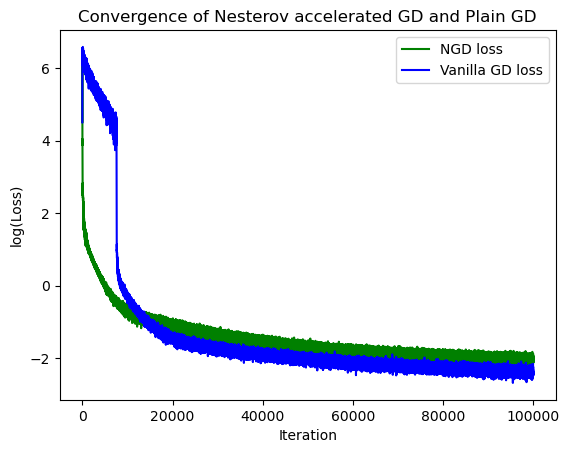

In [88]:
plt.plot(np.log10(Nesterov_losses), label = 'NGD loss', c = 'g')
plt.plot(np.log10(losses), label = 'Vanilla GD loss', c = 'b' )
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.title('Convergence of Nesterov accelerated GD and Plain GD')
plt.legend()

In [445]:
c,z, Nesterov_losses_sgd = nesterov_train_stochastic(n = 16, steps = 30000, Dt = 1e-8)

In [6]:
c,z, losses_sgd = train_SGD(n = 16, steps = 30000, Dt = 1e-8)

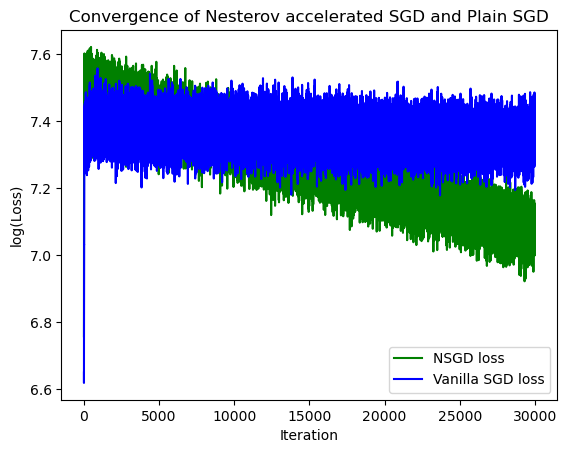

In [215]:
plt.plot(np.log10(Nesterov_losses_sgd), label = 'NSGD loss', c = 'g')
plt.plot(np.log10(losses_sgd), label = 'Vanilla SGD loss', c = 'b' )
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.title('Convergence of Nesterov accelerated SGD and Plain SGD')
plt.legend()

## General Observations

- In the deterministic gradient flow (with random initialization), the Nesterov accelerated loss (green) decreases towards a minimum much faster than regular gradient descent (blue), as expected.
- In the stochastic gradient flow (with random initialization), the Nesterov accelerated loss (green) decreases  towards a minimum faster than regular gradient descent (blue), though the losses stay closer together
